## HW3: CIFAR Classification with Imbalanced Dataset
본 과제의 목표는 CIFAR100 이미지 데이터셋을 이용하여 **Plain CNN**, **ResNet**, **pretrained ResNet**을 학습합니다.


### HW3 과제지시문 필독, 모든 모델 학습 시 learning curve 시각화 필수!

### 1. Dataset Download & SetUp

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np
import os
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

train_full = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform_train)
test_ds = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform_test)

100%|██████████| 169M/169M [00:04<00:00, 41.2MB/s]


result

```
100%|██████████| 169M/169M [00:14<00:00, 11.9MB/s]
```



### 2. Train / Val Split

- Train: 모델이 패턴을 학습하도록 사용하는 데이터 (train 목적)

- Validation: 하이퍼파라미터 조정 및 과적합 여부를 확인하는 데 사용하는 데이터 </br>
-> train단계에서 활용하지만 학습 대상은 아님, 하이퍼파라미터 조정 또는 성능 확인 목적으로 활용

- Test: 학습 종료 후 모델의 최종 성능을 평가하기 위한 데이터

* 각 데이터의 활용 용도에 대해 생각해보면서 실습을 진행하시길 바랍니다.

In [3]:
# Train / Validation 9:1 split
num_train = len(train_full)
indices = list(range(num_train))
split = int(0.1 * num_train)

train_idx, val_idx = indices[split:], indices[:split]
train_ds = Subset(train_full, train_idx)
val_ds = Subset(train_full, val_idx)

### 3. DataLoader
Pytorch의 Dataset & Dataloader는 데이터를 다루고 모델을 훈련 및 시험하기 위하여 가장 주의를 기울여야 될 부분 중의 하나입니다.

Dataset은 전체 데이터에서 특정 데이터를 꺼내오는 역할 및 전처리나 augmentation, 추가적인 function 처리를 효율적으로 할 수 있도록 합니다.
Dataloader의 경우, Dataset을 Minibatch 형태로 만들어 주며, Batch size나, Shuffle 여부에 대한 것들을 설정할 수 있습니다.

자세한 사항은 아래의 링크를 확인해보시기 바랍니다.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [4]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2)

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))

Train: 45000
Val: 5000
Test: 10000


result

```
Train: 45000
Val: 5000
Test: 10000
```



### 4. Training Loop
- 직접 training loop을 만들고 아래에서 모델을 완성한 후 호출하여 학습하고 검증합니다.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


result



```
Using device: cuda
```



In [6]:
def train_one_epoch(dataloader, model, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    device = next(model.parameters()).device

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        ##############################################
        optimizer.zero_grad()           # 1. 이전 배치의 기울기(gradient) 초기화
        pred = model(x)                 # 2. 모델 예측 (Forward)
        loss = criterion(pred, y)       # 3. 손실(Loss) 계산
        loss.backward()                 # 4. 역전파 (Backpropagation) - 기울기 계산
        optimizer.step()                # 5. 가중치 업데이트

        # total_loss update 및 정확도 계산
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item() # 가장 높은 확률의 클래스와 정답 비교
        total += y.size(0)              # 현재 배치의 데이터 개수 더하기
        ##############################################

    return correct/total, total_loss/len(dataloader)

In [7]:
def evaluate(dataloader, model, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds, targets = [], []
    device = next(model.parameters()).device

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ##############################################
            pred = model(x)             # 모델 예측
            loss = criterion(pred, y)   # Loss 계산

            total_loss += loss.item()
            correct += (pred.argmax(1) == y).sum().item()
            total += y.size(0)

            # F1 Score 계산을 위해 예측값과 정답을 리스트에 저장
            preds.extend(pred.argmax(1).cpu().numpy())
            targets.extend(y.cpu().numpy())
            ##############################################

    f1 = f1_score(targets, preds, average='macro')

    return correct/total, f1, total_loss/len(dataloader)


In [8]:
def early_stopping(train_loader, val_loader, model, criterion,
                   optimizer, scheduler, patience, save_path):
    """일반 학습용 Early Stopping 함수.
    - 매 epoch마다 train/val loss, acc, f1, lr를 출력
    - 학습이 끝난 뒤 learning curve와 learning rate 그래프를 그려줌
    """
    import matplotlib.pyplot as plt

    best_loss = np.inf
    counter = 0
    EPOCHS = 200

    # learning curve 기록용 리스트
    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []
    val_f1s = []
    lrs = []

    for epoch in tqdm(range(EPOCHS)):
        train_acc, train_loss = train_one_epoch(train_loader, model, criterion, optimizer)
        val_acc, val_f1, val_loss = evaluate(val_loader, model, criterion)

        # 스케줄러 업데이트 (존재할 경우에만)
        if scheduler is not None:
            scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']

        # 로그 출력 (콘솔)
        print(f"epoch:{epoch:<3} "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f} "
              f"lr={current_lr}")

        # learning curve 기록
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        lrs.append(current_lr)

        # Early Stopping 체크
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping!")
            break

    # 콘솔에 learning curve 요약 리스트 출력
    print("\n[Learning Curve] Train Loss:", train_losses)
    print("[Learning Curve] Val Loss  :", val_losses)
    print("[Learning Curve] Train Acc :", train_accs)
    print("[Learning Curve] Val Acc   :", val_accs)

    # ===== 시각화 =====
    epochs = range(1, len(train_losses) + 1)

    # Loss / Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="train_loss")
    plt.plot(epochs, val_losses, label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="train_acc")
    plt.plot(epochs, val_accs, label="val_acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Learning rate schedule
    plt.figure()
    plt.plot(epochs, lrs)
    plt.xlabel("epoch")
    plt.ylabel("learning rate")
    plt.title("Learning Rate Schedule")
    plt.tight_layout()
    plt.show()

    # 필요하면 history를 재사용할 수 있도록 dict로 리턴
    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs,
        "val_f1": val_f1s,
        "lr": lrs,
    }


In [9]:
def early_stopping_mixup(train_loader, val_loader, model, criterion,
                         optimizer, scheduler, patience, save_path):
    """
    Mixup 학습 전용 Early Stopping
    - train_mixup 사용
    - epoch별 로그 출력
    - learning curve + learning rate 그래프 시각화
    """
    import matplotlib.pyplot as plt

    best_loss = np.inf
    counter = 0
    EPOCHS = 200

    # ====== 기록용 리스트 ======
    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []
    val_f1s = []
    lrs = []

    for epoch in tqdm(range(EPOCHS)):
        # Mixup 학습
        train_acc, train_loss = train_mixup(train_loader, model, criterion, optimizer)
        # 검증 (Mixup X)
        val_acc, val_f1, val_loss = evaluate(val_loader, model, criterion)

        if scheduler is not None:
            scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']

        # ====== 콘솔 로그 ======
        print(f"epoch:{epoch:<3} "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f} "
              f"lr={current_lr}")

        # ====== 기록 ======
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        lrs.append(current_lr)

        # ====== Early Stopping 체크 ======
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping!")
            break

    # ====== 콘솔 Learning Curve 출력 ======
    print("\n[Mixup Learning Curve] Train Loss:", train_losses)
    print("[Mixup Learning Curve] Val Loss  :", val_losses)
    print("[Mixup Learning Curve] Train Acc :", train_accs)
    print("[Mixup Learning Curve] Val Acc   :", val_accs)

    # ====== 시각화 ======
    epochs = range(1, len(train_losses) + 1)

    # Loss / Accuracy 그래프
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="train_loss")
    plt.plot(epochs, val_losses, label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Mixup Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="train_acc")
    plt.plot(epochs, val_accs, label="val_acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Mixup Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Learning Rate 그래프
    plt.figure()
    plt.plot(epochs, lrs)
    plt.xlabel("epoch")
    plt.ylabel("learning rate")
    plt.title("Mixup Learning Rate Schedule")
    plt.tight_layout()
    plt.show()

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs,
        "val_f1": val_f1s,
        "lr": lrs,
    }


### 문제 1. Plain-CNN 20 vs ResNet 20

- 해당 조건에 맞게 CNN Model을 구성하고 성능 평가 진행
- early stopping을 사용하여 overfitting을 방지하고, learning curve를 시각화
- **plainCNN20 - test acc 0.5, ResNet20 - test acc 0.6 이상 달성**

#### [ ResNet20 for CIFAR ]
| Stage | Block 이름 (Layer)       | Output Size   | Structure (Kernel / Stride)                          | Channels | # Layers |
| ----- | ---------------------- | ------------- | ---------------------------------------------------- | -------- | -------- |
| 0     | Stem                   | 32×32         | Conv 3×3 / 1                                         | 16       | 1        |
| 1     | Residual Block Group 1 | 32×32         | (3×3 /1 → 3×3 /1) × **3 blocks**                     | 16       | 6        |
| 2     | Residual Block Group 2 | 16×16         | (3×3 /2 → 3×3 /1) + (3×3 /1 → 3×3 /1) × **2 blocks** | 32       | 6        |
| 3     | Residual Block Group 3 | 8×8           | (3×3 /2 → 3×3 /1) + (3×3 /1 → 3×3 /1) × **2 blocks** | 64       | 6        |
| 4     | Global Average Pool    | 1×1           | AvgPool 8×8                                          | -        | 1        |
| 5     | FC                     | 64 → #classes | Linear                                               | -        | 1        |


In [11]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, use_residual=True):
        super().__init__()
        self.use_residual = use_residual
        ###############################################
        # 첫 번째 3x3 Convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 두 번째 3x3 Convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut Connection (Skip Connection)
        # Stride가 1이 아니거나(이미지 크기가 줄거나), 채널 수가 바뀔 때 입력 x의 차원을 맞춰줘야 함
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        ###############################################

    def forward(self, x):
        ###############################################
        # 1. Main Path
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # 2. Skip Connection (ResNet인 경우에만 수행)
        if self.use_residual:
            out += self.shortcut(x)

        # 3. Final Activation
        out = F.relu(out)
        ###############################################
        return out

In [12]:
# 지시사항 요구조건: Bottleneck 구조 코드 작성
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, use_residual=True):
        super(Bottleneck, self).__init__()
        self.use_residual = use_residual

        # 1x1 Conv (차원 축소)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3 Conv (연산)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 1x1 Conv (차원 확대)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.use_residual:
            out += self.shortcut(x)

        out = F.relu(out)
        return out

In [13]:
class ResNet20(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=[3,3,3], num_classes=100, use_residual=True):
        super().__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1, use_residual=use_residual)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2, use_residual=use_residual)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2, use_residual=use_residual)

        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, use_residual):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for st in strides:
            layers.append(block(self.in_channels, out_channels, st, use_residual))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU(inplace=True)(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = nn.AdaptiveAvgPool2d(1)(out)
        out = out.view(out.size(0), -1)
        return self.linear(out)

In [14]:
# PlainNet20은 skip connection 제거
def build_resnet20(num_classes=100):
    return ResNet20(use_residual=True, num_classes=num_classes)

def build_plainnet20(num_classes=100):
    return ResNet20(use_residual=False, num_classes=num_classes)


================ Train PlainNet20 ================


  0%|          | 1/200 [00:11<39:09, 11.81s/it]

epoch:0   train_loss=4.2284 train_acc=0.0441 val_loss=3.9764 val_acc=0.0670 val_f1=0.0397 lr=0.1


  1%|          | 2/200 [00:21<35:33, 10.78s/it]

epoch:1   train_loss=3.8560 train_acc=0.0925 val_loss=3.8683 val_acc=0.0966 val_f1=0.0730 lr=0.1


  2%|▏         | 3/200 [00:32<34:45, 10.59s/it]

epoch:2   train_loss=3.6211 train_acc=0.1298 val_loss=3.6137 val_acc=0.1320 val_f1=0.1150 lr=0.1


  2%|▏         | 4/200 [00:42<33:44, 10.33s/it]

epoch:3   train_loss=3.4360 train_acc=0.1618 val_loss=3.6979 val_acc=0.1226 val_f1=0.0981 lr=0.1


  2%|▎         | 5/200 [00:51<32:50, 10.10s/it]

epoch:4   train_loss=3.2460 train_acc=0.1944 val_loss=3.6296 val_acc=0.1492 val_f1=0.1223 lr=0.1


  3%|▎         | 6/200 [01:01<32:21, 10.01s/it]

epoch:5   train_loss=3.0657 train_acc=0.2287 val_loss=3.2939 val_acc=0.1930 val_f1=0.1905 lr=0.1


  4%|▎         | 7/200 [01:11<31:49,  9.89s/it]

epoch:6   train_loss=2.8964 train_acc=0.2592 val_loss=3.2819 val_acc=0.2092 val_f1=0.1851 lr=0.1


  4%|▍         | 8/200 [01:21<31:35,  9.87s/it]

epoch:7   train_loss=2.7664 train_acc=0.2865 val_loss=3.6725 val_acc=0.1906 val_f1=0.1619 lr=0.1


  4%|▍         | 9/200 [01:30<31:14,  9.81s/it]

epoch:8   train_loss=2.6599 train_acc=0.3073 val_loss=3.7418 val_acc=0.1816 val_f1=0.1720 lr=0.1


  5%|▌         | 10/200 [01:40<31:03,  9.81s/it]

epoch:9   train_loss=2.5496 train_acc=0.3299 val_loss=2.8069 val_acc=0.2852 val_f1=0.2608 lr=0.1


  6%|▌         | 11/200 [01:50<31:04,  9.86s/it]

epoch:10  train_loss=2.4711 train_acc=0.3478 val_loss=3.4940 val_acc=0.2222 val_f1=0.2038 lr=0.1


  6%|▌         | 12/200 [02:00<30:48,  9.83s/it]

epoch:11  train_loss=2.4122 train_acc=0.3620 val_loss=2.9110 val_acc=0.2782 val_f1=0.2496 lr=0.1


  6%|▋         | 13/200 [02:10<30:31,  9.79s/it]

epoch:12  train_loss=2.3456 train_acc=0.3764 val_loss=3.1234 val_acc=0.2620 val_f1=0.2316 lr=0.1


  7%|▋         | 14/200 [02:20<30:45,  9.92s/it]

epoch:13  train_loss=2.2910 train_acc=0.3909 val_loss=3.3778 val_acc=0.2552 val_f1=0.2382 lr=0.1


  8%|▊         | 15/200 [02:30<30:40,  9.95s/it]

epoch:14  train_loss=2.2589 train_acc=0.4002 val_loss=2.8723 val_acc=0.2964 val_f1=0.2826 lr=0.1


  8%|▊         | 16/200 [02:40<30:37,  9.98s/it]

epoch:15  train_loss=2.2167 train_acc=0.4077 val_loss=2.5187 val_acc=0.3402 val_f1=0.3363 lr=0.1


  8%|▊         | 17/200 [02:50<30:19,  9.94s/it]

epoch:16  train_loss=2.1828 train_acc=0.4116 val_loss=3.0188 val_acc=0.2864 val_f1=0.2658 lr=0.1


  9%|▉         | 18/200 [02:59<29:57,  9.88s/it]

epoch:17  train_loss=2.1495 train_acc=0.4220 val_loss=2.5794 val_acc=0.3458 val_f1=0.3364 lr=0.1


 10%|▉         | 19/200 [03:09<29:49,  9.88s/it]

epoch:18  train_loss=2.1368 train_acc=0.4265 val_loss=2.4680 val_acc=0.3544 val_f1=0.3472 lr=0.1


 10%|█         | 20/200 [03:19<29:37,  9.88s/it]

epoch:19  train_loss=2.1022 train_acc=0.4333 val_loss=2.5117 val_acc=0.3534 val_f1=0.3403 lr=0.1


 10%|█         | 21/200 [03:29<29:44,  9.97s/it]

epoch:20  train_loss=2.0914 train_acc=0.4372 val_loss=2.9120 val_acc=0.2988 val_f1=0.2897 lr=0.1


 11%|█         | 22/200 [03:39<29:36,  9.98s/it]

epoch:21  train_loss=2.0670 train_acc=0.4391 val_loss=2.7060 val_acc=0.3264 val_f1=0.3288 lr=0.1


 12%|█▏        | 23/200 [03:49<29:31, 10.01s/it]

epoch:22  train_loss=2.0488 train_acc=0.4431 val_loss=2.6275 val_acc=0.3260 val_f1=0.3178 lr=0.1


 12%|█▏        | 24/200 [03:59<29:11,  9.95s/it]

epoch:23  train_loss=2.0500 train_acc=0.4440 val_loss=2.5967 val_acc=0.3460 val_f1=0.3288 lr=0.1


 12%|█▎        | 25/200 [04:09<29:13, 10.02s/it]

epoch:24  train_loss=2.0253 train_acc=0.4515 val_loss=2.7853 val_acc=0.3232 val_f1=0.3006 lr=0.1


 13%|█▎        | 26/200 [04:19<28:47,  9.93s/it]

epoch:25  train_loss=2.0193 train_acc=0.4518 val_loss=2.4786 val_acc=0.3712 val_f1=0.3567 lr=0.1


 14%|█▎        | 27/200 [04:29<28:42,  9.96s/it]

epoch:26  train_loss=1.9972 train_acc=0.4578 val_loss=2.7111 val_acc=0.3294 val_f1=0.3143 lr=0.1


 14%|█▍        | 28/200 [04:39<28:24,  9.91s/it]

epoch:27  train_loss=1.9907 train_acc=0.4588 val_loss=2.6325 val_acc=0.3268 val_f1=0.3202 lr=0.1


 14%|█▍        | 29/200 [04:49<28:21,  9.95s/it]

epoch:28  train_loss=1.9783 train_acc=0.4640 val_loss=2.7052 val_acc=0.3190 val_f1=0.3121 lr=0.1


 15%|█▌        | 30/200 [04:59<28:05,  9.91s/it]

epoch:29  train_loss=1.9698 train_acc=0.4657 val_loss=2.6438 val_acc=0.3348 val_f1=0.3180 lr=0.1


 16%|█▌        | 31/200 [05:09<27:49,  9.88s/it]

epoch:30  train_loss=1.9630 train_acc=0.4654 val_loss=2.9042 val_acc=0.3104 val_f1=0.2847 lr=0.1


 16%|█▌        | 32/200 [05:19<27:50,  9.94s/it]

epoch:31  train_loss=1.9549 train_acc=0.4671 val_loss=2.8761 val_acc=0.3018 val_f1=0.2864 lr=0.1


 16%|█▋        | 33/200 [05:29<28:01, 10.07s/it]

epoch:32  train_loss=1.9370 train_acc=0.4718 val_loss=2.9586 val_acc=0.2924 val_f1=0.2732 lr=0.1


 17%|█▋        | 34/200 [05:39<27:44, 10.03s/it]

epoch:33  train_loss=1.9388 train_acc=0.4705 val_loss=2.4059 val_acc=0.3762 val_f1=0.3637 lr=0.1


 18%|█▊        | 35/200 [05:49<27:28,  9.99s/it]

epoch:34  train_loss=1.9317 train_acc=0.4746 val_loss=4.3391 val_acc=0.1768 val_f1=0.1768 lr=0.1


 18%|█▊        | 36/200 [05:59<27:41, 10.13s/it]

epoch:35  train_loss=1.9197 train_acc=0.4759 val_loss=2.8919 val_acc=0.3062 val_f1=0.2789 lr=0.1


 18%|█▊        | 37/200 [06:10<27:29, 10.12s/it]

epoch:36  train_loss=1.9044 train_acc=0.4798 val_loss=2.4793 val_acc=0.3790 val_f1=0.3666 lr=0.1


 19%|█▉        | 38/200 [06:20<27:11, 10.07s/it]

epoch:37  train_loss=1.9027 train_acc=0.4824 val_loss=2.7978 val_acc=0.3288 val_f1=0.3185 lr=0.1


 20%|█▉        | 39/200 [06:29<26:56, 10.04s/it]

epoch:38  train_loss=1.8913 train_acc=0.4832 val_loss=2.7466 val_acc=0.3152 val_f1=0.2952 lr=0.1


 20%|██        | 40/200 [06:40<26:54, 10.09s/it]

epoch:39  train_loss=1.8931 train_acc=0.4806 val_loss=2.4146 val_acc=0.3780 val_f1=0.3564 lr=0.1


 20%|██        | 41/200 [06:50<26:42, 10.08s/it]

epoch:40  train_loss=1.8934 train_acc=0.4830 val_loss=2.5234 val_acc=0.3664 val_f1=0.3602 lr=0.1


 21%|██        | 42/200 [06:59<26:14,  9.97s/it]

epoch:41  train_loss=1.8773 train_acc=0.4855 val_loss=2.7758 val_acc=0.3230 val_f1=0.3066 lr=0.1


 22%|██▏       | 43/200 [07:09<26:01,  9.94s/it]

epoch:42  train_loss=1.8721 train_acc=0.4870 val_loss=2.5055 val_acc=0.3732 val_f1=0.3668 lr=0.1


 22%|██▏       | 44/200 [07:19<25:40,  9.88s/it]

epoch:43  train_loss=1.8627 train_acc=0.4893 val_loss=2.3026 val_acc=0.3972 val_f1=0.3844 lr=0.1


 22%|██▎       | 45/200 [07:29<25:21,  9.82s/it]

epoch:44  train_loss=1.8763 train_acc=0.4852 val_loss=2.8072 val_acc=0.3058 val_f1=0.2987 lr=0.1


 23%|██▎       | 46/200 [07:39<25:23,  9.89s/it]

epoch:45  train_loss=1.8541 train_acc=0.4925 val_loss=2.5101 val_acc=0.3552 val_f1=0.3470 lr=0.1


 24%|██▎       | 47/200 [07:49<25:36, 10.04s/it]

epoch:46  train_loss=1.8519 train_acc=0.4931 val_loss=2.9107 val_acc=0.2876 val_f1=0.2701 lr=0.1


 24%|██▍       | 48/200 [07:59<25:14,  9.96s/it]

epoch:47  train_loss=1.8529 train_acc=0.4928 val_loss=2.4198 val_acc=0.3866 val_f1=0.3789 lr=0.1


 24%|██▍       | 49/200 [08:09<24:53,  9.89s/it]

epoch:48  train_loss=1.8375 train_acc=0.4982 val_loss=2.5628 val_acc=0.3586 val_f1=0.3621 lr=0.1


 25%|██▌       | 50/200 [08:19<24:53,  9.95s/it]

epoch:49  train_loss=1.8324 train_acc=0.4949 val_loss=2.5222 val_acc=0.3634 val_f1=0.3496 lr=0.1


 26%|██▌       | 51/200 [08:29<24:33,  9.89s/it]

epoch:50  train_loss=1.8277 train_acc=0.4979 val_loss=2.5587 val_acc=0.3620 val_f1=0.3534 lr=0.1


 26%|██▌       | 52/200 [08:40<25:16, 10.25s/it]

epoch:51  train_loss=1.8383 train_acc=0.4936 val_loss=3.5141 val_acc=0.2626 val_f1=0.2257 lr=0.1


 26%|██▋       | 53/200 [08:50<24:54, 10.16s/it]

epoch:52  train_loss=1.8167 train_acc=0.5019 val_loss=2.5319 val_acc=0.3766 val_f1=0.3650 lr=0.1


 27%|██▋       | 54/200 [09:00<24:47, 10.19s/it]

epoch:53  train_loss=1.8222 train_acc=0.4985 val_loss=2.4109 val_acc=0.3892 val_f1=0.3913 lr=0.1


 28%|██▊       | 55/200 [09:10<24:18, 10.06s/it]

epoch:54  train_loss=1.8148 train_acc=0.5051 val_loss=2.5982 val_acc=0.3488 val_f1=0.3429 lr=0.1


 28%|██▊       | 56/200 [09:19<24:01, 10.01s/it]

epoch:55  train_loss=1.8193 train_acc=0.5002 val_loss=2.5502 val_acc=0.3564 val_f1=0.3373 lr=0.1


 28%|██▊       | 57/200 [09:29<23:50, 10.00s/it]

epoch:56  train_loss=1.8070 train_acc=0.5062 val_loss=2.3413 val_acc=0.3968 val_f1=0.3769 lr=0.1


 29%|██▉       | 58/200 [09:39<23:35,  9.97s/it]

epoch:57  train_loss=1.8037 train_acc=0.5029 val_loss=2.7992 val_acc=0.3316 val_f1=0.3202 lr=0.1


 30%|██▉       | 59/200 [09:49<23:23,  9.95s/it]

epoch:58  train_loss=1.8124 train_acc=0.5035 val_loss=2.2182 val_acc=0.4180 val_f1=0.4045 lr=0.1


 30%|███       | 60/200 [09:59<23:05,  9.90s/it]

epoch:59  train_loss=1.7938 train_acc=0.5057 val_loss=2.5867 val_acc=0.3610 val_f1=0.3627 lr=0.1


 30%|███       | 61/200 [10:09<22:54,  9.89s/it]

epoch:60  train_loss=1.8048 train_acc=0.5059 val_loss=2.4327 val_acc=0.3736 val_f1=0.3684 lr=0.1


 31%|███       | 62/200 [10:19<22:43,  9.88s/it]

epoch:61  train_loss=1.7915 train_acc=0.5064 val_loss=2.6098 val_acc=0.3544 val_f1=0.3523 lr=0.1


 32%|███▏      | 63/200 [10:29<22:31,  9.86s/it]

epoch:62  train_loss=1.7981 train_acc=0.5044 val_loss=2.3367 val_acc=0.3934 val_f1=0.3782 lr=0.1


 32%|███▏      | 64/200 [10:38<22:22,  9.87s/it]

epoch:63  train_loss=1.7924 train_acc=0.5054 val_loss=2.6744 val_acc=0.3340 val_f1=0.3286 lr=0.1


 32%|███▎      | 65/200 [10:48<22:10,  9.85s/it]

epoch:64  train_loss=1.7861 train_acc=0.5093 val_loss=2.5437 val_acc=0.3586 val_f1=0.3463 lr=0.1


 33%|███▎      | 66/200 [10:58<21:56,  9.83s/it]

epoch:65  train_loss=1.7955 train_acc=0.5042 val_loss=2.2586 val_acc=0.4042 val_f1=0.4029 lr=0.1


 34%|███▎      | 67/200 [11:08<21:46,  9.82s/it]

epoch:66  train_loss=1.7837 train_acc=0.5103 val_loss=2.4486 val_acc=0.3752 val_f1=0.3612 lr=0.1


 34%|███▍      | 68/200 [11:18<21:37,  9.83s/it]

epoch:67  train_loss=1.7892 train_acc=0.5062 val_loss=4.3228 val_acc=0.2156 val_f1=0.2049 lr=0.1


 34%|███▍      | 69/200 [11:28<21:50, 10.00s/it]

epoch:68  train_loss=1.7736 train_acc=0.5117 val_loss=2.8389 val_acc=0.3054 val_f1=0.2967 lr=0.1


 35%|███▌      | 70/200 [11:38<21:48, 10.07s/it]

epoch:69  train_loss=1.7978 train_acc=0.5045 val_loss=2.4929 val_acc=0.3626 val_f1=0.3613 lr=0.1


 36%|███▌      | 71/200 [11:48<21:25,  9.96s/it]

epoch:70  train_loss=1.7807 train_acc=0.5082 val_loss=2.9895 val_acc=0.2992 val_f1=0.2994 lr=0.1


 36%|███▌      | 72/200 [11:58<21:18,  9.99s/it]

epoch:71  train_loss=1.7742 train_acc=0.5140 val_loss=3.1126 val_acc=0.2910 val_f1=0.2703 lr=0.1


 36%|███▋      | 73/200 [12:08<20:57,  9.90s/it]

epoch:72  train_loss=1.7728 train_acc=0.5108 val_loss=2.7244 val_acc=0.3306 val_f1=0.3285 lr=0.1


 37%|███▋      | 74/200 [12:18<20:55,  9.96s/it]

epoch:73  train_loss=1.7874 train_acc=0.5123 val_loss=2.6069 val_acc=0.3510 val_f1=0.3495 lr=0.1


 38%|███▊      | 75/200 [12:28<20:38,  9.91s/it]

epoch:74  train_loss=1.7663 train_acc=0.5140 val_loss=2.5840 val_acc=0.3468 val_f1=0.3447 lr=0.1


 38%|███▊      | 76/200 [12:38<20:38,  9.99s/it]

epoch:75  train_loss=1.7724 train_acc=0.5102 val_loss=2.3189 val_acc=0.3966 val_f1=0.3907 lr=0.1


 38%|███▊      | 77/200 [12:48<20:42, 10.10s/it]

epoch:76  train_loss=1.7733 train_acc=0.5126 val_loss=2.8850 val_acc=0.3026 val_f1=0.2980 lr=0.1


 39%|███▉      | 78/200 [12:58<20:25, 10.04s/it]

epoch:77  train_loss=1.7649 train_acc=0.5125 val_loss=2.5719 val_acc=0.3472 val_f1=0.3479 lr=0.1


 39%|███▉      | 78/200 [13:08<20:33, 10.11s/it]

epoch:78  train_loss=1.7760 train_acc=0.5100 val_loss=2.4738 val_acc=0.3806 val_f1=0.3778 lr=0.1
Early stopping!

[Learning Curve] Train Loss: [4.228372235189784, 3.855953857979991, 3.6210628273812207, 3.4359689971262757, 3.2459954314611177, 3.065673456950621, 2.896413807164539, 2.766444584185427, 2.659870262173089, 2.5495895316654984, 2.4711111309853466, 2.4122155627066437, 2.3455827293748204, 2.291004515845667, 2.2588552815670315, 2.2166924686594442, 2.182807360183109, 2.1494859490882265, 2.1368020681495015, 2.1022014059126377, 2.091418996453285, 2.066953547637571, 2.0488009595058183, 2.0499723712829026, 2.0253408327698708, 2.019315902143717, 1.997240215878595, 1.9907474893737922, 1.9782683429392902, 1.96976798908277, 1.9630383263257416, 1.9549176310273735, 1.936990613964471, 1.9387863078577952, 1.931713024323637, 1.9196793853559277, 1.9043568044223569, 1.9026875926012343, 1.8913237364454702, 1.8930556750433012, 1.8934351564808325, 1.8772595863450656, 1.8721286844123493, 1.8626548170

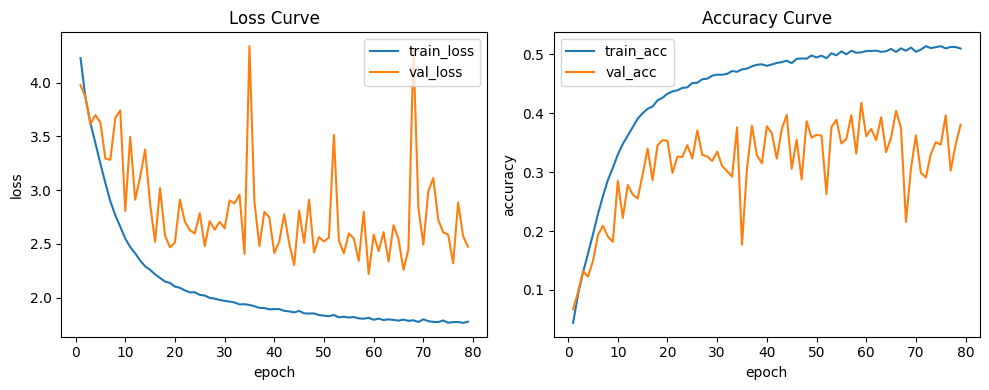

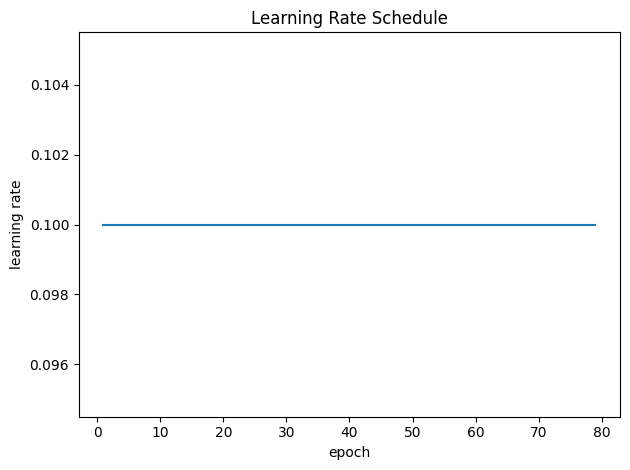

In [15]:
model_plain = build_plainnet20().to(device)   # use_residual=False 로 만들어진 PlainNet20
criterion = nn.CrossEntropyLoss()

# optimizer / scheduler 설정
# -> ResNet20 기준과 맞춰서 SGD + MultiStepLR 사용
optimizer = torch.optim.SGD(
    model_plain.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4,
    nesterov=False,
)

# CIFAR-10에서 자주 쓰는 스케줄: 100, 150 epoch에서 lr 감소
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[100, 150],
    gamma=0.1,
)

print("\n================ Train PlainNet20 ================")
plain_history = early_stopping(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model_plain,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    patience=20,
    save_path="plain20_best.pth",
)


[시도1] result



```
================ Train PlainNet20 ================
  0%|          | 1/200 [00:21<1:12:54, 21.98s/it]epoch:0   train_loss=4.2863 train_acc=0.0392 val_loss=4.0969 val_acc=0.0574 val_f1=0.0330 lr=0.1
  1%|          | 2/200 [00:43<1:11:09, 21.56s/it]epoch:1   train_loss=3.8998 train_acc=0.0835 val_loss=3.9699 val_acc=0.0754 val_f1=0.0522 lr=0.1
  2%|▏         | 3/200 [01:04<1:10:39, 21.52s/it]epoch:2   train_loss=3.6584 train_acc=0.1242 val_loss=3.6441 val_acc=0.1172 val_f1=0.0948 lr=0.1
  2%|▏         | 4/200 [01:29<1:14:41, 22.86s/it]epoch:3   train_loss=3.4197 train_acc=0.1627 val_loss=3.4809 val_acc=0.1486 val_f1=0.1209 lr=0.1
  2%|▎         | 5/200 [01:51<1:13:05, 22.49s/it]epoch:4   train_loss=3.2147 train_acc=0.1976 val_loss=3.3843 val_acc=0.1776 val_f1=0.1501 lr=0.1
  3%|▎         | 6/200 [02:12<1:11:15, 22.04s/it]epoch:5   train_loss=3.0496 train_acc=0.2293 val_loss=3.8005 val_acc=0.1538 val_f1=0.1381 lr=0.1
  4%|▎         | 7/200 [02:33<1:09:53, 21.73s/it]epoch:6   train_loss=2.9136 train_acc=0.2604 val_loss=3.3411 val_acc=0.2070 val_f1=0.1886 lr=0.1
  4%|▍         | 8/200 [02:55<1:09:24, 21.69s/it]epoch:7   train_loss=2.7873 train_acc=0.2865 val_loss=3.6610 val_acc=0.1934 val_f1=0.1688 lr=0.1
  4%|▍         | 9/200 [03:16<1:08:26, 21.50s/it]epoch:8   train_loss=2.6899 train_acc=0.3030 val_loss=2.9563 val_acc=0.2638 val_f1=0.2442 lr=0.1
  5%|▌         | 10/200 [03:37<1:07:56, 21.45s/it]epoch:9   train_loss=2.5890 train_acc=0.3247 val_loss=3.0048 val_acc=0.2610 val_f1=0.2392 lr=0.1
  6%|▌         | 11/200 [03:59<1:07:41, 21.49s/it]epoch:10  train_loss=2.4985 train_acc=0.3448 val_loss=3.4071 val_acc=0.2238 val_f1=0.2141 lr=0.1
  6%|▌         | 12/200 [04:20<1:06:50, 21.33s/it]epoch:11  train_loss=2.4206 train_acc=0.3622 val_loss=2.7841 val_acc=0.3006 val_f1=0.2817 lr=0.1
  6%|▋         | 13/200 [04:41<1:06:45, 21.42s/it]epoch:12  train_loss=2.3549 train_acc=0.3764 val_loss=2.8559 val_acc=0.2712 val_f1=0.2551 lr=0.1
  7%|▋         | 14/200 [05:03<1:06:28, 21.44s/it]epoch:13  train_loss=2.3088 train_acc=0.3871 val_loss=2.9509 val_acc=0.2710 val_f1=0.2524 lr=0.1
  8%|▊         | 15/200 [05:24<1:05:18, 21.18s/it]epoch:14  train_loss=2.2720 train_acc=0.3950 val_loss=2.9117 val_acc=0.2886 val_f1=0.2805 lr=0.1
  8%|▊         | 16/200 [05:45<1:05:33, 21.38s/it]epoch:15  train_loss=2.2230 train_acc=0.4054 val_loss=2.7869 val_acc=0.2982 val_f1=0.2696 lr=0.1
  8%|▊         | 17/200 [06:07<1:05:34, 21.50s/it]epoch:16  train_loss=2.1978 train_acc=0.4117 val_loss=3.8672 val_acc=0.2130 val_f1=0.2004 lr=0.1
  9%|▉         | 18/200 [06:28<1:04:25, 21.24s/it]epoch:17  train_loss=2.1676 train_acc=0.4162 val_loss=3.0073 val_acc=0.2822 val_f1=0.2756 lr=0.1
 10%|▉         | 19/200 [06:49<1:04:20, 21.33s/it]epoch:18  train_loss=2.1518 train_acc=0.4225 val_loss=2.7355 val_acc=0.3198 val_f1=0.3069 lr=0.1
 10%|█         | 20/200 [07:11<1:04:28, 21.49s/it]epoch:19  train_loss=2.1207 train_acc=0.4291 val_loss=2.6824 val_acc=0.3380 val_f1=0.3137 lr=0.1
 10%|█         | 21/200 [07:32<1:03:45, 21.37s/it]epoch:20  train_loss=2.0968 train_acc=0.4354 val_loss=2.6770 val_acc=0.3266 val_f1=0.3285 lr=0.1
 11%|█         | 22/200 [07:54<1:03:37, 21.45s/it]epoch:21  train_loss=2.0716 train_acc=0.4403 val_loss=2.5802 val_acc=0.3362 val_f1=0.3175 lr=0.1
 12%|█▏        | 23/200 [08:15<1:03:20, 21.47s/it]epoch:22  train_loss=2.0549 train_acc=0.4447 val_loss=2.6101 val_acc=0.3332 val_f1=0.3213 lr=0.1
 12%|█▏        | 24/200 [08:36<1:02:18, 21.24s/it]epoch:23  train_loss=2.0506 train_acc=0.4474 val_loss=2.6216 val_acc=0.3376 val_f1=0.3307 lr=0.1
 12%|█▎        | 25/200 [08:57<1:02:02, 21.27s/it]epoch:24  train_loss=2.0411 train_acc=0.4458 val_loss=2.4805 val_acc=0.3570 val_f1=0.3502 lr=0.1
 13%|█▎        | 26/200 [09:19<1:01:49, 21.32s/it]epoch:25  train_loss=2.0186 train_acc=0.4533 val_loss=2.7131 val_acc=0.3260 val_f1=0.3047 lr=0.1
 14%|█▎        | 27/200 [09:40<1:01:08, 21.20s/it]epoch:26  train_loss=2.0031 train_acc=0.4557 val_loss=2.5910 val_acc=0.3452 val_f1=0.3287 lr=0.1
 14%|█▍        | 28/200 [10:02<1:01:13, 21.36s/it]epoch:27  train_loss=1.9945 train_acc=0.4601 val_loss=2.5608 val_acc=0.3488 val_f1=0.3378 lr=0.1
 14%|█▍        | 29/200 [10:24<1:01:25, 21.55s/it]epoch:28  train_loss=1.9922 train_acc=0.4593 val_loss=2.4306 val_acc=0.3674 val_f1=0.3478 lr=0.1
 15%|█▌        | 30/200 [10:45<1:00:35, 21.39s/it]epoch:29  train_loss=1.9754 train_acc=0.4602 val_loss=2.3079 val_acc=0.3868 val_f1=0.3797 lr=0.1
 16%|█▌        | 31/200 [11:06<1:00:36, 21.52s/it]epoch:30  train_loss=1.9798 train_acc=0.4621 val_loss=2.5710 val_acc=0.3390 val_f1=0.3345 lr=0.1
 16%|█▌        | 32/200 [11:28<1:00:26, 21.58s/it]epoch:31  train_loss=1.9516 train_acc=0.4688 val_loss=3.3616 val_acc=0.2520 val_f1=0.2440 lr=0.1
 16%|█▋        | 33/200 [11:49<59:35, 21.41s/it]  epoch:32  train_loss=1.9437 train_acc=0.4716 val_loss=2.8124 val_acc=0.3188 val_f1=0.3172 lr=0.1
 17%|█▋        | 34/200 [12:11<59:32, 21.52s/it]epoch:33  train_loss=1.9422 train_acc=0.4705 val_loss=2.4370 val_acc=0.3698 val_f1=0.3556 lr=0.1
 18%|█▊        | 35/200 [12:33<59:17, 21.56s/it]epoch:34  train_loss=1.9371 train_acc=0.4720 val_loss=2.7505 val_acc=0.3302 val_f1=0.3194 lr=0.1
 18%|█▊        | 36/200 [12:53<58:14, 21.31s/it]epoch:35  train_loss=1.9300 train_acc=0.4718 val_loss=2.7066 val_acc=0.3282 val_f1=0.3143 lr=0.1
 18%|█▊        | 37/200 [13:15<58:05, 21.38s/it]epoch:36  train_loss=1.9083 train_acc=0.4772 val_loss=2.7445 val_acc=0.3472 val_f1=0.3308 lr=0.1
 19%|█▉        | 38/200 [13:36<57:40, 21.36s/it]epoch:37  train_loss=1.9109 train_acc=0.4789 val_loss=2.7587 val_acc=0.3194 val_f1=0.3048 lr=0.1
 20%|█▉        | 39/200 [13:57<56:42, 21.13s/it]epoch:38  train_loss=1.8921 train_acc=0.4842 val_loss=2.6895 val_acc=0.3332 val_f1=0.3334 lr=0.1
 20%|██        | 40/200 [14:18<56:46, 21.29s/it]epoch:39  train_loss=1.9005 train_acc=0.4811 val_loss=2.6402 val_acc=0.3520 val_f1=0.3433 lr=0.1
 20%|██        | 41/200 [14:40<56:22, 21.27s/it]epoch:40  train_loss=1.8918 train_acc=0.4803 val_loss=3.0787 val_acc=0.2794 val_f1=0.2753 lr=0.1
 21%|██        | 42/200 [15:00<55:12, 20.97s/it]epoch:41  train_loss=1.8845 train_acc=0.4834 val_loss=2.4146 val_acc=0.3710 val_f1=0.3634 lr=0.1
 22%|██▏       | 43/200 [15:21<55:05, 21.05s/it]epoch:42  train_loss=1.8657 train_acc=0.4884 val_loss=2.2254 val_acc=0.4170 val_f1=0.4056 lr=0.1
 22%|██▏       | 44/200 [15:42<54:57, 21.14s/it]epoch:43  train_loss=1.8652 train_acc=0.4861 val_loss=2.6975 val_acc=0.3378 val_f1=0.3302 lr=0.1
 22%|██▎       | 45/200 [16:03<53:53, 20.86s/it]epoch:44  train_loss=1.8559 train_acc=0.4904 val_loss=2.9343 val_acc=0.3076 val_f1=0.2999 lr=0.1
 23%|██▎       | 46/200 [16:24<53:58, 21.03s/it]epoch:45  train_loss=1.8579 train_acc=0.4902 val_loss=2.7097 val_acc=0.3332 val_f1=0.3079 lr=0.1
 24%|██▎       | 47/200 [16:45<53:36, 21.02s/it]epoch:46  train_loss=1.8494 train_acc=0.4924 val_loss=2.6940 val_acc=0.3552 val_f1=0.3607 lr=0.1
 24%|██▍       | 48/200 [17:06<52:56, 20.90s/it]epoch:47  train_loss=1.8523 train_acc=0.4904 val_loss=3.0763 val_acc=0.2950 val_f1=0.2795 lr=0.1
 24%|██▍       | 49/200 [17:27<52:56, 21.04s/it]epoch:48  train_loss=1.8384 train_acc=0.4918 val_loss=2.5424 val_acc=0.3570 val_f1=0.3404 lr=0.1
 25%|██▌       | 50/200 [17:48<52:21, 20.95s/it]epoch:49  train_loss=1.8431 train_acc=0.4929 val_loss=2.6724 val_acc=0.3444 val_f1=0.3307 lr=0.1
 26%|██▌       | 51/200 [18:09<52:28, 21.13s/it]epoch:50  train_loss=1.8301 train_acc=0.4965 val_loss=2.5729 val_acc=0.3520 val_f1=0.3506 lr=0.1
 26%|██▌       | 52/200 [18:31<52:19, 21.21s/it]epoch:51  train_loss=1.8292 train_acc=0.4970 val_loss=3.3827 val_acc=0.2698 val_f1=0.2707 lr=0.1
 26%|██▋       | 53/200 [18:51<51:30, 21.02s/it]epoch:52  train_loss=1.8240 train_acc=0.4972 val_loss=3.0631 val_acc=0.2868 val_f1=0.2666 lr=0.1
 27%|██▋       | 54/200 [19:13<51:38, 21.23s/it]epoch:53  train_loss=1.8235 train_acc=0.4974 val_loss=2.4809 val_acc=0.3668 val_f1=0.3479 lr=0.1
 28%|██▊       | 55/200 [19:34<51:23, 21.26s/it]epoch:54  train_loss=1.8151 train_acc=0.4975 val_loss=2.7235 val_acc=0.3176 val_f1=0.3200 lr=0.1
 28%|██▊       | 56/200 [19:55<50:29, 21.04s/it]epoch:55  train_loss=1.8152 train_acc=0.4989 val_loss=2.3190 val_acc=0.3978 val_f1=0.3856 lr=0.1
 28%|██▊       | 57/200 [20:16<50:28, 21.18s/it]epoch:56  train_loss=1.7994 train_acc=0.5048 val_loss=2.6578 val_acc=0.3452 val_f1=0.3408 lr=0.1
 29%|██▉       | 58/200 [20:38<50:23, 21.29s/it]epoch:57  train_loss=1.8118 train_acc=0.5006 val_loss=2.9041 val_acc=0.3232 val_f1=0.3079 lr=0.1
 30%|██▉       | 59/200 [20:58<49:28, 21.05s/it]epoch:58  train_loss=1.8080 train_acc=0.4987 val_loss=2.3636 val_acc=0.3948 val_f1=0.3818 lr=0.1
 30%|███       | 60/200 [21:20<49:19, 21.14s/it]epoch:59  train_loss=1.8054 train_acc=0.5033 val_loss=2.5854 val_acc=0.3648 val_f1=0.3698 lr=0.1
 30%|███       | 61/200 [21:41<49:19, 21.29s/it]epoch:60  train_loss=1.7978 train_acc=0.5037 val_loss=2.6959 val_acc=0.3268 val_f1=0.3110 lr=0.1
 31%|███       | 62/200 [22:02<48:19, 21.01s/it]epoch:61  train_loss=1.8067 train_acc=0.5015 val_loss=2.2302 val_acc=0.4200 val_f1=0.4015 lr=0.1
 31%|███       | 62/200 [22:23<49:50, 21.67s/it]epoch:62  train_loss=1.7952 train_acc=0.5077 val_loss=2.5593 val_acc=0.3630 val_f1=0.3481 lr=0.1
Early stopping!


=== PlainNet20 Test Result ===
Accuracy: 0.43
F1 Score: 0.4211
Loss    : 2.1825
Trainable Params: 278,324
```




[시도2] result



```

================ Train PlainNet20 ================
  0%|          | 1/200 [00:21<1:10:52, 21.37s/it]epoch:0   train_loss=4.2267 train_acc=0.0439 val_loss=4.0282 val_acc=0.0622 val_f1=0.0303 lr=0.1
  1%|          | 2/200 [00:41<1:08:31, 20.77s/it]epoch:1   train_loss=3.8798 train_acc=0.0834 val_loss=3.9108 val_acc=0.0868 val_f1=0.0638 lr=0.1
  2%|▏         | 3/200 [01:03<1:09:07, 21.05s/it]epoch:2   train_loss=3.6155 train_acc=0.1268 val_loss=3.6653 val_acc=0.1236 val_f1=0.0977 lr=0.1
  2%|▏         | 4/200 [01:24<1:09:38, 21.32s/it]epoch:3   train_loss=3.3790 train_acc=0.1684 val_loss=3.5015 val_acc=0.1566 val_f1=0.1322 lr=0.1
  2%|▎         | 5/200 [01:46<1:09:21, 21.34s/it]epoch:4   train_loss=3.1754 train_acc=0.2063 val_loss=3.2531 val_acc=0.1948 val_f1=0.1709 lr=0.1
  3%|▎         | 6/200 [02:07<1:08:57, 21.33s/it]epoch:5   train_loss=2.9718 train_acc=0.2475 val_loss=3.1227 val_acc=0.2170 val_f1=0.2057 lr=0.1
  4%|▎         | 7/200 [02:28<1:08:41, 21.36s/it]epoch:6   train_loss=2.7944 train_acc=0.2834 val_loss=3.5441 val_acc=0.2122 val_f1=0.1999 lr=0.1
  4%|▍         | 8/200 [02:49<1:07:39, 21.14s/it]epoch:7   train_loss=2.6448 train_acc=0.3117 val_loss=3.0013 val_acc=0.2560 val_f1=0.2289 lr=0.1
  4%|▍         | 9/200 [03:11<1:07:46, 21.29s/it]epoch:8   train_loss=2.5222 train_acc=0.3406 val_loss=2.7857 val_acc=0.3002 val_f1=0.2886 lr=0.1
  5%|▌         | 10/200 [03:32<1:07:42, 21.38s/it]epoch:9   train_loss=2.4019 train_acc=0.3684 val_loss=2.7790 val_acc=0.3016 val_f1=0.2776 lr=0.1
  6%|▌         | 11/200 [03:53<1:06:31, 21.12s/it]epoch:10  train_loss=2.3108 train_acc=0.3867 val_loss=3.0029 val_acc=0.2816 val_f1=0.2645 lr=0.1
  6%|▌         | 12/200 [04:14<1:06:34, 21.25s/it]epoch:11  train_loss=2.2255 train_acc=0.4048 val_loss=2.4359 val_acc=0.3592 val_f1=0.3460 lr=0.1
  6%|▋         | 13/200 [04:37<1:07:24, 21.63s/it]epoch:12  train_loss=2.1528 train_acc=0.4205 val_loss=2.6035 val_acc=0.3388 val_f1=0.3322 lr=0.1
  7%|▋         | 14/200 [04:58<1:06:11, 21.35s/it]epoch:13  train_loss=2.0893 train_acc=0.4356 val_loss=2.3764 val_acc=0.3832 val_f1=0.3712 lr=0.1
  8%|▊         | 15/200 [05:19<1:05:55, 21.38s/it]epoch:14  train_loss=2.0363 train_acc=0.4501 val_loss=2.6555 val_acc=0.3434 val_f1=0.3336 lr=0.1
  8%|▊         | 16/200 [05:40<1:05:36, 21.40s/it]epoch:15  train_loss=1.9775 train_acc=0.4648 val_loss=2.4467 val_acc=0.3754 val_f1=0.3600 lr=0.1
  8%|▊         | 17/200 [06:01<1:04:28, 21.14s/it]epoch:16  train_loss=1.9352 train_acc=0.4744 val_loss=2.2854 val_acc=0.4114 val_f1=0.4002 lr=0.1
  9%|▉         | 18/200 [06:22<1:04:24, 21.24s/it]epoch:17  train_loss=1.8874 train_acc=0.4834 val_loss=2.2475 val_acc=0.4088 val_f1=0.3984 lr=0.1
 10%|▉         | 19/200 [06:44<1:04:14, 21.30s/it]epoch:18  train_loss=1.8447 train_acc=0.4933 val_loss=2.2308 val_acc=0.4108 val_f1=0.4003 lr=0.1
 10%|█         | 20/200 [07:04<1:03:13, 21.08s/it]epoch:19  train_loss=1.8131 train_acc=0.5018 val_loss=2.3521 val_acc=0.3848 val_f1=0.3750 lr=0.1
 10%|█         | 21/200 [07:26<1:03:37, 21.33s/it]epoch:20  train_loss=1.7811 train_acc=0.5083 val_loss=2.2653 val_acc=0.4140 val_f1=0.4080 lr=0.1
 11%|█         | 22/200 [07:48<1:03:34, 21.43s/it]epoch:21  train_loss=1.7390 train_acc=0.5180 val_loss=2.1913 val_acc=0.4276 val_f1=0.4247 lr=0.1
 12%|█▏        | 23/200 [08:09<1:02:35, 21.22s/it]epoch:22  train_loss=1.7143 train_acc=0.5239 val_loss=2.3662 val_acc=0.4020 val_f1=0.3978 lr=0.1
 12%|█▏        | 24/200 [08:30<1:02:29, 21.30s/it]epoch:23  train_loss=1.6937 train_acc=0.5311 val_loss=2.1257 val_acc=0.4356 val_f1=0.4230 lr=0.1
 12%|█▎        | 25/200 [08:52<1:02:12, 21.33s/it]epoch:24  train_loss=1.6641 train_acc=0.5342 val_loss=2.2362 val_acc=0.4224 val_f1=0.4177 lr=0.1
 13%|█▎        | 26/200 [09:12<1:01:08, 21.08s/it]epoch:25  train_loss=1.6497 train_acc=0.5394 val_loss=2.2416 val_acc=0.4272 val_f1=0.4221 lr=0.1
 14%|█▎        | 27/200 [09:35<1:02:04, 21.53s/it]epoch:26  train_loss=1.6122 train_acc=0.5468 val_loss=2.0113 val_acc=0.4598 val_f1=0.4590 lr=0.1
 14%|█▍        | 28/200 [09:56<1:01:51, 21.58s/it]epoch:27  train_loss=1.5960 train_acc=0.5518 val_loss=2.1983 val_acc=0.4330 val_f1=0.4322 lr=0.1
 14%|█▍        | 29/200 [10:17<1:00:42, 21.30s/it]epoch:28  train_loss=1.5827 train_acc=0.5552 val_loss=2.0541 val_acc=0.4534 val_f1=0.4427 lr=0.1
 15%|█▌        | 30/200 [10:39<1:00:32, 21.37s/it]epoch:29  train_loss=1.5602 train_acc=0.5574 val_loss=2.0496 val_acc=0.4570 val_f1=0.4499 lr=0.1
 16%|█▌        | 31/200 [11:00<1:00:22, 21.44s/it]epoch:30  train_loss=1.5492 train_acc=0.5618 val_loss=1.9287 val_acc=0.4850 val_f1=0.4795 lr=0.1
 16%|█▌        | 32/200 [11:21<59:16, 21.17s/it]  epoch:31  train_loss=1.5343 train_acc=0.5667 val_loss=1.9895 val_acc=0.4712 val_f1=0.4686 lr=0.1
 16%|█▋        | 33/200 [11:42<59:12, 21.27s/it]epoch:32  train_loss=1.5204 train_acc=0.5710 val_loss=2.0507 val_acc=0.4608 val_f1=0.4638 lr=0.1
 17%|█▋        | 34/200 [12:03<58:45, 21.24s/it]epoch:33  train_loss=1.5009 train_acc=0.5754 val_loss=2.2781 val_acc=0.4118 val_f1=0.4120 lr=0.1
 18%|█▊        | 35/200 [12:24<58:02, 21.10s/it]epoch:34  train_loss=1.4768 train_acc=0.5804 val_loss=2.3149 val_acc=0.4312 val_f1=0.4306 lr=0.1
 18%|█▊        | 36/200 [12:46<58:05, 21.25s/it]epoch:35  train_loss=1.4814 train_acc=0.5806 val_loss=1.9056 val_acc=0.4896 val_f1=0.4819 lr=0.1
 18%|█▊        | 37/200 [13:07<57:51, 21.30s/it]epoch:36  train_loss=1.4655 train_acc=0.5836 val_loss=1.9961 val_acc=0.4722 val_f1=0.4692 lr=0.1
 19%|█▉        | 38/200 [13:28<56:50, 21.05s/it]epoch:37  train_loss=1.4448 train_acc=0.5910 val_loss=2.0250 val_acc=0.4674 val_f1=0.4644 lr=0.1
 20%|█▉        | 39/200 [13:49<56:42, 21.13s/it]epoch:38  train_loss=1.4405 train_acc=0.5892 val_loss=1.9529 val_acc=0.4910 val_f1=0.4838 lr=0.1
 20%|██        | 40/200 [14:11<56:43, 21.27s/it]epoch:39  train_loss=1.4329 train_acc=0.5920 val_loss=2.1416 val_acc=0.4464 val_f1=0.4389 lr=0.1
 20%|██        | 41/200 [14:31<55:34, 20.97s/it]epoch:40  train_loss=1.4213 train_acc=0.5956 val_loss=2.0080 val_acc=0.4716 val_f1=0.4586 lr=0.1
 21%|██        | 42/200 [14:53<56:17, 21.38s/it]epoch:41  train_loss=1.4057 train_acc=0.5998 val_loss=2.0120 val_acc=0.4754 val_f1=0.4727 lr=0.1
 22%|██▏       | 43/200 [15:15<55:58, 21.39s/it]epoch:42  train_loss=1.4036 train_acc=0.5976 val_loss=2.1010 val_acc=0.4606 val_f1=0.4551 lr=0.1
 22%|██▏       | 44/200 [15:35<54:49, 21.09s/it]epoch:43  train_loss=1.3954 train_acc=0.5993 val_loss=1.9660 val_acc=0.4820 val_f1=0.4823 lr=0.1
 22%|██▎       | 45/200 [15:56<54:41, 21.17s/it]epoch:44  train_loss=1.3820 train_acc=0.6067 val_loss=2.1535 val_acc=0.4550 val_f1=0.4529 lr=0.1
 23%|██▎       | 46/200 [16:17<54:11, 21.12s/it]epoch:45  train_loss=1.3842 train_acc=0.6057 val_loss=1.9958 val_acc=0.4742 val_f1=0.4756 lr=0.1
 24%|██▎       | 47/200 [16:38<53:43, 21.07s/it]epoch:46  train_loss=1.3639 train_acc=0.6099 val_loss=2.1106 val_acc=0.4708 val_f1=0.4674 lr=0.1
 24%|██▍       | 48/200 [17:00<53:34, 21.15s/it]epoch:47  train_loss=1.3660 train_acc=0.6095 val_loss=2.3007 val_acc=0.4496 val_f1=0.4498 lr=0.1
 24%|██▍       | 49/200 [17:21<53:01, 21.07s/it]epoch:48  train_loss=1.3486 train_acc=0.6117 val_loss=2.0037 val_acc=0.4748 val_f1=0.4728 lr=0.1
 25%|██▌       | 50/200 [17:41<52:32, 21.01s/it]epoch:49  train_loss=1.3485 train_acc=0.6149 val_loss=2.0070 val_acc=0.4734 val_f1=0.4792 lr=0.010000000000000002
 26%|██▌       | 51/200 [18:03<52:39, 21.20s/it]epoch:50  train_loss=1.0752 train_acc=0.6897 val_loss=1.4954 val_acc=0.5894 val_f1=0.5870 lr=0.010000000000000002
 26%|██▌       | 52/200 [18:24<52:00, 21.08s/it]epoch:51  train_loss=1.0020 train_acc=0.7081 val_loss=1.4496 val_acc=0.5930 val_f1=0.5902 lr=0.010000000000000002
 26%|██▋       | 53/200 [18:45<51:30, 21.02s/it]epoch:52  train_loss=0.9737 train_acc=0.7130 val_loss=1.4459 val_acc=0.6000 val_f1=0.5973 lr=0.010000000000000002
 27%|██▋       | 54/200 [19:06<51:17, 21.08s/it]epoch:53  train_loss=0.9551 train_acc=0.7203 val_loss=1.4603 val_acc=0.6026 val_f1=0.6013 lr=0.010000000000000002
 28%|██▊       | 55/200 [19:26<50:23, 20.85s/it]epoch:54  train_loss=0.9424 train_acc=0.7226 val_loss=1.4633 val_acc=0.5982 val_f1=0.5967 lr=0.010000000000000002
 28%|██▊       | 56/200 [19:48<50:26, 21.02s/it]epoch:55  train_loss=0.9283 train_acc=0.7292 val_loss=1.4632 val_acc=0.6040 val_f1=0.6034 lr=0.010000000000000002
 28%|██▊       | 57/200 [20:10<51:06, 21.45s/it]epoch:56  train_loss=0.9169 train_acc=0.7299 val_loss=1.4779 val_acc=0.6038 val_f1=0.6020 lr=0.010000000000000002
 29%|██▉       | 58/200 [20:32<50:42, 21.43s/it]epoch:57  train_loss=0.9072 train_acc=0.7324 val_loss=1.4572 val_acc=0.5978 val_f1=0.5963 lr=0.010000000000000002
 30%|██▉       | 59/200 [20:53<50:05, 21.31s/it]epoch:58  train_loss=0.8998 train_acc=0.7333 val_loss=1.4596 val_acc=0.5968 val_f1=0.5932 lr=0.010000000000000002
 30%|███       | 60/200 [21:14<49:41, 21.30s/it]epoch:59  train_loss=0.8895 train_acc=0.7378 val_loss=1.4494 val_acc=0.5982 val_f1=0.5967 lr=0.010000000000000002
 30%|███       | 61/200 [21:34<48:38, 20.99s/it]epoch:60  train_loss=0.8836 train_acc=0.7372 val_loss=1.4553 val_acc=0.5962 val_f1=0.5933 lr=0.010000000000000002
 31%|███       | 62/200 [21:56<48:36, 21.14s/it]epoch:61  train_loss=0.8797 train_acc=0.7401 val_loss=1.4748 val_acc=0.6038 val_f1=0.6016 lr=0.010000000000000002
 32%|███▏      | 63/200 [22:17<48:40, 21.32s/it]epoch:62  train_loss=0.8781 train_acc=0.7397 val_loss=1.4781 val_acc=0.5944 val_f1=0.5927 lr=0.010000000000000002
 32%|███▏      | 64/200 [22:38<47:54, 21.13s/it]epoch:63  train_loss=0.8581 train_acc=0.7442 val_loss=1.4646 val_acc=0.6056 val_f1=0.6042 lr=0.010000000000000002
 32%|███▎      | 65/200 [23:00<47:47, 21.24s/it]epoch:64  train_loss=0.8609 train_acc=0.7440 val_loss=1.4565 val_acc=0.5978 val_f1=0.5958 lr=0.010000000000000002
 33%|███▎      | 66/200 [23:21<47:33, 21.29s/it]epoch:65  train_loss=0.8493 train_acc=0.7447 val_loss=1.4968 val_acc=0.5962 val_f1=0.5941 lr=0.010000000000000002
 34%|███▎      | 67/200 [23:42<46:57, 21.18s/it]epoch:66  train_loss=0.8480 train_acc=0.7467 val_loss=1.4685 val_acc=0.6036 val_f1=0.6022 lr=0.010000000000000002
 34%|███▍      | 68/200 [24:04<46:53, 21.31s/it]epoch:67  train_loss=0.8450 train_acc=0.7476 val_loss=1.5029 val_acc=0.6030 val_f1=0.6018 lr=0.010000000000000002
 34%|███▍      | 69/200 [24:25<46:29, 21.29s/it]epoch:68  train_loss=0.8398 train_acc=0.7472 val_loss=1.5257 val_acc=0.5968 val_f1=0.5960 lr=0.010000000000000002
 35%|███▌      | 70/200 [24:45<45:33, 21.02s/it]epoch:69  train_loss=0.8360 train_acc=0.7483 val_loss=1.5247 val_acc=0.5954 val_f1=0.5944 lr=0.010000000000000002
 36%|███▌      | 71/200 [25:07<45:27, 21.14s/it]epoch:70  train_loss=0.8289 train_acc=0.7488 val_loss=1.4932 val_acc=0.6068 val_f1=0.6033 lr=0.010000000000000002
 36%|███▌      | 72/200 [25:29<45:44, 21.44s/it]epoch:71  train_loss=0.8246 train_acc=0.7524 val_loss=1.5043 val_acc=0.6014 val_f1=0.5989 lr=0.010000000000000002
 36%|███▌      | 72/200 [25:49<45:55, 21.52s/it]epoch:72  train_loss=0.8226 train_acc=0.7522 val_loss=1.4939 val_acc=0.6042 val_f1=0.6037 lr=0.010000000000000002
Early stopping!


=== PlainNet20 Test Result ===
Accuracy: 0.6142
F1 Score: 0.6126
Loss    : 1.3888
Trainable Params: 278,324
```




```
================ Train PlainNet20 ================
  0%|          | 1/200 [00:11<39:09, 11.81s/it]epoch:0   train_loss=4.2284 train_acc=0.0441 val_loss=3.9764 val_acc=0.0670 val_f1=0.0397 lr=0.1
  1%|          | 2/200 [00:21<35:33, 10.78s/it]epoch:1   train_loss=3.8560 train_acc=0.0925 val_loss=3.8683 val_acc=0.0966 val_f1=0.0730 lr=0.1
  2%|▏         | 3/200 [00:32<34:45, 10.59s/it]epoch:2   train_loss=3.6211 train_acc=0.1298 val_loss=3.6137 val_acc=0.1320 val_f1=0.1150 lr=0.1
  2%|▏         | 4/200 [00:42<33:44, 10.33s/it]epoch:3   train_loss=3.4360 train_acc=0.1618 val_loss=3.6979 val_acc=0.1226 val_f1=0.0981 lr=0.1
  2%|▎         | 5/200 [00:51<32:50, 10.10s/it]epoch:4   train_loss=3.2460 train_acc=0.1944 val_loss=3.6296 val_acc=0.1492 val_f1=0.1223 lr=0.1
  3%|▎         | 6/200 [01:01<32:21, 10.01s/it]epoch:5   train_loss=3.0657 train_acc=0.2287 val_loss=3.2939 val_acc=0.1930 val_f1=0.1905 lr=0.1
  4%|▎         | 7/200 [01:11<31:49,  9.89s/it]epoch:6   train_loss=2.8964 train_acc=0.2592 val_loss=3.2819 val_acc=0.2092 val_f1=0.1851 lr=0.1
  4%|▍         | 8/200 [01:21<31:35,  9.87s/it]epoch:7   train_loss=2.7664 train_acc=0.2865 val_loss=3.6725 val_acc=0.1906 val_f1=0.1619 lr=0.1
  4%|▍         | 9/200 [01:30<31:14,  9.81s/it]epoch:8   train_loss=2.6599 train_acc=0.3073 val_loss=3.7418 val_acc=0.1816 val_f1=0.1720 lr=0.1
  5%|▌         | 10/200 [01:40<31:03,  9.81s/it]epoch:9   train_loss=2.5496 train_acc=0.3299 val_loss=2.8069 val_acc=0.2852 val_f1=0.2608 lr=0.1
  6%|▌         | 11/200 [01:50<31:04,  9.86s/it]epoch:10  train_loss=2.4711 train_acc=0.3478 val_loss=3.4940 val_acc=0.2222 val_f1=0.2038 lr=0.1
  6%|▌         | 12/200 [02:00<30:48,  9.83s/it]epoch:11  train_loss=2.4122 train_acc=0.3620 val_loss=2.9110 val_acc=0.2782 val_f1=0.2496 lr=0.1
  6%|▋         | 13/200 [02:10<30:31,  9.79s/it]epoch:12  train_loss=2.3456 train_acc=0.3764 val_loss=3.1234 val_acc=0.2620 val_f1=0.2316 lr=0.1
  7%|▋         | 14/200 [02:20<30:45,  9.92s/it]epoch:13  train_loss=2.2910 train_acc=0.3909 val_loss=3.3778 val_acc=0.2552 val_f1=0.2382 lr=0.1
  8%|▊         | 15/200 [02:30<30:40,  9.95s/it]epoch:14  train_loss=2.2589 train_acc=0.4002 val_loss=2.8723 val_acc=0.2964 val_f1=0.2826 lr=0.1
  8%|▊         | 16/200 [02:40<30:37,  9.98s/it]epoch:15  train_loss=2.2167 train_acc=0.4077 val_loss=2.5187 val_acc=0.3402 val_f1=0.3363 lr=0.1
  8%|▊         | 17/200 [02:50<30:19,  9.94s/it]epoch:16  train_loss=2.1828 train_acc=0.4116 val_loss=3.0188 val_acc=0.2864 val_f1=0.2658 lr=0.1
  9%|▉         | 18/200 [02:59<29:57,  9.88s/it]epoch:17  train_loss=2.1495 train_acc=0.4220 val_loss=2.5794 val_acc=0.3458 val_f1=0.3364 lr=0.1
 10%|▉         | 19/200 [03:09<29:49,  9.88s/it]epoch:18  train_loss=2.1368 train_acc=0.4265 val_loss=2.4680 val_acc=0.3544 val_f1=0.3472 lr=0.1
 10%|█         | 20/200 [03:19<29:37,  9.88s/it]epoch:19  train_loss=2.1022 train_acc=0.4333 val_loss=2.5117 val_acc=0.3534 val_f1=0.3403 lr=0.1
 10%|█         | 21/200 [03:29<29:44,  9.97s/it]epoch:20  train_loss=2.0914 train_acc=0.4372 val_loss=2.9120 val_acc=0.2988 val_f1=0.2897 lr=0.1
 11%|█         | 22/200 [03:39<29:36,  9.98s/it]epoch:21  train_loss=2.0670 train_acc=0.4391 val_loss=2.7060 val_acc=0.3264 val_f1=0.3288 lr=0.1
 12%|█▏        | 23/200 [03:49<29:31, 10.01s/it]epoch:22  train_loss=2.0488 train_acc=0.4431 val_loss=2.6275 val_acc=0.3260 val_f1=0.3178 lr=0.1
 12%|█▏        | 24/200 [03:59<29:11,  9.95s/it]epoch:23  train_loss=2.0500 train_acc=0.4440 val_loss=2.5967 val_acc=0.3460 val_f1=0.3288 lr=0.1
 12%|█▎        | 25/200 [04:09<29:13, 10.02s/it]epoch:24  train_loss=2.0253 train_acc=0.4515 val_loss=2.7853 val_acc=0.3232 val_f1=0.3006 lr=0.1
 13%|█▎        | 26/200 [04:19<28:47,  9.93s/it]epoch:25  train_loss=2.0193 train_acc=0.4518 val_loss=2.4786 val_acc=0.3712 val_f1=0.3567 lr=0.1
 14%|█▎        | 27/200 [04:29<28:42,  9.96s/it]epoch:26  train_loss=1.9972 train_acc=0.4578 val_loss=2.7111 val_acc=0.3294 val_f1=0.3143 lr=0.1
 14%|█▍        | 28/200 [04:39<28:24,  9.91s/it]epoch:27  train_loss=1.9907 train_acc=0.4588 val_loss=2.6325 val_acc=0.3268 val_f1=0.3202 lr=0.1
 14%|█▍        | 29/200 [04:49<28:21,  9.95s/it]epoch:28  train_loss=1.9783 train_acc=0.4640 val_loss=2.7052 val_acc=0.3190 val_f1=0.3121 lr=0.1
 15%|█▌        | 30/200 [04:59<28:05,  9.91s/it]epoch:29  train_loss=1.9698 train_acc=0.4657 val_loss=2.6438 val_acc=0.3348 val_f1=0.3180 lr=0.1
 16%|█▌        | 31/200 [05:09<27:49,  9.88s/it]epoch:30  train_loss=1.9630 train_acc=0.4654 val_loss=2.9042 val_acc=0.3104 val_f1=0.2847 lr=0.1
 16%|█▌        | 32/200 [05:19<27:50,  9.94s/it]epoch:31  train_loss=1.9549 train_acc=0.4671 val_loss=2.8761 val_acc=0.3018 val_f1=0.2864 lr=0.1
 16%|█▋        | 33/200 [05:29<28:01, 10.07s/it]epoch:32  train_loss=1.9370 train_acc=0.4718 val_loss=2.9586 val_acc=0.2924 val_f1=0.2732 lr=0.1
 17%|█▋        | 34/200 [05:39<27:44, 10.03s/it]epoch:33  train_loss=1.9388 train_acc=0.4705 val_loss=2.4059 val_acc=0.3762 val_f1=0.3637 lr=0.1
 18%|█▊        | 35/200 [05:49<27:28,  9.99s/it]epoch:34  train_loss=1.9317 train_acc=0.4746 val_loss=4.3391 val_acc=0.1768 val_f1=0.1768 lr=0.1
 18%|█▊        | 36/200 [05:59<27:41, 10.13s/it]epoch:35  train_loss=1.9197 train_acc=0.4759 val_loss=2.8919 val_acc=0.3062 val_f1=0.2789 lr=0.1
 18%|█▊        | 37/200 [06:10<27:29, 10.12s/it]epoch:36  train_loss=1.9044 train_acc=0.4798 val_loss=2.4793 val_acc=0.3790 val_f1=0.3666 lr=0.1
 19%|█▉        | 38/200 [06:20<27:11, 10.07s/it]epoch:37  train_loss=1.9027 train_acc=0.4824 val_loss=2.7978 val_acc=0.3288 val_f1=0.3185 lr=0.1
 20%|█▉        | 39/200 [06:29<26:56, 10.04s/it]epoch:38  train_loss=1.8913 train_acc=0.4832 val_loss=2.7466 val_acc=0.3152 val_f1=0.2952 lr=0.1
 20%|██        | 40/200 [06:40<26:54, 10.09s/it]epoch:39  train_loss=1.8931 train_acc=0.4806 val_loss=2.4146 val_acc=0.3780 val_f1=0.3564 lr=0.1
 20%|██        | 41/200 [06:50<26:42, 10.08s/it]epoch:40  train_loss=1.8934 train_acc=0.4830 val_loss=2.5234 val_acc=0.3664 val_f1=0.3602 lr=0.1
 21%|██        | 42/200 [06:59<26:14,  9.97s/it]epoch:41  train_loss=1.8773 train_acc=0.4855 val_loss=2.7758 val_acc=0.3230 val_f1=0.3066 lr=0.1
 22%|██▏       | 43/200 [07:09<26:01,  9.94s/it]epoch:42  train_loss=1.8721 train_acc=0.4870 val_loss=2.5055 val_acc=0.3732 val_f1=0.3668 lr=0.1
 22%|██▏       | 44/200 [07:19<25:40,  9.88s/it]epoch:43  train_loss=1.8627 train_acc=0.4893 val_loss=2.3026 val_acc=0.3972 val_f1=0.3844 lr=0.1
 22%|██▎       | 45/200 [07:29<25:21,  9.82s/it]epoch:44  train_loss=1.8763 train_acc=0.4852 val_loss=2.8072 val_acc=0.3058 val_f1=0.2987 lr=0.1
 23%|██▎       | 46/200 [07:39<25:23,  9.89s/it]epoch:45  train_loss=1.8541 train_acc=0.4925 val_loss=2.5101 val_acc=0.3552 val_f1=0.3470 lr=0.1
 24%|██▎       | 47/200 [07:49<25:36, 10.04s/it]epoch:46  train_loss=1.8519 train_acc=0.4931 val_loss=2.9107 val_acc=0.2876 val_f1=0.2701 lr=0.1
 24%|██▍       | 48/200 [07:59<25:14,  9.96s/it]epoch:47  train_loss=1.8529 train_acc=0.4928 val_loss=2.4198 val_acc=0.3866 val_f1=0.3789 lr=0.1
 24%|██▍       | 49/200 [08:09<24:53,  9.89s/it]epoch:48  train_loss=1.8375 train_acc=0.4982 val_loss=2.5628 val_acc=0.3586 val_f1=0.3621 lr=0.1
 25%|██▌       | 50/200 [08:19<24:53,  9.95s/it]epoch:49  train_loss=1.8324 train_acc=0.4949 val_loss=2.5222 val_acc=0.3634 val_f1=0.3496 lr=0.1
 26%|██▌       | 51/200 [08:29<24:33,  9.89s/it]epoch:50  train_loss=1.8277 train_acc=0.4979 val_loss=2.5587 val_acc=0.3620 val_f1=0.3534 lr=0.1
 26%|██▌       | 52/200 [08:40<25:16, 10.25s/it]epoch:51  train_loss=1.8383 train_acc=0.4936 val_loss=3.5141 val_acc=0.2626 val_f1=0.2257 lr=0.1
 26%|██▋       | 53/200 [08:50<24:54, 10.16s/it]epoch:52  train_loss=1.8167 train_acc=0.5019 val_loss=2.5319 val_acc=0.3766 val_f1=0.3650 lr=0.1
 27%|██▋       | 54/200 [09:00<24:47, 10.19s/it]epoch:53  train_loss=1.8222 train_acc=0.4985 val_loss=2.4109 val_acc=0.3892 val_f1=0.3913 lr=0.1
 28%|██▊       | 55/200 [09:10<24:18, 10.06s/it]epoch:54  train_loss=1.8148 train_acc=0.5051 val_loss=2.5982 val_acc=0.3488 val_f1=0.3429 lr=0.1
 28%|██▊       | 56/200 [09:19<24:01, 10.01s/it]epoch:55  train_loss=1.8193 train_acc=0.5002 val_loss=2.5502 val_acc=0.3564 val_f1=0.3373 lr=0.1
 28%|██▊       | 57/200 [09:29<23:50, 10.00s/it]epoch:56  train_loss=1.8070 train_acc=0.5062 val_loss=2.3413 val_acc=0.3968 val_f1=0.3769 lr=0.1
 29%|██▉       | 58/200 [09:39<23:35,  9.97s/it]epoch:57  train_loss=1.8037 train_acc=0.5029 val_loss=2.7992 val_acc=0.3316 val_f1=0.3202 lr=0.1
 30%|██▉       | 59/200 [09:49<23:23,  9.95s/it]epoch:58  train_loss=1.8124 train_acc=0.5035 val_loss=2.2182 val_acc=0.4180 val_f1=0.4045 lr=0.1
 30%|███       | 60/200 [09:59<23:05,  9.90s/it]epoch:59  train_loss=1.7938 train_acc=0.5057 val_loss=2.5867 val_acc=0.3610 val_f1=0.3627 lr=0.1
 30%|███       | 61/200 [10:09<22:54,  9.89s/it]epoch:60  train_loss=1.8048 train_acc=0.5059 val_loss=2.4327 val_acc=0.3736 val_f1=0.3684 lr=0.1
 31%|███       | 62/200 [10:19<22:43,  9.88s/it]epoch:61  train_loss=1.7915 train_acc=0.5064 val_loss=2.6098 val_acc=0.3544 val_f1=0.3523 lr=0.1
 32%|███▏      | 63/200 [10:29<22:31,  9.86s/it]epoch:62  train_loss=1.7981 train_acc=0.5044 val_loss=2.3367 val_acc=0.3934 val_f1=0.3782 lr=0.1
 32%|███▏      | 64/200 [10:38<22:22,  9.87s/it]epoch:63  train_loss=1.7924 train_acc=0.5054 val_loss=2.6744 val_acc=0.3340 val_f1=0.3286 lr=0.1
 32%|███▎      | 65/200 [10:48<22:10,  9.85s/it]epoch:64  train_loss=1.7861 train_acc=0.5093 val_loss=2.5437 val_acc=0.3586 val_f1=0.3463 lr=0.1
 33%|███▎      | 66/200 [10:58<21:56,  9.83s/it]epoch:65  train_loss=1.7955 train_acc=0.5042 val_loss=2.2586 val_acc=0.4042 val_f1=0.4029 lr=0.1
 34%|███▎      | 67/200 [11:08<21:46,  9.82s/it]epoch:66  train_loss=1.7837 train_acc=0.5103 val_loss=2.4486 val_acc=0.3752 val_f1=0.3612 lr=0.1
 34%|███▍      | 68/200 [11:18<21:37,  9.83s/it]epoch:67  train_loss=1.7892 train_acc=0.5062 val_loss=4.3228 val_acc=0.2156 val_f1=0.2049 lr=0.1
 34%|███▍      | 69/200 [11:28<21:50, 10.00s/it]epoch:68  train_loss=1.7736 train_acc=0.5117 val_loss=2.8389 val_acc=0.3054 val_f1=0.2967 lr=0.1
 35%|███▌      | 70/200 [11:38<21:48, 10.07s/it]epoch:69  train_loss=1.7978 train_acc=0.5045 val_loss=2.4929 val_acc=0.3626 val_f1=0.3613 lr=0.1
 36%|███▌      | 71/200 [11:48<21:25,  9.96s/it]epoch:70  train_loss=1.7807 train_acc=0.5082 val_loss=2.9895 val_acc=0.2992 val_f1=0.2994 lr=0.1
 36%|███▌      | 72/200 [11:58<21:18,  9.99s/it]epoch:71  train_loss=1.7742 train_acc=0.5140 val_loss=3.1126 val_acc=0.2910 val_f1=0.2703 lr=0.1
 36%|███▋      | 73/200 [12:08<20:57,  9.90s/it]epoch:72  train_loss=1.7728 train_acc=0.5108 val_loss=2.7244 val_acc=0.3306 val_f1=0.3285 lr=0.1
 37%|███▋      | 74/200 [12:18<20:55,  9.96s/it]epoch:73  train_loss=1.7874 train_acc=0.5123 val_loss=2.6069 val_acc=0.3510 val_f1=0.3495 lr=0.1
 38%|███▊      | 75/200 [12:28<20:38,  9.91s/it]epoch:74  train_loss=1.7663 train_acc=0.5140 val_loss=2.5840 val_acc=0.3468 val_f1=0.3447 lr=0.1
 38%|███▊      | 76/200 [12:38<20:38,  9.99s/it]epoch:75  train_loss=1.7724 train_acc=0.5102 val_loss=2.3189 val_acc=0.3966 val_f1=0.3907 lr=0.1
 38%|███▊      | 77/200 [12:48<20:42, 10.10s/it]epoch:76  train_loss=1.7733 train_acc=0.5126 val_loss=2.8850 val_acc=0.3026 val_f1=0.2980 lr=0.1
 39%|███▉      | 78/200 [12:58<20:25, 10.04s/it]epoch:77  train_loss=1.7649 train_acc=0.5125 val_loss=2.5719 val_acc=0.3472 val_f1=0.3479 lr=0.1
 39%|███▉      | 78/200 [13:08<20:33, 10.11s/it]epoch:78  train_loss=1.7760 train_acc=0.5100 val_loss=2.4738 val_acc=0.3806 val_f1=0.3778 lr=0.1
Early stopping!

[Learning Curve] Train Loss: [4.228372235189784, 3.855953857979991, 3.6210628273812207, 3.4359689971262757, 3.2459954314611177, 3.065673456950621, 2.896413807164539, 2.766444584185427, 2.659870262173089, 2.5495895316654984, 2.4711111309853466, 2.4122155627066437, 2.3455827293748204, 2.291004515845667, 2.2588552815670315, 2.2166924686594442, 2.182807360183109, 2.1494859490882265, 2.1368020681495015, 2.1022014059126377, 2.091418996453285, 2.066953547637571, 2.0488009595058183, 2.0499723712829026, 2.0253408327698708, 2.019315902143717, 1.997240215878595, 1.9907474893737922, 1.9782683429392902, 1.96976798908277, 1.9630383263257416, 1.9549176310273735, 1.936990613964471, 1.9387863078577952, 1.931713024323637, 1.9196793853559277, 1.9043568044223569, 1.9026875926012343, 1.8913237364454702, 1.8930556750433012, 1.8934351564808325, 1.8772595863450656, 1.8721286844123493, 1.862654817036607, 1.8762675537304445, 1.8540724448182366, 1.8518817624585195, 1.8528530922803013, 1.8374936424873092, 1.8323782485994426, 1.82768583975055, 1.838307516480034, 1.8167216489938172, 1.822219981727275, 1.8147699985314498, 1.8192861330780117, 1.8069955733689396, 1.803659157996828, 1.812380134720694, 1.7938418937000362, 1.804788538678126, 1.7915353900329634, 1.7980750873684883, 1.7923833003098315, 1.786122220822356, 1.795534405179999, 1.7837417670948938, 1.7892010408368977, 1.7736370184204795, 1.797777890820395, 1.7806676744737409, 1.7742304266853766, 1.77278762513941, 1.7874477316032757, 1.7662878520786762, 1.7724361070855097, 1.7732805552130395, 1.7649207677353511, 1.776002874089913]
[Learning Curve] Val Loss  : [3.9764021158218386, 3.868272525072098, 3.6136803567409514, 3.697943073511124, 3.629556602239609, 3.293890881538391, 3.281889683008194, 3.672497200965881, 3.7418263852596283, 2.806949055194855, 3.494033658504486, 2.9109589755535126, 3.123428076505661, 3.377843451499939, 2.872252333164215, 2.518667721748352, 3.018826574087143, 2.579432374238968, 2.4680397629737856, 2.5117107212543486, 2.912045043706894, 2.7059654772281645, 2.627530163526535, 2.596697211265564, 2.7852708876132963, 2.4785760223865507, 2.711111855506897, 2.6325012028217314, 2.705177813768387, 2.6438287258148194, 2.9042497754096983, 2.876060289144516, 2.958633542060852, 2.405863547325134, 4.339110064506531, 2.891911134123802, 2.479320639371872, 2.797815275192261, 2.7465971231460573, 2.414592295885086, 2.5234496176242827, 2.7757808446884153, 2.5055048882961275, 2.3025639593601226, 2.807228076457977, 2.510060554742813, 2.9107493102550506, 2.41983899474144, 2.562779200077057, 2.522219955921173, 2.558739024400711, 3.51414470076561, 2.53192685842514, 2.410905647277832, 2.598172187805176, 2.5501653015613557, 2.3412990391254427, 2.799235224723816, 2.218171238899231, 2.586664229631424, 2.4326750516891478, 2.609839731454849, 2.336681658029556, 2.674376744031906, 2.543745297193527, 2.258606195449829, 2.4485578179359435, 4.322792309522629, 2.838883864879608, 2.492935246229172, 2.989541471004486, 3.112567836046219, 2.7243636727333067, 2.606942519545555, 2.583964914083481, 2.3189229130744935, 2.8849914491176607, 2.571911722421646, 2.4737780928611754]
[Learning Curve] Train Acc : [0.04411111111111111, 0.09248888888888888, 0.12984444444444446, 0.16175555555555557, 0.19444444444444445, 0.22871111111111112, 0.2591777777777778, 0.2865333333333333, 0.3073111111111111, 0.3299111111111111, 0.3477777777777778, 0.36202222222222225, 0.3764222222222222, 0.39086666666666664, 0.40015555555555554, 0.40771111111111114, 0.41155555555555556, 0.422, 0.42646666666666666, 0.4332666666666667, 0.4372, 0.43908888888888886, 0.4431333333333333, 0.44404444444444446, 0.4515111111111111, 0.45184444444444444, 0.45782222222222224, 0.45884444444444444, 0.464, 0.46573333333333333, 0.46542222222222224, 0.4670888888888889, 0.4717777777777778, 0.4705111111111111, 0.4746444444444444, 0.4759333333333333, 0.4798222222222222, 0.48244444444444445, 0.48315555555555556, 0.48064444444444443, 0.4829555555555556, 0.48546666666666666, 0.48702222222222225, 0.4892666666666667, 0.4852444444444444, 0.49246666666666666, 0.4930888888888889, 0.4928222222222222, 0.49824444444444443, 0.4948888888888889, 0.49793333333333334, 0.4935777777777778, 0.5018888888888889, 0.49853333333333333, 0.5051333333333333, 0.5001555555555556, 0.5062, 0.5029333333333333, 0.5035111111111111, 0.5056666666666667, 0.5059333333333333, 0.5064, 0.5044, 0.5054222222222222, 0.5093333333333333, 0.5042222222222222, 0.5102666666666666, 0.5062222222222222, 0.5117111111111111, 0.5044666666666666, 0.5081555555555556, 0.5140222222222223, 0.5108, 0.5123111111111112, 0.5140222222222223, 0.5102444444444444, 0.5126222222222222, 0.5125111111111111, 0.51]
[Learning Curve] Val Acc   : [0.067, 0.0966, 0.132, 0.1226, 0.1492, 0.193, 0.2092, 0.1906, 0.1816, 0.2852, 0.2222, 0.2782, 0.262, 0.2552, 0.2964, 0.3402, 0.2864, 0.3458, 0.3544, 0.3534, 0.2988, 0.3264, 0.326, 0.346, 0.3232, 0.3712, 0.3294, 0.3268, 0.319, 0.3348, 0.3104, 0.3018, 0.2924, 0.3762, 0.1768, 0.3062, 0.379, 0.3288, 0.3152, 0.378, 0.3664, 0.323, 0.3732, 0.3972, 0.3058, 0.3552, 0.2876, 0.3866, 0.3586, 0.3634, 0.362, 0.2626, 0.3766, 0.3892, 0.3488, 0.3564, 0.3968, 0.3316, 0.418, 0.361, 0.3736, 0.3544, 0.3934, 0.334, 0.3586, 0.4042, 0.3752, 0.2156, 0.3054, 0.3626, 0.2992, 0.291, 0.3306, 0.351, 0.3468, 0.3966, 0.3026, 0.3472, 0.3806]

```




================ Train ResNet20 ================


  0%|          | 1/200 [00:10<33:10, 10.00s/it]

epoch:0   train_loss=4.0898 train_acc=0.0626 val_loss=3.8742 val_acc=0.0930 val_f1=0.0613 lr=0.1


  1%|          | 2/200 [00:20<34:30, 10.46s/it]

epoch:1   train_loss=3.6096 train_acc=0.1385 val_loss=3.5944 val_acc=0.1468 val_f1=0.1218 lr=0.1


  2%|▏         | 3/200 [00:30<33:47, 10.29s/it]

epoch:2   train_loss=3.2316 train_acc=0.2048 val_loss=3.2429 val_acc=0.2090 val_f1=0.1841 lr=0.1


  2%|▏         | 4/200 [00:40<33:23, 10.22s/it]

epoch:3   train_loss=2.9210 train_acc=0.2607 val_loss=2.9721 val_acc=0.2610 val_f1=0.2424 lr=0.1


  2%|▎         | 5/200 [00:50<32:35, 10.03s/it]

epoch:4   train_loss=2.6367 train_acc=0.3181 val_loss=2.8750 val_acc=0.2844 val_f1=0.2627 lr=0.1


  3%|▎         | 6/200 [01:00<32:33, 10.07s/it]

epoch:5   train_loss=2.4055 train_acc=0.3673 val_loss=2.5473 val_acc=0.3358 val_f1=0.3199 lr=0.1


  4%|▎         | 7/200 [01:11<32:53, 10.22s/it]

epoch:6   train_loss=2.2249 train_acc=0.4043 val_loss=2.5466 val_acc=0.3438 val_f1=0.3311 lr=0.1


  4%|▍         | 8/200 [01:21<33:05, 10.34s/it]

epoch:7   train_loss=2.0880 train_acc=0.4340 val_loss=2.4897 val_acc=0.3732 val_f1=0.3715 lr=0.1


  4%|▍         | 9/200 [01:32<32:54, 10.34s/it]

epoch:8   train_loss=1.9651 train_acc=0.4620 val_loss=2.1803 val_acc=0.4130 val_f1=0.4058 lr=0.1


  5%|▌         | 10/200 [01:42<32:28, 10.26s/it]

epoch:9   train_loss=1.8749 train_acc=0.4846 val_loss=2.0293 val_acc=0.4396 val_f1=0.4266 lr=0.1


  6%|▌         | 11/200 [01:52<31:50, 10.11s/it]

epoch:10  train_loss=1.8082 train_acc=0.5003 val_loss=2.0896 val_acc=0.4438 val_f1=0.4327 lr=0.1


  6%|▌         | 12/200 [02:02<31:35, 10.08s/it]

epoch:11  train_loss=1.7333 train_acc=0.5179 val_loss=2.0059 val_acc=0.4650 val_f1=0.4616 lr=0.1


  6%|▋         | 13/200 [02:12<31:20, 10.06s/it]

epoch:12  train_loss=1.6779 train_acc=0.5331 val_loss=1.8905 val_acc=0.4840 val_f1=0.4784 lr=0.1


  7%|▋         | 14/200 [02:22<31:27, 10.15s/it]

epoch:13  train_loss=1.6240 train_acc=0.5463 val_loss=2.0232 val_acc=0.4678 val_f1=0.4669 lr=0.1


  8%|▊         | 15/200 [02:32<30:52, 10.02s/it]

epoch:14  train_loss=1.5893 train_acc=0.5530 val_loss=1.9768 val_acc=0.4766 val_f1=0.4655 lr=0.1


  8%|▊         | 16/200 [02:42<30:46, 10.04s/it]

epoch:15  train_loss=1.5551 train_acc=0.5620 val_loss=1.9349 val_acc=0.4830 val_f1=0.4720 lr=0.1


  8%|▊         | 17/200 [02:52<30:37, 10.04s/it]

epoch:16  train_loss=1.5111 train_acc=0.5736 val_loss=1.9149 val_acc=0.4844 val_f1=0.4762 lr=0.1


  9%|▉         | 18/200 [03:02<30:17,  9.99s/it]

epoch:17  train_loss=1.4840 train_acc=0.5768 val_loss=1.8465 val_acc=0.4958 val_f1=0.4918 lr=0.1


 10%|▉         | 19/200 [03:11<29:56,  9.93s/it]

epoch:18  train_loss=1.4554 train_acc=0.5862 val_loss=1.8132 val_acc=0.5088 val_f1=0.5066 lr=0.1


 10%|█         | 20/200 [03:21<29:42,  9.90s/it]

epoch:19  train_loss=1.4267 train_acc=0.5945 val_loss=1.7773 val_acc=0.5126 val_f1=0.5127 lr=0.1


 10%|█         | 21/200 [03:31<29:26,  9.87s/it]

epoch:20  train_loss=1.4024 train_acc=0.5994 val_loss=1.8044 val_acc=0.5152 val_f1=0.5142 lr=0.1


 11%|█         | 22/200 [03:41<29:09,  9.83s/it]

epoch:21  train_loss=1.3807 train_acc=0.6052 val_loss=1.7788 val_acc=0.5270 val_f1=0.5236 lr=0.1


 12%|█▏        | 23/200 [03:51<28:50,  9.78s/it]

epoch:22  train_loss=1.3646 train_acc=0.6083 val_loss=1.7686 val_acc=0.5192 val_f1=0.5141 lr=0.1


 12%|█▏        | 24/200 [04:01<28:53,  9.85s/it]

epoch:23  train_loss=1.3455 train_acc=0.6137 val_loss=1.7873 val_acc=0.5174 val_f1=0.5107 lr=0.1


 12%|█▎        | 25/200 [04:11<29:08,  9.99s/it]

epoch:24  train_loss=1.3303 train_acc=0.6174 val_loss=1.6631 val_acc=0.5328 val_f1=0.5311 lr=0.1


 13%|█▎        | 26/200 [04:21<28:54,  9.97s/it]

epoch:25  train_loss=1.3021 train_acc=0.6230 val_loss=1.9985 val_acc=0.4770 val_f1=0.4713 lr=0.1


 14%|█▎        | 27/200 [04:31<28:46,  9.98s/it]

epoch:26  train_loss=1.2960 train_acc=0.6282 val_loss=1.8365 val_acc=0.5092 val_f1=0.5060 lr=0.1


 14%|█▍        | 28/200 [04:41<28:37,  9.98s/it]

epoch:27  train_loss=1.2732 train_acc=0.6319 val_loss=1.7156 val_acc=0.5350 val_f1=0.5327 lr=0.1


 14%|█▍        | 29/200 [04:51<28:44, 10.09s/it]

epoch:28  train_loss=1.2674 train_acc=0.6327 val_loss=1.7281 val_acc=0.5422 val_f1=0.5432 lr=0.1


 15%|█▌        | 30/200 [05:01<28:32, 10.07s/it]

epoch:29  train_loss=1.2555 train_acc=0.6363 val_loss=1.8588 val_acc=0.5084 val_f1=0.5112 lr=0.1


 16%|█▌        | 31/200 [05:11<28:07,  9.99s/it]

epoch:30  train_loss=1.2389 train_acc=0.6390 val_loss=1.7095 val_acc=0.5338 val_f1=0.5348 lr=0.1


 16%|█▌        | 32/200 [05:21<27:54,  9.97s/it]

epoch:31  train_loss=1.2297 train_acc=0.6440 val_loss=1.6811 val_acc=0.5330 val_f1=0.5277 lr=0.1


 16%|█▋        | 33/200 [05:31<27:43,  9.96s/it]

epoch:32  train_loss=1.2210 train_acc=0.6458 val_loss=1.6885 val_acc=0.5462 val_f1=0.5499 lr=0.1


 17%|█▋        | 34/200 [05:41<27:29,  9.94s/it]

epoch:33  train_loss=1.2024 train_acc=0.6496 val_loss=1.7921 val_acc=0.5282 val_f1=0.5239 lr=0.1


 18%|█▊        | 35/200 [05:50<27:13,  9.90s/it]

epoch:34  train_loss=1.1982 train_acc=0.6499 val_loss=1.6395 val_acc=0.5554 val_f1=0.5552 lr=0.1


 18%|█▊        | 36/200 [06:00<26:50,  9.82s/it]

epoch:35  train_loss=1.1864 train_acc=0.6527 val_loss=1.6936 val_acc=0.5454 val_f1=0.5413 lr=0.1


 18%|█▊        | 37/200 [06:10<26:52,  9.89s/it]

epoch:36  train_loss=1.1806 train_acc=0.6561 val_loss=1.7381 val_acc=0.5322 val_f1=0.5238 lr=0.1


 19%|█▉        | 38/200 [06:21<27:38, 10.24s/it]

epoch:37  train_loss=1.1761 train_acc=0.6544 val_loss=1.6934 val_acc=0.5396 val_f1=0.5395 lr=0.1


 20%|█▉        | 39/200 [06:31<27:03, 10.08s/it]

epoch:38  train_loss=1.1617 train_acc=0.6596 val_loss=1.6059 val_acc=0.5552 val_f1=0.5496 lr=0.1


 20%|██        | 40/200 [06:41<26:45, 10.03s/it]

epoch:39  train_loss=1.1611 train_acc=0.6595 val_loss=1.7151 val_acc=0.5550 val_f1=0.5517 lr=0.1


 20%|██        | 41/200 [06:51<26:28,  9.99s/it]

epoch:40  train_loss=1.1497 train_acc=0.6617 val_loss=1.8141 val_acc=0.5358 val_f1=0.5339 lr=0.1


 21%|██        | 42/200 [07:01<26:16,  9.98s/it]

epoch:41  train_loss=1.1457 train_acc=0.6618 val_loss=1.6456 val_acc=0.5668 val_f1=0.5662 lr=0.1


 22%|██▏       | 43/200 [07:10<25:54,  9.90s/it]

epoch:42  train_loss=1.1351 train_acc=0.6641 val_loss=1.6446 val_acc=0.5604 val_f1=0.5628 lr=0.1


 22%|██▏       | 44/200 [07:20<25:43,  9.89s/it]

epoch:43  train_loss=1.1222 train_acc=0.6695 val_loss=1.7231 val_acc=0.5524 val_f1=0.5547 lr=0.1


 22%|██▎       | 45/200 [07:30<25:26,  9.85s/it]

epoch:44  train_loss=1.1217 train_acc=0.6685 val_loss=1.6997 val_acc=0.5420 val_f1=0.5442 lr=0.1


 23%|██▎       | 46/200 [07:40<25:10,  9.81s/it]

epoch:45  train_loss=1.1151 train_acc=0.6706 val_loss=1.7043 val_acc=0.5500 val_f1=0.5474 lr=0.1


 24%|██▎       | 47/200 [07:50<25:08,  9.86s/it]

epoch:46  train_loss=1.1137 train_acc=0.6706 val_loss=1.7271 val_acc=0.5412 val_f1=0.5442 lr=0.1


 24%|██▍       | 48/200 [08:00<24:56,  9.84s/it]

epoch:47  train_loss=1.1075 train_acc=0.6746 val_loss=1.6500 val_acc=0.5604 val_f1=0.5619 lr=0.1


 24%|██▍       | 49/200 [08:09<24:46,  9.84s/it]

epoch:48  train_loss=1.0963 train_acc=0.6736 val_loss=1.7029 val_acc=0.5424 val_f1=0.5381 lr=0.1


 25%|██▌       | 50/200 [08:19<24:28,  9.79s/it]

epoch:49  train_loss=1.0932 train_acc=0.6758 val_loss=1.8268 val_acc=0.5264 val_f1=0.5245 lr=0.010000000000000002


 26%|██▌       | 51/200 [08:29<24:15,  9.77s/it]

epoch:50  train_loss=0.8476 train_acc=0.7512 val_loss=1.3164 val_acc=0.6296 val_f1=0.6280 lr=0.010000000000000002


 26%|██▌       | 52/200 [08:39<24:15,  9.83s/it]

epoch:51  train_loss=0.7757 train_acc=0.7719 val_loss=1.3038 val_acc=0.6394 val_f1=0.6377 lr=0.010000000000000002


 26%|██▋       | 53/200 [08:49<24:24,  9.96s/it]

epoch:52  train_loss=0.7462 train_acc=0.7780 val_loss=1.3036 val_acc=0.6362 val_f1=0.6352 lr=0.010000000000000002


 27%|██▋       | 54/200 [08:59<24:14,  9.96s/it]

epoch:53  train_loss=0.7311 train_acc=0.7826 val_loss=1.3256 val_acc=0.6422 val_f1=0.6410 lr=0.010000000000000002


 28%|██▊       | 55/200 [09:10<24:35, 10.17s/it]

epoch:54  train_loss=0.7141 train_acc=0.7869 val_loss=1.3393 val_acc=0.6452 val_f1=0.6441 lr=0.010000000000000002


 28%|██▊       | 56/200 [09:20<24:17, 10.12s/it]

epoch:55  train_loss=0.6971 train_acc=0.7920 val_loss=1.3444 val_acc=0.6320 val_f1=0.6314 lr=0.010000000000000002


 28%|██▊       | 57/200 [09:29<23:48,  9.99s/it]

epoch:56  train_loss=0.6872 train_acc=0.7926 val_loss=1.3202 val_acc=0.6432 val_f1=0.6434 lr=0.010000000000000002


 29%|██▉       | 58/200 [09:39<23:35,  9.97s/it]

epoch:57  train_loss=0.6830 train_acc=0.7945 val_loss=1.3378 val_acc=0.6460 val_f1=0.6457 lr=0.010000000000000002


 30%|██▉       | 59/200 [09:49<23:14,  9.89s/it]

epoch:58  train_loss=0.6747 train_acc=0.7976 val_loss=1.3274 val_acc=0.6382 val_f1=0.6364 lr=0.010000000000000002


 30%|███       | 60/200 [09:59<23:30, 10.08s/it]

epoch:59  train_loss=0.6634 train_acc=0.7995 val_loss=1.3537 val_acc=0.6392 val_f1=0.6380 lr=0.010000000000000002


 30%|███       | 61/200 [10:09<23:08,  9.99s/it]

epoch:60  train_loss=0.6613 train_acc=0.7976 val_loss=1.3438 val_acc=0.6418 val_f1=0.6420 lr=0.010000000000000002


 31%|███       | 62/200 [10:19<23:01, 10.01s/it]

epoch:61  train_loss=0.6595 train_acc=0.8027 val_loss=1.3534 val_acc=0.6388 val_f1=0.6373 lr=0.010000000000000002


 32%|███▏      | 63/200 [10:29<22:47,  9.98s/it]

epoch:62  train_loss=0.6476 train_acc=0.8050 val_loss=1.3735 val_acc=0.6346 val_f1=0.6337 lr=0.010000000000000002


 32%|███▏      | 64/200 [10:40<22:54, 10.11s/it]

epoch:63  train_loss=0.6390 train_acc=0.8052 val_loss=1.3590 val_acc=0.6368 val_f1=0.6345 lr=0.010000000000000002


 32%|███▎      | 65/200 [10:49<22:31, 10.01s/it]

epoch:64  train_loss=0.6398 train_acc=0.8064 val_loss=1.3952 val_acc=0.6456 val_f1=0.6449 lr=0.010000000000000002


 33%|███▎      | 66/200 [11:00<22:31, 10.09s/it]

epoch:65  train_loss=0.6307 train_acc=0.8101 val_loss=1.3601 val_acc=0.6348 val_f1=0.6348 lr=0.010000000000000002


 34%|███▎      | 67/200 [11:09<22:09,  9.99s/it]

epoch:66  train_loss=0.6257 train_acc=0.8090 val_loss=1.3747 val_acc=0.6350 val_f1=0.6346 lr=0.010000000000000002


 34%|███▍      | 68/200 [11:19<22:00, 10.01s/it]

epoch:67  train_loss=0.6172 train_acc=0.8124 val_loss=1.3687 val_acc=0.6332 val_f1=0.6330 lr=0.010000000000000002


 34%|███▍      | 69/200 [11:29<21:39,  9.92s/it]

epoch:68  train_loss=0.6185 train_acc=0.8091 val_loss=1.3765 val_acc=0.6450 val_f1=0.6438 lr=0.010000000000000002


 35%|███▌      | 70/200 [11:39<21:25,  9.88s/it]

epoch:69  train_loss=0.6167 train_acc=0.8123 val_loss=1.3883 val_acc=0.6340 val_f1=0.6349 lr=0.010000000000000002


 36%|███▌      | 71/200 [11:49<21:29,  9.99s/it]

epoch:70  train_loss=0.6045 train_acc=0.8150 val_loss=1.3732 val_acc=0.6334 val_f1=0.6328 lr=0.010000000000000002


 36%|███▌      | 72/200 [11:59<21:09,  9.91s/it]

epoch:71  train_loss=0.6045 train_acc=0.8152 val_loss=1.3969 val_acc=0.6378 val_f1=0.6363 lr=0.010000000000000002


 36%|███▌      | 72/200 [12:09<21:36, 10.13s/it]

epoch:72  train_loss=0.5958 train_acc=0.8182 val_loss=1.3824 val_acc=0.6440 val_f1=0.6426 lr=0.010000000000000002
Early stopping!

[Learning Curve] Train Loss: [4.089828985658559, 3.6096122136170212, 3.231617817824537, 2.9210242988033728, 2.636651148172942, 2.405480219559236, 2.2249020646241577, 2.0879786895080046, 1.9651454544880174, 1.874930560250174, 1.808184969492934, 1.733304300430146, 1.6779084764420986, 1.6239696693691341, 1.589324864135547, 1.5551371682773938, 1.5111405951055614, 1.4839588457887822, 1.4553669288077138, 1.4266768053851344, 1.4024448208510876, 1.3806983589787374, 1.3645653321661733, 1.3455037633803757, 1.330311094834046, 1.302116388793696, 1.29597292129289, 1.2732289154082537, 1.2673519106412476, 1.255455761978572, 1.238910905678164, 1.229697507890788, 1.2210019842128863, 1.2024452097036622, 1.1981661138548092, 1.1863843109458685, 1.1806438038633629, 1.1760992690582166, 1.1617283218286254, 1.161124158819968, 1.1497417019510812, 1.1457274735651233, 1.1351434629071

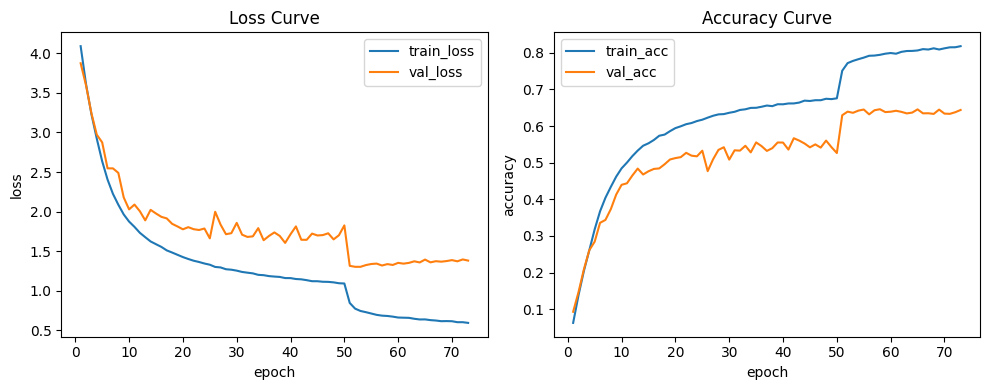

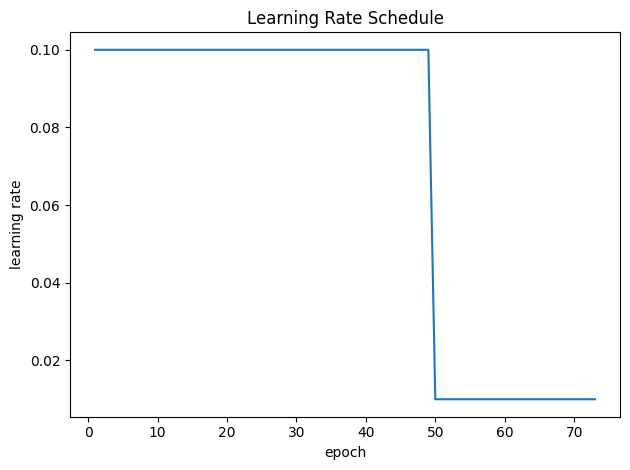


=== ResNet20 Test Result ===
Accuracy: 0.6527
F1 Score: 0.6523
Loss    : 1.2915
Trainable Params: 278,324


In [16]:
model_res = build_resnet20().to(device) # 1-B
criterion = nn.CrossEntropyLoss()
# PlainNet과 동일한 설정 사용 (공정한 비교)
# weight_decay=1e-4: 과적합을 막되, 학습을 방해하지 않는 적절한 규제값
optimizer = optim.SGD(model_res.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# 학습률 스케줄러: 50, 75 epoch에서 학습률을 1/10로 줄임
# Early Stopping 전에 충분히 수렴할 수 있도록 앞당겨진 설정입니다.
scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

print("\n================ Train ResNet20 ================")
early_stopping(train_loader, val_loader, model_res, criterion, optimizer, scheduler,
               patience=20, save_path="resnet20_best.pth")

model_res.load_state_dict(torch.load("resnet20_best.pth"))
test_acc, test_f1, test_loss = evaluate(test_loader, model_res, criterion)

# 파라미터 수
res_params = sum(p.numel() for p in model_res.parameters() if p.requires_grad)

print("\n=== ResNet20 Test Result ===")
print("Accuracy:", round(test_acc,4))
print("F1 Score:", round(test_f1,4))
print("Loss    :", round(test_loss,4))
print("Trainable Params:", f"{res_params:,}")

result



```
================ Train ResNet20 ================
  0%|          | 1/200 [00:20<1:09:25, 20.93s/it]epoch:0   train_loss=4.0843 train_acc=0.0677 val_loss=3.8502 val_acc=0.0860 val_f1=0.0557 lr=0.1
  1%|          | 2/200 [00:42<1:11:02, 21.53s/it]epoch:1   train_loss=3.6245 train_acc=0.1345 val_loss=3.5599 val_acc=0.1442 val_f1=0.1197 lr=0.1
  2%|▏         | 3/200 [01:03<1:09:34, 21.19s/it]epoch:2   train_loss=3.2703 train_acc=0.1975 val_loss=3.1659 val_acc=0.2262 val_f1=0.2034 lr=0.1
  2%|▏         | 4/200 [01:23<1:07:30, 20.67s/it]epoch:3   train_loss=2.9591 train_acc=0.2553 val_loss=2.9960 val_acc=0.2464 val_f1=0.2300 lr=0.1
  2%|▎         | 5/200 [01:44<1:07:20, 20.72s/it]epoch:4   train_loss=2.6918 train_acc=0.3080 val_loss=2.8120 val_acc=0.2922 val_f1=0.2751 lr=0.1
  3%|▎         | 6/200 [02:11<1:14:07, 22.92s/it]epoch:5   train_loss=2.4467 train_acc=0.3576 val_loss=2.5512 val_acc=0.3308 val_f1=0.3185 lr=0.1
  4%|▎         | 7/200 [02:32<1:11:32, 22.24s/it]epoch:6   train_loss=2.2529 train_acc=0.3937 val_loss=2.3129 val_acc=0.3906 val_f1=0.3706 lr=0.1
  4%|▍         | 8/200 [02:52<1:08:53, 21.53s/it]epoch:7   train_loss=2.0973 train_acc=0.4330 val_loss=2.3445 val_acc=0.3816 val_f1=0.3604 lr=0.1
  4%|▍         | 9/200 [03:14<1:08:47, 21.61s/it]epoch:8   train_loss=1.9733 train_acc=0.4627 val_loss=2.1681 val_acc=0.4192 val_f1=0.4096 lr=0.1
  5%|▌         | 10/200 [03:34<1:07:28, 21.31s/it]epoch:9   train_loss=1.8695 train_acc=0.4865 val_loss=2.1928 val_acc=0.4242 val_f1=0.4169 lr=0.1
  6%|▌         | 11/200 [03:55<1:06:15, 21.04s/it]epoch:10  train_loss=1.7925 train_acc=0.5060 val_loss=2.0917 val_acc=0.4452 val_f1=0.4377 lr=0.1
  6%|▌         | 12/200 [04:16<1:06:06, 21.10s/it]epoch:11  train_loss=1.7376 train_acc=0.5188 val_loss=2.0150 val_acc=0.4564 val_f1=0.4575 lr=0.1
  6%|▋         | 13/200 [04:36<1:05:03, 20.87s/it]epoch:12  train_loss=1.6748 train_acc=0.5309 val_loss=2.2595 val_acc=0.4172 val_f1=0.4111 lr=0.1
  7%|▋         | 14/200 [04:57<1:04:12, 20.71s/it]epoch:13  train_loss=1.6237 train_acc=0.5440 val_loss=1.8454 val_acc=0.4916 val_f1=0.4819 lr=0.1
  8%|▊         | 15/200 [05:17<1:03:58, 20.75s/it]epoch:14  train_loss=1.5861 train_acc=0.5545 val_loss=1.9811 val_acc=0.4666 val_f1=0.4676 lr=0.1
  8%|▊         | 16/200 [05:38<1:03:01, 20.55s/it]epoch:15  train_loss=1.5502 train_acc=0.5645 val_loss=1.8925 val_acc=0.4804 val_f1=0.4795 lr=0.1
  8%|▊         | 17/200 [05:58<1:02:52, 20.61s/it]epoch:16  train_loss=1.5172 train_acc=0.5688 val_loss=1.9152 val_acc=0.4772 val_f1=0.4737 lr=0.1
  9%|▉         | 18/200 [06:19<1:02:47, 20.70s/it]epoch:17  train_loss=1.4820 train_acc=0.5808 val_loss=1.9053 val_acc=0.4886 val_f1=0.4857 lr=0.1
 10%|▉         | 19/200 [06:39<1:01:51, 20.51s/it]epoch:18  train_loss=1.4506 train_acc=0.5861 val_loss=1.7647 val_acc=0.5148 val_f1=0.5109 lr=0.1
 10%|█         | 20/200 [07:00<1:01:40, 20.56s/it]epoch:19  train_loss=1.4325 train_acc=0.5934 val_loss=1.8306 val_acc=0.4960 val_f1=0.4920 lr=0.1
 10%|█         | 21/200 [07:20<1:00:56, 20.43s/it]epoch:20  train_loss=1.4059 train_acc=0.5967 val_loss=1.7214 val_acc=0.5246 val_f1=0.5196 lr=0.1
 11%|█         | 22/200 [07:41<1:01:06, 20.60s/it]epoch:21  train_loss=1.3884 train_acc=0.6020 val_loss=1.8152 val_acc=0.5088 val_f1=0.5132 lr=0.1
 12%|█▏        | 23/200 [08:03<1:01:32, 20.86s/it]epoch:22  train_loss=1.3677 train_acc=0.6084 val_loss=1.7053 val_acc=0.5278 val_f1=0.5238 lr=0.1
 12%|█▏        | 24/200 [08:23<1:00:27, 20.61s/it]epoch:23  train_loss=1.3532 train_acc=0.6105 val_loss=1.8096 val_acc=0.5144 val_f1=0.5097 lr=0.1
 12%|█▎        | 25/200 [08:43<1:00:20, 20.69s/it]epoch:24  train_loss=1.3273 train_acc=0.6173 val_loss=1.7213 val_acc=0.5332 val_f1=0.5314 lr=0.1
 13%|█▎        | 26/200 [09:04<59:53, 20.65s/it]  epoch:25  train_loss=1.3087 train_acc=0.6227 val_loss=1.7018 val_acc=0.5260 val_f1=0.5218 lr=0.1
 14%|█▎        | 27/200 [09:24<59:05, 20.50s/it]epoch:26  train_loss=1.2966 train_acc=0.6258 val_loss=1.8073 val_acc=0.5228 val_f1=0.5106 lr=0.1
 14%|█▍        | 28/200 [09:45<58:51, 20.53s/it]epoch:27  train_loss=1.2883 train_acc=0.6278 val_loss=1.8570 val_acc=0.5116 val_f1=0.5088 lr=0.1
 14%|█▍        | 29/200 [10:05<57:55, 20.33s/it]epoch:28  train_loss=1.2728 train_acc=0.6321 val_loss=1.7678 val_acc=0.5246 val_f1=0.5214 lr=0.1
 15%|█▌        | 30/200 [10:25<57:48, 20.40s/it]epoch:29  train_loss=1.2504 train_acc=0.6378 val_loss=1.8163 val_acc=0.5226 val_f1=0.5180 lr=0.1
 16%|█▌        | 31/200 [10:46<57:31, 20.42s/it]epoch:30  train_loss=1.2419 train_acc=0.6387 val_loss=1.7356 val_acc=0.5280 val_f1=0.5263 lr=0.1
 16%|█▌        | 32/200 [11:05<56:29, 20.18s/it]epoch:31  train_loss=1.2411 train_acc=0.6400 val_loss=1.7003 val_acc=0.5366 val_f1=0.5309 lr=0.1
 16%|█▋        | 33/200 [11:26<56:51, 20.43s/it]epoch:32  train_loss=1.2161 train_acc=0.6458 val_loss=1.7838 val_acc=0.5292 val_f1=0.5248 lr=0.1
 17%|█▋        | 34/200 [11:46<56:05, 20.27s/it]epoch:33  train_loss=1.2154 train_acc=0.6472 val_loss=1.7503 val_acc=0.5344 val_f1=0.5359 lr=0.1
 18%|█▊        | 35/200 [12:06<55:41, 20.25s/it]epoch:34  train_loss=1.1994 train_acc=0.6486 val_loss=1.7393 val_acc=0.5420 val_f1=0.5366 lr=0.1
 18%|█▊        | 36/200 [12:27<55:36, 20.35s/it]epoch:35  train_loss=1.1913 train_acc=0.6513 val_loss=1.9204 val_acc=0.5032 val_f1=0.4919 lr=0.1
 18%|█▊        | 37/200 [12:48<55:31, 20.44s/it]epoch:36  train_loss=1.1765 train_acc=0.6573 val_loss=1.7620 val_acc=0.5268 val_f1=0.5323 lr=0.1
 19%|█▉        | 38/200 [13:08<55:19, 20.49s/it]epoch:37  train_loss=1.1742 train_acc=0.6565 val_loss=1.6997 val_acc=0.5366 val_f1=0.5338 lr=0.1
 20%|█▉        | 39/200 [13:29<55:00, 20.50s/it]epoch:38  train_loss=1.1686 train_acc=0.6569 val_loss=1.8302 val_acc=0.5202 val_f1=0.5200 lr=0.1
 20%|██        | 40/200 [13:49<54:25, 20.41s/it]epoch:39  train_loss=1.1562 train_acc=0.6594 val_loss=1.8217 val_acc=0.5352 val_f1=0.5287 lr=0.1
 20%|██        | 41/200 [14:10<54:15, 20.48s/it]epoch:40  train_loss=1.1544 train_acc=0.6628 val_loss=1.7862 val_acc=0.5304 val_f1=0.5326 lr=0.1
 21%|██        | 42/200 [14:30<53:48, 20.44s/it]epoch:41  train_loss=1.1445 train_acc=0.6630 val_loss=1.6995 val_acc=0.5576 val_f1=0.5542 lr=0.1
 22%|██▏       | 43/200 [14:50<53:28, 20.44s/it]epoch:42  train_loss=1.1389 train_acc=0.6652 val_loss=1.6673 val_acc=0.5550 val_f1=0.5506 lr=0.1
 22%|██▏       | 44/200 [15:11<53:05, 20.42s/it]epoch:43  train_loss=1.1353 train_acc=0.6688 val_loss=1.6707 val_acc=0.5574 val_f1=0.5555 lr=0.1
 22%|██▎       | 45/200 [15:31<52:24, 20.29s/it]epoch:44  train_loss=1.1245 train_acc=0.6689 val_loss=1.7731 val_acc=0.5246 val_f1=0.5228 lr=0.1
 23%|██▎       | 46/200 [15:51<52:20, 20.40s/it]epoch:45  train_loss=1.1188 train_acc=0.6726 val_loss=1.7268 val_acc=0.5512 val_f1=0.5500 lr=0.1
 24%|██▎       | 47/200 [16:12<52:13, 20.48s/it]epoch:46  train_loss=1.1148 train_acc=0.6692 val_loss=1.6362 val_acc=0.5618 val_f1=0.5572 lr=0.1
 24%|██▍       | 48/200 [16:32<51:37, 20.38s/it]epoch:47  train_loss=1.1018 train_acc=0.6767 val_loss=1.5885 val_acc=0.5628 val_f1=0.5650 lr=0.1
 24%|██▍       | 49/200 [16:53<51:33, 20.49s/it]epoch:48  train_loss=1.0932 train_acc=0.6758 val_loss=1.7257 val_acc=0.5374 val_f1=0.5392 lr=0.1
 25%|██▌       | 50/200 [17:13<50:45, 20.30s/it]epoch:49  train_loss=1.0980 train_acc=0.6751 val_loss=1.9680 val_acc=0.5142 val_f1=0.5090 lr=0.010000000000000002
 26%|██▌       | 51/200 [17:33<50:38, 20.39s/it]epoch:50  train_loss=0.8453 train_acc=0.7503 val_loss=1.3159 val_acc=0.6312 val_f1=0.6288 lr=0.010000000000000002
 26%|██▌       | 52/200 [17:55<51:07, 20.73s/it]epoch:51  train_loss=0.7721 train_acc=0.7712 val_loss=1.3062 val_acc=0.6394 val_f1=0.6376 lr=0.010000000000000002
 26%|██▋       | 53/200 [18:15<50:01, 20.42s/it]epoch:52  train_loss=0.7493 train_acc=0.7755 val_loss=1.2889 val_acc=0.6372 val_f1=0.6370 lr=0.010000000000000002
 27%|██▋       | 54/200 [18:35<49:54, 20.51s/it]epoch:53  train_loss=0.7258 train_acc=0.7836 val_loss=1.3103 val_acc=0.6446 val_f1=0.6452 lr=0.010000000000000002
 28%|██▊       | 55/200 [18:56<49:32, 20.50s/it]epoch:54  train_loss=0.7136 train_acc=0.7863 val_loss=1.3005 val_acc=0.6352 val_f1=0.6341 lr=0.010000000000000002
 28%|██▊       | 56/200 [19:15<48:33, 20.23s/it]epoch:55  train_loss=0.7062 train_acc=0.7899 val_loss=1.3218 val_acc=0.6370 val_f1=0.6375 lr=0.010000000000000002
 28%|██▊       | 57/200 [19:36<48:35, 20.39s/it]epoch:56  train_loss=0.6898 train_acc=0.7922 val_loss=1.3124 val_acc=0.6426 val_f1=0.6411 lr=0.010000000000000002
 29%|██▉       | 58/200 [19:56<47:45, 20.18s/it]epoch:57  train_loss=0.6789 train_acc=0.7948 val_loss=1.3227 val_acc=0.6408 val_f1=0.6384 lr=0.010000000000000002
 30%|██▉       | 59/200 [20:16<47:38, 20.27s/it]epoch:58  train_loss=0.6733 train_acc=0.7985 val_loss=1.3206 val_acc=0.6410 val_f1=0.6416 lr=0.010000000000000002
 30%|███       | 60/200 [20:37<47:32, 20.37s/it]epoch:59  train_loss=0.6617 train_acc=0.8013 val_loss=1.3335 val_acc=0.6330 val_f1=0.6319 lr=0.010000000000000002
 30%|███       | 61/200 [20:57<46:57, 20.27s/it]epoch:60  train_loss=0.6588 train_acc=0.8011 val_loss=1.3216 val_acc=0.6476 val_f1=0.6468 lr=0.010000000000000002
 31%|███       | 62/200 [21:18<46:53, 20.39s/it]epoch:61  train_loss=0.6479 train_acc=0.8054 val_loss=1.3631 val_acc=0.6350 val_f1=0.6324 lr=0.010000000000000002
 32%|███▏      | 63/200 [21:38<46:20, 20.30s/it]epoch:62  train_loss=0.6447 train_acc=0.8047 val_loss=1.3485 val_acc=0.6384 val_f1=0.6382 lr=0.010000000000000002
 32%|███▏      | 64/200 [21:58<46:02, 20.31s/it]epoch:63  train_loss=0.6390 train_acc=0.8050 val_loss=1.3575 val_acc=0.6422 val_f1=0.6396 lr=0.010000000000000002
 32%|███▎      | 65/200 [22:19<46:00, 20.45s/it]epoch:64  train_loss=0.6330 train_acc=0.8092 val_loss=1.3776 val_acc=0.6310 val_f1=0.6305 lr=0.010000000000000002
 33%|███▎      | 66/200 [22:39<45:27, 20.36s/it]epoch:65  train_loss=0.6318 train_acc=0.8048 val_loss=1.3334 val_acc=0.6384 val_f1=0.6376 lr=0.010000000000000002
 34%|███▎      | 67/200 [23:01<46:06, 20.80s/it]epoch:66  train_loss=0.6234 train_acc=0.8110 val_loss=1.3688 val_acc=0.6348 val_f1=0.6334 lr=0.010000000000000002
 34%|███▍      | 68/200 [23:22<45:39, 20.76s/it]epoch:67  train_loss=0.6180 train_acc=0.8115 val_loss=1.3873 val_acc=0.6378 val_f1=0.6368 lr=0.010000000000000002
 34%|███▍      | 69/200 [23:41<44:46, 20.51s/it]epoch:68  train_loss=0.6137 train_acc=0.8126 val_loss=1.3936 val_acc=0.6354 val_f1=0.6346 lr=0.010000000000000002
 35%|███▌      | 70/200 [24:02<44:37, 20.60s/it]epoch:69  train_loss=0.6091 train_acc=0.8125 val_loss=1.4113 val_acc=0.6380 val_f1=0.6379 lr=0.010000000000000002
 36%|███▌      | 71/200 [24:22<43:54, 20.42s/it]epoch:70  train_loss=0.6021 train_acc=0.8153 val_loss=1.4011 val_acc=0.6338 val_f1=0.6336 lr=0.010000000000000002
 36%|███▌      | 72/200 [24:43<43:36, 20.44s/it]epoch:71  train_loss=0.6023 train_acc=0.8151 val_loss=1.3923 val_acc=0.6292 val_f1=0.6293 lr=0.010000000000000002
 36%|███▌      | 72/200 [25:03<44:33, 20.89s/it]epoch:72  train_loss=0.5990 train_acc=0.8158 val_loss=1.3718 val_acc=0.6396 val_f1=0.6383 lr=0.010000000000000002
Early stopping!


=== ResNet20 Test Result ===
Accuracy: 0.6498
F1 Score: 0.6491
Loss    : 1.3056
Trainable Params: 278,324
```



In [ ]:
# learning curve

### 문제 2. Pretrained Model 학습

`resnet20`의 pretrained model를 불러와 2개의 모델을 구현 및 학습 후 최종 성능을 도출하세요.

| 항목                         | CNN_Frozen Model                 | BatchNorm Activate Model           |
| -------------------------- | -------------------------------- | ---------------------------------- |
| 사용 모델                      | **Pretrained CIFAR100 ResNet20** | 동일                                 |
| Frozen 대상                  | 모든 CNN layer (Conv + BN 포함)      | Conv만 Frozen, **BN은 학습 가능**        |
| `.requires_grad = True` 대상 | 마지막 FC만                          | BN + FC                            |
|

- **두 모델 모두 test acc 0.6 이상 달성**
- https://pytorch.org/vision/stable/models.html 참고

In [17]:
import torch
import torch.nn as nn

def resnet20_pretrained(num_classes: int = 100, train_bn_fc_only: bool = False):

    model = torch.hub.load(
        "chenyaofo/pytorch-cifar-models",
        "cifar100_resnet20",
        pretrained=True
    )

    in_feat = model.fc.in_features
    model.fc = nn.Linear(in_feat, num_classes)

    if not train_bn_fc_only:
        # 2-A — feature extractor mode: fc 제외 전체 freeze
        for name, param in model.named_parameters():
            if not name.startswith("fc"):
                param.requires_grad = False
    else:
        # 2-B — partial fine-tune: BN + FC만 학습
        for name, param in model.named_parameters():
            if ("bn" in name.lower()) or name.startswith("fc"):
                param.requires_grad = True
            else:
                param.requires_grad = False

    return model


In [18]:
pt_fixed = resnet20_pretrained(num_classes=100, train_bn_fc_only=False) # 2-A
pt_partial = resnet20_pretrained(num_classes=100, train_bn_fc_only=True) # 2-B

/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet20-23dac2f1.pt" to /root/.cache/torch/hub/checkpoints/cifar100_resnet20-23dac2f1.pt


100%|██████████| 1.11M/1.11M [00:00<00:00, 24.3MB/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


result



```
/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet20-23dac2f1.pt" to /root/.cache/torch/hub/checkpoints/cifar100_resnet20-23dac2f1.pt
100%|██████████| 1.11M/1.11M [00:00<00:00, 171MB/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
```




================ Train Pretrained-ResNet20 (fixed) ================


  0%|          | 1/200 [00:10<36:02, 10.87s/it]

epoch:0   train_loss=0.7202 train_acc=0.8023 val_loss=0.4046 val_acc=0.8780 val_f1=0.8772 lr=0.1


  1%|          | 2/200 [00:21<34:26, 10.44s/it]

epoch:1   train_loss=0.3859 train_acc=0.8777 val_loss=0.3338 val_acc=0.8946 val_f1=0.8950 lr=0.1


  2%|▏         | 3/200 [00:31<34:05, 10.39s/it]

epoch:2   train_loss=0.3584 train_acc=0.8849 val_loss=0.3294 val_acc=0.8918 val_f1=0.8912 lr=0.1


  2%|▏         | 4/200 [00:41<34:11, 10.46s/it]

epoch:3   train_loss=0.3532 train_acc=0.8854 val_loss=0.3113 val_acc=0.9028 val_f1=0.9030 lr=0.1


  2%|▎         | 5/200 [00:52<34:14, 10.54s/it]

epoch:4   train_loss=0.3369 train_acc=0.8923 val_loss=0.3222 val_acc=0.8936 val_f1=0.8933 lr=0.1


  3%|▎         | 6/200 [01:02<33:25, 10.34s/it]

epoch:5   train_loss=0.3375 train_acc=0.8902 val_loss=0.2899 val_acc=0.9050 val_f1=0.9054 lr=0.1


  4%|▎         | 7/200 [01:12<32:42, 10.17s/it]

epoch:6   train_loss=0.3364 train_acc=0.8896 val_loss=0.2838 val_acc=0.9048 val_f1=0.9043 lr=0.1


  4%|▍         | 8/200 [01:22<32:16, 10.08s/it]

epoch:7   train_loss=0.3354 train_acc=0.8900 val_loss=0.3164 val_acc=0.8960 val_f1=0.8971 lr=0.1


  4%|▍         | 9/200 [01:32<31:47,  9.99s/it]

epoch:8   train_loss=0.3354 train_acc=0.8902 val_loss=0.2985 val_acc=0.9036 val_f1=0.9037 lr=0.1


  5%|▌         | 10/200 [01:42<31:50, 10.05s/it]

epoch:9   train_loss=0.3280 train_acc=0.8923 val_loss=0.3017 val_acc=0.9038 val_f1=0.9031 lr=0.1


  6%|▌         | 11/200 [01:52<31:26,  9.98s/it]

epoch:10  train_loss=0.3326 train_acc=0.8905 val_loss=0.2977 val_acc=0.9064 val_f1=0.9066 lr=0.1


  6%|▌         | 12/200 [02:01<31:04,  9.92s/it]

epoch:11  train_loss=0.3341 train_acc=0.8908 val_loss=0.2961 val_acc=0.9054 val_f1=0.9054 lr=0.1


  6%|▋         | 13/200 [02:11<30:48,  9.89s/it]

epoch:12  train_loss=0.3229 train_acc=0.8931 val_loss=0.3004 val_acc=0.9040 val_f1=0.9045 lr=0.1


  7%|▋         | 14/200 [02:21<30:37,  9.88s/it]

epoch:13  train_loss=0.3295 train_acc=0.8910 val_loss=0.3099 val_acc=0.8994 val_f1=0.8992 lr=0.1


  8%|▊         | 15/200 [02:31<30:37,  9.93s/it]

epoch:14  train_loss=0.3310 train_acc=0.8910 val_loss=0.2876 val_acc=0.9044 val_f1=0.9049 lr=0.1


  8%|▊         | 16/200 [02:41<30:19,  9.89s/it]

epoch:15  train_loss=0.3363 train_acc=0.8902 val_loss=0.3059 val_acc=0.9002 val_f1=0.9008 lr=0.1


  8%|▊         | 17/200 [02:51<30:05,  9.86s/it]

epoch:16  train_loss=0.3240 train_acc=0.8936 val_loss=0.2817 val_acc=0.9054 val_f1=0.9056 lr=0.1


  9%|▉         | 18/200 [03:01<30:11,  9.95s/it]

epoch:17  train_loss=0.3270 train_acc=0.8927 val_loss=0.2936 val_acc=0.9092 val_f1=0.9093 lr=0.1


 10%|▉         | 19/200 [03:11<29:52,  9.90s/it]

epoch:18  train_loss=0.3291 train_acc=0.8900 val_loss=0.3254 val_acc=0.8964 val_f1=0.8960 lr=0.1


 10%|█         | 20/200 [03:20<29:32,  9.85s/it]

epoch:19  train_loss=0.3255 train_acc=0.8920 val_loss=0.3077 val_acc=0.8964 val_f1=0.8965 lr=0.1


 10%|█         | 21/200 [03:30<29:28,  9.88s/it]

epoch:20  train_loss=0.3236 train_acc=0.8938 val_loss=0.3058 val_acc=0.9008 val_f1=0.9005 lr=0.1


 11%|█         | 22/200 [03:40<29:15,  9.86s/it]

epoch:21  train_loss=0.3229 train_acc=0.8936 val_loss=0.2950 val_acc=0.9044 val_f1=0.9046 lr=0.1


 12%|█▏        | 23/200 [03:50<29:01,  9.84s/it]

epoch:22  train_loss=0.3186 train_acc=0.8959 val_loss=0.2837 val_acc=0.9078 val_f1=0.9077 lr=0.1


 12%|█▏        | 24/200 [04:00<28:52,  9.84s/it]

epoch:23  train_loss=0.3267 train_acc=0.8927 val_loss=0.2832 val_acc=0.9072 val_f1=0.9069 lr=0.1


 12%|█▎        | 25/200 [04:10<28:41,  9.84s/it]

epoch:24  train_loss=0.3260 train_acc=0.8919 val_loss=0.2990 val_acc=0.9008 val_f1=0.9005 lr=0.1


 13%|█▎        | 26/200 [04:20<28:52,  9.96s/it]

epoch:25  train_loss=0.3269 train_acc=0.8919 val_loss=0.2977 val_acc=0.9020 val_f1=0.9014 lr=0.1


 14%|█▎        | 27/200 [04:30<28:30,  9.89s/it]

epoch:26  train_loss=0.3265 train_acc=0.8925 val_loss=0.3177 val_acc=0.8970 val_f1=0.8972 lr=0.1


 14%|█▍        | 28/200 [04:39<28:13,  9.85s/it]

epoch:27  train_loss=0.3235 train_acc=0.8940 val_loss=0.3096 val_acc=0.9016 val_f1=0.9016 lr=0.1


 14%|█▍        | 29/200 [04:49<27:56,  9.81s/it]

epoch:28  train_loss=0.3276 train_acc=0.8918 val_loss=0.3135 val_acc=0.8964 val_f1=0.8965 lr=0.1


 15%|█▌        | 30/200 [04:59<27:35,  9.74s/it]

epoch:29  train_loss=0.3215 train_acc=0.8944 val_loss=0.2953 val_acc=0.9024 val_f1=0.9024 lr=0.010000000000000002


 16%|█▌        | 31/200 [05:08<27:30,  9.77s/it]

epoch:30  train_loss=0.2809 train_acc=0.9093 val_loss=0.2585 val_acc=0.9158 val_f1=0.9161 lr=0.010000000000000002


 16%|█▌        | 32/200 [05:19<27:56,  9.98s/it]

epoch:31  train_loss=0.2685 train_acc=0.9124 val_loss=0.2460 val_acc=0.9214 val_f1=0.9215 lr=0.010000000000000002


 16%|█▋        | 33/200 [05:29<27:30,  9.88s/it]

epoch:32  train_loss=0.2721 train_acc=0.9105 val_loss=0.2751 val_acc=0.9108 val_f1=0.9102 lr=0.010000000000000002


 17%|█▋        | 34/200 [05:38<27:11,  9.83s/it]

epoch:33  train_loss=0.2710 train_acc=0.9106 val_loss=0.2609 val_acc=0.9200 val_f1=0.9203 lr=0.010000000000000002


 18%|█▊        | 35/200 [05:48<26:56,  9.80s/it]

epoch:34  train_loss=0.2650 train_acc=0.9144 val_loss=0.2446 val_acc=0.9186 val_f1=0.9188 lr=0.010000000000000002


 18%|█▊        | 36/200 [05:58<26:41,  9.76s/it]

epoch:35  train_loss=0.2684 train_acc=0.9107 val_loss=0.2494 val_acc=0.9160 val_f1=0.9155 lr=0.010000000000000002


 18%|█▊        | 37/200 [06:08<26:37,  9.80s/it]

epoch:36  train_loss=0.2691 train_acc=0.9123 val_loss=0.2630 val_acc=0.9136 val_f1=0.9136 lr=0.010000000000000002


 19%|█▉        | 38/200 [06:17<26:20,  9.76s/it]

epoch:37  train_loss=0.2691 train_acc=0.9121 val_loss=0.2422 val_acc=0.9238 val_f1=0.9237 lr=0.010000000000000002


 20%|█▉        | 39/200 [06:27<26:06,  9.73s/it]

epoch:38  train_loss=0.2706 train_acc=0.9122 val_loss=0.2712 val_acc=0.9166 val_f1=0.9163 lr=0.010000000000000002


 20%|██        | 40/200 [06:37<26:12,  9.83s/it]

epoch:39  train_loss=0.2668 train_acc=0.9131 val_loss=0.2624 val_acc=0.9174 val_f1=0.9171 lr=0.010000000000000002


 20%|██        | 41/200 [06:47<26:06,  9.85s/it]

epoch:40  train_loss=0.2685 train_acc=0.9128 val_loss=0.2577 val_acc=0.9198 val_f1=0.9193 lr=0.010000000000000002


 21%|██        | 42/200 [06:57<25:51,  9.82s/it]

epoch:41  train_loss=0.2676 train_acc=0.9129 val_loss=0.2538 val_acc=0.9186 val_f1=0.9187 lr=0.010000000000000002


 22%|██▏       | 43/200 [07:06<25:41,  9.82s/it]

epoch:42  train_loss=0.2681 train_acc=0.9124 val_loss=0.2535 val_acc=0.9176 val_f1=0.9174 lr=0.010000000000000002


 22%|██▏       | 44/200 [07:16<25:25,  9.78s/it]

epoch:43  train_loss=0.2700 train_acc=0.9129 val_loss=0.2647 val_acc=0.9162 val_f1=0.9167 lr=0.010000000000000002


 22%|██▎       | 45/200 [07:26<25:06,  9.72s/it]

epoch:44  train_loss=0.2725 train_acc=0.9108 val_loss=0.2554 val_acc=0.9190 val_f1=0.9193 lr=0.010000000000000002


 23%|██▎       | 46/200 [07:35<24:57,  9.73s/it]

epoch:45  train_loss=0.2685 train_acc=0.9122 val_loss=0.2671 val_acc=0.9178 val_f1=0.9179 lr=0.010000000000000002


 24%|██▎       | 47/200 [07:45<24:48,  9.73s/it]

epoch:46  train_loss=0.2709 train_acc=0.9120 val_loss=0.2453 val_acc=0.9198 val_f1=0.9197 lr=0.010000000000000002


 24%|██▍       | 48/200 [07:55<24:56,  9.85s/it]

epoch:47  train_loss=0.2672 train_acc=0.9138 val_loss=0.2519 val_acc=0.9158 val_f1=0.9158 lr=0.010000000000000002


 24%|██▍       | 49/200 [08:05<24:38,  9.79s/it]

epoch:48  train_loss=0.2669 train_acc=0.9136 val_loss=0.2429 val_acc=0.9208 val_f1=0.9208 lr=0.010000000000000002


 25%|██▌       | 50/200 [08:15<24:31,  9.81s/it]

epoch:49  train_loss=0.2697 train_acc=0.9126 val_loss=0.2647 val_acc=0.9158 val_f1=0.9159 lr=0.010000000000000002


 26%|██▌       | 51/200 [08:25<24:23,  9.82s/it]

epoch:50  train_loss=0.2692 train_acc=0.9119 val_loss=0.2587 val_acc=0.9122 val_f1=0.9114 lr=0.010000000000000002


 26%|██▌       | 52/200 [08:35<24:26,  9.91s/it]

epoch:51  train_loss=0.2681 train_acc=0.9142 val_loss=0.2587 val_acc=0.9182 val_f1=0.9180 lr=0.010000000000000002


 26%|██▋       | 53/200 [08:44<24:06,  9.84s/it]

epoch:52  train_loss=0.2686 train_acc=0.9128 val_loss=0.2553 val_acc=0.9168 val_f1=0.9172 lr=0.010000000000000002


 27%|██▋       | 54/200 [08:55<24:08,  9.92s/it]

epoch:53  train_loss=0.2731 train_acc=0.9110 val_loss=0.2589 val_acc=0.9190 val_f1=0.9188 lr=0.010000000000000002


 28%|██▊       | 55/200 [09:04<23:55,  9.90s/it]

epoch:54  train_loss=0.2651 train_acc=0.9141 val_loss=0.2407 val_acc=0.9210 val_f1=0.9211 lr=0.010000000000000002


 28%|██▊       | 56/200 [09:14<23:37,  9.84s/it]

epoch:55  train_loss=0.2695 train_acc=0.9128 val_loss=0.2626 val_acc=0.9182 val_f1=0.9181 lr=0.010000000000000002


 28%|██▊       | 57/200 [09:24<23:25,  9.83s/it]

epoch:56  train_loss=0.2676 train_acc=0.9137 val_loss=0.2600 val_acc=0.9166 val_f1=0.9169 lr=0.010000000000000002


 29%|██▉       | 58/200 [09:34<23:13,  9.81s/it]

epoch:57  train_loss=0.2673 train_acc=0.9126 val_loss=0.2565 val_acc=0.9188 val_f1=0.9179 lr=0.010000000000000002


 30%|██▉       | 59/200 [09:43<22:59,  9.78s/it]

epoch:58  train_loss=0.2734 train_acc=0.9112 val_loss=0.2616 val_acc=0.9152 val_f1=0.9154 lr=0.010000000000000002


 30%|███       | 60/200 [09:53<23:00,  9.86s/it]

epoch:59  train_loss=0.2743 train_acc=0.9110 val_loss=0.2568 val_acc=0.9186 val_f1=0.9189 lr=0.0010000000000000002


 30%|███       | 61/200 [10:04<23:17, 10.05s/it]

epoch:60  train_loss=0.2640 train_acc=0.9147 val_loss=0.2646 val_acc=0.9164 val_f1=0.9158 lr=0.0010000000000000002


 31%|███       | 62/200 [10:14<22:57,  9.98s/it]

epoch:61  train_loss=0.2636 train_acc=0.9145 val_loss=0.2504 val_acc=0.9216 val_f1=0.9213 lr=0.0010000000000000002


 32%|███▏      | 63/200 [10:24<22:43,  9.95s/it]

epoch:62  train_loss=0.2657 train_acc=0.9145 val_loss=0.2472 val_acc=0.9232 val_f1=0.9229 lr=0.0010000000000000002


 32%|███▏      | 64/200 [10:34<22:41, 10.01s/it]

epoch:63  train_loss=0.2679 train_acc=0.9132 val_loss=0.2575 val_acc=0.9196 val_f1=0.9195 lr=0.0010000000000000002


 32%|███▎      | 65/200 [10:43<22:14,  9.89s/it]

epoch:64  train_loss=0.2635 train_acc=0.9159 val_loss=0.2671 val_acc=0.9176 val_f1=0.9173 lr=0.0010000000000000002


 33%|███▎      | 66/200 [10:53<22:00,  9.86s/it]

epoch:65  train_loss=0.2686 train_acc=0.9144 val_loss=0.2544 val_acc=0.9198 val_f1=0.9199 lr=0.0010000000000000002


 34%|███▎      | 67/200 [11:03<21:40,  9.78s/it]

epoch:66  train_loss=0.2642 train_acc=0.9152 val_loss=0.2402 val_acc=0.9268 val_f1=0.9261 lr=0.0010000000000000002


 34%|███▍      | 68/200 [11:13<21:34,  9.80s/it]

epoch:67  train_loss=0.2663 train_acc=0.9144 val_loss=0.2592 val_acc=0.9218 val_f1=0.9216 lr=0.0010000000000000002


 34%|███▍      | 69/200 [11:22<21:26,  9.82s/it]

epoch:68  train_loss=0.2638 train_acc=0.9143 val_loss=0.2624 val_acc=0.9188 val_f1=0.9189 lr=0.0010000000000000002


 35%|███▌      | 70/200 [11:33<21:36,  9.97s/it]

epoch:69  train_loss=0.2671 train_acc=0.9148 val_loss=0.2591 val_acc=0.9170 val_f1=0.9172 lr=0.0010000000000000002


 36%|███▌      | 71/200 [11:43<21:28,  9.99s/it]

epoch:70  train_loss=0.2646 train_acc=0.9148 val_loss=0.2500 val_acc=0.9200 val_f1=0.9198 lr=0.0010000000000000002


 36%|███▌      | 72/200 [11:53<21:12,  9.94s/it]

epoch:71  train_loss=0.2623 train_acc=0.9168 val_loss=0.2713 val_acc=0.9170 val_f1=0.9167 lr=0.0010000000000000002


 36%|███▋      | 73/200 [12:02<20:53,  9.87s/it]

epoch:72  train_loss=0.2630 train_acc=0.9165 val_loss=0.2627 val_acc=0.9162 val_f1=0.9164 lr=0.0010000000000000002


 37%|███▋      | 74/200 [12:12<20:45,  9.89s/it]

epoch:73  train_loss=0.2681 train_acc=0.9125 val_loss=0.2535 val_acc=0.9204 val_f1=0.9201 lr=0.0010000000000000002


 38%|███▊      | 75/200 [12:23<21:03, 10.11s/it]

epoch:74  train_loss=0.2666 train_acc=0.9136 val_loss=0.2604 val_acc=0.9214 val_f1=0.9215 lr=0.0010000000000000002


 38%|███▊      | 76/200 [12:33<20:46, 10.05s/it]

epoch:75  train_loss=0.2647 train_acc=0.9135 val_loss=0.2594 val_acc=0.9180 val_f1=0.9183 lr=0.0010000000000000002


 38%|███▊      | 77/200 [12:43<20:25,  9.96s/it]

epoch:76  train_loss=0.2667 train_acc=0.9140 val_loss=0.2411 val_acc=0.9224 val_f1=0.9221 lr=0.0010000000000000002


 39%|███▉      | 78/200 [12:52<20:08,  9.91s/it]

epoch:77  train_loss=0.2671 train_acc=0.9135 val_loss=0.2612 val_acc=0.9192 val_f1=0.9186 lr=0.0010000000000000002


 40%|███▉      | 79/200 [13:02<20:00,  9.92s/it]

epoch:78  train_loss=0.2653 train_acc=0.9144 val_loss=0.2561 val_acc=0.9128 val_f1=0.9125 lr=0.0010000000000000002


 40%|████      | 80/200 [13:12<19:42,  9.85s/it]

epoch:79  train_loss=0.2652 train_acc=0.9142 val_loss=0.2467 val_acc=0.9212 val_f1=0.9216 lr=0.0010000000000000002


 40%|████      | 81/200 [13:22<19:25,  9.80s/it]

epoch:80  train_loss=0.2667 train_acc=0.9147 val_loss=0.2472 val_acc=0.9206 val_f1=0.9204 lr=0.0010000000000000002


 41%|████      | 82/200 [13:32<19:28,  9.90s/it]

epoch:81  train_loss=0.2668 train_acc=0.9132 val_loss=0.2615 val_acc=0.9128 val_f1=0.9130 lr=0.0010000000000000002


 42%|████▏     | 83/200 [13:41<19:11,  9.84s/it]

epoch:82  train_loss=0.2649 train_acc=0.9136 val_loss=0.2559 val_acc=0.9174 val_f1=0.9169 lr=0.0010000000000000002


 42%|████▏     | 84/200 [13:51<19:05,  9.88s/it]

epoch:83  train_loss=0.2646 train_acc=0.9130 val_loss=0.2585 val_acc=0.9200 val_f1=0.9200 lr=0.0010000000000000002


 42%|████▎     | 85/200 [14:01<18:55,  9.88s/it]

epoch:84  train_loss=0.2672 train_acc=0.9129 val_loss=0.2474 val_acc=0.9234 val_f1=0.9234 lr=0.0010000000000000002


 43%|████▎     | 86/200 [14:11<18:46,  9.88s/it]

epoch:85  train_loss=0.2650 train_acc=0.9149 val_loss=0.2528 val_acc=0.9174 val_f1=0.9173 lr=0.0010000000000000002


 43%|████▎     | 86/200 [14:21<19:02, 10.02s/it]

epoch:86  train_loss=0.2676 train_acc=0.9138 val_loss=0.2633 val_acc=0.9152 val_f1=0.9153 lr=0.0010000000000000002
Early stopping!

[Learning Curve] Train Loss: [0.7201674572530795, 0.3858787400901995, 0.3584330525164577, 0.35315936067226256, 0.3369105030274527, 0.3374644107693298, 0.33639030738479714, 0.33541069958697667, 0.33538058133457194, 0.32799323356117716, 0.3325633385472677, 0.3340688750825145, 0.32286426437680016, 0.3294924584386701, 0.33098927555097774, 0.3363417003896426, 0.3240264782004736, 0.3270116161809049, 0.3291159974495796, 0.32554139294238255, 0.3236422622576356, 0.3228814361447638, 0.3185756580099802, 0.3267481421035799, 0.32599774726920505, 0.3269453706558455, 0.32647399773651903, 0.32352708889679477, 0.3275579286061905, 0.32150279446928337, 0.28090435020964255, 0.26849520769478247, 0.27213014840063726, 0.27102311950346286, 0.2650417402513664, 0.2684021502606232, 0.26906521446918225, 0.26911826800046995, 0.27059195296500216, 0.26681394345889037, 0.2684991896914487

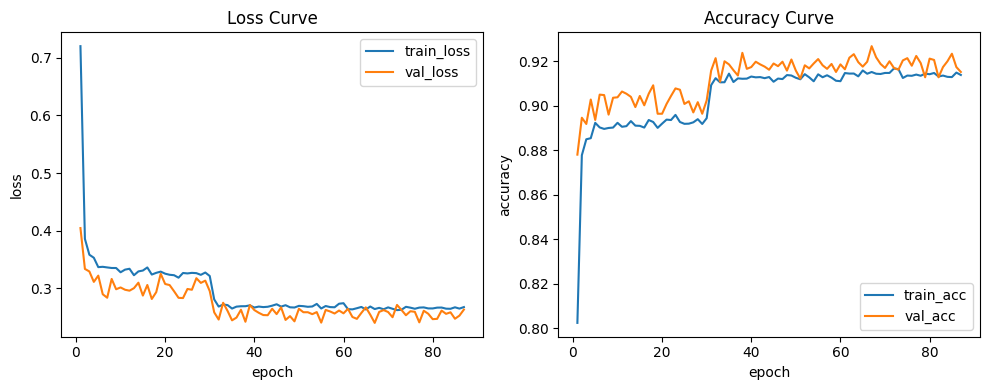

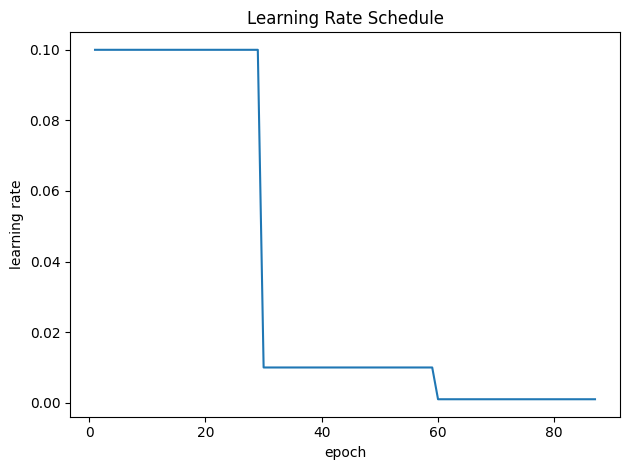


=== Pretrained-ResNet Test Result ===
Accuracy: 0.6844
F1 Score: 0.6843
Loss    : 1.5376
Trainable Params: 6,500


In [19]:
pt_fixed = pt_fixed.to(device)

# pt_fixed 학습
criterion = nn.CrossEntropyLoss()
# optimizer에는 requires_grad=True인 파라미터만 전달해야 효율적임
optimizer = optim.SGD(filter(lambda p: p.requires_grad, pt_fixed.parameters()),
                      lr=0.1, momentum=0.9, weight_decay=1e-4)
# 학습량이 적으므로 스케줄러도 조금 앞당겨 봅니다.
scheduler = MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)

print("\n================ Train Pretrained-ResNet20 (fixed) ================")
early_stopping(train_loader, val_loader, pt_fixed, criterion, optimizer, scheduler,
               patience=20, save_path="ptfixed_best.pth")

pt_fixed.load_state_dict(torch.load("ptfixed_best.pth"))
test_acc, test_f1, test_loss = evaluate(test_loader, pt_fixed, criterion)

pt_fixed_params = sum(p.numel() for p in pt_fixed.parameters() if p.requires_grad)

print("\n=== Pretrained-ResNet Test Result ===")
print("Accuracy:", round(test_acc,4))
print("F1 Score:", round(test_f1,4))
print("Loss    :", round(test_loss,4))
print("Trainable Params:", f"{pt_fixed_params:,}")

result



```
================ Train Pretrained-ResNet20 (fixed) ================
  0%|          | 1/200 [00:18<1:00:01, 18.10s/it]epoch:0   train_loss=0.7114 train_acc=0.8072 val_loss=0.3610 val_acc=0.8876 val_f1=0.8875 lr=0.1
  1%|          | 2/200 [00:34<57:03, 17.29s/it]  epoch:1   train_loss=0.3889 train_acc=0.8766 val_loss=0.3341 val_acc=0.8968 val_f1=0.8966 lr=0.1
  2%|▏         | 3/200 [00:52<56:56, 17.34s/it]epoch:2   train_loss=0.3601 train_acc=0.8847 val_loss=0.3039 val_acc=0.9032 val_f1=0.9031 lr=0.1
  2%|▏         | 4/200 [01:09<56:02, 17.16s/it]epoch:3   train_loss=0.3450 train_acc=0.8881 val_loss=0.2938 val_acc=0.9046 val_f1=0.9050 lr=0.1
  2%|▎         | 5/200 [01:25<55:25, 17.06s/it]epoch:4   train_loss=0.3435 train_acc=0.8885 val_loss=0.3099 val_acc=0.9008 val_f1=0.9002 lr=0.1
  3%|▎         | 6/200 [01:43<55:41, 17.23s/it]epoch:5   train_loss=0.3423 train_acc=0.8878 val_loss=0.3089 val_acc=0.9018 val_f1=0.9015 lr=0.1
  4%|▎         | 7/200 [02:00<54:50, 17.05s/it]epoch:6   train_loss=0.3384 train_acc=0.8895 val_loss=0.3058 val_acc=0.9006 val_f1=0.9005 lr=0.1
  4%|▍         | 8/200 [02:16<54:13, 16.94s/it]epoch:7   train_loss=0.3254 train_acc=0.8941 val_loss=0.2927 val_acc=0.9040 val_f1=0.9038 lr=0.1
  4%|▍         | 9/200 [02:34<54:38, 17.17s/it]epoch:8   train_loss=0.3382 train_acc=0.8891 val_loss=0.3182 val_acc=0.8944 val_f1=0.8941 lr=0.1
  5%|▌         | 10/200 [02:51<53:59, 17.05s/it]epoch:9   train_loss=0.3284 train_acc=0.8919 val_loss=0.3110 val_acc=0.8998 val_f1=0.9006 lr=0.1
  6%|▌         | 11/200 [03:08<53:24, 16.96s/it]epoch:10  train_loss=0.3279 train_acc=0.8927 val_loss=0.3360 val_acc=0.8940 val_f1=0.8947 lr=0.1
  6%|▌         | 12/200 [03:25<53:55, 17.21s/it]epoch:11  train_loss=0.3322 train_acc=0.8897 val_loss=0.3008 val_acc=0.8970 val_f1=0.8963 lr=0.1
  6%|▋         | 13/200 [03:42<53:10, 17.06s/it]epoch:12  train_loss=0.3290 train_acc=0.8913 val_loss=0.3011 val_acc=0.9048 val_f1=0.9039 lr=0.1
  7%|▋         | 14/200 [04:00<53:44, 17.34s/it]epoch:13  train_loss=0.3316 train_acc=0.8918 val_loss=0.3240 val_acc=0.8972 val_f1=0.8974 lr=0.1
  8%|▊         | 15/200 [04:17<53:18, 17.29s/it]epoch:14  train_loss=0.3264 train_acc=0.8936 val_loss=0.3019 val_acc=0.9054 val_f1=0.9052 lr=0.1
  8%|▊         | 16/200 [04:34<52:28, 17.11s/it]epoch:15  train_loss=0.3261 train_acc=0.8910 val_loss=0.2974 val_acc=0.9010 val_f1=0.9008 lr=0.1
  8%|▊         | 17/200 [04:52<52:39, 17.27s/it]epoch:16  train_loss=0.3256 train_acc=0.8928 val_loss=0.3080 val_acc=0.9030 val_f1=0.9030 lr=0.1
  9%|▉         | 18/200 [05:09<52:04, 17.17s/it]epoch:17  train_loss=0.3221 train_acc=0.8945 val_loss=0.2838 val_acc=0.9048 val_f1=0.9053 lr=0.1
 10%|▉         | 19/200 [05:25<51:33, 17.09s/it]epoch:18  train_loss=0.3286 train_acc=0.8915 val_loss=0.3072 val_acc=0.8994 val_f1=0.9000 lr=0.1
 10%|█         | 20/200 [05:43<51:51, 17.29s/it]epoch:19  train_loss=0.3235 train_acc=0.8924 val_loss=0.2891 val_acc=0.9048 val_f1=0.9040 lr=0.1
 10%|█         | 21/200 [06:00<51:17, 17.20s/it]epoch:20  train_loss=0.3310 train_acc=0.8900 val_loss=0.3115 val_acc=0.8996 val_f1=0.8989 lr=0.1
 11%|█         | 22/200 [06:17<50:28, 17.02s/it]epoch:21  train_loss=0.3229 train_acc=0.8927 val_loss=0.3080 val_acc=0.9016 val_f1=0.9013 lr=0.1
 12%|█▏        | 23/200 [06:34<50:44, 17.20s/it]epoch:22  train_loss=0.3254 train_acc=0.8929 val_loss=0.2973 val_acc=0.9038 val_f1=0.9042 lr=0.1
 12%|█▏        | 24/200 [06:51<50:11, 17.11s/it]epoch:23  train_loss=0.3255 train_acc=0.8926 val_loss=0.3041 val_acc=0.9026 val_f1=0.9023 lr=0.1
 12%|█▎        | 25/200 [07:08<49:31, 16.98s/it]epoch:24  train_loss=0.3267 train_acc=0.8915 val_loss=0.3099 val_acc=0.8966 val_f1=0.8965 lr=0.1
 13%|█▎        | 26/200 [07:26<50:05, 17.28s/it]epoch:25  train_loss=0.3188 train_acc=0.8942 val_loss=0.2902 val_acc=0.9084 val_f1=0.9084 lr=0.1
 14%|█▎        | 27/200 [07:43<49:47, 17.27s/it]epoch:26  train_loss=0.3229 train_acc=0.8940 val_loss=0.3264 val_acc=0.8972 val_f1=0.8973 lr=0.1
 14%|█▍        | 28/200 [08:01<50:00, 17.45s/it]epoch:27  train_loss=0.3258 train_acc=0.8930 val_loss=0.3023 val_acc=0.9002 val_f1=0.9006 lr=0.1
 14%|█▍        | 29/200 [08:18<49:38, 17.42s/it]epoch:28  train_loss=0.3277 train_acc=0.8930 val_loss=0.2983 val_acc=0.9028 val_f1=0.9018 lr=0.1
 15%|█▌        | 30/200 [08:36<49:13, 17.38s/it]epoch:29  train_loss=0.3280 train_acc=0.8925 val_loss=0.3076 val_acc=0.8998 val_f1=0.8993 lr=0.010000000000000002
 16%|█▌        | 31/200 [08:55<50:14, 17.83s/it]epoch:30  train_loss=0.2787 train_acc=0.9090 val_loss=0.2641 val_acc=0.9152 val_f1=0.9153 lr=0.010000000000000002
 16%|█▌        | 32/200 [09:12<49:14, 17.59s/it]epoch:31  train_loss=0.2711 train_acc=0.9118 val_loss=0.2630 val_acc=0.9142 val_f1=0.9138 lr=0.010000000000000002
 16%|█▋        | 33/200 [09:29<48:25, 17.40s/it]epoch:32  train_loss=0.2734 train_acc=0.9103 val_loss=0.2503 val_acc=0.9208 val_f1=0.9213 lr=0.010000000000000002
 17%|█▋        | 34/200 [09:46<48:33, 17.55s/it]epoch:33  train_loss=0.2752 train_acc=0.9108 val_loss=0.2591 val_acc=0.9150 val_f1=0.9146 lr=0.010000000000000002
 18%|█▊        | 35/200 [10:03<47:41, 17.34s/it]epoch:34  train_loss=0.2730 train_acc=0.9103 val_loss=0.2632 val_acc=0.9224 val_f1=0.9225 lr=0.010000000000000002
 18%|█▊        | 36/200 [10:21<47:19, 17.32s/it]epoch:35  train_loss=0.2727 train_acc=0.9114 val_loss=0.2552 val_acc=0.9208 val_f1=0.9209 lr=0.010000000000000002
 18%|█▊        | 37/200 [10:38<47:04, 17.33s/it]epoch:36  train_loss=0.2706 train_acc=0.9114 val_loss=0.2456 val_acc=0.9216 val_f1=0.9216 lr=0.010000000000000002
 19%|█▉        | 38/200 [10:55<46:24, 17.19s/it]epoch:37  train_loss=0.2727 train_acc=0.9092 val_loss=0.2643 val_acc=0.9174 val_f1=0.9176 lr=0.010000000000000002
 20%|█▉        | 39/200 [11:12<46:28, 17.32s/it]epoch:38  train_loss=0.2628 train_acc=0.9136 val_loss=0.2579 val_acc=0.9206 val_f1=0.9208 lr=0.010000000000000002
 20%|██        | 40/200 [11:29<45:54, 17.22s/it]epoch:39  train_loss=0.2711 train_acc=0.9120 val_loss=0.2575 val_acc=0.9142 val_f1=0.9141 lr=0.010000000000000002
 20%|██        | 41/200 [11:46<45:23, 17.13s/it]epoch:40  train_loss=0.2703 train_acc=0.9121 val_loss=0.2566 val_acc=0.9198 val_f1=0.9195 lr=0.010000000000000002
 21%|██        | 42/200 [12:04<45:44, 17.37s/it]epoch:41  train_loss=0.2704 train_acc=0.9118 val_loss=0.2620 val_acc=0.9158 val_f1=0.9159 lr=0.010000000000000002
 22%|██▏       | 43/200 [12:21<45:05, 17.23s/it]epoch:42  train_loss=0.2696 train_acc=0.9120 val_loss=0.2521 val_acc=0.9182 val_f1=0.9185 lr=0.010000000000000002
 22%|██▏       | 44/200 [12:39<44:55, 17.28s/it]epoch:43  train_loss=0.2716 train_acc=0.9110 val_loss=0.2541 val_acc=0.9176 val_f1=0.9180 lr=0.010000000000000002
 22%|██▎       | 45/200 [12:56<44:40, 17.30s/it]epoch:44  train_loss=0.2691 train_acc=0.9124 val_loss=0.2600 val_acc=0.9160 val_f1=0.9154 lr=0.010000000000000002
 23%|██▎       | 46/200 [13:13<44:03, 17.16s/it]epoch:45  train_loss=0.2660 train_acc=0.9134 val_loss=0.2493 val_acc=0.9222 val_f1=0.9224 lr=0.010000000000000002
 24%|██▎       | 47/200 [13:30<44:11, 17.33s/it]epoch:46  train_loss=0.2702 train_acc=0.9128 val_loss=0.2509 val_acc=0.9206 val_f1=0.9206 lr=0.010000000000000002
 24%|██▍       | 48/200 [13:47<43:36, 17.22s/it]epoch:47  train_loss=0.2693 train_acc=0.9113 val_loss=0.2540 val_acc=0.9204 val_f1=0.9208 lr=0.010000000000000002
 24%|██▍       | 49/200 [14:05<43:47, 17.40s/it]epoch:48  train_loss=0.2669 train_acc=0.9130 val_loss=0.2639 val_acc=0.9178 val_f1=0.9178 lr=0.010000000000000002
 25%|██▌       | 50/200 [14:23<43:35, 17.43s/it]epoch:49  train_loss=0.2700 train_acc=0.9115 val_loss=0.2513 val_acc=0.9122 val_f1=0.9117 lr=0.010000000000000002
 26%|██▌       | 51/200 [14:40<42:52, 17.26s/it]epoch:50  train_loss=0.2694 train_acc=0.9124 val_loss=0.2727 val_acc=0.9114 val_f1=0.9111 lr=0.010000000000000002
 26%|██▌       | 52/200 [14:57<42:34, 17.26s/it]epoch:51  train_loss=0.2685 train_acc=0.9137 val_loss=0.2739 val_acc=0.9198 val_f1=0.9198 lr=0.010000000000000002
 26%|██▋       | 53/200 [15:14<42:30, 17.35s/it]epoch:52  train_loss=0.2709 train_acc=0.9107 val_loss=0.2456 val_acc=0.9214 val_f1=0.9212 lr=0.010000000000000002
 27%|██▋       | 54/200 [15:31<41:47, 17.18s/it]epoch:53  train_loss=0.2692 train_acc=0.9125 val_loss=0.2579 val_acc=0.9120 val_f1=0.9118 lr=0.010000000000000002
 28%|██▊       | 55/200 [15:49<42:01, 17.39s/it]epoch:54  train_loss=0.2662 train_acc=0.9135 val_loss=0.2724 val_acc=0.9154 val_f1=0.9154 lr=0.010000000000000002
 28%|██▊       | 56/200 [16:06<41:13, 17.18s/it]epoch:55  train_loss=0.2709 train_acc=0.9122 val_loss=0.2570 val_acc=0.9168 val_f1=0.9164 lr=0.010000000000000002
 28%|██▊       | 57/200 [16:23<40:45, 17.10s/it]epoch:56  train_loss=0.2731 train_acc=0.9116 val_loss=0.2545 val_acc=0.9208 val_f1=0.9208 lr=0.010000000000000002
 29%|██▉       | 58/200 [16:40<40:53, 17.28s/it]epoch:57  train_loss=0.2705 train_acc=0.9123 val_loss=0.2469 val_acc=0.9252 val_f1=0.9250 lr=0.010000000000000002
 30%|██▉       | 59/200 [16:57<40:12, 17.11s/it]epoch:58  train_loss=0.2715 train_acc=0.9124 val_loss=0.2623 val_acc=0.9172 val_f1=0.9173 lr=0.010000000000000002
 30%|███       | 60/200 [17:14<39:41, 17.01s/it]epoch:59  train_loss=0.2718 train_acc=0.9124 val_loss=0.2568 val_acc=0.9176 val_f1=0.9173 lr=0.0010000000000000002
 30%|███       | 61/200 [17:31<39:45, 17.16s/it]epoch:60  train_loss=0.2691 train_acc=0.9134 val_loss=0.2533 val_acc=0.9178 val_f1=0.9176 lr=0.0010000000000000002
 31%|███       | 62/200 [17:48<39:15, 17.07s/it]epoch:61  train_loss=0.2649 train_acc=0.9144 val_loss=0.2691 val_acc=0.9128 val_f1=0.9126 lr=0.0010000000000000002
 32%|███▏      | 63/200 [18:05<38:42, 16.95s/it]epoch:62  train_loss=0.2676 train_acc=0.9133 val_loss=0.2662 val_acc=0.9184 val_f1=0.9183 lr=0.0010000000000000002
 32%|███▏      | 64/200 [18:23<38:57, 17.19s/it]epoch:63  train_loss=0.2687 train_acc=0.9121 val_loss=0.2608 val_acc=0.9180 val_f1=0.9176 lr=0.0010000000000000002
 32%|███▎      | 65/200 [18:39<38:21, 17.05s/it]epoch:64  train_loss=0.2641 train_acc=0.9139 val_loss=0.2600 val_acc=0.9182 val_f1=0.9183 lr=0.0010000000000000002
 33%|███▎      | 66/200 [18:57<38:41, 17.33s/it]epoch:65  train_loss=0.2625 train_acc=0.9151 val_loss=0.2526 val_acc=0.9188 val_f1=0.9188 lr=0.0010000000000000002
 34%|███▎      | 67/200 [19:15<38:37, 17.42s/it]epoch:66  train_loss=0.2667 train_acc=0.9154 val_loss=0.2511 val_acc=0.9228 val_f1=0.9228 lr=0.0010000000000000002
 34%|███▍      | 68/200 [19:32<37:47, 17.18s/it]epoch:67  train_loss=0.2705 train_acc=0.9122 val_loss=0.2527 val_acc=0.9172 val_f1=0.9167 lr=0.0010000000000000002
 34%|███▍      | 69/200 [19:49<37:35, 17.22s/it]epoch:68  train_loss=0.2634 train_acc=0.9153 val_loss=0.2565 val_acc=0.9130 val_f1=0.9127 lr=0.0010000000000000002
 35%|███▌      | 70/200 [20:06<37:15, 17.20s/it]epoch:69  train_loss=0.2651 train_acc=0.9142 val_loss=0.2504 val_acc=0.9206 val_f1=0.9210 lr=0.0010000000000000002
 36%|███▌      | 71/200 [20:23<36:44, 17.09s/it]epoch:70  train_loss=0.2672 train_acc=0.9147 val_loss=0.2570 val_acc=0.9186 val_f1=0.9187 lr=0.0010000000000000002
 36%|███▌      | 72/200 [20:40<36:35, 17.15s/it]epoch:71  train_loss=0.2611 train_acc=0.9153 val_loss=0.2619 val_acc=0.9206 val_f1=0.9206 lr=0.0010000000000000002
 36%|███▌      | 72/200 [20:57<37:16, 17.47s/it]epoch:72  train_loss=0.2651 train_acc=0.9159 val_loss=0.2465 val_acc=0.9214 val_f1=0.9211 lr=0.0010000000000000002
Early stopping!


=== Pretrained-ResNet Test Result ===
Accuracy: 0.6828
F1 Score: 0.6828
Loss    : 1.5578
Trainable Params: 6,500
```




================ Train Pretrained-ResNet20 (partial) ================


  0%|          | 1/200 [00:09<32:25,  9.78s/it]

epoch:0   train_loss=1.0282 train_acc=0.7052 val_loss=0.9640 val_acc=0.7134 val_f1=0.7150 lr=0.1


  1%|          | 2/200 [00:19<32:12,  9.76s/it]

epoch:1   train_loss=0.6635 train_acc=0.7889 val_loss=1.1425 val_acc=0.6806 val_f1=0.6788 lr=0.1


  2%|▏         | 3/200 [00:29<32:20,  9.85s/it]

epoch:2   train_loss=0.5772 train_acc=0.8157 val_loss=0.7432 val_acc=0.7694 val_f1=0.7741 lr=0.1


  2%|▏         | 4/200 [00:39<32:09,  9.85s/it]

epoch:3   train_loss=0.5532 train_acc=0.8207 val_loss=0.7213 val_acc=0.7794 val_f1=0.7800 lr=0.1


  2%|▎         | 5/200 [00:49<31:49,  9.79s/it]

epoch:4   train_loss=0.5332 train_acc=0.8278 val_loss=0.6139 val_acc=0.8058 val_f1=0.8060 lr=0.1


  3%|▎         | 6/200 [00:58<31:33,  9.76s/it]

epoch:5   train_loss=0.5252 train_acc=0.8307 val_loss=0.7922 val_acc=0.7640 val_f1=0.7611 lr=0.1


  4%|▎         | 7/200 [01:08<31:31,  9.80s/it]

epoch:6   train_loss=0.5099 train_acc=0.8371 val_loss=0.6333 val_acc=0.8040 val_f1=0.8056 lr=0.1


  4%|▍         | 8/200 [01:18<31:56,  9.98s/it]

epoch:7   train_loss=0.5068 train_acc=0.8374 val_loss=0.7055 val_acc=0.7836 val_f1=0.7833 lr=0.1


  4%|▍         | 9/200 [01:28<31:45,  9.97s/it]

epoch:8   train_loss=0.4978 train_acc=0.8385 val_loss=0.6645 val_acc=0.7858 val_f1=0.7840 lr=0.1


  5%|▌         | 10/200 [01:38<31:25,  9.92s/it]

epoch:9   train_loss=0.4988 train_acc=0.8362 val_loss=0.6753 val_acc=0.7846 val_f1=0.7878 lr=0.1


  6%|▌         | 11/200 [01:49<31:45, 10.08s/it]

epoch:10  train_loss=0.4869 train_acc=0.8416 val_loss=0.6129 val_acc=0.8032 val_f1=0.8058 lr=0.1


  6%|▌         | 12/200 [01:59<31:45, 10.14s/it]

epoch:11  train_loss=0.4930 train_acc=0.8392 val_loss=0.6274 val_acc=0.8112 val_f1=0.8091 lr=0.1


  6%|▋         | 13/200 [02:09<31:17, 10.04s/it]

epoch:12  train_loss=0.4850 train_acc=0.8432 val_loss=0.6549 val_acc=0.7986 val_f1=0.8004 lr=0.1


  7%|▋         | 14/200 [02:18<30:48,  9.94s/it]

epoch:13  train_loss=0.4852 train_acc=0.8422 val_loss=0.5856 val_acc=0.8158 val_f1=0.8204 lr=0.1


  8%|▊         | 15/200 [02:28<30:30,  9.89s/it]

epoch:14  train_loss=0.4910 train_acc=0.8399 val_loss=0.6685 val_acc=0.8018 val_f1=0.8014 lr=0.1


  8%|▊         | 16/200 [02:38<30:06,  9.82s/it]

epoch:15  train_loss=0.4911 train_acc=0.8398 val_loss=0.5573 val_acc=0.8274 val_f1=0.8273 lr=0.1


  8%|▊         | 17/200 [02:48<30:00,  9.84s/it]

epoch:16  train_loss=0.4851 train_acc=0.8434 val_loss=0.6930 val_acc=0.7808 val_f1=0.7816 lr=0.1


  9%|▉         | 18/200 [02:57<29:38,  9.77s/it]

epoch:17  train_loss=0.4804 train_acc=0.8438 val_loss=0.7645 val_acc=0.7734 val_f1=0.7737 lr=0.1


 10%|▉         | 19/200 [03:07<29:32,  9.79s/it]

epoch:18  train_loss=0.4829 train_acc=0.8440 val_loss=0.7568 val_acc=0.7758 val_f1=0.7780 lr=0.1


 10%|█         | 20/200 [03:17<29:27,  9.82s/it]

epoch:19  train_loss=0.4819 train_acc=0.8426 val_loss=0.6480 val_acc=0.7974 val_f1=0.7995 lr=0.1


 10%|█         | 21/200 [03:27<29:18,  9.82s/it]

epoch:20  train_loss=0.4798 train_acc=0.8424 val_loss=0.6580 val_acc=0.7898 val_f1=0.7906 lr=0.1


 11%|█         | 22/200 [03:37<29:01,  9.78s/it]

epoch:21  train_loss=0.4814 train_acc=0.8408 val_loss=0.7165 val_acc=0.7796 val_f1=0.7790 lr=0.1


 12%|█▏        | 23/200 [03:46<28:39,  9.72s/it]

epoch:22  train_loss=0.4846 train_acc=0.8436 val_loss=0.5888 val_acc=0.8222 val_f1=0.8221 lr=0.1


 12%|█▏        | 24/200 [03:56<28:41,  9.78s/it]

epoch:23  train_loss=0.4814 train_acc=0.8428 val_loss=0.6457 val_acc=0.7940 val_f1=0.7958 lr=0.1


 12%|█▎        | 25/200 [04:06<28:39,  9.83s/it]

epoch:24  train_loss=0.4752 train_acc=0.8476 val_loss=0.6369 val_acc=0.8034 val_f1=0.8037 lr=0.1


 13%|█▎        | 26/200 [04:16<28:54,  9.97s/it]

epoch:25  train_loss=0.4694 train_acc=0.8477 val_loss=0.6382 val_acc=0.7990 val_f1=0.7991 lr=0.1


 14%|█▎        | 27/200 [04:26<28:31,  9.89s/it]

epoch:26  train_loss=0.4660 train_acc=0.8501 val_loss=0.6438 val_acc=0.8002 val_f1=0.7988 lr=0.1


 14%|█▍        | 28/200 [04:36<28:24,  9.91s/it]

epoch:27  train_loss=0.4719 train_acc=0.8471 val_loss=0.6476 val_acc=0.7976 val_f1=0.7980 lr=0.1


 14%|█▍        | 29/200 [04:46<27:59,  9.82s/it]

epoch:28  train_loss=0.4838 train_acc=0.8444 val_loss=0.5432 val_acc=0.8316 val_f1=0.8306 lr=0.1


 15%|█▌        | 30/200 [04:55<27:47,  9.81s/it]

epoch:29  train_loss=0.4733 train_acc=0.8472 val_loss=0.5679 val_acc=0.8186 val_f1=0.8187 lr=0.010000000000000002


 16%|█▌        | 31/200 [05:05<27:40,  9.83s/it]

epoch:30  train_loss=0.3463 train_acc=0.8884 val_loss=0.3261 val_acc=0.8970 val_f1=0.8968 lr=0.010000000000000002


 16%|█▌        | 32/200 [05:15<27:24,  9.79s/it]

epoch:31  train_loss=0.3177 train_acc=0.8990 val_loss=0.2996 val_acc=0.9028 val_f1=0.9026 lr=0.010000000000000002


 16%|█▋        | 33/200 [05:25<27:18,  9.81s/it]

epoch:32  train_loss=0.3114 train_acc=0.9003 val_loss=0.2997 val_acc=0.9068 val_f1=0.9065 lr=0.010000000000000002


 17%|█▋        | 34/200 [05:35<27:28,  9.93s/it]

epoch:33  train_loss=0.3086 train_acc=0.9011 val_loss=0.2926 val_acc=0.9070 val_f1=0.9068 lr=0.010000000000000002


 18%|█▊        | 35/200 [05:45<27:09,  9.88s/it]

epoch:34  train_loss=0.3053 train_acc=0.9013 val_loss=0.3023 val_acc=0.8986 val_f1=0.8990 lr=0.010000000000000002


 18%|█▊        | 36/200 [05:56<27:56, 10.22s/it]

epoch:35  train_loss=0.3036 train_acc=0.9022 val_loss=0.3040 val_acc=0.9006 val_f1=0.8999 lr=0.010000000000000002


 18%|█▊        | 37/200 [06:05<27:17, 10.04s/it]

epoch:36  train_loss=0.2965 train_acc=0.9053 val_loss=0.2887 val_acc=0.9028 val_f1=0.9023 lr=0.010000000000000002


 19%|█▉        | 38/200 [06:15<26:52,  9.95s/it]

epoch:37  train_loss=0.3000 train_acc=0.9035 val_loss=0.2816 val_acc=0.9074 val_f1=0.9074 lr=0.010000000000000002


 20%|█▉        | 39/200 [06:25<26:45,  9.97s/it]

epoch:38  train_loss=0.2919 train_acc=0.9058 val_loss=0.2953 val_acc=0.9038 val_f1=0.9036 lr=0.010000000000000002


 20%|██        | 40/200 [06:35<26:21,  9.88s/it]

epoch:39  train_loss=0.2945 train_acc=0.9062 val_loss=0.3086 val_acc=0.8988 val_f1=0.8990 lr=0.010000000000000002


 20%|██        | 41/200 [06:45<26:12,  9.89s/it]

epoch:40  train_loss=0.2995 train_acc=0.9021 val_loss=0.3079 val_acc=0.9020 val_f1=0.9024 lr=0.010000000000000002


 21%|██        | 42/200 [06:55<26:05,  9.91s/it]

epoch:41  train_loss=0.2881 train_acc=0.9064 val_loss=0.3011 val_acc=0.9056 val_f1=0.9055 lr=0.010000000000000002


 22%|██▏       | 43/200 [07:04<25:47,  9.85s/it]

epoch:42  train_loss=0.2967 train_acc=0.9036 val_loss=0.2844 val_acc=0.9070 val_f1=0.9068 lr=0.010000000000000002


 22%|██▏       | 44/200 [07:14<25:40,  9.88s/it]

epoch:43  train_loss=0.2934 train_acc=0.9061 val_loss=0.2864 val_acc=0.9054 val_f1=0.9054 lr=0.010000000000000002


 22%|██▎       | 45/200 [07:24<25:27,  9.85s/it]

epoch:44  train_loss=0.2945 train_acc=0.9056 val_loss=0.2878 val_acc=0.9050 val_f1=0.9050 lr=0.010000000000000002


 23%|██▎       | 46/200 [07:34<25:27,  9.92s/it]

epoch:45  train_loss=0.2933 train_acc=0.9057 val_loss=0.2903 val_acc=0.9078 val_f1=0.9076 lr=0.010000000000000002


 24%|██▎       | 47/200 [07:44<25:21,  9.94s/it]

epoch:46  train_loss=0.2959 train_acc=0.9044 val_loss=0.2697 val_acc=0.9090 val_f1=0.9097 lr=0.010000000000000002


 24%|██▍       | 48/200 [07:54<24:58,  9.86s/it]

epoch:47  train_loss=0.2882 train_acc=0.9061 val_loss=0.2929 val_acc=0.9008 val_f1=0.9004 lr=0.010000000000000002


 24%|██▍       | 49/200 [08:04<24:40,  9.80s/it]

epoch:48  train_loss=0.2841 train_acc=0.9080 val_loss=0.2788 val_acc=0.9128 val_f1=0.9128 lr=0.010000000000000002


 25%|██▌       | 50/200 [08:13<24:26,  9.78s/it]

epoch:49  train_loss=0.2914 train_acc=0.9070 val_loss=0.2853 val_acc=0.9086 val_f1=0.9087 lr=0.010000000000000002


 26%|██▌       | 51/200 [08:23<24:19,  9.80s/it]

epoch:50  train_loss=0.2900 train_acc=0.9058 val_loss=0.2843 val_acc=0.9088 val_f1=0.9087 lr=0.010000000000000002


 26%|██▌       | 52/200 [08:33<24:08,  9.79s/it]

epoch:51  train_loss=0.2848 train_acc=0.9068 val_loss=0.2839 val_acc=0.9080 val_f1=0.9081 lr=0.010000000000000002


 26%|██▋       | 53/200 [08:43<23:58,  9.79s/it]

epoch:52  train_loss=0.2913 train_acc=0.9052 val_loss=0.2805 val_acc=0.9104 val_f1=0.9102 lr=0.010000000000000002


 27%|██▋       | 54/200 [08:53<24:01,  9.88s/it]

epoch:53  train_loss=0.2869 train_acc=0.9084 val_loss=0.2736 val_acc=0.9126 val_f1=0.9127 lr=0.010000000000000002


 28%|██▊       | 55/200 [09:03<23:52,  9.88s/it]

epoch:54  train_loss=0.2866 train_acc=0.9079 val_loss=0.2841 val_acc=0.9066 val_f1=0.9062 lr=0.010000000000000002


 28%|██▊       | 56/200 [09:13<23:45,  9.90s/it]

epoch:55  train_loss=0.2857 train_acc=0.9090 val_loss=0.2843 val_acc=0.9054 val_f1=0.9053 lr=0.010000000000000002


 28%|██▊       | 57/200 [09:22<23:27,  9.84s/it]

epoch:56  train_loss=0.2851 train_acc=0.9088 val_loss=0.2916 val_acc=0.9092 val_f1=0.9094 lr=0.010000000000000002


 29%|██▉       | 58/200 [09:32<23:15,  9.83s/it]

epoch:57  train_loss=0.2859 train_acc=0.9071 val_loss=0.2817 val_acc=0.9056 val_f1=0.9057 lr=0.010000000000000002


 30%|██▉       | 59/200 [09:42<23:17,  9.91s/it]

epoch:58  train_loss=0.2861 train_acc=0.9069 val_loss=0.3012 val_acc=0.9056 val_f1=0.9053 lr=0.010000000000000002


 30%|███       | 60/200 [09:52<22:59,  9.86s/it]

epoch:59  train_loss=0.2850 train_acc=0.9076 val_loss=0.2880 val_acc=0.9054 val_f1=0.9056 lr=0.0010000000000000002


 30%|███       | 61/200 [10:02<22:39,  9.78s/it]

epoch:60  train_loss=0.2735 train_acc=0.9121 val_loss=0.2761 val_acc=0.9124 val_f1=0.9124 lr=0.0010000000000000002


 31%|███       | 62/200 [10:12<22:50,  9.93s/it]

epoch:61  train_loss=0.2726 train_acc=0.9119 val_loss=0.2754 val_acc=0.9124 val_f1=0.9119 lr=0.0010000000000000002


 32%|███▏      | 63/200 [10:22<22:38,  9.91s/it]

epoch:62  train_loss=0.2698 train_acc=0.9127 val_loss=0.2621 val_acc=0.9186 val_f1=0.9185 lr=0.0010000000000000002


 32%|███▏      | 64/200 [10:32<22:24,  9.89s/it]

epoch:63  train_loss=0.2711 train_acc=0.9123 val_loss=0.2689 val_acc=0.9144 val_f1=0.9141 lr=0.0010000000000000002


 32%|███▎      | 65/200 [10:42<22:22,  9.94s/it]

epoch:64  train_loss=0.2698 train_acc=0.9119 val_loss=0.2680 val_acc=0.9156 val_f1=0.9154 lr=0.0010000000000000002


 33%|███▎      | 66/200 [10:52<22:08,  9.92s/it]

epoch:65  train_loss=0.2677 train_acc=0.9129 val_loss=0.2737 val_acc=0.9138 val_f1=0.9138 lr=0.0010000000000000002


 34%|███▎      | 67/200 [11:01<21:51,  9.86s/it]

epoch:66  train_loss=0.2759 train_acc=0.9103 val_loss=0.2549 val_acc=0.9206 val_f1=0.9207 lr=0.0010000000000000002


 34%|███▍      | 68/200 [11:11<21:55,  9.97s/it]

epoch:67  train_loss=0.2714 train_acc=0.9125 val_loss=0.2638 val_acc=0.9150 val_f1=0.9148 lr=0.0010000000000000002


 34%|███▍      | 69/200 [11:21<21:43,  9.95s/it]

epoch:68  train_loss=0.2678 train_acc=0.9137 val_loss=0.2639 val_acc=0.9200 val_f1=0.9198 lr=0.0010000000000000002


 35%|███▌      | 70/200 [11:31<21:36,  9.98s/it]

epoch:69  train_loss=0.2706 train_acc=0.9120 val_loss=0.2658 val_acc=0.9120 val_f1=0.9119 lr=0.0010000000000000002


 36%|███▌      | 71/200 [11:41<21:27,  9.98s/it]

epoch:70  train_loss=0.2709 train_acc=0.9130 val_loss=0.2793 val_acc=0.9114 val_f1=0.9117 lr=0.0010000000000000002


 36%|███▌      | 72/200 [11:51<21:11,  9.93s/it]

epoch:71  train_loss=0.2698 train_acc=0.9131 val_loss=0.2620 val_acc=0.9170 val_f1=0.9172 lr=0.0010000000000000002


 36%|███▋      | 73/200 [12:01<20:53,  9.87s/it]

epoch:72  train_loss=0.2675 train_acc=0.9156 val_loss=0.2743 val_acc=0.9154 val_f1=0.9155 lr=0.0010000000000000002


 37%|███▋      | 74/200 [12:11<21:01, 10.01s/it]

epoch:73  train_loss=0.2679 train_acc=0.9140 val_loss=0.2802 val_acc=0.9124 val_f1=0.9128 lr=0.0010000000000000002


 38%|███▊      | 75/200 [12:21<20:48,  9.99s/it]

epoch:74  train_loss=0.2670 train_acc=0.9150 val_loss=0.2732 val_acc=0.9138 val_f1=0.9142 lr=0.0010000000000000002


 38%|███▊      | 76/200 [12:31<20:35,  9.96s/it]

epoch:75  train_loss=0.2732 train_acc=0.9103 val_loss=0.2595 val_acc=0.9152 val_f1=0.9150 lr=0.0010000000000000002


 38%|███▊      | 77/200 [12:42<20:41, 10.09s/it]

epoch:76  train_loss=0.2713 train_acc=0.9118 val_loss=0.2646 val_acc=0.9186 val_f1=0.9184 lr=0.0010000000000000002


 39%|███▉      | 78/200 [12:52<20:28, 10.07s/it]

epoch:77  train_loss=0.2703 train_acc=0.9125 val_loss=0.2671 val_acc=0.9144 val_f1=0.9148 lr=0.0010000000000000002


 40%|███▉      | 79/200 [13:01<20:04,  9.95s/it]

epoch:78  train_loss=0.2702 train_acc=0.9124 val_loss=0.2597 val_acc=0.9162 val_f1=0.9159 lr=0.0010000000000000002


 40%|████      | 80/200 [13:11<20:04, 10.03s/it]

epoch:79  train_loss=0.2689 train_acc=0.9118 val_loss=0.2644 val_acc=0.9128 val_f1=0.9129 lr=0.0010000000000000002


 40%|████      | 81/200 [13:21<19:41,  9.93s/it]

epoch:80  train_loss=0.2714 train_acc=0.9133 val_loss=0.2732 val_acc=0.9140 val_f1=0.9138 lr=0.0010000000000000002


 41%|████      | 82/200 [13:31<19:32,  9.94s/it]

epoch:81  train_loss=0.2699 train_acc=0.9122 val_loss=0.2639 val_acc=0.9182 val_f1=0.9179 lr=0.0010000000000000002


 42%|████▏     | 83/200 [13:41<19:26,  9.97s/it]

epoch:82  train_loss=0.2712 train_acc=0.9124 val_loss=0.2686 val_acc=0.9130 val_f1=0.9128 lr=0.0010000000000000002


 42%|████▏     | 84/200 [13:51<19:12,  9.94s/it]

epoch:83  train_loss=0.2674 train_acc=0.9125 val_loss=0.2609 val_acc=0.9142 val_f1=0.9139 lr=0.0010000000000000002


 42%|████▎     | 85/200 [14:01<18:55,  9.87s/it]

epoch:84  train_loss=0.2657 train_acc=0.9144 val_loss=0.2574 val_acc=0.9184 val_f1=0.9182 lr=0.0010000000000000002


 43%|████▎     | 86/200 [14:11<19:01, 10.01s/it]

epoch:85  train_loss=0.2675 train_acc=0.9138 val_loss=0.2745 val_acc=0.9130 val_f1=0.9129 lr=0.0010000000000000002


 43%|████▎     | 86/200 [14:22<19:02, 10.02s/it]

epoch:86  train_loss=0.2697 train_acc=0.9130 val_loss=0.2641 val_acc=0.9138 val_f1=0.9133 lr=0.0010000000000000002
Early stopping!

[Learning Curve] Train Loss: [1.0281679272143678, 0.6635418676517226, 0.5772032492201437, 0.5531547987325625, 0.5332276847382839, 0.5251784099011936, 0.509858746250922, 0.5068495599129661, 0.4978454523211853, 0.49877244081686845, 0.48694581038911233, 0.4930075691504912, 0.48503993680192664, 0.4851756811311299, 0.4909862527962435, 0.49105737028135493, 0.48511426083066245, 0.4803899745880203, 0.4829437310214747, 0.4818557820028879, 0.47978731769729743, 0.48144011334939435, 0.48459996562451124, 0.48137044987048616, 0.4751566391099583, 0.46941743029112165, 0.4660241924734278, 0.4719472299753265, 0.48376733699644153, 0.4733345668593591, 0.34631725205955183, 0.317718153226782, 0.3114466546526687, 0.30859783926809375, 0.3053341504948383, 0.3036405772224746, 0.29646942899985745, 0.30003610033203254, 0.29188736130229453, 0.29450266376476397, 0.2995391750538891, 0.2

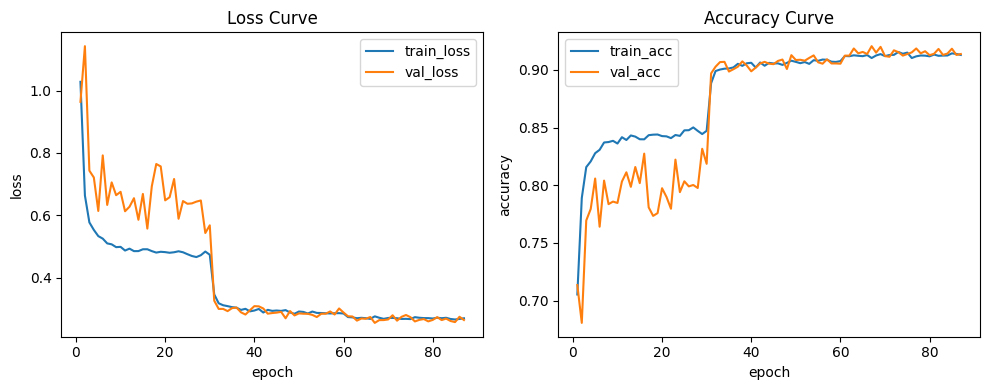

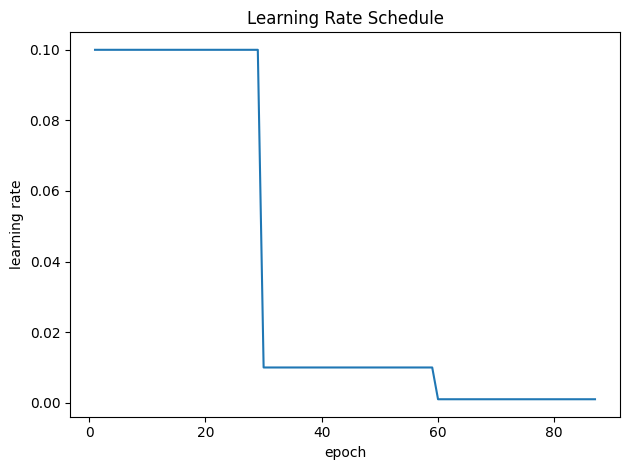


=== Pretrained-ResNet Test Result ===
Accuracy: 0.6821
F1 Score: 0.6822
Loss    : 1.5173
Trainable Params: 7,876


In [20]:
pt_partial = pt_partial.to(device)

#  pt_partial 학습
criterion = nn.CrossEntropyLoss()

# BN 파라미터가 포함되므로 Fixed보다 학습할 파라미터가 조금 더 많음
optimizer = optim.SGD(filter(lambda p: p.requires_grad, pt_partial.parameters()),
                      lr=0.1, momentum=0.9, weight_decay=1e-4)

scheduler = MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)

print("\n================ Train Pretrained-ResNet20 (partial) ================")
early_stopping(train_loader, val_loader, pt_partial, criterion, optimizer, scheduler,
               patience=20, save_path="pt_partial_best.pth")

pt_partial.load_state_dict(torch.load("pt_partial_best.pth"))
test_acc, test_f1, test_loss = evaluate(test_loader, pt_partial, criterion)

pt_partial_params = sum(p.numel() for p in pt_partial.parameters() if p.requires_grad)

print("\n=== Pretrained-ResNet Test Result ===")
print("Accuracy:", round(test_acc,4))
print("F1 Score:", round(test_f1,4))
print("Loss    :", round(test_loss,4))
print("Trainable Params:", f"{pt_partial_params:,}")

result



```
================ Train Pretrained-ResNet20 (partial) ================
  0%|          | 1/200 [00:19<1:06:06, 19.93s/it]epoch:0   train_loss=1.0361 train_acc=0.7013 val_loss=1.3123 val_acc=0.6428 val_f1=0.6570 lr=0.1
  1%|          | 2/200 [00:38<1:03:48, 19.34s/it]epoch:1   train_loss=0.6451 train_acc=0.7941 val_loss=0.8962 val_acc=0.7392 val_f1=0.7386 lr=0.1
  2%|▏         | 3/200 [00:58<1:03:59, 19.49s/it]epoch:2   train_loss=0.5879 train_acc=0.8116 val_loss=0.8204 val_acc=0.7600 val_f1=0.7617 lr=0.1
  2%|▏         | 4/200 [01:17<1:02:45, 19.21s/it]epoch:3   train_loss=0.5615 train_acc=0.8202 val_loss=0.7033 val_acc=0.7818 val_f1=0.7807 lr=0.1
  2%|▎         | 5/200 [01:37<1:03:20, 19.49s/it]epoch:4   train_loss=0.5341 train_acc=0.8284 val_loss=0.7574 val_acc=0.7666 val_f1=0.7642 lr=0.1
  3%|▎         | 6/200 [01:57<1:04:15, 19.87s/it]epoch:5   train_loss=0.5184 train_acc=0.8326 val_loss=0.6787 val_acc=0.7890 val_f1=0.7870 lr=0.1
  4%|▎         | 7/200 [02:16<1:02:46, 19.51s/it]epoch:6   train_loss=0.5156 train_acc=0.8334 val_loss=0.5985 val_acc=0.8078 val_f1=0.8090 lr=0.1
  4%|▍         | 8/200 [02:37<1:03:36, 19.88s/it]epoch:7   train_loss=0.5043 train_acc=0.8360 val_loss=0.7367 val_acc=0.7736 val_f1=0.7691 lr=0.1
  4%|▍         | 9/200 [02:56<1:02:08, 19.52s/it]epoch:8   train_loss=0.5036 train_acc=0.8360 val_loss=0.6679 val_acc=0.7880 val_f1=0.7897 lr=0.1
  5%|▌         | 10/200 [03:15<1:01:57, 19.56s/it]epoch:9   train_loss=0.4934 train_acc=0.8375 val_loss=0.5943 val_acc=0.8122 val_f1=0.8153 lr=0.1
  6%|▌         | 11/200 [03:34<1:00:53, 19.33s/it]epoch:10  train_loss=0.4936 train_acc=0.8390 val_loss=0.6164 val_acc=0.8042 val_f1=0.8064 lr=0.1
  6%|▌         | 12/200 [03:54<1:01:03, 19.49s/it]epoch:11  train_loss=0.4917 train_acc=0.8395 val_loss=0.6799 val_acc=0.7870 val_f1=0.7853 lr=0.1
  6%|▋         | 13/200 [04:13<1:00:12, 19.32s/it]epoch:12  train_loss=0.4955 train_acc=0.8380 val_loss=0.6768 val_acc=0.7950 val_f1=0.7935 lr=0.1
  7%|▋         | 14/200 [04:33<1:00:14, 19.43s/it]epoch:13  train_loss=0.4929 train_acc=0.8401 val_loss=0.6787 val_acc=0.7890 val_f1=0.7880 lr=0.1
  8%|▊         | 15/200 [04:51<59:19, 19.24s/it]  epoch:14  train_loss=0.4992 train_acc=0.8381 val_loss=0.7103 val_acc=0.7844 val_f1=0.7831 lr=0.1
  8%|▊         | 16/200 [05:11<59:32, 19.42s/it]epoch:15  train_loss=0.4819 train_acc=0.8431 val_loss=0.6449 val_acc=0.7934 val_f1=0.7937 lr=0.1
  8%|▊         | 17/200 [05:30<58:48, 19.28s/it]epoch:16  train_loss=0.4871 train_acc=0.8422 val_loss=0.5615 val_acc=0.8196 val_f1=0.8185 lr=0.1
  9%|▉         | 18/200 [05:50<59:07, 19.49s/it]epoch:17  train_loss=0.4803 train_acc=0.8457 val_loss=0.6281 val_acc=0.8036 val_f1=0.8055 lr=0.1
 10%|▉         | 19/200 [06:09<58:31, 19.40s/it]epoch:18  train_loss=0.4827 train_acc=0.8427 val_loss=0.5632 val_acc=0.8198 val_f1=0.8192 lr=0.1
 10%|█         | 20/200 [06:30<58:57, 19.65s/it]epoch:19  train_loss=0.4754 train_acc=0.8461 val_loss=0.6692 val_acc=0.7916 val_f1=0.7941 lr=0.1
 10%|█         | 21/200 [06:49<58:12, 19.51s/it]epoch:20  train_loss=0.4808 train_acc=0.8447 val_loss=0.7361 val_acc=0.7840 val_f1=0.7818 lr=0.1
 11%|█         | 22/200 [07:09<58:18, 19.65s/it]epoch:21  train_loss=0.4796 train_acc=0.8436 val_loss=0.6501 val_acc=0.8022 val_f1=0.8007 lr=0.1
 12%|█▏        | 23/200 [07:28<57:53, 19.62s/it]epoch:22  train_loss=0.4738 train_acc=0.8462 val_loss=0.6764 val_acc=0.7918 val_f1=0.7949 lr=0.1
 12%|█▏        | 24/200 [07:49<58:18, 19.88s/it]epoch:23  train_loss=0.4756 train_acc=0.8461 val_loss=0.6341 val_acc=0.7962 val_f1=0.7977 lr=0.1
 12%|█▎        | 25/200 [08:09<58:06, 19.92s/it]epoch:24  train_loss=0.4788 train_acc=0.8433 val_loss=0.5131 val_acc=0.8354 val_f1=0.8341 lr=0.1
 13%|█▎        | 26/200 [08:28<57:02, 19.67s/it]epoch:25  train_loss=0.4727 train_acc=0.8440 val_loss=0.6641 val_acc=0.7972 val_f1=0.7983 lr=0.1
 14%|█▎        | 27/200 [08:48<57:06, 19.80s/it]epoch:26  train_loss=0.4761 train_acc=0.8442 val_loss=0.6887 val_acc=0.7912 val_f1=0.7900 lr=0.1
 14%|█▍        | 28/200 [09:07<56:20, 19.65s/it]epoch:27  train_loss=0.4847 train_acc=0.8437 val_loss=0.6780 val_acc=0.7850 val_f1=0.7837 lr=0.1
 14%|█▍        | 29/200 [09:27<56:20, 19.77s/it]epoch:28  train_loss=0.4751 train_acc=0.8455 val_loss=0.6042 val_acc=0.8100 val_f1=0.8094 lr=0.1
 15%|█▌        | 30/200 [09:46<55:31, 19.60s/it]epoch:29  train_loss=0.4849 train_acc=0.8412 val_loss=0.6435 val_acc=0.7962 val_f1=0.7952 lr=0.010000000000000002
 16%|█▌        | 31/200 [10:06<55:33, 19.73s/it]epoch:30  train_loss=0.3466 train_acc=0.8890 val_loss=0.3098 val_acc=0.9036 val_f1=0.9032 lr=0.010000000000000002
 16%|█▌        | 32/200 [10:26<54:56, 19.62s/it]epoch:31  train_loss=0.3216 train_acc=0.8963 val_loss=0.3075 val_acc=0.9026 val_f1=0.9022 lr=0.010000000000000002
 16%|█▋        | 33/200 [10:46<54:47, 19.69s/it]epoch:32  train_loss=0.3073 train_acc=0.9015 val_loss=0.3027 val_acc=0.9076 val_f1=0.9070 lr=0.010000000000000002
 17%|█▋        | 34/200 [11:05<54:22, 19.65s/it]epoch:33  train_loss=0.3051 train_acc=0.9021 val_loss=0.2983 val_acc=0.9076 val_f1=0.9080 lr=0.010000000000000002
 18%|█▊        | 35/200 [11:24<53:09, 19.33s/it]epoch:34  train_loss=0.3037 train_acc=0.9038 val_loss=0.3059 val_acc=0.9048 val_f1=0.9047 lr=0.010000000000000002
 18%|█▊        | 36/200 [11:43<52:59, 19.39s/it]epoch:35  train_loss=0.3000 train_acc=0.9047 val_loss=0.3016 val_acc=0.9046 val_f1=0.9042 lr=0.010000000000000002
 18%|█▊        | 37/200 [12:02<52:09, 19.20s/it]epoch:36  train_loss=0.2963 train_acc=0.9051 val_loss=0.2899 val_acc=0.9066 val_f1=0.9068 lr=0.010000000000000002
 19%|█▉        | 38/200 [12:22<51:59, 19.25s/it]epoch:37  train_loss=0.2982 train_acc=0.9034 val_loss=0.3013 val_acc=0.9064 val_f1=0.9060 lr=0.010000000000000002
 20%|█▉        | 39/200 [12:41<51:59, 19.37s/it]epoch:38  train_loss=0.2984 train_acc=0.9030 val_loss=0.2957 val_acc=0.9090 val_f1=0.9090 lr=0.010000000000000002
 20%|██        | 40/200 [13:01<51:54, 19.47s/it]epoch:39  train_loss=0.2930 train_acc=0.9048 val_loss=0.2750 val_acc=0.9104 val_f1=0.9101 lr=0.010000000000000002
 20%|██        | 41/200 [13:20<51:00, 19.25s/it]epoch:40  train_loss=0.2919 train_acc=0.9066 val_loss=0.2839 val_acc=0.9074 val_f1=0.9068 lr=0.010000000000000002
 21%|██        | 42/200 [13:39<50:42, 19.26s/it]epoch:41  train_loss=0.2934 train_acc=0.9056 val_loss=0.3009 val_acc=0.9006 val_f1=0.9007 lr=0.010000000000000002
 22%|██▏       | 43/200 [13:58<50:08, 19.16s/it]epoch:42  train_loss=0.2945 train_acc=0.9040 val_loss=0.2930 val_acc=0.9042 val_f1=0.9037 lr=0.010000000000000002
 22%|██▏       | 44/200 [14:17<50:12, 19.31s/it]epoch:43  train_loss=0.2901 train_acc=0.9067 val_loss=0.2911 val_acc=0.9088 val_f1=0.9082 lr=0.010000000000000002
 22%|██▎       | 45/200 [14:36<49:18, 19.09s/it]epoch:44  train_loss=0.2874 train_acc=0.9065 val_loss=0.2825 val_acc=0.9128 val_f1=0.9128 lr=0.010000000000000002
 23%|██▎       | 46/200 [14:56<49:20, 19.23s/it]epoch:45  train_loss=0.2875 train_acc=0.9073 val_loss=0.2961 val_acc=0.9062 val_f1=0.9058 lr=0.010000000000000002
 24%|██▎       | 47/200 [15:14<48:24, 18.98s/it]epoch:46  train_loss=0.2918 train_acc=0.9071 val_loss=0.2866 val_acc=0.9068 val_f1=0.9067 lr=0.010000000000000002
 24%|██▍       | 48/200 [15:33<48:22, 19.09s/it]epoch:47  train_loss=0.2891 train_acc=0.9073 val_loss=0.2672 val_acc=0.9144 val_f1=0.9142 lr=0.010000000000000002
 24%|██▍       | 49/200 [15:52<47:39, 18.94s/it]epoch:48  train_loss=0.2857 train_acc=0.9072 val_loss=0.2702 val_acc=0.9156 val_f1=0.9154 lr=0.010000000000000002
 25%|██▌       | 50/200 [16:11<47:41, 19.07s/it]epoch:49  train_loss=0.2933 train_acc=0.9043 val_loss=0.2859 val_acc=0.9072 val_f1=0.9074 lr=0.010000000000000002
 26%|██▌       | 51/200 [16:30<46:58, 18.91s/it]epoch:50  train_loss=0.2880 train_acc=0.9064 val_loss=0.2912 val_acc=0.9080 val_f1=0.9081 lr=0.010000000000000002
 26%|██▌       | 52/200 [16:49<47:01, 19.06s/it]epoch:51  train_loss=0.2890 train_acc=0.9073 val_loss=0.2859 val_acc=0.9054 val_f1=0.9054 lr=0.010000000000000002
 26%|██▋       | 53/200 [17:08<46:23, 18.93s/it]epoch:52  train_loss=0.2869 train_acc=0.9069 val_loss=0.2870 val_acc=0.9058 val_f1=0.9056 lr=0.010000000000000002
 27%|██▋       | 54/200 [17:28<47:14, 19.41s/it]epoch:53  train_loss=0.2877 train_acc=0.9069 val_loss=0.2831 val_acc=0.9112 val_f1=0.9112 lr=0.010000000000000002
 28%|██▊       | 55/200 [17:47<46:30, 19.25s/it]epoch:54  train_loss=0.2858 train_acc=0.9073 val_loss=0.2832 val_acc=0.9068 val_f1=0.9069 lr=0.010000000000000002
 28%|██▊       | 56/200 [18:06<46:08, 19.23s/it]epoch:55  train_loss=0.2902 train_acc=0.9058 val_loss=0.2922 val_acc=0.9084 val_f1=0.9085 lr=0.010000000000000002
 28%|██▊       | 57/200 [18:25<45:25, 19.06s/it]epoch:56  train_loss=0.2885 train_acc=0.9068 val_loss=0.2772 val_acc=0.9088 val_f1=0.9090 lr=0.010000000000000002
 29%|██▉       | 58/200 [18:45<45:24, 19.18s/it]epoch:57  train_loss=0.2902 train_acc=0.9057 val_loss=0.2760 val_acc=0.9116 val_f1=0.9122 lr=0.010000000000000002
 30%|██▉       | 59/200 [19:03<44:44, 19.04s/it]epoch:58  train_loss=0.2884 train_acc=0.9065 val_loss=0.2790 val_acc=0.9088 val_f1=0.9090 lr=0.010000000000000002
 30%|███       | 60/200 [19:23<44:51, 19.22s/it]epoch:59  train_loss=0.2906 train_acc=0.9061 val_loss=0.2736 val_acc=0.9094 val_f1=0.9101 lr=0.0010000000000000002
 30%|███       | 61/200 [19:41<43:55, 18.96s/it]epoch:60  train_loss=0.2773 train_acc=0.9100 val_loss=0.2675 val_acc=0.9128 val_f1=0.9130 lr=0.0010000000000000002
 31%|███       | 62/200 [20:01<44:14, 19.24s/it]epoch:61  train_loss=0.2718 train_acc=0.9125 val_loss=0.2694 val_acc=0.9114 val_f1=0.9117 lr=0.0010000000000000002
 32%|███▏      | 63/200 [20:20<43:28, 19.04s/it]epoch:62  train_loss=0.2750 train_acc=0.9113 val_loss=0.2730 val_acc=0.9140 val_f1=0.9143 lr=0.0010000000000000002
 32%|███▏      | 64/200 [20:39<43:28, 19.18s/it]epoch:63  train_loss=0.2710 train_acc=0.9141 val_loss=0.2610 val_acc=0.9156 val_f1=0.9151 lr=0.0010000000000000002
 32%|███▎      | 65/200 [20:58<42:56, 19.09s/it]epoch:64  train_loss=0.2707 train_acc=0.9130 val_loss=0.2635 val_acc=0.9116 val_f1=0.9116 lr=0.0010000000000000002
 33%|███▎      | 66/200 [21:18<42:59, 19.25s/it]epoch:65  train_loss=0.2671 train_acc=0.9131 val_loss=0.2884 val_acc=0.9068 val_f1=0.9068 lr=0.0010000000000000002
 34%|███▎      | 67/200 [21:37<42:21, 19.11s/it]epoch:66  train_loss=0.2694 train_acc=0.9133 val_loss=0.2837 val_acc=0.9090 val_f1=0.9087 lr=0.0010000000000000002
 34%|███▍      | 68/200 [21:56<42:26, 19.29s/it]epoch:67  train_loss=0.2695 train_acc=0.9126 val_loss=0.2774 val_acc=0.9114 val_f1=0.9114 lr=0.0010000000000000002
 34%|███▍      | 69/200 [22:15<41:40, 19.09s/it]epoch:68  train_loss=0.2704 train_acc=0.9137 val_loss=0.2481 val_acc=0.9218 val_f1=0.9213 lr=0.0010000000000000002
 35%|███▌      | 70/200 [22:36<42:29, 19.62s/it]epoch:69  train_loss=0.2682 train_acc=0.9131 val_loss=0.2605 val_acc=0.9208 val_f1=0.9209 lr=0.0010000000000000002
 36%|███▌      | 71/200 [22:55<41:57, 19.52s/it]epoch:70  train_loss=0.2663 train_acc=0.9138 val_loss=0.2776 val_acc=0.9108 val_f1=0.9106 lr=0.0010000000000000002
 36%|███▌      | 72/200 [23:15<41:41, 19.55s/it]epoch:71  train_loss=0.2682 train_acc=0.9137 val_loss=0.2662 val_acc=0.9112 val_f1=0.9113 lr=0.0010000000000000002
 36%|███▋      | 73/200 [23:34<41:05, 19.42s/it]epoch:72  train_loss=0.2680 train_acc=0.9130 val_loss=0.2561 val_acc=0.9172 val_f1=0.9169 lr=0.0010000000000000002
 37%|███▋      | 74/200 [23:53<40:46, 19.42s/it]epoch:73  train_loss=0.2672 train_acc=0.9144 val_loss=0.2645 val_acc=0.9176 val_f1=0.9179 lr=0.0010000000000000002
 38%|███▊      | 75/200 [24:13<40:46, 19.58s/it]epoch:74  train_loss=0.2686 train_acc=0.9128 val_loss=0.2637 val_acc=0.9166 val_f1=0.9166 lr=0.0010000000000000002
 38%|███▊      | 76/200 [24:32<40:03, 19.39s/it]epoch:75  train_loss=0.2654 train_acc=0.9148 val_loss=0.2512 val_acc=0.9186 val_f1=0.9182 lr=0.0010000000000000002
 38%|███▊      | 77/200 [24:52<39:52, 19.45s/it]epoch:76  train_loss=0.2697 train_acc=0.9124 val_loss=0.2657 val_acc=0.9146 val_f1=0.9140 lr=0.0010000000000000002
 39%|███▉      | 78/200 [25:10<38:56, 19.15s/it]epoch:77  train_loss=0.2638 train_acc=0.9150 val_loss=0.2657 val_acc=0.9190 val_f1=0.9184 lr=0.0010000000000000002
 40%|███▉      | 79/200 [25:30<38:52, 19.28s/it]epoch:78  train_loss=0.2687 train_acc=0.9129 val_loss=0.2592 val_acc=0.9182 val_f1=0.9183 lr=0.0010000000000000002
 40%|████      | 80/200 [25:48<38:08, 19.07s/it]epoch:79  train_loss=0.2690 train_acc=0.9136 val_loss=0.2580 val_acc=0.9158 val_f1=0.9159 lr=0.0010000000000000002
 40%|████      | 81/200 [26:08<38:00, 19.17s/it]epoch:80  train_loss=0.2633 train_acc=0.9160 val_loss=0.2607 val_acc=0.9192 val_f1=0.9186 lr=0.0010000000000000002
 41%|████      | 82/200 [26:26<37:14, 18.94s/it]epoch:81  train_loss=0.2693 train_acc=0.9132 val_loss=0.2574 val_acc=0.9154 val_f1=0.9154 lr=0.0010000000000000002
 42%|████▏     | 83/200 [26:46<37:13, 19.09s/it]epoch:82  train_loss=0.2707 train_acc=0.9133 val_loss=0.2629 val_acc=0.9178 val_f1=0.9177 lr=0.0010000000000000002
 42%|████▏     | 84/200 [27:04<36:33, 18.91s/it]epoch:83  train_loss=0.2660 train_acc=0.9141 val_loss=0.2624 val_acc=0.9164 val_f1=0.9167 lr=0.0010000000000000002
 42%|████▎     | 85/200 [27:23<36:28, 19.03s/it]epoch:84  train_loss=0.2699 train_acc=0.9124 val_loss=0.2594 val_acc=0.9160 val_f1=0.9160 lr=0.0010000000000000002
 43%|████▎     | 86/200 [27:43<36:23, 19.15s/it]epoch:85  train_loss=0.2691 train_acc=0.9139 val_loss=0.2709 val_acc=0.9142 val_f1=0.9140 lr=0.0010000000000000002
 44%|████▎     | 87/200 [28:03<36:24, 19.33s/it]epoch:86  train_loss=0.2653 train_acc=0.9140 val_loss=0.2569 val_acc=0.9202 val_f1=0.9202 lr=0.0010000000000000002
 44%|████▍     | 88/200 [28:21<35:35, 19.07s/it]epoch:87  train_loss=0.2689 train_acc=0.9142 val_loss=0.2443 val_acc=0.9244 val_f1=0.9246 lr=0.0010000000000000002
 44%|████▍     | 89/200 [28:40<35:29, 19.18s/it]epoch:88  train_loss=0.2680 train_acc=0.9129 val_loss=0.2598 val_acc=0.9164 val_f1=0.9162 lr=0.0010000000000000002
 45%|████▌     | 90/200 [28:59<34:47, 18.98s/it]epoch:89  train_loss=0.2699 train_acc=0.9132 val_loss=0.2732 val_acc=0.9118 val_f1=0.9116 lr=0.0010000000000000002
 46%|████▌     | 91/200 [29:19<34:51, 19.19s/it]epoch:90  train_loss=0.2678 train_acc=0.9141 val_loss=0.2560 val_acc=0.9152 val_f1=0.9148 lr=0.0010000000000000002
 46%|████▌     | 92/200 [29:37<34:18, 19.06s/it]epoch:91  train_loss=0.2683 train_acc=0.9134 val_loss=0.2704 val_acc=0.9176 val_f1=0.9176 lr=0.0010000000000000002
 46%|████▋     | 93/200 [29:57<34:20, 19.25s/it]epoch:92  train_loss=0.2699 train_acc=0.9134 val_loss=0.2600 val_acc=0.9178 val_f1=0.9178 lr=0.0010000000000000002
 47%|████▋     | 94/200 [30:16<33:36, 19.03s/it]epoch:93  train_loss=0.2712 train_acc=0.9128 val_loss=0.2591 val_acc=0.9170 val_f1=0.9167 lr=0.0010000000000000002
 48%|████▊     | 95/200 [30:35<33:33, 19.18s/it]epoch:94  train_loss=0.2630 train_acc=0.9159 val_loss=0.2744 val_acc=0.9162 val_f1=0.9161 lr=0.0010000000000000002
 48%|████▊     | 96/200 [30:54<32:54, 18.98s/it]epoch:95  train_loss=0.2682 train_acc=0.9132 val_loss=0.2591 val_acc=0.9206 val_f1=0.9205 lr=0.0010000000000000002
 48%|████▊     | 97/200 [31:13<32:48, 19.11s/it]epoch:96  train_loss=0.2674 train_acc=0.9139 val_loss=0.2600 val_acc=0.9118 val_f1=0.9116 lr=0.0010000000000000002
 49%|████▉     | 98/200 [31:32<32:16, 18.98s/it]epoch:97  train_loss=0.2679 train_acc=0.9136 val_loss=0.2614 val_acc=0.9164 val_f1=0.9168 lr=0.0010000000000000002
 50%|████▉     | 99/200 [31:51<32:18, 19.19s/it]epoch:98  train_loss=0.2664 train_acc=0.9143 val_loss=0.2531 val_acc=0.9168 val_f1=0.9166 lr=0.0010000000000000002
 50%|█████     | 100/200 [32:10<31:47, 19.07s/it]epoch:99  train_loss=0.2672 train_acc=0.9129 val_loss=0.2568 val_acc=0.9146 val_f1=0.9147 lr=0.0010000000000000002
 50%|█████     | 101/200 [32:30<31:41, 19.20s/it]epoch:100 train_loss=0.2690 train_acc=0.9120 val_loss=0.2570 val_acc=0.9172 val_f1=0.9172 lr=0.0010000000000000002
 51%|█████     | 102/200 [32:49<31:33, 19.32s/it]epoch:101 train_loss=0.2651 train_acc=0.9153 val_loss=0.2687 val_acc=0.9152 val_f1=0.9153 lr=0.0010000000000000002
 52%|█████▏    | 103/200 [33:09<31:16, 19.35s/it]epoch:102 train_loss=0.2698 train_acc=0.9134 val_loss=0.2642 val_acc=0.9144 val_f1=0.9137 lr=0.0010000000000000002
 52%|█████▏    | 104/200 [33:27<30:38, 19.15s/it]epoch:103 train_loss=0.2697 train_acc=0.9120 val_loss=0.2542 val_acc=0.9172 val_f1=0.9168 lr=0.0010000000000000002
 52%|█████▎    | 105/200 [33:47<30:31, 19.28s/it]epoch:104 train_loss=0.2689 train_acc=0.9120 val_loss=0.2495 val_acc=0.9198 val_f1=0.9199 lr=0.0010000000000000002
 53%|█████▎    | 106/200 [34:06<29:57, 19.13s/it]epoch:105 train_loss=0.2715 train_acc=0.9129 val_loss=0.2711 val_acc=0.9168 val_f1=0.9166 lr=0.0010000000000000002
 54%|█████▎    | 107/200 [34:26<29:56, 19.32s/it]epoch:106 train_loss=0.2649 train_acc=0.9144 val_loss=0.2580 val_acc=0.9154 val_f1=0.9153 lr=0.0010000000000000002
 54%|█████▎    | 107/200 [34:44<30:11, 19.48s/it]epoch:107 train_loss=0.2702 train_acc=0.9133 val_loss=0.2654 val_acc=0.9158 val_f1=0.9157 lr=0.0010000000000000002
Early stopping!


=== Pretrained-ResNet Test Result ===
Accuracy: 0.6824
F1 Score: 0.6824
Loss    : 1.528
Trainable Params: 7,876
```



In [ ]:
# learning curve

### 문제 3. imbalanced dataset training - with CIFAR10 (30점)
- 불균형한 데이터가 주어졌을 때, 어떻게 해야 모델의 성능을 보장할 수 있을까요?
- 베이스라인: 직접 구축한 resnet20 모델(1-B)에 imbalanced dataloader를 연결한 모델
- 2가지 모델을 시도한 후 성능을 비교 분석하고 최적의 방안을 제시하세요. (모델 1개: 10점, 모델 2개: 30점)
- 인정 기준: 베이스라인 모델 성능 대비 test f1 +5% 향상된 모델 (학습 로그와 테스트 로그 필수)
- 여러가지 기법을 섞어 사용 가능하며 두 모델에 사용한 기법이 전부 중복될 경우는 모델 1개만 인정

In [22]:
# 데이터 다운로드

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

train_full = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_tf
)
test_full = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_tf
)

def print_class_counts(dataset, title):
    print(f"\n===== {title} 클래스별 이미지 개수 =====")
    targets = np.array(dataset.targets)
    uniq, counts = np.unique(targets, return_counts=True)
    for cls, cnt in zip(uniq, counts):
        print(f"class {cls} : {cnt}")
    print("총 이미지 수:", len(dataset))

print_class_counts(train_full, "Original Balanced CIFAR10")

# imbalanced data 만들기

def make_imbalanced(dataset, major_class=0, major_count=5000, minor_count=500):

    targets = np.array(dataset.targets)
    selected_indices = []

    for cls in range(10):
        idx = np.where(targets == cls)[0]

        if cls == major_class:
            chosen = np.random.choice(idx, major_count, replace=False)
        else:
            chosen = np.random.choice(idx, minor_count, replace=False)

        selected_indices.extend(chosen)

    # 불균형 결과 출력
    print("\n===== Imbalanced CIFAR10 클래스별 이미지 개수 =====")
    uniq, counts = np.unique(targets[selected_indices], return_counts=True)
    for cls, cnt in zip(uniq, counts):
        print(f"class {cls} : {cnt}")
    print("총 이미지 수:", len(selected_indices))

    return Subset(dataset, selected_indices)

imbalanced_train = make_imbalanced(
    train_full,
    major_class=0,
    major_count=5000,
    minor_count=500
)

# data loader

BATCH_SIZE = 128

balanced_loader = DataLoader(train_full, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)

imbalanced_loader = DataLoader(imbalanced_train, batch_size=BATCH_SIZE,
                               shuffle=True, num_workers=2)

test_loader = DataLoader(test_full, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)


===== Original Balanced CIFAR10 클래스별 이미지 개수 =====
class 0 : 5000
class 1 : 5000
class 2 : 5000
class 3 : 5000
class 4 : 5000
class 5 : 5000
class 6 : 5000
class 7 : 5000
class 8 : 5000
class 9 : 5000
총 이미지 수: 50000

===== Imbalanced CIFAR10 클래스별 이미지 개수 =====
class 0 : 5000
class 1 : 500
class 2 : 500
class 3 : 500
class 4 : 500
class 5 : 500
class 6 : 500
class 7 : 500
class 8 : 500
class 9 : 500
총 이미지 수: 9500


### base line 모델


================ Train Baseline (Imbalanced) ================


  0%|          | 1/200 [00:03<10:43,  3.24s/it]

epoch:0   train_loss=1.5837 train_acc=0.5236 val_loss=2.5303 val_acc=0.1054 val_f1=0.0265 lr=0.1


  1%|          | 2/200 [00:06<11:00,  3.34s/it]

epoch:1   train_loss=1.3790 train_acc=0.5469 val_loss=2.1635 val_acc=0.1740 val_f1=0.1104 lr=0.1


  2%|▏         | 3/200 [00:09<10:53,  3.31s/it]

epoch:2   train_loss=1.2863 train_acc=0.5627 val_loss=2.2473 val_acc=0.1935 val_f1=0.1358 lr=0.1


  2%|▏         | 4/200 [00:13<10:43,  3.28s/it]

epoch:3   train_loss=1.2337 train_acc=0.5813 val_loss=2.0453 val_acc=0.2359 val_f1=0.1533 lr=0.1


  2%|▎         | 5/200 [00:16<11:14,  3.46s/it]

epoch:4   train_loss=1.1722 train_acc=0.6046 val_loss=2.1663 val_acc=0.2441 val_f1=0.1917 lr=0.1


  3%|▎         | 6/200 [00:20<10:54,  3.37s/it]

epoch:5   train_loss=1.1213 train_acc=0.6127 val_loss=2.0880 val_acc=0.3170 val_f1=0.2679 lr=0.1


  4%|▎         | 7/200 [00:23<10:44,  3.34s/it]

epoch:6   train_loss=1.0687 train_acc=0.6281 val_loss=1.8973 val_acc=0.3490 val_f1=0.3010 lr=0.1


  4%|▍         | 8/200 [00:26<10:41,  3.34s/it]

epoch:7   train_loss=1.0369 train_acc=0.6395 val_loss=1.9669 val_acc=0.3377 val_f1=0.2905 lr=0.1


  4%|▍         | 9/200 [00:30<10:34,  3.32s/it]

epoch:8   train_loss=0.9951 train_acc=0.6599 val_loss=1.8143 val_acc=0.3802 val_f1=0.3474 lr=0.1


  5%|▌         | 10/200 [00:33<10:23,  3.28s/it]

epoch:9   train_loss=0.9611 train_acc=0.6731 val_loss=1.6865 val_acc=0.4181 val_f1=0.3803 lr=0.1


  6%|▌         | 11/200 [00:36<10:11,  3.24s/it]

epoch:10  train_loss=0.9010 train_acc=0.6951 val_loss=1.8221 val_acc=0.3720 val_f1=0.3443 lr=0.1


  6%|▌         | 12/200 [00:39<10:23,  3.32s/it]

epoch:11  train_loss=0.8704 train_acc=0.6994 val_loss=1.4884 val_acc=0.4791 val_f1=0.4465 lr=0.1


  6%|▋         | 13/200 [00:43<10:17,  3.30s/it]

epoch:12  train_loss=0.8210 train_acc=0.7179 val_loss=1.7122 val_acc=0.4376 val_f1=0.4213 lr=0.1


  7%|▋         | 14/200 [00:46<10:11,  3.29s/it]

epoch:13  train_loss=0.7734 train_acc=0.7357 val_loss=1.4873 val_acc=0.5134 val_f1=0.4829 lr=0.1


  8%|▊         | 15/200 [00:49<10:00,  3.25s/it]

epoch:14  train_loss=0.7522 train_acc=0.7426 val_loss=1.8896 val_acc=0.4577 val_f1=0.4266 lr=0.1


  8%|▊         | 16/200 [00:52<10:08,  3.31s/it]

epoch:15  train_loss=0.7203 train_acc=0.7547 val_loss=1.1531 val_acc=0.5933 val_f1=0.5821 lr=0.1


  8%|▊         | 17/200 [00:56<10:14,  3.36s/it]

epoch:16  train_loss=0.6933 train_acc=0.7680 val_loss=1.3346 val_acc=0.5643 val_f1=0.5624 lr=0.1


  9%|▉         | 18/200 [00:59<10:03,  3.32s/it]

epoch:17  train_loss=0.6818 train_acc=0.7623 val_loss=1.1189 val_acc=0.6075 val_f1=0.6070 lr=0.1


 10%|▉         | 19/200 [01:03<10:09,  3.37s/it]

epoch:18  train_loss=0.6451 train_acc=0.7740 val_loss=1.3078 val_acc=0.5620 val_f1=0.5629 lr=0.1


 10%|█         | 20/200 [01:06<09:58,  3.33s/it]

epoch:19  train_loss=0.6193 train_acc=0.7845 val_loss=1.3135 val_acc=0.5792 val_f1=0.5790 lr=0.1


 10%|█         | 21/200 [01:09<09:49,  3.29s/it]

epoch:20  train_loss=0.6007 train_acc=0.7951 val_loss=1.4717 val_acc=0.5536 val_f1=0.5438 lr=0.1


 11%|█         | 22/200 [01:12<09:42,  3.27s/it]

epoch:21  train_loss=0.5718 train_acc=0.8053 val_loss=1.5186 val_acc=0.5513 val_f1=0.5299 lr=0.1


 12%|█▏        | 23/200 [01:16<09:42,  3.29s/it]

epoch:22  train_loss=0.5730 train_acc=0.8057 val_loss=1.2008 val_acc=0.6037 val_f1=0.6036 lr=0.1


 12%|█▏        | 24/200 [01:19<09:34,  3.26s/it]

epoch:23  train_loss=0.5504 train_acc=0.8138 val_loss=1.1671 val_acc=0.6201 val_f1=0.6136 lr=0.1


 12%|█▎        | 25/200 [01:22<09:26,  3.24s/it]

epoch:24  train_loss=0.5286 train_acc=0.8205 val_loss=1.1247 val_acc=0.6415 val_f1=0.6383 lr=0.1


 13%|█▎        | 26/200 [01:25<09:28,  3.27s/it]

epoch:25  train_loss=0.5089 train_acc=0.8276 val_loss=1.0405 val_acc=0.6587 val_f1=0.6547 lr=0.1


 14%|█▎        | 27/200 [01:29<09:22,  3.25s/it]

epoch:26  train_loss=0.4843 train_acc=0.8342 val_loss=1.1571 val_acc=0.6367 val_f1=0.6396 lr=0.1


 14%|█▍        | 28/200 [01:32<09:21,  3.26s/it]

epoch:27  train_loss=0.4719 train_acc=0.8398 val_loss=1.2766 val_acc=0.6183 val_f1=0.6169 lr=0.1


 14%|█▍        | 29/200 [01:35<09:16,  3.25s/it]

epoch:28  train_loss=0.4596 train_acc=0.8454 val_loss=0.9534 val_acc=0.6921 val_f1=0.6822 lr=0.1


 15%|█▌        | 30/200 [01:39<09:20,  3.30s/it]

epoch:29  train_loss=0.4422 train_acc=0.8491 val_loss=1.0813 val_acc=0.6671 val_f1=0.6647 lr=0.1


 16%|█▌        | 31/200 [01:42<09:10,  3.25s/it]

epoch:30  train_loss=0.4357 train_acc=0.8497 val_loss=0.9773 val_acc=0.6855 val_f1=0.6844 lr=0.1


 16%|█▌        | 32/200 [01:45<09:04,  3.24s/it]

epoch:31  train_loss=0.4204 train_acc=0.8527 val_loss=1.3889 val_acc=0.6100 val_f1=0.5974 lr=0.1


 16%|█▋        | 33/200 [01:48<09:01,  3.24s/it]

epoch:32  train_loss=0.4316 train_acc=0.8564 val_loss=1.1235 val_acc=0.6584 val_f1=0.6659 lr=0.1


 17%|█▋        | 34/200 [01:51<08:57,  3.24s/it]

epoch:33  train_loss=0.4033 train_acc=0.8621 val_loss=1.0594 val_acc=0.6726 val_f1=0.6702 lr=0.1


 18%|█▊        | 35/200 [01:54<08:49,  3.21s/it]

epoch:34  train_loss=0.3908 train_acc=0.8715 val_loss=0.9820 val_acc=0.6953 val_f1=0.6946 lr=0.1


 18%|█▊        | 36/200 [01:58<08:42,  3.19s/it]

epoch:35  train_loss=0.3934 train_acc=0.8665 val_loss=0.9631 val_acc=0.7054 val_f1=0.7010 lr=0.1


 18%|█▊        | 37/200 [02:01<08:43,  3.21s/it]

epoch:36  train_loss=0.3777 train_acc=0.8687 val_loss=0.9743 val_acc=0.7085 val_f1=0.6983 lr=0.1


 19%|█▉        | 38/200 [02:04<08:37,  3.19s/it]

epoch:37  train_loss=0.3575 train_acc=0.8776 val_loss=0.9831 val_acc=0.7062 val_f1=0.7013 lr=0.1


 20%|█▉        | 39/200 [02:07<08:44,  3.26s/it]

epoch:38  train_loss=0.3536 train_acc=0.8841 val_loss=1.3157 val_acc=0.6437 val_f1=0.6461 lr=0.1


 20%|██        | 40/200 [02:11<08:37,  3.23s/it]

epoch:39  train_loss=0.3428 train_acc=0.8822 val_loss=1.0113 val_acc=0.7101 val_f1=0.7058 lr=0.1


 20%|██        | 41/200 [02:14<08:33,  3.23s/it]

epoch:40  train_loss=0.3444 train_acc=0.8773 val_loss=1.1634 val_acc=0.6790 val_f1=0.6755 lr=0.1


 21%|██        | 42/200 [02:17<08:26,  3.20s/it]

epoch:41  train_loss=0.3430 train_acc=0.8827 val_loss=1.0513 val_acc=0.7049 val_f1=0.7004 lr=0.1


 22%|██▏       | 43/200 [02:20<08:19,  3.18s/it]

epoch:42  train_loss=0.3352 train_acc=0.8851 val_loss=1.3351 val_acc=0.6521 val_f1=0.6548 lr=0.1


 22%|██▏       | 44/200 [02:23<08:24,  3.23s/it]

epoch:43  train_loss=0.3179 train_acc=0.8929 val_loss=1.0491 val_acc=0.7074 val_f1=0.7028 lr=0.1


 22%|██▎       | 45/200 [02:27<08:21,  3.23s/it]

epoch:44  train_loss=0.3189 train_acc=0.8916 val_loss=1.0560 val_acc=0.6957 val_f1=0.7015 lr=0.1


 23%|██▎       | 46/200 [02:30<08:15,  3.22s/it]

epoch:45  train_loss=0.3117 train_acc=0.8906 val_loss=1.0041 val_acc=0.7092 val_f1=0.7096 lr=0.1


 24%|██▎       | 47/200 [02:33<08:19,  3.26s/it]

epoch:46  train_loss=0.2961 train_acc=0.8965 val_loss=1.0189 val_acc=0.7126 val_f1=0.6982 lr=0.1


 24%|██▍       | 48/200 [02:37<08:16,  3.27s/it]

epoch:47  train_loss=0.3025 train_acc=0.8960 val_loss=1.0763 val_acc=0.7052 val_f1=0.7030 lr=0.1


 24%|██▍       | 49/200 [02:40<08:10,  3.25s/it]

epoch:48  train_loss=0.2813 train_acc=0.9038 val_loss=0.9305 val_acc=0.7429 val_f1=0.7427 lr=0.1


 25%|██▌       | 50/200 [02:43<08:06,  3.24s/it]

epoch:49  train_loss=0.2611 train_acc=0.9108 val_loss=1.2548 val_acc=0.6846 val_f1=0.6863 lr=0.010000000000000002


 26%|██▌       | 51/200 [02:46<08:13,  3.31s/it]

epoch:50  train_loss=0.1972 train_acc=0.9335 val_loss=0.8309 val_acc=0.7600 val_f1=0.7618 lr=0.010000000000000002


 26%|██▌       | 52/200 [02:50<08:20,  3.38s/it]

epoch:51  train_loss=0.1635 train_acc=0.9475 val_loss=0.8473 val_acc=0.7606 val_f1=0.7621 lr=0.010000000000000002


 26%|██▋       | 53/200 [02:53<08:13,  3.36s/it]

epoch:52  train_loss=0.1449 train_acc=0.9541 val_loss=0.8470 val_acc=0.7611 val_f1=0.7631 lr=0.010000000000000002


 27%|██▋       | 54/200 [02:57<08:05,  3.33s/it]

epoch:53  train_loss=0.1426 train_acc=0.9536 val_loss=0.8487 val_acc=0.7641 val_f1=0.7655 lr=0.010000000000000002


 28%|██▊       | 55/200 [03:00<08:02,  3.32s/it]

epoch:54  train_loss=0.1419 train_acc=0.9534 val_loss=0.8675 val_acc=0.7642 val_f1=0.7663 lr=0.010000000000000002


 28%|██▊       | 56/200 [03:03<08:06,  3.38s/it]

epoch:55  train_loss=0.1289 train_acc=0.9580 val_loss=0.8828 val_acc=0.7656 val_f1=0.7670 lr=0.010000000000000002


 28%|██▊       | 57/200 [03:07<08:08,  3.42s/it]

epoch:56  train_loss=0.1226 train_acc=0.9594 val_loss=0.8943 val_acc=0.7632 val_f1=0.7644 lr=0.010000000000000002


 29%|██▉       | 58/200 [03:10<08:00,  3.38s/it]

epoch:57  train_loss=0.1231 train_acc=0.9575 val_loss=0.9375 val_acc=0.7569 val_f1=0.7592 lr=0.010000000000000002


 30%|██▉       | 59/200 [03:13<07:49,  3.33s/it]

epoch:58  train_loss=0.1229 train_acc=0.9601 val_loss=0.8927 val_acc=0.7672 val_f1=0.7691 lr=0.010000000000000002


 30%|███       | 60/200 [03:17<07:39,  3.28s/it]

epoch:59  train_loss=0.1113 train_acc=0.9627 val_loss=0.8945 val_acc=0.7681 val_f1=0.7680 lr=0.010000000000000002


 30%|███       | 61/200 [03:20<07:33,  3.26s/it]

epoch:60  train_loss=0.1120 train_acc=0.9629 val_loss=0.9269 val_acc=0.7658 val_f1=0.7662 lr=0.010000000000000002


 31%|███       | 62/200 [03:23<07:28,  3.25s/it]

epoch:61  train_loss=0.1106 train_acc=0.9628 val_loss=0.9169 val_acc=0.7667 val_f1=0.7673 lr=0.010000000000000002


 32%|███▏      | 63/200 [03:26<07:23,  3.24s/it]

epoch:62  train_loss=0.1060 train_acc=0.9675 val_loss=0.9347 val_acc=0.7651 val_f1=0.7663 lr=0.010000000000000002


 32%|███▏      | 64/200 [03:29<07:18,  3.23s/it]

epoch:63  train_loss=0.1041 train_acc=0.9634 val_loss=0.9307 val_acc=0.7674 val_f1=0.7687 lr=0.010000000000000002


 32%|███▎      | 65/200 [03:33<07:23,  3.29s/it]

epoch:64  train_loss=0.0954 train_acc=0.9696 val_loss=0.9592 val_acc=0.7650 val_f1=0.7671 lr=0.010000000000000002


 33%|███▎      | 66/200 [03:36<07:15,  3.25s/it]

epoch:65  train_loss=0.0948 train_acc=0.9668 val_loss=0.9906 val_acc=0.7595 val_f1=0.7609 lr=0.010000000000000002


 34%|███▎      | 67/200 [03:39<07:06,  3.21s/it]

epoch:66  train_loss=0.0964 train_acc=0.9674 val_loss=0.9859 val_acc=0.7606 val_f1=0.7613 lr=0.010000000000000002


 34%|███▍      | 68/200 [03:42<07:04,  3.22s/it]

epoch:67  train_loss=0.0894 train_acc=0.9713 val_loss=0.9798 val_acc=0.7650 val_f1=0.7669 lr=0.010000000000000002


 34%|███▍      | 69/200 [03:46<07:01,  3.21s/it]

epoch:68  train_loss=0.0961 train_acc=0.9683 val_loss=1.0063 val_acc=0.7617 val_f1=0.7634 lr=0.010000000000000002


 35%|███▌      | 70/200 [03:49<06:54,  3.19s/it]

epoch:69  train_loss=0.0910 train_acc=0.9681 val_loss=1.0092 val_acc=0.7586 val_f1=0.7607 lr=0.010000000000000002


 35%|███▌      | 70/200 [03:52<07:11,  3.32s/it]

epoch:70  train_loss=0.0895 train_acc=0.9715 val_loss=1.0055 val_acc=0.7623 val_f1=0.7638 lr=0.010000000000000002
Early stopping!

[Learning Curve] Train Loss: [1.5836729590098064, 1.378957494099935, 1.2863236204783122, 1.2336709864934285, 1.1721603282292683, 1.1213044468561808, 1.0686907736460367, 1.0368823798497517, 0.9951199396451315, 0.9611312754948934, 0.9010095874468486, 0.8704195356369019, 0.8209573642412822, 0.773376890818278, 0.7521661273638407, 0.720320332845052, 0.693329762617747, 0.681787006855011, 0.6450705762704213, 0.6192826696236928, 0.6007405845324199, 0.5718432052930196, 0.5729546058177948, 0.5504245964686075, 0.5286384507020314, 0.5089250818888347, 0.484328023592631, 0.4718710132439931, 0.45956359068552655, 0.44218735615412397, 0.4357023557027181, 0.42044235547383624, 0.4315768647193909, 0.4033049261569977, 0.39079467256863915, 0.39338826417922973, 0.37771384954452514, 0.3575370848178864, 0.3536178441842397, 0.34281788289546966, 0.3443617796897888, 0.3429800301790237

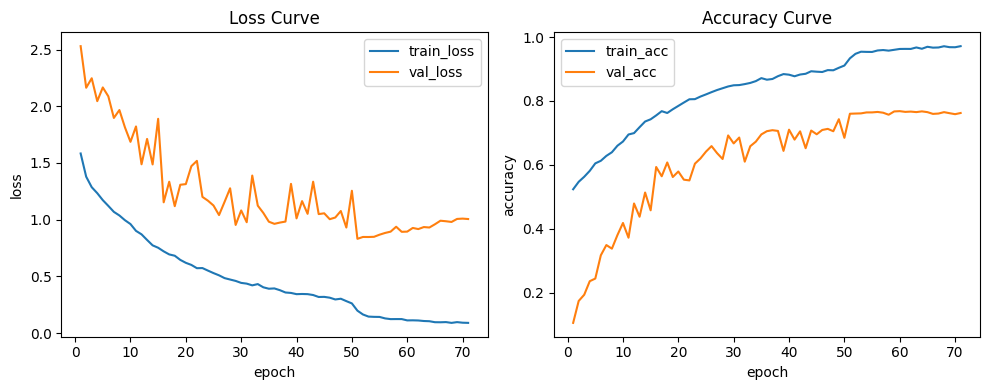

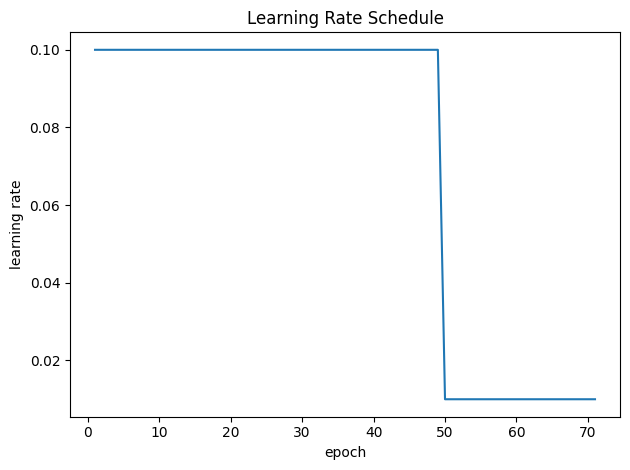


=== Baseline Test Result ===
Accuracy: 0.76
F1 Score: 0.7618
Loss    : 0.8309


In [23]:
# 베이스라인 만들기
# resnet20(1-B) 모델을 초기화하고 imbalanced_loader 연결해서 학습
# 성능 확인

# [오류 수정] 데이터셋과 로더가 정의되지 않았을 경우를 대비해 안전하게 다시 로드합니다.
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# CIFAR-10용 Transform 확인
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Test Dataset 다시 불러오기
test_full = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

# [핵심] 여기서 변수명을 명확하게 정의합니다.
test_loader_cifar10 = DataLoader(test_full, batch_size=128, shuffle=False, num_workers=2)

# ------------------------------------------------------------------
# 베이스라인 모델 학습 재시작
# ------------------------------------------------------------------

# 1. 모델 초기화 (CIFAR-10은 클래스가 10개입니다)
baseline_model = build_resnet20(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

print("\n================ Train Baseline (Imbalanced) ================")

# 이제 정의된 test_loader_cifar10을 사용하여 학습을 진행합니다.
early_stopping(imbalanced_loader, test_loader_cifar10, baseline_model, criterion, optimizer, scheduler,
               patience=20, save_path="baseline_imb.pth")

# 평가
baseline_model.load_state_dict(torch.load("baseline_imb.pth"))
base_acc, base_f1, base_loss = evaluate(test_loader_cifar10, baseline_model, criterion)

print("\n=== Baseline Test Result ===")
print("Accuracy:", round(base_acc, 4))
print("F1 Score:", round(base_f1, 4)) # 이 점수보다 +5% 높이는 것이 목표입니다.
print("Loss    :", round(base_loss, 4))

In [ ]:

================ Train Baseline (Imbalanced) ================
  0%|          | 1/200 [00:04<16:10,  4.88s/it]epoch:0   train_loss=1.5522 train_acc=0.5261 val_loss=2.2366 val_acc=0.1749 val_f1=0.0709 lr=0.1
  1%|          | 2/200 [00:08<12:53,  3.91s/it]epoch:1   train_loss=1.3719 train_acc=0.5431 val_loss=2.4439 val_acc=0.1522 val_f1=0.0712 lr=0.1
  2%|▏         | 3/200 [00:11<11:43,  3.57s/it]epoch:2   train_loss=1.2975 train_acc=0.5601 val_loss=2.1220 val_acc=0.2383 val_f1=0.1760 lr=0.1
  2%|▏         | 4/200 [00:14<11:06,  3.40s/it]epoch:3   train_loss=1.2447 train_acc=0.5745 val_loss=1.9492 val_acc=0.2691 val_f1=0.2273 lr=0.1
  2%|▎         | 5/200 [00:17<10:48,  3.33s/it]epoch:4   train_loss=1.1846 train_acc=0.5931 val_loss=1.8197 val_acc=0.3184 val_f1=0.2757 lr=0.1
  3%|▎         | 6/200 [00:21<10:52,  3.36s/it]epoch:5   train_loss=1.1437 train_acc=0.6043 val_loss=1.7963 val_acc=0.3650 val_f1=0.3181 lr=0.1
  4%|▎         | 7/200 [00:24<10:43,  3.34s/it]epoch:6   train_loss=1.0827 train_acc=0.6257 val_loss=1.7717 val_acc=0.3641 val_f1=0.3269 lr=0.1
  4%|▍         | 8/200 [00:27<10:38,  3.33s/it]epoch:7   train_loss=1.0384 train_acc=0.6392 val_loss=1.6667 val_acc=0.3641 val_f1=0.3425 lr=0.1
  4%|▍         | 9/200 [00:30<10:35,  3.33s/it]epoch:8   train_loss=1.0050 train_acc=0.6522 val_loss=1.9952 val_acc=0.3419 val_f1=0.3095 lr=0.1
  5%|▌         | 10/200 [00:34<10:26,  3.30s/it]epoch:9   train_loss=0.9425 train_acc=0.6705 val_loss=1.7512 val_acc=0.3951 val_f1=0.3848 lr=0.1
  6%|▌         | 11/200 [00:37<10:18,  3.27s/it]epoch:10  train_loss=0.9151 train_acc=0.6862 val_loss=1.5791 val_acc=0.4474 val_f1=0.4077 lr=0.1
  6%|▌         | 12/200 [00:40<10:23,  3.32s/it]epoch:11  train_loss=0.8833 train_acc=0.6954 val_loss=1.4874 val_acc=0.5036 val_f1=0.4951 lr=0.1
  6%|▋         | 13/200 [00:44<10:15,  3.29s/it]epoch:12  train_loss=0.8470 train_acc=0.7048 val_loss=2.0186 val_acc=0.4223 val_f1=0.3886 lr=0.1
  7%|▋         | 14/200 [00:47<10:16,  3.32s/it]epoch:13  train_loss=0.8230 train_acc=0.7165 val_loss=1.7499 val_acc=0.4238 val_f1=0.3933 lr=0.1
  8%|▊         | 15/200 [00:50<10:10,  3.30s/it]epoch:14  train_loss=0.7953 train_acc=0.7258 val_loss=1.6811 val_acc=0.4575 val_f1=0.4375 lr=0.1
  8%|▊         | 16/200 [00:53<10:06,  3.30s/it]epoch:15  train_loss=0.7825 train_acc=0.7329 val_loss=1.4203 val_acc=0.5228 val_f1=0.5097 lr=0.1
  8%|▊         | 17/200 [00:57<10:07,  3.32s/it]epoch:16  train_loss=0.7560 train_acc=0.7416 val_loss=1.6174 val_acc=0.4801 val_f1=0.4677 lr=0.1
  9%|▉         | 18/200 [01:00<09:59,  3.29s/it]epoch:17  train_loss=0.7194 train_acc=0.7487 val_loss=1.3105 val_acc=0.5534 val_f1=0.5493 lr=0.1
 10%|▉         | 19/200 [01:03<09:52,  3.27s/it]epoch:18  train_loss=0.7051 train_acc=0.7614 val_loss=1.4000 val_acc=0.5401 val_f1=0.5252 lr=0.1
 10%|█         | 20/200 [01:06<09:44,  3.25s/it]epoch:19  train_loss=0.6773 train_acc=0.7642 val_loss=1.3042 val_acc=0.5748 val_f1=0.5572 lr=0.1
 10%|█         | 21/200 [01:10<09:34,  3.21s/it]epoch:20  train_loss=0.6420 train_acc=0.7819 val_loss=1.5554 val_acc=0.5023 val_f1=0.5114 lr=0.1
 11%|█         | 22/200 [01:13<09:27,  3.19s/it]epoch:21  train_loss=0.6249 train_acc=0.7848 val_loss=1.1975 val_acc=0.6079 val_f1=0.6041 lr=0.1
 12%|█▏        | 23/200 [01:16<09:35,  3.25s/it]epoch:22  train_loss=0.6177 train_acc=0.7826 val_loss=1.8967 val_acc=0.4583 val_f1=0.4590 lr=0.1
 12%|█▏        | 24/200 [01:19<09:25,  3.21s/it]epoch:23  train_loss=0.5934 train_acc=0.7935 val_loss=1.2445 val_acc=0.6072 val_f1=0.5937 lr=0.1
 12%|█▎        | 25/200 [01:22<09:20,  3.20s/it]epoch:24  train_loss=0.5690 train_acc=0.8021 val_loss=1.1128 val_acc=0.6396 val_f1=0.6300 lr=0.1
 13%|█▎        | 26/200 [01:26<09:23,  3.24s/it]epoch:25  train_loss=0.5501 train_acc=0.8092 val_loss=1.7481 val_acc=0.5146 val_f1=0.5179 lr=0.1
 14%|█▎        | 27/200 [01:29<09:20,  3.24s/it]epoch:26  train_loss=0.5404 train_acc=0.8114 val_loss=1.4255 val_acc=0.5579 val_f1=0.5531 lr=0.1
 14%|█▍        | 28/200 [01:32<09:17,  3.24s/it]epoch:27  train_loss=0.5078 train_acc=0.8262 val_loss=1.3025 val_acc=0.5877 val_f1=0.5826 lr=0.1
 14%|█▍        | 29/200 [01:35<09:10,  3.22s/it]epoch:28  train_loss=0.4912 train_acc=0.8295 val_loss=1.3987 val_acc=0.5739 val_f1=0.5837 lr=0.1
 15%|█▌        | 30/200 [01:39<09:17,  3.28s/it]epoch:29  train_loss=0.4915 train_acc=0.8301 val_loss=1.2106 val_acc=0.6236 val_f1=0.6173 lr=0.1
 16%|█▌        | 31/200 [01:42<09:07,  3.24s/it]epoch:30  train_loss=0.4640 train_acc=0.8384 val_loss=1.5079 val_acc=0.5956 val_f1=0.6090 lr=0.1
 16%|█▌        | 32/200 [01:45<08:59,  3.21s/it]epoch:31  train_loss=0.4536 train_acc=0.8464 val_loss=1.3936 val_acc=0.5982 val_f1=0.5837 lr=0.1
 16%|█▋        | 33/200 [01:48<08:56,  3.21s/it]epoch:32  train_loss=0.4281 train_acc=0.8494 val_loss=1.3711 val_acc=0.6090 val_f1=0.5977 lr=0.1
 17%|█▋        | 34/200 [01:52<08:52,  3.21s/it]epoch:33  train_loss=0.4181 train_acc=0.8521 val_loss=1.0891 val_acc=0.6635 val_f1=0.6596 lr=0.1
 18%|█▊        | 35/200 [01:55<08:48,  3.20s/it]epoch:34  train_loss=0.4217 train_acc=0.8527 val_loss=1.3833 val_acc=0.6183 val_f1=0.6216 lr=0.1
 18%|█▊        | 36/200 [01:58<08:42,  3.18s/it]epoch:35  train_loss=0.4027 train_acc=0.8612 val_loss=1.3199 val_acc=0.6372 val_f1=0.6392 lr=0.1
 18%|█▊        | 37/200 [02:01<08:53,  3.27s/it]epoch:36  train_loss=0.4044 train_acc=0.8596 val_loss=1.1559 val_acc=0.6312 val_f1=0.6274 lr=0.1
 19%|█▉        | 38/200 [02:05<08:46,  3.25s/it]epoch:37  train_loss=0.3808 train_acc=0.8662 val_loss=1.2547 val_acc=0.6594 val_f1=0.6474 lr=0.1
 20%|█▉        | 39/200 [02:08<08:36,  3.21s/it]epoch:38  train_loss=0.3644 train_acc=0.8713 val_loss=1.1621 val_acc=0.6802 val_f1=0.6710 lr=0.1
 20%|██        | 40/200 [02:11<08:31,  3.20s/it]epoch:39  train_loss=0.3498 train_acc=0.8794 val_loss=1.1795 val_acc=0.6705 val_f1=0.6698 lr=0.1
 20%|██        | 41/200 [02:14<08:32,  3.22s/it]epoch:40  train_loss=0.3502 train_acc=0.8741 val_loss=1.0338 val_acc=0.6929 val_f1=0.6882 lr=0.1
 21%|██        | 42/200 [02:17<08:29,  3.22s/it]epoch:41  train_loss=0.3327 train_acc=0.8879 val_loss=1.0030 val_acc=0.6931 val_f1=0.6921 lr=0.1
 22%|██▏       | 43/200 [02:21<08:36,  3.29s/it]epoch:42  train_loss=0.3227 train_acc=0.8867 val_loss=1.1575 val_acc=0.6691 val_f1=0.6711 lr=0.1
 22%|██▏       | 44/200 [02:24<08:36,  3.31s/it]epoch:43  train_loss=0.3205 train_acc=0.8881 val_loss=1.4091 val_acc=0.6522 val_f1=0.6498 lr=0.1
 22%|██▎       | 45/200 [02:27<08:26,  3.27s/it]epoch:44  train_loss=0.3344 train_acc=0.8833 val_loss=1.2224 val_acc=0.6569 val_f1=0.6579 lr=0.1
 23%|██▎       | 46/200 [02:31<08:23,  3.27s/it]epoch:45  train_loss=0.3188 train_acc=0.8902 val_loss=1.0785 val_acc=0.6822 val_f1=0.6833 lr=0.1
 24%|██▎       | 47/200 [02:34<08:18,  3.26s/it]epoch:46  train_loss=0.2949 train_acc=0.8973 val_loss=1.1392 val_acc=0.7002 val_f1=0.7000 lr=0.1
 24%|██▍       | 48/200 [02:37<08:10,  3.22s/it]epoch:47  train_loss=0.2888 train_acc=0.8983 val_loss=1.2392 val_acc=0.6834 val_f1=0.6860 lr=0.1
 24%|██▍       | 49/200 [02:40<08:04,  3.21s/it]epoch:48  train_loss=0.2860 train_acc=0.9019 val_loss=1.0918 val_acc=0.6990 val_f1=0.7000 lr=0.1
 25%|██▌       | 50/200 [02:43<07:59,  3.20s/it]epoch:49  train_loss=0.2891 train_acc=0.8997 val_loss=1.3066 val_acc=0.6481 val_f1=0.6495 lr=0.010000000000000002
 26%|██▌       | 51/200 [02:47<07:58,  3.21s/it]epoch:50  train_loss=0.1963 train_acc=0.9339 val_loss=0.9337 val_acc=0.7365 val_f1=0.7388 lr=0.010000000000000002
 26%|██▌       | 52/200 [02:50<08:04,  3.27s/it]epoch:51  train_loss=0.1611 train_acc=0.9478 val_loss=0.8990 val_acc=0.7434 val_f1=0.7457 lr=0.010000000000000002
 26%|██▋       | 53/200 [02:53<07:55,  3.24s/it]epoch:52  train_loss=0.1439 train_acc=0.9518 val_loss=0.9071 val_acc=0.7463 val_f1=0.7473 lr=0.010000000000000002
 27%|██▋       | 54/200 [02:56<07:54,  3.25s/it]epoch:53  train_loss=0.1402 train_acc=0.9554 val_loss=0.9492 val_acc=0.7406 val_f1=0.7427 lr=0.010000000000000002
 28%|██▊       | 55/200 [03:00<08:03,  3.34s/it]epoch:54  train_loss=0.1286 train_acc=0.9596 val_loss=0.9419 val_acc=0.7411 val_f1=0.7434 lr=0.010000000000000002
 28%|██▊       | 56/200 [03:03<08:04,  3.37s/it]epoch:55  train_loss=0.1196 train_acc=0.9619 val_loss=0.9647 val_acc=0.7438 val_f1=0.7448 lr=0.010000000000000002
 28%|██▊       | 57/200 [03:07<07:53,  3.31s/it]epoch:56  train_loss=0.1200 train_acc=0.9614 val_loss=0.9936 val_acc=0.7400 val_f1=0.7432 lr=0.010000000000000002
 29%|██▉       | 58/200 [03:10<07:53,  3.33s/it]epoch:57  train_loss=0.1124 train_acc=0.9635 val_loss=0.9697 val_acc=0.7455 val_f1=0.7481 lr=0.010000000000000002
 30%|██▉       | 59/200 [03:13<07:44,  3.30s/it]epoch:58  train_loss=0.1116 train_acc=0.9645 val_loss=1.0358 val_acc=0.7385 val_f1=0.7419 lr=0.010000000000000002
 30%|███       | 60/200 [03:16<07:42,  3.31s/it]epoch:59  train_loss=0.1051 train_acc=0.9643 val_loss=0.9949 val_acc=0.7460 val_f1=0.7475 lr=0.010000000000000002
 30%|███       | 61/200 [03:20<07:39,  3.30s/it]epoch:60  train_loss=0.1021 train_acc=0.9671 val_loss=1.0655 val_acc=0.7362 val_f1=0.7393 lr=0.010000000000000002
 31%|███       | 62/200 [03:23<07:38,  3.33s/it]epoch:61  train_loss=0.0948 train_acc=0.9695 val_loss=0.9970 val_acc=0.7512 val_f1=0.7525 lr=0.010000000000000002
 32%|███▏      | 63/200 [03:26<07:25,  3.25s/it]epoch:62  train_loss=0.0953 train_acc=0.9682 val_loss=1.0640 val_acc=0.7380 val_f1=0.7412 lr=0.010000000000000002
 32%|███▏      | 64/200 [03:30<07:24,  3.27s/it]epoch:63  train_loss=0.0947 train_acc=0.9699 val_loss=1.0545 val_acc=0.7427 val_f1=0.7450 lr=0.010000000000000002
 32%|███▎      | 65/200 [03:33<07:26,  3.31s/it]epoch:64  train_loss=0.0934 train_acc=0.9695 val_loss=1.0540 val_acc=0.7436 val_f1=0.7451 lr=0.010000000000000002
 33%|███▎      | 66/200 [03:36<07:20,  3.29s/it]epoch:65  train_loss=0.0901 train_acc=0.9715 val_loss=1.0368 val_acc=0.7470 val_f1=0.7485 lr=0.010000000000000002
 34%|███▎      | 67/200 [03:39<07:11,  3.24s/it]epoch:66  train_loss=0.0877 train_acc=0.9715 val_loss=1.0670 val_acc=0.7431 val_f1=0.7448 lr=0.010000000000000002
 34%|███▍      | 68/200 [03:43<07:07,  3.24s/it]epoch:67  train_loss=0.0816 train_acc=0.9743 val_loss=1.1577 val_acc=0.7347 val_f1=0.7388 lr=0.010000000000000002
 34%|███▍      | 69/200 [03:46<07:03,  3.23s/it]epoch:68  train_loss=0.0831 train_acc=0.9725 val_loss=1.1266 val_acc=0.7352 val_f1=0.7388 lr=0.010000000000000002
 35%|███▌      | 70/200 [03:49<06:56,  3.21s/it]epoch:69  train_loss=0.0757 train_acc=0.9754 val_loss=1.0716 val_acc=0.7508 val_f1=0.7510 lr=0.010000000000000002
 36%|███▌      | 71/200 [03:52<06:55,  3.22s/it]epoch:70  train_loss=0.0743 train_acc=0.9751 val_loss=1.1360 val_acc=0.7403 val_f1=0.7429 lr=0.010000000000000002
 36%|███▌      | 71/200 [03:55<07:08,  3.32s/it]epoch:71  train_loss=0.0699 train_acc=0.9784 val_loss=1.1207 val_acc=0.7468 val_f1=0.7481 lr=0.010000000000000002
Early stopping!


=== Baseline Test Result ===
Accuracy: 0.7434
F1 Score: 0.7457
Loss    : 0.899

### 모델 1

In [ ]:
# 개선 모델 1
# [개선 모델 1] Class Weighting 적용

# 1. 클래스별 가중치 계산
# 공식: N_total / N_class (데이터가 적을수록 값이 커짐)
# 0번: 5000개, 1~9번: 500개 -> 비율 10:1
# 따라서 1~9번 클래스의 Loss를 10배 더 중요하게 다룹니다.
class_counts = [5000] + [500] * 9
total_samples = sum(class_counts)
weights = [total_samples / c for c in class_counts]

# 텐서로 변환 후 GPU로 이동
class_weights = torch.FloatTensor(weights).to(device)
print("적용된 Class Weights:", class_weights)

# 2. 모델 재초기화
model_weighted = build_resnet20(num_classes=10).to(device)

# 3. 가중치가 적용된 Loss 선언
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model_weighted.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

print("\n================ Train Model 1 (Weighted Loss) ================")
early_stopping(imbalanced_loader, test_loader_cifar10, model_weighted, criterion_weighted, optimizer, scheduler,
               patience=20, save_path="model_weighted.pth")

# 평가
model_weighted.load_state_dict(torch.load("model_weighted.pth"))
w_acc, w_f1, w_loss = evaluate(test_loader_cifar10, model_weighted, criterion_weighted)

print("\n=== Model 1 Test Result ===")
print("Accuracy:", round(w_acc, 4))
print("F1 Score:", round(w_f1, 4))
print("Loss    :", round(w_loss, 4))

적용된 Class Weights: tensor([ 1.9000, 19.0000, 19.0000, 19.0000, 19.0000, 19.0000, 19.0000, 19.0000,
        19.0000, 19.0000], device='cuda:0')

================ Train Model 1 (Weighted Loss) ================


  0%|          | 1/200 [00:03<10:46,  3.25s/it]

epoch:0   train_loss=2.1101 train_acc=0.2522 val_loss=2.0689 val_acc=0.2544 val_f1=0.1875 lr=0.1


  1%|          | 2/200 [00:06<10:44,  3.25s/it]

epoch:1   train_loss=1.9179 train_acc=0.2917 val_loss=1.9821 val_acc=0.2056 val_f1=0.1318 lr=0.1


  2%|▏         | 3/200 [00:09<10:35,  3.23s/it]

epoch:2   train_loss=1.8147 train_acc=0.3015 val_loss=2.1716 val_acc=0.2681 val_f1=0.2350 lr=0.1


  2%|▏         | 4/200 [00:13<10:50,  3.32s/it]

epoch:3   train_loss=1.7507 train_acc=0.3514 val_loss=1.6485 val_acc=0.3505 val_f1=0.3204 lr=0.1


  2%|▎         | 5/200 [00:16<11:06,  3.42s/it]

epoch:4   train_loss=1.6502 train_acc=0.4014 val_loss=1.6595 val_acc=0.3873 val_f1=0.3626 lr=0.1


  3%|▎         | 6/200 [00:20<11:07,  3.44s/it]

epoch:5   train_loss=1.6134 train_acc=0.4076 val_loss=1.6511 val_acc=0.4078 val_f1=0.3831 lr=0.1


  4%|▎         | 7/200 [00:23<10:47,  3.36s/it]

epoch:6   train_loss=1.5695 train_acc=0.4380 val_loss=1.6102 val_acc=0.4047 val_f1=0.3893 lr=0.1


  4%|▍         | 8/200 [00:26<10:41,  3.34s/it]

epoch:7   train_loss=1.4991 train_acc=0.4637 val_loss=1.5015 val_acc=0.4496 val_f1=0.4314 lr=0.1


  4%|▍         | 9/200 [00:29<10:32,  3.31s/it]

epoch:8   train_loss=1.4501 train_acc=0.4744 val_loss=1.6781 val_acc=0.4100 val_f1=0.3831 lr=0.1


  5%|▌         | 10/200 [00:33<10:23,  3.28s/it]

epoch:9   train_loss=1.3950 train_acc=0.4938 val_loss=1.4494 val_acc=0.4817 val_f1=0.4691 lr=0.1


  6%|▌         | 11/200 [00:36<10:11,  3.24s/it]

epoch:10  train_loss=1.3858 train_acc=0.4965 val_loss=1.3907 val_acc=0.4854 val_f1=0.4728 lr=0.1


  6%|▌         | 12/200 [00:39<10:07,  3.23s/it]

epoch:11  train_loss=1.3060 train_acc=0.5303 val_loss=1.4392 val_acc=0.4918 val_f1=0.4745 lr=0.1


  6%|▋         | 13/200 [00:42<10:14,  3.29s/it]

epoch:12  train_loss=1.2232 train_acc=0.5494 val_loss=1.5240 val_acc=0.4782 val_f1=0.4524 lr=0.1


  7%|▋         | 14/200 [00:46<10:29,  3.38s/it]

epoch:13  train_loss=1.2174 train_acc=0.5637 val_loss=1.4156 val_acc=0.5097 val_f1=0.5139 lr=0.1


  8%|▊         | 15/200 [00:50<10:31,  3.41s/it]

epoch:14  train_loss=1.1802 train_acc=0.5794 val_loss=1.5143 val_acc=0.5116 val_f1=0.4966 lr=0.1


  8%|▊         | 16/200 [00:53<10:19,  3.36s/it]

epoch:15  train_loss=1.1258 train_acc=0.6107 val_loss=1.5888 val_acc=0.4907 val_f1=0.4799 lr=0.1


  8%|▊         | 17/200 [00:56<10:11,  3.34s/it]

epoch:16  train_loss=1.0984 train_acc=0.6147 val_loss=1.4946 val_acc=0.5286 val_f1=0.5217 lr=0.1


  9%|▉         | 18/200 [00:59<10:04,  3.32s/it]

epoch:17  train_loss=1.0437 train_acc=0.6319 val_loss=1.3416 val_acc=0.5530 val_f1=0.5279 lr=0.1


 10%|▉         | 19/200 [01:03<09:55,  3.29s/it]

epoch:18  train_loss=1.0332 train_acc=0.6358 val_loss=1.5101 val_acc=0.5272 val_f1=0.5111 lr=0.1


 10%|█         | 20/200 [01:06<09:51,  3.29s/it]

epoch:19  train_loss=0.9647 train_acc=0.6540 val_loss=1.2431 val_acc=0.6040 val_f1=0.5947 lr=0.1


 10%|█         | 21/200 [01:09<09:42,  3.25s/it]

epoch:20  train_loss=0.9599 train_acc=0.6531 val_loss=1.2591 val_acc=0.5834 val_f1=0.5777 lr=0.1


 11%|█         | 22/200 [01:12<09:37,  3.25s/it]

epoch:21  train_loss=0.9126 train_acc=0.6752 val_loss=1.4415 val_acc=0.5614 val_f1=0.5596 lr=0.1


 12%|█▏        | 23/200 [01:15<09:34,  3.24s/it]

epoch:22  train_loss=0.9181 train_acc=0.6765 val_loss=1.1292 val_acc=0.6150 val_f1=0.6162 lr=0.1


 12%|█▏        | 24/200 [01:19<09:27,  3.22s/it]

epoch:23  train_loss=0.8835 train_acc=0.6904 val_loss=1.2191 val_acc=0.6049 val_f1=0.6114 lr=0.1


 12%|█▎        | 25/200 [01:22<09:21,  3.21s/it]

epoch:24  train_loss=0.8616 train_acc=0.6936 val_loss=1.3291 val_acc=0.5956 val_f1=0.5744 lr=0.1


 13%|█▎        | 26/200 [01:25<09:17,  3.21s/it]

epoch:25  train_loss=0.8481 train_acc=0.7023 val_loss=1.2159 val_acc=0.5949 val_f1=0.5845 lr=0.1


 14%|█▎        | 27/200 [01:28<09:25,  3.27s/it]

epoch:26  train_loss=0.8225 train_acc=0.7065 val_loss=1.0745 val_acc=0.6490 val_f1=0.6425 lr=0.1


 14%|█▍        | 28/200 [01:32<09:18,  3.25s/it]

epoch:27  train_loss=0.8121 train_acc=0.7206 val_loss=1.1955 val_acc=0.6170 val_f1=0.6185 lr=0.1


 14%|█▍        | 29/200 [01:35<09:13,  3.23s/it]

epoch:28  train_loss=0.7682 train_acc=0.7303 val_loss=1.0278 val_acc=0.6493 val_f1=0.6489 lr=0.1


 15%|█▌        | 30/200 [01:38<09:07,  3.22s/it]

epoch:29  train_loss=0.7357 train_acc=0.7389 val_loss=1.0700 val_acc=0.6586 val_f1=0.6569 lr=0.1


 16%|█▌        | 31/200 [01:41<09:04,  3.22s/it]

epoch:30  train_loss=0.7102 train_acc=0.7446 val_loss=1.0265 val_acc=0.6632 val_f1=0.6638 lr=0.1


 16%|█▌        | 32/200 [01:44<09:00,  3.22s/it]

epoch:31  train_loss=0.7389 train_acc=0.7371 val_loss=1.1955 val_acc=0.6225 val_f1=0.6230 lr=0.1


 16%|█▋        | 33/200 [01:48<09:00,  3.24s/it]

epoch:32  train_loss=0.6881 train_acc=0.7548 val_loss=1.4946 val_acc=0.5950 val_f1=0.5873 lr=0.1


 17%|█▋        | 34/200 [01:51<08:54,  3.22s/it]

epoch:33  train_loss=0.6935 train_acc=0.7559 val_loss=1.1855 val_acc=0.6647 val_f1=0.6575 lr=0.1


 18%|█▊        | 35/200 [01:54<08:50,  3.21s/it]

epoch:34  train_loss=0.6704 train_acc=0.7599 val_loss=1.0160 val_acc=0.6781 val_f1=0.6808 lr=0.1


 18%|█▊        | 36/200 [01:57<08:46,  3.21s/it]

epoch:35  train_loss=0.6665 train_acc=0.7646 val_loss=1.2102 val_acc=0.6450 val_f1=0.6400 lr=0.1


 18%|█▊        | 37/200 [02:01<08:47,  3.24s/it]

epoch:36  train_loss=0.6250 train_acc=0.7714 val_loss=1.1200 val_acc=0.6712 val_f1=0.6678 lr=0.1


 19%|█▉        | 38/200 [02:04<08:39,  3.21s/it]

epoch:37  train_loss=0.6002 train_acc=0.7836 val_loss=1.0354 val_acc=0.6758 val_f1=0.6770 lr=0.1


 20%|█▉        | 39/200 [02:07<08:34,  3.19s/it]

epoch:38  train_loss=0.5912 train_acc=0.7838 val_loss=1.1524 val_acc=0.6548 val_f1=0.6644 lr=0.1


 20%|██        | 40/200 [02:10<08:29,  3.18s/it]

epoch:39  train_loss=0.6007 train_acc=0.7846 val_loss=1.2021 val_acc=0.6539 val_f1=0.6576 lr=0.1


 20%|██        | 41/200 [02:13<08:34,  3.24s/it]

epoch:40  train_loss=0.5929 train_acc=0.7722 val_loss=0.9390 val_acc=0.7080 val_f1=0.7101 lr=0.1


 21%|██        | 42/200 [02:17<08:27,  3.21s/it]

epoch:41  train_loss=0.5401 train_acc=0.7963 val_loss=1.1358 val_acc=0.6782 val_f1=0.6721 lr=0.1


 22%|██▏       | 43/200 [02:20<08:22,  3.20s/it]

epoch:42  train_loss=0.5643 train_acc=0.7980 val_loss=1.0620 val_acc=0.6997 val_f1=0.6991 lr=0.1


 22%|██▏       | 44/200 [02:23<08:31,  3.28s/it]

epoch:43  train_loss=0.5148 train_acc=0.8093 val_loss=1.2248 val_acc=0.6607 val_f1=0.6616 lr=0.1


 22%|██▎       | 45/200 [02:26<08:23,  3.25s/it]

epoch:44  train_loss=0.5219 train_acc=0.8075 val_loss=1.2609 val_acc=0.6674 val_f1=0.6640 lr=0.1


 23%|██▎       | 46/200 [02:30<08:21,  3.25s/it]

epoch:45  train_loss=0.5106 train_acc=0.8067 val_loss=1.0271 val_acc=0.7095 val_f1=0.7106 lr=0.1


 24%|██▎       | 47/200 [02:33<08:16,  3.25s/it]

epoch:46  train_loss=0.4796 train_acc=0.8196 val_loss=1.0030 val_acc=0.7076 val_f1=0.7070 lr=0.1


 24%|██▍       | 48/200 [02:36<08:12,  3.24s/it]

epoch:47  train_loss=0.4854 train_acc=0.8107 val_loss=1.1310 val_acc=0.6824 val_f1=0.6745 lr=0.1


 24%|██▍       | 49/200 [02:39<08:06,  3.22s/it]

epoch:48  train_loss=0.5016 train_acc=0.8131 val_loss=1.0980 val_acc=0.6856 val_f1=0.6859 lr=0.1


 25%|██▌       | 50/200 [02:43<08:01,  3.21s/it]

epoch:49  train_loss=0.4775 train_acc=0.8225 val_loss=1.5881 val_acc=0.6151 val_f1=0.6225 lr=0.010000000000000002


 26%|██▌       | 51/200 [02:46<08:07,  3.27s/it]

epoch:50  train_loss=0.3252 train_acc=0.8662 val_loss=0.9285 val_acc=0.7435 val_f1=0.7447 lr=0.010000000000000002


 26%|██▌       | 52/200 [02:49<07:58,  3.24s/it]

epoch:51  train_loss=0.2664 train_acc=0.8873 val_loss=0.9178 val_acc=0.7508 val_f1=0.7505 lr=0.010000000000000002


 26%|██▋       | 53/200 [02:52<07:52,  3.22s/it]

epoch:52  train_loss=0.2580 train_acc=0.8897 val_loss=0.9289 val_acc=0.7491 val_f1=0.7499 lr=0.010000000000000002


 27%|██▋       | 54/200 [02:56<07:52,  3.23s/it]

epoch:53  train_loss=0.2429 train_acc=0.8978 val_loss=0.9327 val_acc=0.7519 val_f1=0.7528 lr=0.010000000000000002


 28%|██▊       | 55/200 [02:59<07:49,  3.24s/it]

epoch:54  train_loss=0.2307 train_acc=0.8995 val_loss=0.9772 val_acc=0.7486 val_f1=0.7479 lr=0.010000000000000002


 28%|██▊       | 56/200 [03:02<07:46,  3.24s/it]

epoch:55  train_loss=0.2136 train_acc=0.9066 val_loss=0.9788 val_acc=0.7473 val_f1=0.7488 lr=0.010000000000000002


 28%|██▊       | 57/200 [03:05<07:40,  3.22s/it]

epoch:56  train_loss=0.2103 train_acc=0.9058 val_loss=0.9858 val_acc=0.7516 val_f1=0.7536 lr=0.010000000000000002


 29%|██▉       | 58/200 [03:08<07:35,  3.21s/it]

epoch:57  train_loss=0.1979 train_acc=0.9116 val_loss=1.0261 val_acc=0.7478 val_f1=0.7493 lr=0.010000000000000002


 30%|██▉       | 59/200 [03:12<07:30,  3.19s/it]

epoch:58  train_loss=0.1845 train_acc=0.9160 val_loss=1.0104 val_acc=0.7515 val_f1=0.7522 lr=0.010000000000000002


 30%|███       | 60/200 [03:15<07:32,  3.23s/it]

epoch:59  train_loss=0.1765 train_acc=0.9208 val_loss=1.0625 val_acc=0.7459 val_f1=0.7474 lr=0.010000000000000002


 30%|███       | 61/200 [03:18<07:32,  3.26s/it]

epoch:60  train_loss=0.1835 train_acc=0.9206 val_loss=1.0474 val_acc=0.7489 val_f1=0.7502 lr=0.010000000000000002


 31%|███       | 62/200 [03:22<07:43,  3.36s/it]

epoch:61  train_loss=0.1784 train_acc=0.9196 val_loss=1.0606 val_acc=0.7505 val_f1=0.7502 lr=0.010000000000000002


 32%|███▏      | 63/200 [03:25<07:39,  3.36s/it]

epoch:62  train_loss=0.1648 train_acc=0.9263 val_loss=1.0756 val_acc=0.7483 val_f1=0.7484 lr=0.010000000000000002


 32%|███▏      | 64/200 [03:28<07:33,  3.34s/it]

epoch:63  train_loss=0.1610 train_acc=0.9235 val_loss=1.0699 val_acc=0.7512 val_f1=0.7524 lr=0.010000000000000002


 32%|███▎      | 65/200 [03:32<07:34,  3.37s/it]

epoch:64  train_loss=0.1659 train_acc=0.9231 val_loss=1.1267 val_acc=0.7429 val_f1=0.7447 lr=0.010000000000000002


 33%|███▎      | 66/200 [03:35<07:26,  3.33s/it]

epoch:65  train_loss=0.1508 train_acc=0.9297 val_loss=1.1606 val_acc=0.7408 val_f1=0.7426 lr=0.010000000000000002


 34%|███▎      | 67/200 [03:38<07:17,  3.29s/it]

epoch:66  train_loss=0.1477 train_acc=0.9268 val_loss=1.1528 val_acc=0.7443 val_f1=0.7442 lr=0.010000000000000002


 34%|███▍      | 68/200 [03:42<07:13,  3.28s/it]

epoch:67  train_loss=0.1415 train_acc=0.9226 val_loss=1.1634 val_acc=0.7439 val_f1=0.7445 lr=0.010000000000000002


 34%|███▍      | 69/200 [03:45<07:07,  3.26s/it]

epoch:68  train_loss=0.1405 train_acc=0.9312 val_loss=1.1835 val_acc=0.7431 val_f1=0.7443 lr=0.010000000000000002


 35%|███▌      | 70/200 [03:48<07:09,  3.31s/it]

epoch:69  train_loss=0.1398 train_acc=0.9321 val_loss=1.1448 val_acc=0.7466 val_f1=0.7470 lr=0.010000000000000002


 36%|███▌      | 71/200 [03:51<07:01,  3.27s/it]

epoch:70  train_loss=0.1280 train_acc=0.9328 val_loss=1.1905 val_acc=0.7427 val_f1=0.7438 lr=0.010000000000000002


 36%|███▌      | 71/200 [03:55<07:07,  3.31s/it]

epoch:71  train_loss=0.1403 train_acc=0.9320 val_loss=1.2039 val_acc=0.7434 val_f1=0.7418 lr=0.010000000000000002
Early stopping!



=== Model 1 Test Result ===
Accuracy: 0.7508
F1 Score: 0.7505
Loss    : 0.9178


In [ ]:
적용된 Class Weights: tensor([ 1.9000, 19.0000, 19.0000, 19.0000, 19.0000, 19.0000, 19.0000, 19.0000,
        19.0000, 19.0000], device='cuda:0')

================ Train Model 1 (Weighted Loss) ================
  0%|          | 1/200 [00:03<10:46,  3.25s/it]epoch:0   train_loss=2.1101 train_acc=0.2522 val_loss=2.0689 val_acc=0.2544 val_f1=0.1875 lr=0.1
  1%|          | 2/200 [00:06<10:44,  3.25s/it]epoch:1   train_loss=1.9179 train_acc=0.2917 val_loss=1.9821 val_acc=0.2056 val_f1=0.1318 lr=0.1
  2%|▏         | 3/200 [00:09<10:35,  3.23s/it]epoch:2   train_loss=1.8147 train_acc=0.3015 val_loss=2.1716 val_acc=0.2681 val_f1=0.2350 lr=0.1
  2%|▏         | 4/200 [00:13<10:50,  3.32s/it]epoch:3   train_loss=1.7507 train_acc=0.3514 val_loss=1.6485 val_acc=0.3505 val_f1=0.3204 lr=0.1
  2%|▎         | 5/200 [00:16<11:06,  3.42s/it]epoch:4   train_loss=1.6502 train_acc=0.4014 val_loss=1.6595 val_acc=0.3873 val_f1=0.3626 lr=0.1
  3%|▎         | 6/200 [00:20<11:07,  3.44s/it]epoch:5   train_loss=1.6134 train_acc=0.4076 val_loss=1.6511 val_acc=0.4078 val_f1=0.3831 lr=0.1
  4%|▎         | 7/200 [00:23<10:47,  3.36s/it]epoch:6   train_loss=1.5695 train_acc=0.4380 val_loss=1.6102 val_acc=0.4047 val_f1=0.3893 lr=0.1
  4%|▍         | 8/200 [00:26<10:41,  3.34s/it]epoch:7   train_loss=1.4991 train_acc=0.4637 val_loss=1.5015 val_acc=0.4496 val_f1=0.4314 lr=0.1
  4%|▍         | 9/200 [00:29<10:32,  3.31s/it]epoch:8   train_loss=1.4501 train_acc=0.4744 val_loss=1.6781 val_acc=0.4100 val_f1=0.3831 lr=0.1
  5%|▌         | 10/200 [00:33<10:23,  3.28s/it]epoch:9   train_loss=1.3950 train_acc=0.4938 val_loss=1.4494 val_acc=0.4817 val_f1=0.4691 lr=0.1
  6%|▌         | 11/200 [00:36<10:11,  3.24s/it]epoch:10  train_loss=1.3858 train_acc=0.4965 val_loss=1.3907 val_acc=0.4854 val_f1=0.4728 lr=0.1
  6%|▌         | 12/200 [00:39<10:07,  3.23s/it]epoch:11  train_loss=1.3060 train_acc=0.5303 val_loss=1.4392 val_acc=0.4918 val_f1=0.4745 lr=0.1
  6%|▋         | 13/200 [00:42<10:14,  3.29s/it]epoch:12  train_loss=1.2232 train_acc=0.5494 val_loss=1.5240 val_acc=0.4782 val_f1=0.4524 lr=0.1
  7%|▋         | 14/200 [00:46<10:29,  3.38s/it]epoch:13  train_loss=1.2174 train_acc=0.5637 val_loss=1.4156 val_acc=0.5097 val_f1=0.5139 lr=0.1
  8%|▊         | 15/200 [00:50<10:31,  3.41s/it]epoch:14  train_loss=1.1802 train_acc=0.5794 val_loss=1.5143 val_acc=0.5116 val_f1=0.4966 lr=0.1
  8%|▊         | 16/200 [00:53<10:19,  3.36s/it]epoch:15  train_loss=1.1258 train_acc=0.6107 val_loss=1.5888 val_acc=0.4907 val_f1=0.4799 lr=0.1
  8%|▊         | 17/200 [00:56<10:11,  3.34s/it]epoch:16  train_loss=1.0984 train_acc=0.6147 val_loss=1.4946 val_acc=0.5286 val_f1=0.5217 lr=0.1
  9%|▉         | 18/200 [00:59<10:04,  3.32s/it]epoch:17  train_loss=1.0437 train_acc=0.6319 val_loss=1.3416 val_acc=0.5530 val_f1=0.5279 lr=0.1
 10%|▉         | 19/200 [01:03<09:55,  3.29s/it]epoch:18  train_loss=1.0332 train_acc=0.6358 val_loss=1.5101 val_acc=0.5272 val_f1=0.5111 lr=0.1
 10%|█         | 20/200 [01:06<09:51,  3.29s/it]epoch:19  train_loss=0.9647 train_acc=0.6540 val_loss=1.2431 val_acc=0.6040 val_f1=0.5947 lr=0.1
 10%|█         | 21/200 [01:09<09:42,  3.25s/it]epoch:20  train_loss=0.9599 train_acc=0.6531 val_loss=1.2591 val_acc=0.5834 val_f1=0.5777 lr=0.1
 11%|█         | 22/200 [01:12<09:37,  3.25s/it]epoch:21  train_loss=0.9126 train_acc=0.6752 val_loss=1.4415 val_acc=0.5614 val_f1=0.5596 lr=0.1
 12%|█▏        | 23/200 [01:15<09:34,  3.24s/it]epoch:22  train_loss=0.9181 train_acc=0.6765 val_loss=1.1292 val_acc=0.6150 val_f1=0.6162 lr=0.1
 12%|█▏        | 24/200 [01:19<09:27,  3.22s/it]epoch:23  train_loss=0.8835 train_acc=0.6904 val_loss=1.2191 val_acc=0.6049 val_f1=0.6114 lr=0.1
 12%|█▎        | 25/200 [01:22<09:21,  3.21s/it]epoch:24  train_loss=0.8616 train_acc=0.6936 val_loss=1.3291 val_acc=0.5956 val_f1=0.5744 lr=0.1
 13%|█▎        | 26/200 [01:25<09:17,  3.21s/it]epoch:25  train_loss=0.8481 train_acc=0.7023 val_loss=1.2159 val_acc=0.5949 val_f1=0.5845 lr=0.1
 14%|█▎        | 27/200 [01:28<09:25,  3.27s/it]epoch:26  train_loss=0.8225 train_acc=0.7065 val_loss=1.0745 val_acc=0.6490 val_f1=0.6425 lr=0.1
 14%|█▍        | 28/200 [01:32<09:18,  3.25s/it]epoch:27  train_loss=0.8121 train_acc=0.7206 val_loss=1.1955 val_acc=0.6170 val_f1=0.6185 lr=0.1
 14%|█▍        | 29/200 [01:35<09:13,  3.23s/it]epoch:28  train_loss=0.7682 train_acc=0.7303 val_loss=1.0278 val_acc=0.6493 val_f1=0.6489 lr=0.1
 15%|█▌        | 30/200 [01:38<09:07,  3.22s/it]epoch:29  train_loss=0.7357 train_acc=0.7389 val_loss=1.0700 val_acc=0.6586 val_f1=0.6569 lr=0.1
 16%|█▌        | 31/200 [01:41<09:04,  3.22s/it]epoch:30  train_loss=0.7102 train_acc=0.7446 val_loss=1.0265 val_acc=0.6632 val_f1=0.6638 lr=0.1
 16%|█▌        | 32/200 [01:44<09:00,  3.22s/it]epoch:31  train_loss=0.7389 train_acc=0.7371 val_loss=1.1955 val_acc=0.6225 val_f1=0.6230 lr=0.1
 16%|█▋        | 33/200 [01:48<09:00,  3.24s/it]epoch:32  train_loss=0.6881 train_acc=0.7548 val_loss=1.4946 val_acc=0.5950 val_f1=0.5873 lr=0.1
 17%|█▋        | 34/200 [01:51<08:54,  3.22s/it]epoch:33  train_loss=0.6935 train_acc=0.7559 val_loss=1.1855 val_acc=0.6647 val_f1=0.6575 lr=0.1
 18%|█▊        | 35/200 [01:54<08:50,  3.21s/it]epoch:34  train_loss=0.6704 train_acc=0.7599 val_loss=1.0160 val_acc=0.6781 val_f1=0.6808 lr=0.1
 18%|█▊        | 36/200 [01:57<08:46,  3.21s/it]epoch:35  train_loss=0.6665 train_acc=0.7646 val_loss=1.2102 val_acc=0.6450 val_f1=0.6400 lr=0.1
 18%|█▊        | 37/200 [02:01<08:47,  3.24s/it]epoch:36  train_loss=0.6250 train_acc=0.7714 val_loss=1.1200 val_acc=0.6712 val_f1=0.6678 lr=0.1
 19%|█▉        | 38/200 [02:04<08:39,  3.21s/it]epoch:37  train_loss=0.6002 train_acc=0.7836 val_loss=1.0354 val_acc=0.6758 val_f1=0.6770 lr=0.1
 20%|█▉        | 39/200 [02:07<08:34,  3.19s/it]epoch:38  train_loss=0.5912 train_acc=0.7838 val_loss=1.1524 val_acc=0.6548 val_f1=0.6644 lr=0.1
 20%|██        | 40/200 [02:10<08:29,  3.18s/it]epoch:39  train_loss=0.6007 train_acc=0.7846 val_loss=1.2021 val_acc=0.6539 val_f1=0.6576 lr=0.1
 20%|██        | 41/200 [02:13<08:34,  3.24s/it]epoch:40  train_loss=0.5929 train_acc=0.7722 val_loss=0.9390 val_acc=0.7080 val_f1=0.7101 lr=0.1
 21%|██        | 42/200 [02:17<08:27,  3.21s/it]epoch:41  train_loss=0.5401 train_acc=0.7963 val_loss=1.1358 val_acc=0.6782 val_f1=0.6721 lr=0.1
 22%|██▏       | 43/200 [02:20<08:22,  3.20s/it]epoch:42  train_loss=0.5643 train_acc=0.7980 val_loss=1.0620 val_acc=0.6997 val_f1=0.6991 lr=0.1
 22%|██▏       | 44/200 [02:23<08:31,  3.28s/it]epoch:43  train_loss=0.5148 train_acc=0.8093 val_loss=1.2248 val_acc=0.6607 val_f1=0.6616 lr=0.1
 22%|██▎       | 45/200 [02:26<08:23,  3.25s/it]epoch:44  train_loss=0.5219 train_acc=0.8075 val_loss=1.2609 val_acc=0.6674 val_f1=0.6640 lr=0.1
 23%|██▎       | 46/200 [02:30<08:21,  3.25s/it]epoch:45  train_loss=0.5106 train_acc=0.8067 val_loss=1.0271 val_acc=0.7095 val_f1=0.7106 lr=0.1
 24%|██▎       | 47/200 [02:33<08:16,  3.25s/it]epoch:46  train_loss=0.4796 train_acc=0.8196 val_loss=1.0030 val_acc=0.7076 val_f1=0.7070 lr=0.1
 24%|██▍       | 48/200 [02:36<08:12,  3.24s/it]epoch:47  train_loss=0.4854 train_acc=0.8107 val_loss=1.1310 val_acc=0.6824 val_f1=0.6745 lr=0.1
 24%|██▍       | 49/200 [02:39<08:06,  3.22s/it]epoch:48  train_loss=0.5016 train_acc=0.8131 val_loss=1.0980 val_acc=0.6856 val_f1=0.6859 lr=0.1
 25%|██▌       | 50/200 [02:43<08:01,  3.21s/it]epoch:49  train_loss=0.4775 train_acc=0.8225 val_loss=1.5881 val_acc=0.6151 val_f1=0.6225 lr=0.010000000000000002
 26%|██▌       | 51/200 [02:46<08:07,  3.27s/it]epoch:50  train_loss=0.3252 train_acc=0.8662 val_loss=0.9285 val_acc=0.7435 val_f1=0.7447 lr=0.010000000000000002
 26%|██▌       | 52/200 [02:49<07:58,  3.24s/it]epoch:51  train_loss=0.2664 train_acc=0.8873 val_loss=0.9178 val_acc=0.7508 val_f1=0.7505 lr=0.010000000000000002
 26%|██▋       | 53/200 [02:52<07:52,  3.22s/it]epoch:52  train_loss=0.2580 train_acc=0.8897 val_loss=0.9289 val_acc=0.7491 val_f1=0.7499 lr=0.010000000000000002
 27%|██▋       | 54/200 [02:56<07:52,  3.23s/it]epoch:53  train_loss=0.2429 train_acc=0.8978 val_loss=0.9327 val_acc=0.7519 val_f1=0.7528 lr=0.010000000000000002
 28%|██▊       | 55/200 [02:59<07:49,  3.24s/it]epoch:54  train_loss=0.2307 train_acc=0.8995 val_loss=0.9772 val_acc=0.7486 val_f1=0.7479 lr=0.010000000000000002
 28%|██▊       | 56/200 [03:02<07:46,  3.24s/it]epoch:55  train_loss=0.2136 train_acc=0.9066 val_loss=0.9788 val_acc=0.7473 val_f1=0.7488 lr=0.010000000000000002
 28%|██▊       | 57/200 [03:05<07:40,  3.22s/it]epoch:56  train_loss=0.2103 train_acc=0.9058 val_loss=0.9858 val_acc=0.7516 val_f1=0.7536 lr=0.010000000000000002
 29%|██▉       | 58/200 [03:08<07:35,  3.21s/it]epoch:57  train_loss=0.1979 train_acc=0.9116 val_loss=1.0261 val_acc=0.7478 val_f1=0.7493 lr=0.010000000000000002
 30%|██▉       | 59/200 [03:12<07:30,  3.19s/it]epoch:58  train_loss=0.1845 train_acc=0.9160 val_loss=1.0104 val_acc=0.7515 val_f1=0.7522 lr=0.010000000000000002
 30%|███       | 60/200 [03:15<07:32,  3.23s/it]epoch:59  train_loss=0.1765 train_acc=0.9208 val_loss=1.0625 val_acc=0.7459 val_f1=0.7474 lr=0.010000000000000002
 30%|███       | 61/200 [03:18<07:32,  3.26s/it]epoch:60  train_loss=0.1835 train_acc=0.9206 val_loss=1.0474 val_acc=0.7489 val_f1=0.7502 lr=0.010000000000000002
 31%|███       | 62/200 [03:22<07:43,  3.36s/it]epoch:61  train_loss=0.1784 train_acc=0.9196 val_loss=1.0606 val_acc=0.7505 val_f1=0.7502 lr=0.010000000000000002
 32%|███▏      | 63/200 [03:25<07:39,  3.36s/it]epoch:62  train_loss=0.1648 train_acc=0.9263 val_loss=1.0756 val_acc=0.7483 val_f1=0.7484 lr=0.010000000000000002
 32%|███▏      | 64/200 [03:28<07:33,  3.34s/it]epoch:63  train_loss=0.1610 train_acc=0.9235 val_loss=1.0699 val_acc=0.7512 val_f1=0.7524 lr=0.010000000000000002
 32%|███▎      | 65/200 [03:32<07:34,  3.37s/it]epoch:64  train_loss=0.1659 train_acc=0.9231 val_loss=1.1267 val_acc=0.7429 val_f1=0.7447 lr=0.010000000000000002
 33%|███▎      | 66/200 [03:35<07:26,  3.33s/it]epoch:65  train_loss=0.1508 train_acc=0.9297 val_loss=1.1606 val_acc=0.7408 val_f1=0.7426 lr=0.010000000000000002
 34%|███▎      | 67/200 [03:38<07:17,  3.29s/it]epoch:66  train_loss=0.1477 train_acc=0.9268 val_loss=1.1528 val_acc=0.7443 val_f1=0.7442 lr=0.010000000000000002
 34%|███▍      | 68/200 [03:42<07:13,  3.28s/it]epoch:67  train_loss=0.1415 train_acc=0.9226 val_loss=1.1634 val_acc=0.7439 val_f1=0.7445 lr=0.010000000000000002
 34%|███▍      | 69/200 [03:45<07:07,  3.26s/it]epoch:68  train_loss=0.1405 train_acc=0.9312 val_loss=1.1835 val_acc=0.7431 val_f1=0.7443 lr=0.010000000000000002
 35%|███▌      | 70/200 [03:48<07:09,  3.31s/it]epoch:69  train_loss=0.1398 train_acc=0.9321 val_loss=1.1448 val_acc=0.7466 val_f1=0.7470 lr=0.010000000000000002
 36%|███▌      | 71/200 [03:51<07:01,  3.27s/it]epoch:70  train_loss=0.1280 train_acc=0.9328 val_loss=1.1905 val_acc=0.7427 val_f1=0.7438 lr=0.010000000000000002
 36%|███▌      | 71/200 [03:55<07:07,  3.31s/it]epoch:71  train_loss=0.1403 train_acc=0.9320 val_loss=1.2039 val_acc=0.7434 val_f1=0.7418 lr=0.010000000000000002
Early stopping!


=== Model 1 Test Result ===
Accuracy: 0.7508
F1 Score: 0.7505
Loss    : 0.9178

### 모델 2

In [ ]:
# 개선 모델 2
# [개선 모델 2] Weighted Random Sampler 적용
from torch.utils.data import WeightedRandomSampler

# 1. 샘플별 가중치 계산 (각 데이터가 뽑힐 확률)
# imbalanced_train은 Subset이므로 원본 dataset의 target에 접근해야 함
targets = np.array(train_full.targets)[imbalanced_train.indices]

# 각 클래스의 개수 계산
class_counts = [5000] + [500] * 9
class_weights_list = [1.0 / c for c in class_counts] # 개수의 역수

# 모든 샘플(9500개) 각각에 대해 해당 클래스의 가중치를 부여
sample_weights = [class_weights_list[t] for t in targets]
sample_weights = torch.DoubleTensor(sample_weights)

# 2. Sampler 생성
# replacement=True: 중복 추출 허용 (그래야 500개를 5000개만큼 뻥튀기 가능)
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# 3. Sampler가 적용된 DataLoader 생성
# 중요: sampler 사용 시 shuffle=False여야 함
sampler_loader = DataLoader(imbalanced_train, batch_size=128, shuffle=False,
                            num_workers=2, sampler=sampler)

# 4. 모델 재초기화 및 학습
model_sampler = build_resnet20(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss() # Loss에는 가중치를 주지 않음 (이미 데이터가 균형 잡힘)
optimizer = optim.SGD(model_sampler.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

print("\n================ Train Model 2 (Weighted Sampler) ================")
early_stopping(sampler_loader, test_loader_cifar10, model_sampler, criterion, optimizer, scheduler,
               patience=20, save_path="model_sampler.pth")

# 평가
model_sampler.load_state_dict(torch.load("model_sampler.pth"))
s_acc, s_f1, s_loss = evaluate(test_loader_cifar10, model_sampler, criterion)

print("\n=== Model 2 Test Result ===")
print("Accuracy:", round(s_acc, 4))
print("F1 Score:", round(s_f1, 4))
print("Loss    :", round(s_loss, 4))


================ Train Model 2 (Weighted Sampler) ================


  0%|          | 1/200 [00:03<10:40,  3.22s/it]

epoch:0   train_loss=1.9960 train_acc=0.2462 val_loss=1.8109 val_acc=0.3094 val_f1=0.2774 lr=0.1


  1%|          | 2/200 [00:06<10:30,  3.18s/it]

epoch:1   train_loss=1.7519 train_acc=0.3293 val_loss=2.1546 val_acc=0.3082 val_f1=0.2822 lr=0.1


  2%|▏         | 3/200 [00:09<10:51,  3.31s/it]

epoch:2   train_loss=1.6674 train_acc=0.3614 val_loss=1.6873 val_acc=0.3795 val_f1=0.3487 lr=0.1


  2%|▏         | 4/200 [00:13<10:38,  3.26s/it]

epoch:3   train_loss=1.5566 train_acc=0.4185 val_loss=1.7440 val_acc=0.3967 val_f1=0.3759 lr=0.1


  2%|▎         | 5/200 [00:16<10:29,  3.23s/it]

epoch:4   train_loss=1.4267 train_acc=0.4757 val_loss=1.6979 val_acc=0.4453 val_f1=0.4214 lr=0.1


  3%|▎         | 6/200 [00:19<10:21,  3.20s/it]

epoch:5   train_loss=1.2890 train_acc=0.5224 val_loss=1.4203 val_acc=0.5132 val_f1=0.5012 lr=0.1


  4%|▎         | 7/200 [00:22<10:25,  3.24s/it]

epoch:6   train_loss=1.1913 train_acc=0.5697 val_loss=1.4288 val_acc=0.5130 val_f1=0.5011 lr=0.1


  4%|▍         | 8/200 [00:25<10:17,  3.21s/it]

epoch:7   train_loss=1.0803 train_acc=0.6115 val_loss=1.6373 val_acc=0.4787 val_f1=0.4524 lr=0.1


  4%|▍         | 9/200 [00:29<10:27,  3.29s/it]

epoch:8   train_loss=1.0412 train_acc=0.6274 val_loss=1.3552 val_acc=0.5627 val_f1=0.5427 lr=0.1


  5%|▌         | 10/200 [00:32<10:36,  3.35s/it]

epoch:9   train_loss=0.9476 train_acc=0.6654 val_loss=1.2015 val_acc=0.5928 val_f1=0.5804 lr=0.1


  6%|▌         | 11/200 [00:36<10:39,  3.38s/it]

epoch:10  train_loss=0.8743 train_acc=0.6847 val_loss=1.3149 val_acc=0.5965 val_f1=0.5877 lr=0.1


  6%|▌         | 12/200 [00:39<10:22,  3.31s/it]

epoch:11  train_loss=0.8513 train_acc=0.6929 val_loss=1.1443 val_acc=0.6268 val_f1=0.6199 lr=0.1


  6%|▋         | 13/200 [00:42<10:12,  3.27s/it]

epoch:12  train_loss=0.7882 train_acc=0.7218 val_loss=1.4116 val_acc=0.5932 val_f1=0.5847 lr=0.1


  7%|▋         | 14/200 [00:45<10:10,  3.28s/it]

epoch:13  train_loss=0.7678 train_acc=0.7344 val_loss=1.0875 val_acc=0.6525 val_f1=0.6584 lr=0.1


  8%|▊         | 15/200 [00:48<09:57,  3.23s/it]

epoch:14  train_loss=0.7033 train_acc=0.7526 val_loss=1.0935 val_acc=0.6571 val_f1=0.6472 lr=0.1


  8%|▊         | 16/200 [00:52<09:52,  3.22s/it]

epoch:15  train_loss=0.6766 train_acc=0.7604 val_loss=1.0003 val_acc=0.6746 val_f1=0.6667 lr=0.1


  8%|▊         | 17/200 [00:55<09:47,  3.21s/it]

epoch:16  train_loss=0.6588 train_acc=0.7736 val_loss=1.1685 val_acc=0.6498 val_f1=0.6462 lr=0.1


  9%|▉         | 18/200 [00:58<09:56,  3.28s/it]

epoch:17  train_loss=0.5991 train_acc=0.7905 val_loss=1.0660 val_acc=0.6662 val_f1=0.6736 lr=0.1


 10%|▉         | 19/200 [01:01<09:46,  3.24s/it]

epoch:18  train_loss=0.5425 train_acc=0.8074 val_loss=1.1731 val_acc=0.6470 val_f1=0.6452 lr=0.1


 10%|█         | 20/200 [01:05<09:39,  3.22s/it]

epoch:19  train_loss=0.5361 train_acc=0.8140 val_loss=1.2850 val_acc=0.6429 val_f1=0.6458 lr=0.1


 10%|█         | 21/200 [01:08<09:44,  3.27s/it]

epoch:20  train_loss=0.5188 train_acc=0.8217 val_loss=1.1056 val_acc=0.6732 val_f1=0.6682 lr=0.1


 11%|█         | 22/200 [01:11<09:34,  3.23s/it]

epoch:21  train_loss=0.4878 train_acc=0.8337 val_loss=1.2793 val_acc=0.6413 val_f1=0.6344 lr=0.1


 12%|█▏        | 23/200 [01:14<09:37,  3.26s/it]

epoch:22  train_loss=0.4732 train_acc=0.8363 val_loss=1.0911 val_acc=0.7001 val_f1=0.6992 lr=0.1


 12%|█▏        | 24/200 [01:18<09:29,  3.24s/it]

epoch:23  train_loss=0.4243 train_acc=0.8509 val_loss=1.1702 val_acc=0.6970 val_f1=0.6824 lr=0.1


 12%|█▎        | 25/200 [01:21<09:23,  3.22s/it]

epoch:24  train_loss=0.4175 train_acc=0.8507 val_loss=1.2140 val_acc=0.6763 val_f1=0.6839 lr=0.1


 13%|█▎        | 26/200 [01:24<09:18,  3.21s/it]

epoch:25  train_loss=0.4200 train_acc=0.8557 val_loss=1.2906 val_acc=0.6717 val_f1=0.6847 lr=0.1


 14%|█▎        | 27/200 [01:28<09:36,  3.33s/it]

epoch:26  train_loss=0.3753 train_acc=0.8653 val_loss=1.1180 val_acc=0.7016 val_f1=0.7040 lr=0.1


 14%|█▍        | 28/200 [01:31<09:28,  3.31s/it]

epoch:27  train_loss=0.3609 train_acc=0.8733 val_loss=1.0984 val_acc=0.7063 val_f1=0.7123 lr=0.1


 14%|█▍        | 29/200 [01:34<09:18,  3.27s/it]

epoch:28  train_loss=0.3284 train_acc=0.8861 val_loss=1.4379 val_acc=0.6559 val_f1=0.6644 lr=0.1


 15%|█▌        | 30/200 [01:37<09:09,  3.23s/it]

epoch:29  train_loss=0.3177 train_acc=0.8931 val_loss=1.3428 val_acc=0.6728 val_f1=0.6705 lr=0.1


 16%|█▌        | 31/200 [01:40<09:06,  3.23s/it]

epoch:30  train_loss=0.3225 train_acc=0.8855 val_loss=1.0791 val_acc=0.7237 val_f1=0.7273 lr=0.1


 16%|█▌        | 32/200 [01:44<09:10,  3.28s/it]

epoch:31  train_loss=0.2936 train_acc=0.8999 val_loss=1.2851 val_acc=0.6905 val_f1=0.6789 lr=0.1


 16%|█▋        | 33/200 [01:47<09:01,  3.24s/it]

epoch:32  train_loss=0.3118 train_acc=0.8866 val_loss=1.1267 val_acc=0.7138 val_f1=0.7154 lr=0.1


 17%|█▋        | 34/200 [01:50<08:58,  3.25s/it]

epoch:33  train_loss=0.2451 train_acc=0.9176 val_loss=1.4478 val_acc=0.6679 val_f1=0.6726 lr=0.1


 18%|█▊        | 35/200 [01:54<08:58,  3.26s/it]

epoch:34  train_loss=0.2739 train_acc=0.9088 val_loss=1.6233 val_acc=0.6433 val_f1=0.6405 lr=0.1


 18%|█▊        | 35/200 [01:57<09:12,  3.35s/it]

epoch:35  train_loss=0.2606 train_acc=0.9106 val_loss=1.1399 val_acc=0.7251 val_f1=0.7267 lr=0.1
Early stopping!



=== Model 2 Test Result ===
Accuracy: 0.6746
F1 Score: 0.6667
Loss    : 1.0003


In [ ]:

================ Train Model 2 (Weighted Sampler) ================
  0%|          | 1/200 [00:03<10:40,  3.22s/it]epoch:0   train_loss=1.9960 train_acc=0.2462 val_loss=1.8109 val_acc=0.3094 val_f1=0.2774 lr=0.1
  1%|          | 2/200 [00:06<10:30,  3.18s/it]epoch:1   train_loss=1.7519 train_acc=0.3293 val_loss=2.1546 val_acc=0.3082 val_f1=0.2822 lr=0.1
  2%|▏         | 3/200 [00:09<10:51,  3.31s/it]epoch:2   train_loss=1.6674 train_acc=0.3614 val_loss=1.6873 val_acc=0.3795 val_f1=0.3487 lr=0.1
  2%|▏         | 4/200 [00:13<10:38,  3.26s/it]epoch:3   train_loss=1.5566 train_acc=0.4185 val_loss=1.7440 val_acc=0.3967 val_f1=0.3759 lr=0.1
  2%|▎         | 5/200 [00:16<10:29,  3.23s/it]epoch:4   train_loss=1.4267 train_acc=0.4757 val_loss=1.6979 val_acc=0.4453 val_f1=0.4214 lr=0.1
  3%|▎         | 6/200 [00:19<10:21,  3.20s/it]epoch:5   train_loss=1.2890 train_acc=0.5224 val_loss=1.4203 val_acc=0.5132 val_f1=0.5012 lr=0.1
  4%|▎         | 7/200 [00:22<10:25,  3.24s/it]epoch:6   train_loss=1.1913 train_acc=0.5697 val_loss=1.4288 val_acc=0.5130 val_f1=0.5011 lr=0.1
  4%|▍         | 8/200 [00:25<10:17,  3.21s/it]epoch:7   train_loss=1.0803 train_acc=0.6115 val_loss=1.6373 val_acc=0.4787 val_f1=0.4524 lr=0.1
  4%|▍         | 9/200 [00:29<10:27,  3.29s/it]epoch:8   train_loss=1.0412 train_acc=0.6274 val_loss=1.3552 val_acc=0.5627 val_f1=0.5427 lr=0.1
  5%|▌         | 10/200 [00:32<10:36,  3.35s/it]epoch:9   train_loss=0.9476 train_acc=0.6654 val_loss=1.2015 val_acc=0.5928 val_f1=0.5804 lr=0.1
  6%|▌         | 11/200 [00:36<10:39,  3.38s/it]epoch:10  train_loss=0.8743 train_acc=0.6847 val_loss=1.3149 val_acc=0.5965 val_f1=0.5877 lr=0.1
  6%|▌         | 12/200 [00:39<10:22,  3.31s/it]epoch:11  train_loss=0.8513 train_acc=0.6929 val_loss=1.1443 val_acc=0.6268 val_f1=0.6199 lr=0.1
  6%|▋         | 13/200 [00:42<10:12,  3.27s/it]epoch:12  train_loss=0.7882 train_acc=0.7218 val_loss=1.4116 val_acc=0.5932 val_f1=0.5847 lr=0.1
  7%|▋         | 14/200 [00:45<10:10,  3.28s/it]epoch:13  train_loss=0.7678 train_acc=0.7344 val_loss=1.0875 val_acc=0.6525 val_f1=0.6584 lr=0.1
  8%|▊         | 15/200 [00:48<09:57,  3.23s/it]epoch:14  train_loss=0.7033 train_acc=0.7526 val_loss=1.0935 val_acc=0.6571 val_f1=0.6472 lr=0.1
  8%|▊         | 16/200 [00:52<09:52,  3.22s/it]epoch:15  train_loss=0.6766 train_acc=0.7604 val_loss=1.0003 val_acc=0.6746 val_f1=0.6667 lr=0.1
  8%|▊         | 17/200 [00:55<09:47,  3.21s/it]epoch:16  train_loss=0.6588 train_acc=0.7736 val_loss=1.1685 val_acc=0.6498 val_f1=0.6462 lr=0.1
  9%|▉         | 18/200 [00:58<09:56,  3.28s/it]epoch:17  train_loss=0.5991 train_acc=0.7905 val_loss=1.0660 val_acc=0.6662 val_f1=0.6736 lr=0.1
 10%|▉         | 19/200 [01:01<09:46,  3.24s/it]epoch:18  train_loss=0.5425 train_acc=0.8074 val_loss=1.1731 val_acc=0.6470 val_f1=0.6452 lr=0.1
 10%|█         | 20/200 [01:05<09:39,  3.22s/it]epoch:19  train_loss=0.5361 train_acc=0.8140 val_loss=1.2850 val_acc=0.6429 val_f1=0.6458 lr=0.1
 10%|█         | 21/200 [01:08<09:44,  3.27s/it]epoch:20  train_loss=0.5188 train_acc=0.8217 val_loss=1.1056 val_acc=0.6732 val_f1=0.6682 lr=0.1
 11%|█         | 22/200 [01:11<09:34,  3.23s/it]epoch:21  train_loss=0.4878 train_acc=0.8337 val_loss=1.2793 val_acc=0.6413 val_f1=0.6344 lr=0.1
 12%|█▏        | 23/200 [01:14<09:37,  3.26s/it]epoch:22  train_loss=0.4732 train_acc=0.8363 val_loss=1.0911 val_acc=0.7001 val_f1=0.6992 lr=0.1
 12%|█▏        | 24/200 [01:18<09:29,  3.24s/it]epoch:23  train_loss=0.4243 train_acc=0.8509 val_loss=1.1702 val_acc=0.6970 val_f1=0.6824 lr=0.1
 12%|█▎        | 25/200 [01:21<09:23,  3.22s/it]epoch:24  train_loss=0.4175 train_acc=0.8507 val_loss=1.2140 val_acc=0.6763 val_f1=0.6839 lr=0.1
 13%|█▎        | 26/200 [01:24<09:18,  3.21s/it]epoch:25  train_loss=0.4200 train_acc=0.8557 val_loss=1.2906 val_acc=0.6717 val_f1=0.6847 lr=0.1
 14%|█▎        | 27/200 [01:28<09:36,  3.33s/it]epoch:26  train_loss=0.3753 train_acc=0.8653 val_loss=1.1180 val_acc=0.7016 val_f1=0.7040 lr=0.1
 14%|█▍        | 28/200 [01:31<09:28,  3.31s/it]epoch:27  train_loss=0.3609 train_acc=0.8733 val_loss=1.0984 val_acc=0.7063 val_f1=0.7123 lr=0.1
 14%|█▍        | 29/200 [01:34<09:18,  3.27s/it]epoch:28  train_loss=0.3284 train_acc=0.8861 val_loss=1.4379 val_acc=0.6559 val_f1=0.6644 lr=0.1
 15%|█▌        | 30/200 [01:37<09:09,  3.23s/it]epoch:29  train_loss=0.3177 train_acc=0.8931 val_loss=1.3428 val_acc=0.6728 val_f1=0.6705 lr=0.1
 16%|█▌        | 31/200 [01:40<09:06,  3.23s/it]epoch:30  train_loss=0.3225 train_acc=0.8855 val_loss=1.0791 val_acc=0.7237 val_f1=0.7273 lr=0.1
 16%|█▌        | 32/200 [01:44<09:10,  3.28s/it]epoch:31  train_loss=0.2936 train_acc=0.8999 val_loss=1.2851 val_acc=0.6905 val_f1=0.6789 lr=0.1
 16%|█▋        | 33/200 [01:47<09:01,  3.24s/it]epoch:32  train_loss=0.3118 train_acc=0.8866 val_loss=1.1267 val_acc=0.7138 val_f1=0.7154 lr=0.1
 17%|█▋        | 34/200 [01:50<08:58,  3.25s/it]epoch:33  train_loss=0.2451 train_acc=0.9176 val_loss=1.4478 val_acc=0.6679 val_f1=0.6726 lr=0.1
 18%|█▊        | 35/200 [01:54<08:58,  3.26s/it]epoch:34  train_loss=0.2739 train_acc=0.9088 val_loss=1.6233 val_acc=0.6433 val_f1=0.6405 lr=0.1
 18%|█▊        | 35/200 [01:57<09:12,  3.35s/it]epoch:35  train_loss=0.2606 train_acc=0.9106 val_loss=1.1399 val_acc=0.7251 val_f1=0.7267 lr=0.1
Early stopping!


=== Model 2 Test Result ===
Accuracy: 0.6746
F1 Score: 0.6667
Loss    : 1.0003

### 모델 3

In [ ]:
# [Model 3] Focal Loss 구현
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss) # 예측 확률
        F_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# 모델 및 학습 설정
model_focal = build_resnet20(num_classes=10).to(device)

# Focal Loss 적용 (gamma=2.0 권장)
criterion_focal = FocalLoss(alpha=1, gamma=2.0)
optimizer = optim.SGD(model_focal.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

print("\n================ Train Model 3 (Focal Loss) ================")
early_stopping(imbalanced_loader, test_loader_cifar10, model_focal, criterion_focal, optimizer, scheduler,
               patience=20, save_path="model_focal.pth")

# 평가
model_focal.load_state_dict(torch.load("model_focal.pth"))
f_acc, f_f1, f_loss = evaluate(test_loader_cifar10, model_focal, criterion) # 평가는 일반 CE로 해도 무방

print("\n=== Model 3 Test Result ===")
print("Accuracy:", round(f_acc, 4))
print("F1 Score:", round(f_f1, 4))


================ Train Model 3 (Focal Loss) ================


  0%|          | 1/200 [00:03<11:14,  3.39s/it]

epoch:0   train_loss=1.1726 train_acc=0.5241 val_loss=2.0393 val_acc=0.1663 val_f1=0.0584 lr=0.1


  1%|          | 2/200 [00:06<11:04,  3.36s/it]

epoch:1   train_loss=0.9729 train_acc=0.5392 val_loss=1.8161 val_acc=0.1804 val_f1=0.1032 lr=0.1


  2%|▏         | 3/200 [00:10<10:56,  3.33s/it]

epoch:2   train_loss=0.8885 train_acc=0.5539 val_loss=1.5511 val_acc=0.2169 val_f1=0.1625 lr=0.1


  2%|▏         | 4/200 [00:13<11:09,  3.41s/it]

epoch:3   train_loss=0.8463 train_acc=0.5665 val_loss=1.3263 val_acc=0.2874 val_f1=0.2268 lr=0.1


  2%|▎         | 5/200 [00:17<11:26,  3.52s/it]

epoch:4   train_loss=0.8001 train_acc=0.5879 val_loss=1.3023 val_acc=0.2889 val_f1=0.2296 lr=0.1


  3%|▎         | 6/200 [00:20<11:19,  3.50s/it]

epoch:5   train_loss=0.7795 train_acc=0.5897 val_loss=1.2456 val_acc=0.3285 val_f1=0.2908 lr=0.1


  4%|▎         | 7/200 [00:23<11:00,  3.42s/it]

epoch:6   train_loss=0.7313 train_acc=0.6115 val_loss=1.2592 val_acc=0.3501 val_f1=0.3316 lr=0.1


  4%|▍         | 8/200 [00:27<10:48,  3.38s/it]

epoch:7   train_loss=0.7145 train_acc=0.6171 val_loss=1.4183 val_acc=0.2810 val_f1=0.2209 lr=0.1


  4%|▍         | 9/200 [00:30<10:37,  3.34s/it]

epoch:8   train_loss=0.6803 train_acc=0.6312 val_loss=1.2538 val_acc=0.3301 val_f1=0.3029 lr=0.1


  5%|▌         | 10/200 [00:33<10:33,  3.34s/it]

epoch:9   train_loss=0.6598 train_acc=0.6400 val_loss=1.1069 val_acc=0.3954 val_f1=0.3540 lr=0.1


  6%|▌         | 11/200 [00:37<10:26,  3.31s/it]

epoch:10  train_loss=0.6387 train_acc=0.6509 val_loss=1.0846 val_acc=0.4082 val_f1=0.4150 lr=0.1


  6%|▌         | 12/200 [00:40<10:37,  3.39s/it]

epoch:11  train_loss=0.6023 train_acc=0.6652 val_loss=1.0732 val_acc=0.4352 val_f1=0.4491 lr=0.1


  6%|▋         | 13/200 [00:43<10:28,  3.36s/it]

epoch:12  train_loss=0.5837 train_acc=0.6727 val_loss=1.3330 val_acc=0.3464 val_f1=0.3254 lr=0.1


  7%|▋         | 14/200 [00:47<10:22,  3.35s/it]

epoch:13  train_loss=0.5647 train_acc=0.6828 val_loss=1.0164 val_acc=0.4314 val_f1=0.3994 lr=0.1


  8%|▊         | 15/200 [00:50<10:11,  3.30s/it]

epoch:14  train_loss=0.5337 train_acc=0.6884 val_loss=0.9143 val_acc=0.5014 val_f1=0.4934 lr=0.1


  8%|▊         | 16/200 [00:53<10:05,  3.29s/it]

epoch:15  train_loss=0.5247 train_acc=0.6899 val_loss=0.9826 val_acc=0.4880 val_f1=0.4548 lr=0.1


  8%|▊         | 17/200 [00:57<10:22,  3.40s/it]

epoch:16  train_loss=0.5117 train_acc=0.7047 val_loss=1.0003 val_acc=0.4567 val_f1=0.4482 lr=0.1


  9%|▉         | 18/200 [01:00<10:12,  3.37s/it]

epoch:17  train_loss=0.4886 train_acc=0.7141 val_loss=0.9277 val_acc=0.5165 val_f1=0.5181 lr=0.1


 10%|▉         | 19/200 [01:03<10:00,  3.32s/it]

epoch:18  train_loss=0.4643 train_acc=0.7243 val_loss=0.8141 val_acc=0.5589 val_f1=0.5506 lr=0.1


 10%|█         | 20/200 [01:07<09:52,  3.29s/it]

epoch:19  train_loss=0.4458 train_acc=0.7358 val_loss=0.8791 val_acc=0.5340 val_f1=0.5211 lr=0.1


 10%|█         | 21/200 [01:10<10:01,  3.36s/it]

epoch:20  train_loss=0.4341 train_acc=0.7389 val_loss=0.9814 val_acc=0.4986 val_f1=0.4807 lr=0.1


 11%|█         | 22/200 [01:14<10:04,  3.40s/it]

epoch:21  train_loss=0.4170 train_acc=0.7476 val_loss=1.1123 val_acc=0.4612 val_f1=0.4547 lr=0.1


 12%|█▏        | 23/200 [01:17<09:54,  3.36s/it]

epoch:22  train_loss=0.4157 train_acc=0.7468 val_loss=0.8680 val_acc=0.5276 val_f1=0.5361 lr=0.1


 12%|█▏        | 24/200 [01:20<09:53,  3.37s/it]

epoch:23  train_loss=0.3968 train_acc=0.7594 val_loss=0.7485 val_acc=0.6022 val_f1=0.6008 lr=0.1


 12%|█▎        | 25/200 [01:24<09:54,  3.40s/it]

epoch:24  train_loss=0.3744 train_acc=0.7677 val_loss=0.8244 val_acc=0.5602 val_f1=0.5503 lr=0.1


 13%|█▎        | 26/200 [01:27<09:42,  3.35s/it]

epoch:25  train_loss=0.3753 train_acc=0.7642 val_loss=0.8856 val_acc=0.5307 val_f1=0.5265 lr=0.1


 14%|█▎        | 27/200 [01:30<09:31,  3.30s/it]

epoch:26  train_loss=0.3561 train_acc=0.7740 val_loss=0.9824 val_acc=0.5200 val_f1=0.5087 lr=0.1


 14%|█▍        | 28/200 [01:33<09:25,  3.28s/it]

epoch:27  train_loss=0.3416 train_acc=0.7826 val_loss=0.7585 val_acc=0.5933 val_f1=0.5833 lr=0.1


 14%|█▍        | 29/200 [01:37<09:15,  3.25s/it]

epoch:28  train_loss=0.3347 train_acc=0.7903 val_loss=0.9067 val_acc=0.5335 val_f1=0.5309 lr=0.1


 15%|█▌        | 30/200 [01:40<09:07,  3.22s/it]

epoch:29  train_loss=0.3353 train_acc=0.7854 val_loss=0.8249 val_acc=0.5777 val_f1=0.5743 lr=0.1


 16%|█▌        | 31/200 [01:43<09:04,  3.22s/it]

epoch:30  train_loss=0.3182 train_acc=0.7981 val_loss=0.7779 val_acc=0.5994 val_f1=0.5957 lr=0.1


 16%|█▌        | 32/200 [01:46<08:59,  3.21s/it]

epoch:31  train_loss=0.3156 train_acc=0.7922 val_loss=0.8790 val_acc=0.5661 val_f1=0.5396 lr=0.1


 16%|█▋        | 33/200 [01:49<08:59,  3.23s/it]

epoch:32  train_loss=0.2948 train_acc=0.8047 val_loss=0.7831 val_acc=0.5968 val_f1=0.5993 lr=0.1


 17%|█▋        | 34/200 [01:53<08:56,  3.23s/it]

epoch:33  train_loss=0.2936 train_acc=0.8079 val_loss=0.7102 val_acc=0.6221 val_f1=0.6226 lr=0.1


 18%|█▊        | 35/200 [01:56<08:52,  3.23s/it]

epoch:34  train_loss=0.2781 train_acc=0.8159 val_loss=0.7660 val_acc=0.6182 val_f1=0.6072 lr=0.1


 18%|█▊        | 36/200 [01:59<08:49,  3.23s/it]

epoch:35  train_loss=0.2673 train_acc=0.8197 val_loss=0.8878 val_acc=0.5544 val_f1=0.5584 lr=0.1


 18%|█▊        | 37/200 [02:03<08:58,  3.30s/it]

epoch:36  train_loss=0.2597 train_acc=0.8202 val_loss=0.6642 val_acc=0.6453 val_f1=0.6444 lr=0.1


 19%|█▉        | 38/200 [02:06<09:09,  3.39s/it]

epoch:37  train_loss=0.2429 train_acc=0.8329 val_loss=0.8231 val_acc=0.6030 val_f1=0.5981 lr=0.1


 20%|█▉        | 39/200 [02:10<09:06,  3.40s/it]

epoch:38  train_loss=0.2408 train_acc=0.8331 val_loss=0.8405 val_acc=0.5941 val_f1=0.5974 lr=0.1


 20%|██        | 40/200 [02:13<08:55,  3.35s/it]

epoch:39  train_loss=0.2356 train_acc=0.8353 val_loss=0.8314 val_acc=0.6049 val_f1=0.5825 lr=0.1


 20%|██        | 41/200 [02:16<08:45,  3.31s/it]

epoch:40  train_loss=0.2270 train_acc=0.8400 val_loss=0.7015 val_acc=0.6497 val_f1=0.6400 lr=0.1


 21%|██        | 42/200 [02:19<08:39,  3.29s/it]

epoch:41  train_loss=0.2160 train_acc=0.8483 val_loss=0.7509 val_acc=0.6279 val_f1=0.6251 lr=0.1


 22%|██▏       | 43/200 [02:23<08:37,  3.29s/it]

epoch:42  train_loss=0.2113 train_acc=0.8519 val_loss=1.0791 val_acc=0.5664 val_f1=0.5599 lr=0.1


 22%|██▏       | 44/200 [02:26<08:30,  3.27s/it]

epoch:43  train_loss=0.2199 train_acc=0.8446 val_loss=0.7556 val_acc=0.6470 val_f1=0.6425 lr=0.1


 22%|██▎       | 45/200 [02:29<08:24,  3.25s/it]

epoch:44  train_loss=0.1916 train_acc=0.8567 val_loss=0.8426 val_acc=0.6176 val_f1=0.6160 lr=0.1


 23%|██▎       | 46/200 [02:32<08:18,  3.24s/it]

epoch:45  train_loss=0.1971 train_acc=0.8597 val_loss=0.8968 val_acc=0.6320 val_f1=0.6161 lr=0.1


 24%|██▎       | 47/200 [02:36<08:27,  3.32s/it]

epoch:46  train_loss=0.1921 train_acc=0.8632 val_loss=0.9470 val_acc=0.5940 val_f1=0.5870 lr=0.1


 24%|██▍       | 48/200 [02:39<08:19,  3.29s/it]

epoch:47  train_loss=0.1849 train_acc=0.8637 val_loss=0.6880 val_acc=0.6570 val_f1=0.6596 lr=0.1


 24%|██▍       | 49/200 [02:42<08:22,  3.33s/it]

epoch:48  train_loss=0.1693 train_acc=0.8725 val_loss=0.8026 val_acc=0.6303 val_f1=0.6338 lr=0.1


 25%|██▌       | 50/200 [02:46<08:10,  3.27s/it]

epoch:49  train_loss=0.1729 train_acc=0.8703 val_loss=0.7167 val_acc=0.6611 val_f1=0.6580 lr=0.010000000000000002


 26%|██▌       | 51/200 [02:49<08:02,  3.24s/it]

epoch:50  train_loss=0.1191 train_acc=0.9082 val_loss=0.5786 val_acc=0.7036 val_f1=0.7058 lr=0.010000000000000002


 26%|██▌       | 52/200 [02:52<08:17,  3.36s/it]

epoch:51  train_loss=0.0961 train_acc=0.9264 val_loss=0.5815 val_acc=0.7068 val_f1=0.7085 lr=0.010000000000000002


 26%|██▋       | 53/200 [02:55<08:04,  3.30s/it]

epoch:52  train_loss=0.0848 train_acc=0.9289 val_loss=0.5860 val_acc=0.7097 val_f1=0.7120 lr=0.010000000000000002


 27%|██▋       | 54/200 [02:59<07:58,  3.28s/it]

epoch:53  train_loss=0.0810 train_acc=0.9346 val_loss=0.5904 val_acc=0.7107 val_f1=0.7125 lr=0.010000000000000002


 28%|██▊       | 55/200 [03:02<07:58,  3.30s/it]

epoch:54  train_loss=0.0774 train_acc=0.9359 val_loss=0.5770 val_acc=0.7181 val_f1=0.7188 lr=0.010000000000000002


 28%|██▊       | 56/200 [03:05<07:54,  3.29s/it]

epoch:55  train_loss=0.0739 train_acc=0.9381 val_loss=0.6062 val_acc=0.7126 val_f1=0.7143 lr=0.010000000000000002


 28%|██▊       | 57/200 [03:09<07:47,  3.27s/it]

epoch:56  train_loss=0.0706 train_acc=0.9396 val_loss=0.6065 val_acc=0.7156 val_f1=0.7179 lr=0.010000000000000002


 29%|██▉       | 58/200 [03:12<07:41,  3.25s/it]

epoch:57  train_loss=0.0703 train_acc=0.9389 val_loss=0.6186 val_acc=0.7140 val_f1=0.7157 lr=0.010000000000000002


 30%|██▉       | 59/200 [03:15<07:38,  3.25s/it]

epoch:58  train_loss=0.0663 train_acc=0.9442 val_loss=0.6342 val_acc=0.7083 val_f1=0.7106 lr=0.010000000000000002


 30%|███       | 60/200 [03:18<07:32,  3.23s/it]

epoch:59  train_loss=0.0644 train_acc=0.9439 val_loss=0.6114 val_acc=0.7176 val_f1=0.7185 lr=0.010000000000000002


 30%|███       | 61/200 [03:21<07:28,  3.23s/it]

epoch:60  train_loss=0.0613 train_acc=0.9489 val_loss=0.6256 val_acc=0.7159 val_f1=0.7162 lr=0.010000000000000002


 31%|███       | 62/200 [03:25<07:25,  3.23s/it]

epoch:61  train_loss=0.0637 train_acc=0.9455 val_loss=0.6501 val_acc=0.7172 val_f1=0.7182 lr=0.010000000000000002


 32%|███▏      | 63/200 [03:28<07:23,  3.24s/it]

epoch:62  train_loss=0.0619 train_acc=0.9489 val_loss=0.6100 val_acc=0.7241 val_f1=0.7250 lr=0.010000000000000002


 32%|███▏      | 64/200 [03:31<07:26,  3.28s/it]

epoch:63  train_loss=0.0591 train_acc=0.9499 val_loss=0.6460 val_acc=0.7173 val_f1=0.7187 lr=0.010000000000000002


 32%|███▎      | 65/200 [03:34<07:19,  3.25s/it]

epoch:64  train_loss=0.0563 train_acc=0.9498 val_loss=0.6585 val_acc=0.7132 val_f1=0.7143 lr=0.010000000000000002


 33%|███▎      | 66/200 [03:38<07:16,  3.26s/it]

epoch:65  train_loss=0.0583 train_acc=0.9462 val_loss=0.6447 val_acc=0.7191 val_f1=0.7201 lr=0.010000000000000002


 34%|███▎      | 67/200 [03:41<07:09,  3.23s/it]

epoch:66  train_loss=0.0546 train_acc=0.9512 val_loss=0.6499 val_acc=0.7153 val_f1=0.7167 lr=0.010000000000000002


 34%|███▍      | 68/200 [03:44<07:03,  3.21s/it]

epoch:67  train_loss=0.0567 train_acc=0.9486 val_loss=0.6479 val_acc=0.7156 val_f1=0.7173 lr=0.010000000000000002


 34%|███▍      | 69/200 [03:47<06:59,  3.20s/it]

epoch:68  train_loss=0.0505 train_acc=0.9548 val_loss=0.6552 val_acc=0.7180 val_f1=0.7209 lr=0.010000000000000002


 35%|███▌      | 70/200 [03:51<06:58,  3.22s/it]

epoch:69  train_loss=0.0495 train_acc=0.9574 val_loss=0.6498 val_acc=0.7151 val_f1=0.7178 lr=0.010000000000000002


 36%|███▌      | 71/200 [03:54<06:57,  3.24s/it]

epoch:70  train_loss=0.0446 train_acc=0.9588 val_loss=0.6633 val_acc=0.7160 val_f1=0.7172 lr=0.010000000000000002


 36%|███▌      | 72/200 [03:57<06:52,  3.22s/it]

epoch:71  train_loss=0.0474 train_acc=0.9557 val_loss=0.6674 val_acc=0.7136 val_f1=0.7157 lr=0.010000000000000002


 36%|███▋      | 73/200 [04:00<06:57,  3.29s/it]

epoch:72  train_loss=0.0446 train_acc=0.9584 val_loss=0.6808 val_acc=0.7100 val_f1=0.7126 lr=0.010000000000000002


 37%|███▋      | 74/200 [04:04<06:50,  3.25s/it]

epoch:73  train_loss=0.0436 train_acc=0.9574 val_loss=0.6698 val_acc=0.7155 val_f1=0.7169 lr=0.010000000000000002


 37%|███▋      | 74/200 [04:07<07:00,  3.34s/it]

epoch:74  train_loss=0.0441 train_acc=0.9614 val_loss=0.6815 val_acc=0.7103 val_f1=0.7134 lr=0.0010000000000000002
Early stopping!



=== Model 3 Test Result ===
Accuracy: 0.7181
F1 Score: 0.7188


In [ ]:

================ Train Model 3 (Focal Loss) ================
  0%|          | 1/200 [00:03<11:14,  3.39s/it]epoch:0   train_loss=1.1726 train_acc=0.5241 val_loss=2.0393 val_acc=0.1663 val_f1=0.0584 lr=0.1
  1%|          | 2/200 [00:06<11:04,  3.36s/it]epoch:1   train_loss=0.9729 train_acc=0.5392 val_loss=1.8161 val_acc=0.1804 val_f1=0.1032 lr=0.1
  2%|▏         | 3/200 [00:10<10:56,  3.33s/it]epoch:2   train_loss=0.8885 train_acc=0.5539 val_loss=1.5511 val_acc=0.2169 val_f1=0.1625 lr=0.1
  2%|▏         | 4/200 [00:13<11:09,  3.41s/it]epoch:3   train_loss=0.8463 train_acc=0.5665 val_loss=1.3263 val_acc=0.2874 val_f1=0.2268 lr=0.1
  2%|▎         | 5/200 [00:17<11:26,  3.52s/it]epoch:4   train_loss=0.8001 train_acc=0.5879 val_loss=1.3023 val_acc=0.2889 val_f1=0.2296 lr=0.1
  3%|▎         | 6/200 [00:20<11:19,  3.50s/it]epoch:5   train_loss=0.7795 train_acc=0.5897 val_loss=1.2456 val_acc=0.3285 val_f1=0.2908 lr=0.1
  4%|▎         | 7/200 [00:23<11:00,  3.42s/it]epoch:6   train_loss=0.7313 train_acc=0.6115 val_loss=1.2592 val_acc=0.3501 val_f1=0.3316 lr=0.1
  4%|▍         | 8/200 [00:27<10:48,  3.38s/it]epoch:7   train_loss=0.7145 train_acc=0.6171 val_loss=1.4183 val_acc=0.2810 val_f1=0.2209 lr=0.1
  4%|▍         | 9/200 [00:30<10:37,  3.34s/it]epoch:8   train_loss=0.6803 train_acc=0.6312 val_loss=1.2538 val_acc=0.3301 val_f1=0.3029 lr=0.1
  5%|▌         | 10/200 [00:33<10:33,  3.34s/it]epoch:9   train_loss=0.6598 train_acc=0.6400 val_loss=1.1069 val_acc=0.3954 val_f1=0.3540 lr=0.1
  6%|▌         | 11/200 [00:37<10:26,  3.31s/it]epoch:10  train_loss=0.6387 train_acc=0.6509 val_loss=1.0846 val_acc=0.4082 val_f1=0.4150 lr=0.1
  6%|▌         | 12/200 [00:40<10:37,  3.39s/it]epoch:11  train_loss=0.6023 train_acc=0.6652 val_loss=1.0732 val_acc=0.4352 val_f1=0.4491 lr=0.1
  6%|▋         | 13/200 [00:43<10:28,  3.36s/it]epoch:12  train_loss=0.5837 train_acc=0.6727 val_loss=1.3330 val_acc=0.3464 val_f1=0.3254 lr=0.1
  7%|▋         | 14/200 [00:47<10:22,  3.35s/it]epoch:13  train_loss=0.5647 train_acc=0.6828 val_loss=1.0164 val_acc=0.4314 val_f1=0.3994 lr=0.1
  8%|▊         | 15/200 [00:50<10:11,  3.30s/it]epoch:14  train_loss=0.5337 train_acc=0.6884 val_loss=0.9143 val_acc=0.5014 val_f1=0.4934 lr=0.1
  8%|▊         | 16/200 [00:53<10:05,  3.29s/it]epoch:15  train_loss=0.5247 train_acc=0.6899 val_loss=0.9826 val_acc=0.4880 val_f1=0.4548 lr=0.1
  8%|▊         | 17/200 [00:57<10:22,  3.40s/it]epoch:16  train_loss=0.5117 train_acc=0.7047 val_loss=1.0003 val_acc=0.4567 val_f1=0.4482 lr=0.1
  9%|▉         | 18/200 [01:00<10:12,  3.37s/it]epoch:17  train_loss=0.4886 train_acc=0.7141 val_loss=0.9277 val_acc=0.5165 val_f1=0.5181 lr=0.1
 10%|▉         | 19/200 [01:03<10:00,  3.32s/it]epoch:18  train_loss=0.4643 train_acc=0.7243 val_loss=0.8141 val_acc=0.5589 val_f1=0.5506 lr=0.1
 10%|█         | 20/200 [01:07<09:52,  3.29s/it]epoch:19  train_loss=0.4458 train_acc=0.7358 val_loss=0.8791 val_acc=0.5340 val_f1=0.5211 lr=0.1
 10%|█         | 21/200 [01:10<10:01,  3.36s/it]epoch:20  train_loss=0.4341 train_acc=0.7389 val_loss=0.9814 val_acc=0.4986 val_f1=0.4807 lr=0.1
 11%|█         | 22/200 [01:14<10:04,  3.40s/it]epoch:21  train_loss=0.4170 train_acc=0.7476 val_loss=1.1123 val_acc=0.4612 val_f1=0.4547 lr=0.1
 12%|█▏        | 23/200 [01:17<09:54,  3.36s/it]epoch:22  train_loss=0.4157 train_acc=0.7468 val_loss=0.8680 val_acc=0.5276 val_f1=0.5361 lr=0.1
 12%|█▏        | 24/200 [01:20<09:53,  3.37s/it]epoch:23  train_loss=0.3968 train_acc=0.7594 val_loss=0.7485 val_acc=0.6022 val_f1=0.6008 lr=0.1
 12%|█▎        | 25/200 [01:24<09:54,  3.40s/it]epoch:24  train_loss=0.3744 train_acc=0.7677 val_loss=0.8244 val_acc=0.5602 val_f1=0.5503 lr=0.1
 13%|█▎        | 26/200 [01:27<09:42,  3.35s/it]epoch:25  train_loss=0.3753 train_acc=0.7642 val_loss=0.8856 val_acc=0.5307 val_f1=0.5265 lr=0.1
 14%|█▎        | 27/200 [01:30<09:31,  3.30s/it]epoch:26  train_loss=0.3561 train_acc=0.7740 val_loss=0.9824 val_acc=0.5200 val_f1=0.5087 lr=0.1
 14%|█▍        | 28/200 [01:33<09:25,  3.28s/it]epoch:27  train_loss=0.3416 train_acc=0.7826 val_loss=0.7585 val_acc=0.5933 val_f1=0.5833 lr=0.1
 14%|█▍        | 29/200 [01:37<09:15,  3.25s/it]epoch:28  train_loss=0.3347 train_acc=0.7903 val_loss=0.9067 val_acc=0.5335 val_f1=0.5309 lr=0.1
 15%|█▌        | 30/200 [01:40<09:07,  3.22s/it]epoch:29  train_loss=0.3353 train_acc=0.7854 val_loss=0.8249 val_acc=0.5777 val_f1=0.5743 lr=0.1
 16%|█▌        | 31/200 [01:43<09:04,  3.22s/it]epoch:30  train_loss=0.3182 train_acc=0.7981 val_loss=0.7779 val_acc=0.5994 val_f1=0.5957 lr=0.1
 16%|█▌        | 32/200 [01:46<08:59,  3.21s/it]epoch:31  train_loss=0.3156 train_acc=0.7922 val_loss=0.8790 val_acc=0.5661 val_f1=0.5396 lr=0.1
 16%|█▋        | 33/200 [01:49<08:59,  3.23s/it]epoch:32  train_loss=0.2948 train_acc=0.8047 val_loss=0.7831 val_acc=0.5968 val_f1=0.5993 lr=0.1
 17%|█▋        | 34/200 [01:53<08:56,  3.23s/it]epoch:33  train_loss=0.2936 train_acc=0.8079 val_loss=0.7102 val_acc=0.6221 val_f1=0.6226 lr=0.1
 18%|█▊        | 35/200 [01:56<08:52,  3.23s/it]epoch:34  train_loss=0.2781 train_acc=0.8159 val_loss=0.7660 val_acc=0.6182 val_f1=0.6072 lr=0.1
 18%|█▊        | 36/200 [01:59<08:49,  3.23s/it]epoch:35  train_loss=0.2673 train_acc=0.8197 val_loss=0.8878 val_acc=0.5544 val_f1=0.5584 lr=0.1
 18%|█▊        | 37/200 [02:03<08:58,  3.30s/it]epoch:36  train_loss=0.2597 train_acc=0.8202 val_loss=0.6642 val_acc=0.6453 val_f1=0.6444 lr=0.1
 19%|█▉        | 38/200 [02:06<09:09,  3.39s/it]epoch:37  train_loss=0.2429 train_acc=0.8329 val_loss=0.8231 val_acc=0.6030 val_f1=0.5981 lr=0.1
 20%|█▉        | 39/200 [02:10<09:06,  3.40s/it]epoch:38  train_loss=0.2408 train_acc=0.8331 val_loss=0.8405 val_acc=0.5941 val_f1=0.5974 lr=0.1
 20%|██        | 40/200 [02:13<08:55,  3.35s/it]epoch:39  train_loss=0.2356 train_acc=0.8353 val_loss=0.8314 val_acc=0.6049 val_f1=0.5825 lr=0.1
 20%|██        | 41/200 [02:16<08:45,  3.31s/it]epoch:40  train_loss=0.2270 train_acc=0.8400 val_loss=0.7015 val_acc=0.6497 val_f1=0.6400 lr=0.1
 21%|██        | 42/200 [02:19<08:39,  3.29s/it]epoch:41  train_loss=0.2160 train_acc=0.8483 val_loss=0.7509 val_acc=0.6279 val_f1=0.6251 lr=0.1
 22%|██▏       | 43/200 [02:23<08:37,  3.29s/it]epoch:42  train_loss=0.2113 train_acc=0.8519 val_loss=1.0791 val_acc=0.5664 val_f1=0.5599 lr=0.1
 22%|██▏       | 44/200 [02:26<08:30,  3.27s/it]epoch:43  train_loss=0.2199 train_acc=0.8446 val_loss=0.7556 val_acc=0.6470 val_f1=0.6425 lr=0.1
 22%|██▎       | 45/200 [02:29<08:24,  3.25s/it]epoch:44  train_loss=0.1916 train_acc=0.8567 val_loss=0.8426 val_acc=0.6176 val_f1=0.6160 lr=0.1
 23%|██▎       | 46/200 [02:32<08:18,  3.24s/it]epoch:45  train_loss=0.1971 train_acc=0.8597 val_loss=0.8968 val_acc=0.6320 val_f1=0.6161 lr=0.1
 24%|██▎       | 47/200 [02:36<08:27,  3.32s/it]epoch:46  train_loss=0.1921 train_acc=0.8632 val_loss=0.9470 val_acc=0.5940 val_f1=0.5870 lr=0.1
 24%|██▍       | 48/200 [02:39<08:19,  3.29s/it]epoch:47  train_loss=0.1849 train_acc=0.8637 val_loss=0.6880 val_acc=0.6570 val_f1=0.6596 lr=0.1
 24%|██▍       | 49/200 [02:42<08:22,  3.33s/it]epoch:48  train_loss=0.1693 train_acc=0.8725 val_loss=0.8026 val_acc=0.6303 val_f1=0.6338 lr=0.1
 25%|██▌       | 50/200 [02:46<08:10,  3.27s/it]epoch:49  train_loss=0.1729 train_acc=0.8703 val_loss=0.7167 val_acc=0.6611 val_f1=0.6580 lr=0.010000000000000002
 26%|██▌       | 51/200 [02:49<08:02,  3.24s/it]epoch:50  train_loss=0.1191 train_acc=0.9082 val_loss=0.5786 val_acc=0.7036 val_f1=0.7058 lr=0.010000000000000002
 26%|██▌       | 52/200 [02:52<08:17,  3.36s/it]epoch:51  train_loss=0.0961 train_acc=0.9264 val_loss=0.5815 val_acc=0.7068 val_f1=0.7085 lr=0.010000000000000002
 26%|██▋       | 53/200 [02:55<08:04,  3.30s/it]epoch:52  train_loss=0.0848 train_acc=0.9289 val_loss=0.5860 val_acc=0.7097 val_f1=0.7120 lr=0.010000000000000002
 27%|██▋       | 54/200 [02:59<07:58,  3.28s/it]epoch:53  train_loss=0.0810 train_acc=0.9346 val_loss=0.5904 val_acc=0.7107 val_f1=0.7125 lr=0.010000000000000002
 28%|██▊       | 55/200 [03:02<07:58,  3.30s/it]epoch:54  train_loss=0.0774 train_acc=0.9359 val_loss=0.5770 val_acc=0.7181 val_f1=0.7188 lr=0.010000000000000002
 28%|██▊       | 56/200 [03:05<07:54,  3.29s/it]epoch:55  train_loss=0.0739 train_acc=0.9381 val_loss=0.6062 val_acc=0.7126 val_f1=0.7143 lr=0.010000000000000002
 28%|██▊       | 57/200 [03:09<07:47,  3.27s/it]epoch:56  train_loss=0.0706 train_acc=0.9396 val_loss=0.6065 val_acc=0.7156 val_f1=0.7179 lr=0.010000000000000002
 29%|██▉       | 58/200 [03:12<07:41,  3.25s/it]epoch:57  train_loss=0.0703 train_acc=0.9389 val_loss=0.6186 val_acc=0.7140 val_f1=0.7157 lr=0.010000000000000002
 30%|██▉       | 59/200 [03:15<07:38,  3.25s/it]epoch:58  train_loss=0.0663 train_acc=0.9442 val_loss=0.6342 val_acc=0.7083 val_f1=0.7106 lr=0.010000000000000002
 30%|███       | 60/200 [03:18<07:32,  3.23s/it]epoch:59  train_loss=0.0644 train_acc=0.9439 val_loss=0.6114 val_acc=0.7176 val_f1=0.7185 lr=0.010000000000000002
 30%|███       | 61/200 [03:21<07:28,  3.23s/it]epoch:60  train_loss=0.0613 train_acc=0.9489 val_loss=0.6256 val_acc=0.7159 val_f1=0.7162 lr=0.010000000000000002
 31%|███       | 62/200 [03:25<07:25,  3.23s/it]epoch:61  train_loss=0.0637 train_acc=0.9455 val_loss=0.6501 val_acc=0.7172 val_f1=0.7182 lr=0.010000000000000002
 32%|███▏      | 63/200 [03:28<07:23,  3.24s/it]epoch:62  train_loss=0.0619 train_acc=0.9489 val_loss=0.6100 val_acc=0.7241 val_f1=0.7250 lr=0.010000000000000002
 32%|███▏      | 64/200 [03:31<07:26,  3.28s/it]epoch:63  train_loss=0.0591 train_acc=0.9499 val_loss=0.6460 val_acc=0.7173 val_f1=0.7187 lr=0.010000000000000002
 32%|███▎      | 65/200 [03:34<07:19,  3.25s/it]epoch:64  train_loss=0.0563 train_acc=0.9498 val_loss=0.6585 val_acc=0.7132 val_f1=0.7143 lr=0.010000000000000002
 33%|███▎      | 66/200 [03:38<07:16,  3.26s/it]epoch:65  train_loss=0.0583 train_acc=0.9462 val_loss=0.6447 val_acc=0.7191 val_f1=0.7201 lr=0.010000000000000002
 34%|███▎      | 67/200 [03:41<07:09,  3.23s/it]epoch:66  train_loss=0.0546 train_acc=0.9512 val_loss=0.6499 val_acc=0.7153 val_f1=0.7167 lr=0.010000000000000002
 34%|███▍      | 68/200 [03:44<07:03,  3.21s/it]epoch:67  train_loss=0.0567 train_acc=0.9486 val_loss=0.6479 val_acc=0.7156 val_f1=0.7173 lr=0.010000000000000002
 34%|███▍      | 69/200 [03:47<06:59,  3.20s/it]epoch:68  train_loss=0.0505 train_acc=0.9548 val_loss=0.6552 val_acc=0.7180 val_f1=0.7209 lr=0.010000000000000002
 35%|███▌      | 70/200 [03:51<06:58,  3.22s/it]epoch:69  train_loss=0.0495 train_acc=0.9574 val_loss=0.6498 val_acc=0.7151 val_f1=0.7178 lr=0.010000000000000002
 36%|███▌      | 71/200 [03:54<06:57,  3.24s/it]epoch:70  train_loss=0.0446 train_acc=0.9588 val_loss=0.6633 val_acc=0.7160 val_f1=0.7172 lr=0.010000000000000002
 36%|███▌      | 72/200 [03:57<06:52,  3.22s/it]epoch:71  train_loss=0.0474 train_acc=0.9557 val_loss=0.6674 val_acc=0.7136 val_f1=0.7157 lr=0.010000000000000002
 36%|███▋      | 73/200 [04:00<06:57,  3.29s/it]epoch:72  train_loss=0.0446 train_acc=0.9584 val_loss=0.6808 val_acc=0.7100 val_f1=0.7126 lr=0.010000000000000002
 37%|███▋      | 74/200 [04:04<06:50,  3.25s/it]epoch:73  train_loss=0.0436 train_acc=0.9574 val_loss=0.6698 val_acc=0.7155 val_f1=0.7169 lr=0.010000000000000002
 37%|███▋      | 74/200 [04:07<07:00,  3.34s/it]epoch:74  train_loss=0.0441 train_acc=0.9614 val_loss=0.6815 val_acc=0.7103 val_f1=0.7134 lr=0.0010000000000000002
Early stopping!


=== Model 3 Test Result ===
Accuracy: 0.7181
F1 Score: 0.7188

### 모델 4

In [ ]:
# [Model 4] Mixup 구현

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_mixup(dataloader, model, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0 # Mixup에서는 정확도 계산이 모호하므로 참고용
    total = 0
    device = next(model.parameters()).device

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        # Mixup 적용
        inputs, targets_a, targets_b, lam = mixup_data(x, y, alpha=1.0)
        inputs, targets_a, targets_b = inputs.to(device), targets_a.to(device), targets_b.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # 정확도 계산 (Mixup된 라벨 중 더 비중 큰 쪽을 정답으로 간주)
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += (lam * predicted.eq(targets_a).sum().float()
                    + (1 - lam) * predicted.eq(targets_b).sum().float()).item()

    return correct/total, total_loss/len(dataloader)

# Early Stopping 함수도 Mixup용으로 살짝 수정 (train 함수 교체)
def early_stopping_mixup(train_loader, val_loader, model, criterion,
                         optimizer, scheduler, patience, save_path):
    best_loss = np.inf
    counter = 0
    EPOCHS = 200

    for epoch in tqdm(range(EPOCHS)):
        # [수정됨] Mixup 학습 함수 호출
        train_acc, train_loss = train_mixup(train_loader, model, criterion, optimizer)

        # 검증은 원본 데이터로 수행 (Mixup X)
        val_acc, val_f1, val_loss = evaluate(val_loader, model, criterion)

        if scheduler is not None:
            scheduler.step()

        print(f"epoch:{epoch:<3} loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f} lr={optimizer.param_groups[0]['lr']}")

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping!")
            break

# 실행
model_mixup = build_resnet20(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_mixup.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

print("\n================ Train Model 4 (Mixup) ================")
early_stopping_mixup(imbalanced_loader, test_loader_cifar10, model_mixup, criterion, optimizer, scheduler,
                     patience=30, save_path="model_mixup.pth") # Mixup은 수렴이 느릴 수 있어 patience 30 권장

# 평가
model_mixup.load_state_dict(torch.load("model_mixup.pth"))
m_acc, m_f1, m_loss = evaluate(test_loader_cifar10, model_mixup, criterion)

print("\n=== Model 4 Test Result ===")
print("Accuracy:", round(m_acc, 4))
print("F1 Score:", round(m_f1, 4))


================ Train Model 4 (Mixup) ================


  0%|          | 1/200 [00:03<11:06,  3.35s/it]

epoch:0   loss=1.6746 acc=0.5145 | val_loss=2.7527 val_acc=0.1026 val_f1=0.0230 lr=0.1


  1%|          | 2/200 [00:06<11:28,  3.48s/it]

epoch:1   loss=1.5779 acc=0.5276 | val_loss=2.3789 val_acc=0.1467 val_f1=0.0761 lr=0.1


  2%|▏         | 3/200 [00:10<11:14,  3.42s/it]

epoch:2   loss=1.5295 acc=0.5311 | val_loss=2.0639 val_acc=0.1635 val_f1=0.0740 lr=0.1


  2%|▏         | 4/200 [00:13<11:22,  3.48s/it]

epoch:3   loss=1.4810 acc=0.5341 | val_loss=2.0668 val_acc=0.2004 val_f1=0.1256 lr=0.1


  2%|▎         | 5/200 [00:17<11:17,  3.48s/it]

epoch:4   loss=1.4633 acc=0.5412 | val_loss=2.0625 val_acc=0.1953 val_f1=0.1300 lr=0.1


  3%|▎         | 6/200 [00:20<10:59,  3.40s/it]

epoch:5   loss=1.4513 acc=0.5458 | val_loss=1.9381 val_acc=0.2172 val_f1=0.1824 lr=0.1


  4%|▎         | 7/200 [00:23<10:48,  3.36s/it]

epoch:6   loss=1.4267 acc=0.5532 | val_loss=2.0765 val_acc=0.2495 val_f1=0.2041 lr=0.1


  4%|▍         | 8/200 [00:27<10:40,  3.34s/it]

epoch:7   loss=1.4222 acc=0.5541 | val_loss=2.0608 val_acc=0.2194 val_f1=0.1438 lr=0.1


  4%|▍         | 9/200 [00:30<10:47,  3.39s/it]

epoch:8   loss=1.4072 acc=0.5561 | val_loss=1.8871 val_acc=0.2647 val_f1=0.2079 lr=0.1


  5%|▌         | 10/200 [00:34<10:43,  3.39s/it]

epoch:9   loss=1.3744 acc=0.5664 | val_loss=1.7620 val_acc=0.3694 val_f1=0.3193 lr=0.1


  6%|▌         | 11/200 [00:37<10:36,  3.37s/it]

epoch:10  loss=1.3846 acc=0.5648 | val_loss=1.8598 val_acc=0.3074 val_f1=0.2752 lr=0.1


  6%|▌         | 12/200 [00:40<10:28,  3.34s/it]

epoch:11  loss=1.3340 acc=0.5764 | val_loss=1.7207 val_acc=0.3680 val_f1=0.3458 lr=0.1


  6%|▋         | 13/200 [00:43<10:18,  3.31s/it]

epoch:12  loss=1.3306 acc=0.5822 | val_loss=1.7001 val_acc=0.3942 val_f1=0.3566 lr=0.1


  7%|▋         | 14/200 [00:47<10:23,  3.35s/it]

epoch:13  loss=1.3285 acc=0.5803 | val_loss=1.7503 val_acc=0.3781 val_f1=0.3294 lr=0.1


  8%|▊         | 15/200 [00:50<10:21,  3.36s/it]

epoch:14  loss=1.2949 acc=0.5919 | val_loss=1.4370 val_acc=0.4688 val_f1=0.4531 lr=0.1


  8%|▊         | 16/200 [00:53<10:11,  3.32s/it]

epoch:15  loss=1.2704 acc=0.6018 | val_loss=1.5197 val_acc=0.4393 val_f1=0.4180 lr=0.1


  8%|▊         | 17/200 [00:57<10:12,  3.34s/it]

epoch:16  loss=1.2452 acc=0.6078 | val_loss=1.4953 val_acc=0.4513 val_f1=0.4212 lr=0.1


  9%|▉         | 18/200 [01:00<10:08,  3.34s/it]

epoch:17  loss=1.2177 acc=0.6178 | val_loss=1.5265 val_acc=0.4426 val_f1=0.4203 lr=0.1


 10%|▉         | 19/200 [01:03<10:04,  3.34s/it]

epoch:18  loss=1.2352 acc=0.6103 | val_loss=1.3541 val_acc=0.5187 val_f1=0.4935 lr=0.1


 10%|█         | 20/200 [01:07<09:53,  3.30s/it]

epoch:19  loss=1.2276 acc=0.6131 | val_loss=1.4979 val_acc=0.4582 val_f1=0.4423 lr=0.1


 10%|█         | 21/200 [01:10<09:48,  3.29s/it]

epoch:20  loss=1.2073 acc=0.6198 | val_loss=1.2810 val_acc=0.5422 val_f1=0.5420 lr=0.1


 11%|█         | 22/200 [01:13<09:49,  3.31s/it]

epoch:21  loss=1.1978 acc=0.6242 | val_loss=1.5127 val_acc=0.4399 val_f1=0.4664 lr=0.1


 12%|█▏        | 23/200 [01:17<09:40,  3.28s/it]

epoch:22  loss=1.2023 acc=0.6204 | val_loss=1.7738 val_acc=0.3616 val_f1=0.3667 lr=0.1


 12%|█▏        | 24/200 [01:20<09:34,  3.26s/it]

epoch:23  loss=1.1345 acc=0.6472 | val_loss=1.8002 val_acc=0.3595 val_f1=0.3804 lr=0.1


 12%|█▎        | 25/200 [01:23<09:47,  3.36s/it]

epoch:24  loss=1.1211 acc=0.6500 | val_loss=1.4870 val_acc=0.4816 val_f1=0.4536 lr=0.1


 13%|█▎        | 26/200 [01:27<09:34,  3.30s/it]

epoch:25  loss=1.1189 acc=0.6483 | val_loss=1.2941 val_acc=0.5350 val_f1=0.5103 lr=0.1


 14%|█▎        | 27/200 [01:30<09:26,  3.27s/it]

epoch:26  loss=1.1361 acc=0.6502 | val_loss=1.2962 val_acc=0.5265 val_f1=0.5215 lr=0.1


 14%|█▍        | 28/200 [01:33<09:21,  3.26s/it]

epoch:27  loss=1.0736 acc=0.6681 | val_loss=1.1991 val_acc=0.5671 val_f1=0.5633 lr=0.1


 14%|█▍        | 29/200 [01:36<09:15,  3.25s/it]

epoch:28  loss=1.0650 acc=0.6715 | val_loss=1.2917 val_acc=0.5475 val_f1=0.5334 lr=0.1


 15%|█▌        | 30/200 [01:39<09:11,  3.24s/it]

epoch:29  loss=1.1369 acc=0.6460 | val_loss=1.2472 val_acc=0.5598 val_f1=0.5720 lr=0.1


 16%|█▌        | 31/200 [01:43<09:09,  3.25s/it]

epoch:30  loss=1.0781 acc=0.6697 | val_loss=1.0858 val_acc=0.6281 val_f1=0.6209 lr=0.1


 16%|█▌        | 32/200 [01:46<09:16,  3.31s/it]

epoch:31  loss=1.0553 acc=0.6745 | val_loss=1.2660 val_acc=0.5366 val_f1=0.5383 lr=0.1


 16%|█▋        | 33/200 [01:49<09:09,  3.29s/it]

epoch:32  loss=1.0804 acc=0.6623 | val_loss=1.0968 val_acc=0.6221 val_f1=0.6186 lr=0.1


 17%|█▋        | 34/200 [01:53<09:06,  3.29s/it]

epoch:33  loss=1.0739 acc=0.6714 | val_loss=1.1884 val_acc=0.5860 val_f1=0.5866 lr=0.1


 18%|█▊        | 35/200 [01:56<09:00,  3.28s/it]

epoch:34  loss=1.0488 acc=0.6770 | val_loss=1.1987 val_acc=0.5695 val_f1=0.5684 lr=0.1


 18%|█▊        | 36/200 [01:59<08:57,  3.28s/it]

epoch:35  loss=1.0107 acc=0.6900 | val_loss=1.1473 val_acc=0.6010 val_f1=0.6178 lr=0.1


 18%|█▊        | 37/200 [02:02<08:49,  3.25s/it]

epoch:36  loss=0.9887 acc=0.6992 | val_loss=1.6418 val_acc=0.4186 val_f1=0.4413 lr=0.1


 19%|█▉        | 38/200 [02:06<08:44,  3.24s/it]

epoch:37  loss=1.0830 acc=0.6674 | val_loss=1.1893 val_acc=0.5918 val_f1=0.5898 lr=0.1


 20%|█▉        | 39/200 [02:09<08:55,  3.33s/it]

epoch:38  loss=1.0349 acc=0.6795 | val_loss=1.3120 val_acc=0.5639 val_f1=0.5537 lr=0.1


 20%|██        | 40/200 [02:12<08:47,  3.30s/it]

epoch:39  loss=1.0440 acc=0.6762 | val_loss=1.1358 val_acc=0.6317 val_f1=0.6384 lr=0.1


 20%|██        | 41/200 [02:16<08:43,  3.29s/it]

epoch:40  loss=1.0388 acc=0.6784 | val_loss=1.0990 val_acc=0.6247 val_f1=0.6171 lr=0.1


 21%|██        | 42/200 [02:19<08:38,  3.28s/it]

epoch:41  loss=1.0289 acc=0.6824 | val_loss=1.1646 val_acc=0.5908 val_f1=0.5959 lr=0.1


 22%|██▏       | 43/200 [02:22<08:35,  3.28s/it]

epoch:42  loss=1.0150 acc=0.6852 | val_loss=1.0763 val_acc=0.6418 val_f1=0.6331 lr=0.1


 22%|██▏       | 44/200 [02:25<08:31,  3.28s/it]

epoch:43  loss=1.0038 acc=0.6894 | val_loss=1.0499 val_acc=0.6476 val_f1=0.6294 lr=0.1


 22%|██▎       | 45/200 [02:29<08:31,  3.30s/it]

epoch:44  loss=1.0505 acc=0.6746 | val_loss=1.0585 val_acc=0.6348 val_f1=0.6421 lr=0.1


 23%|██▎       | 46/200 [02:32<08:32,  3.33s/it]

epoch:45  loss=1.0240 acc=0.6823 | val_loss=1.0511 val_acc=0.6346 val_f1=0.6471 lr=0.1


 24%|██▎       | 47/200 [02:36<08:30,  3.34s/it]

epoch:46  loss=0.9558 acc=0.7144 | val_loss=1.0987 val_acc=0.6344 val_f1=0.6306 lr=0.1


 24%|██▍       | 48/200 [02:39<08:24,  3.32s/it]

epoch:47  loss=0.9307 acc=0.7219 | val_loss=1.0837 val_acc=0.6289 val_f1=0.6284 lr=0.1


 24%|██▍       | 49/200 [02:42<08:17,  3.30s/it]

epoch:48  loss=0.9982 acc=0.6934 | val_loss=0.9220 val_acc=0.6942 val_f1=0.6859 lr=0.1


 25%|██▌       | 50/200 [02:46<08:28,  3.39s/it]

epoch:49  loss=0.9434 acc=0.7141 | val_loss=1.0557 val_acc=0.6335 val_f1=0.6510 lr=0.010000000000000002


 26%|██▌       | 51/200 [02:49<08:19,  3.35s/it]

epoch:50  loss=0.8861 acc=0.7316 | val_loss=0.8478 val_acc=0.7133 val_f1=0.7189 lr=0.010000000000000002


 26%|██▌       | 52/200 [02:52<08:09,  3.30s/it]

epoch:51  loss=0.9397 acc=0.7156 | val_loss=0.9184 val_acc=0.6901 val_f1=0.7007 lr=0.010000000000000002


 26%|██▋       | 53/200 [02:56<08:10,  3.34s/it]

epoch:52  loss=0.8772 acc=0.7364 | val_loss=0.8965 val_acc=0.6990 val_f1=0.7093 lr=0.010000000000000002


 27%|██▋       | 54/200 [02:59<08:03,  3.31s/it]

epoch:53  loss=0.9617 acc=0.7098 | val_loss=0.9095 val_acc=0.6991 val_f1=0.7072 lr=0.010000000000000002


 28%|██▊       | 55/200 [03:02<08:00,  3.31s/it]

epoch:54  loss=0.8963 acc=0.7288 | val_loss=0.9057 val_acc=0.6976 val_f1=0.7079 lr=0.010000000000000002


 28%|██▊       | 56/200 [03:05<07:59,  3.33s/it]

epoch:55  loss=0.8624 acc=0.7427 | val_loss=0.8546 val_acc=0.7152 val_f1=0.7231 lr=0.010000000000000002


 28%|██▊       | 57/200 [03:09<07:50,  3.29s/it]

epoch:56  loss=0.8936 acc=0.7263 | val_loss=0.9118 val_acc=0.6954 val_f1=0.7069 lr=0.010000000000000002


 29%|██▉       | 58/200 [03:12<07:50,  3.31s/it]

epoch:57  loss=0.9417 acc=0.7079 | val_loss=0.8536 val_acc=0.7202 val_f1=0.7268 lr=0.010000000000000002


 30%|██▉       | 59/200 [03:15<07:51,  3.35s/it]

epoch:58  loss=0.8668 acc=0.7425 | val_loss=0.8557 val_acc=0.7210 val_f1=0.7279 lr=0.010000000000000002


 30%|███       | 60/200 [03:19<07:46,  3.33s/it]

epoch:59  loss=0.9030 acc=0.7290 | val_loss=0.8904 val_acc=0.7048 val_f1=0.7134 lr=0.010000000000000002


 30%|███       | 61/200 [03:22<07:41,  3.32s/it]

epoch:60  loss=0.8912 acc=0.7248 | val_loss=0.8577 val_acc=0.7201 val_f1=0.7260 lr=0.010000000000000002


 31%|███       | 62/200 [03:25<07:38,  3.32s/it]

epoch:61  loss=0.8662 acc=0.7436 | val_loss=0.8734 val_acc=0.7123 val_f1=0.7225 lr=0.010000000000000002


 32%|███▏      | 63/200 [03:29<07:33,  3.31s/it]

epoch:62  loss=0.8358 acc=0.7504 | val_loss=0.7869 val_acc=0.7410 val_f1=0.7444 lr=0.010000000000000002


 32%|███▏      | 64/200 [03:32<07:26,  3.28s/it]

epoch:63  loss=0.8828 acc=0.7384 | val_loss=0.8790 val_acc=0.7140 val_f1=0.7203 lr=0.010000000000000002


 32%|███▎      | 65/200 [03:35<07:20,  3.26s/it]

epoch:64  loss=0.8734 acc=0.7401 | val_loss=0.8203 val_acc=0.7336 val_f1=0.7385 lr=0.010000000000000002


 33%|███▎      | 66/200 [03:39<07:24,  3.32s/it]

epoch:65  loss=0.8639 acc=0.7424 | val_loss=0.8689 val_acc=0.7130 val_f1=0.7218 lr=0.010000000000000002


 34%|███▎      | 67/200 [03:42<07:24,  3.34s/it]

epoch:66  loss=0.8441 acc=0.7484 | val_loss=0.8715 val_acc=0.7133 val_f1=0.7228 lr=0.010000000000000002


 34%|███▍      | 68/200 [03:45<07:15,  3.30s/it]

epoch:67  loss=0.8573 acc=0.7498 | val_loss=0.8650 val_acc=0.7171 val_f1=0.7235 lr=0.010000000000000002


 34%|███▍      | 69/200 [03:49<07:17,  3.34s/it]

epoch:68  loss=0.8745 acc=0.7376 | val_loss=0.8596 val_acc=0.7161 val_f1=0.7237 lr=0.010000000000000002


 35%|███▌      | 70/200 [03:52<07:21,  3.39s/it]

epoch:69  loss=0.9024 acc=0.7271 | val_loss=0.8591 val_acc=0.7178 val_f1=0.7265 lr=0.010000000000000002


 36%|███▌      | 71/200 [03:56<07:20,  3.42s/it]

epoch:70  loss=0.8994 acc=0.7325 | val_loss=0.8377 val_acc=0.7251 val_f1=0.7301 lr=0.010000000000000002


 36%|███▌      | 72/200 [03:59<07:12,  3.38s/it]

epoch:71  loss=0.8539 acc=0.7470 | val_loss=0.8112 val_acc=0.7410 val_f1=0.7453 lr=0.010000000000000002


 36%|███▋      | 73/200 [04:02<07:07,  3.37s/it]

epoch:72  loss=0.8258 acc=0.7547 | val_loss=0.8516 val_acc=0.7231 val_f1=0.7285 lr=0.010000000000000002


 37%|███▋      | 74/200 [04:05<07:01,  3.34s/it]

epoch:73  loss=0.8583 acc=0.7458 | val_loss=0.9370 val_acc=0.6848 val_f1=0.7014 lr=0.010000000000000002


 38%|███▊      | 75/200 [04:09<06:53,  3.31s/it]

epoch:74  loss=0.9171 acc=0.7238 | val_loss=0.8849 val_acc=0.7119 val_f1=0.7184 lr=0.0010000000000000002


 38%|███▊      | 76/200 [04:12<06:46,  3.28s/it]

epoch:75  loss=0.9235 acc=0.7201 | val_loss=0.9020 val_acc=0.7068 val_f1=0.7163 lr=0.0010000000000000002


 38%|███▊      | 77/200 [04:15<06:40,  3.26s/it]

epoch:76  loss=0.8550 acc=0.7451 | val_loss=0.8329 val_acc=0.7291 val_f1=0.7350 lr=0.0010000000000000002


 39%|███▉      | 78/200 [04:19<06:45,  3.32s/it]

epoch:77  loss=0.8909 acc=0.7313 | val_loss=0.8554 val_acc=0.7219 val_f1=0.7289 lr=0.0010000000000000002


 40%|███▉      | 79/200 [04:22<06:36,  3.28s/it]

epoch:78  loss=0.9129 acc=0.7202 | val_loss=0.8683 val_acc=0.7178 val_f1=0.7264 lr=0.0010000000000000002


 40%|████      | 80/200 [04:25<06:41,  3.35s/it]

epoch:79  loss=0.8004 acc=0.7674 | val_loss=0.8194 val_acc=0.7322 val_f1=0.7396 lr=0.0010000000000000002


 40%|████      | 81/200 [04:29<06:42,  3.38s/it]

epoch:80  loss=0.9171 acc=0.7234 | val_loss=0.8753 val_acc=0.7152 val_f1=0.7247 lr=0.0010000000000000002


 41%|████      | 82/200 [04:32<06:33,  3.33s/it]

epoch:81  loss=0.8980 acc=0.7257 | val_loss=0.8544 val_acc=0.7202 val_f1=0.7295 lr=0.0010000000000000002


 42%|████▏     | 83/200 [04:35<06:29,  3.33s/it]

epoch:82  loss=0.8217 acc=0.7629 | val_loss=0.8229 val_acc=0.7335 val_f1=0.7402 lr=0.0010000000000000002


 42%|████▏     | 84/200 [04:39<06:29,  3.36s/it]

epoch:83  loss=0.8418 acc=0.7456 | val_loss=0.8576 val_acc=0.7206 val_f1=0.7290 lr=0.0010000000000000002


 42%|████▎     | 85/200 [04:42<06:27,  3.37s/it]

epoch:84  loss=0.8917 acc=0.7299 | val_loss=0.8595 val_acc=0.7246 val_f1=0.7308 lr=0.0010000000000000002


 43%|████▎     | 86/200 [04:45<06:19,  3.33s/it]

epoch:85  loss=0.8651 acc=0.7353 | val_loss=0.8509 val_acc=0.7237 val_f1=0.7317 lr=0.0010000000000000002


 44%|████▎     | 87/200 [04:49<06:14,  3.32s/it]

epoch:86  loss=0.8761 acc=0.7302 | val_loss=0.8422 val_acc=0.7281 val_f1=0.7348 lr=0.0010000000000000002


 44%|████▍     | 88/200 [04:52<06:20,  3.40s/it]

epoch:87  loss=0.8653 acc=0.7391 | val_loss=0.8121 val_acc=0.7397 val_f1=0.7457 lr=0.0010000000000000002


 44%|████▍     | 89/200 [04:56<06:14,  3.38s/it]

epoch:88  loss=0.8175 acc=0.7609 | val_loss=0.8007 val_acc=0.7413 val_f1=0.7469 lr=0.0010000000000000002


 45%|████▌     | 90/200 [04:59<06:15,  3.41s/it]

epoch:89  loss=0.8897 acc=0.7344 | val_loss=0.8566 val_acc=0.7240 val_f1=0.7317 lr=0.0010000000000000002


 46%|████▌     | 91/200 [05:02<06:09,  3.39s/it]

epoch:90  loss=0.9048 acc=0.7294 | val_loss=0.8580 val_acc=0.7234 val_f1=0.7306 lr=0.0010000000000000002


 46%|████▌     | 92/200 [05:06<06:04,  3.37s/it]

epoch:91  loss=0.8723 acc=0.7391 | val_loss=0.8663 val_acc=0.7222 val_f1=0.7294 lr=0.0010000000000000002


 46%|████▌     | 92/200 [05:09<06:03,  3.36s/it]

epoch:92  loss=0.8245 acc=0.7583 | val_loss=0.8684 val_acc=0.7154 val_f1=0.7262 lr=0.0010000000000000002
Early stopping!



=== Model 4 Test Result ===
Accuracy: 0.741
F1 Score: 0.7444


In [ ]:

================ Train Model 4 (Mixup) ================
  0%|          | 1/200 [00:03<11:06,  3.35s/it]epoch:0   loss=1.6746 acc=0.5145 | val_loss=2.7527 val_acc=0.1026 val_f1=0.0230 lr=0.1
  1%|          | 2/200 [00:06<11:28,  3.48s/it]epoch:1   loss=1.5779 acc=0.5276 | val_loss=2.3789 val_acc=0.1467 val_f1=0.0761 lr=0.1
  2%|▏         | 3/200 [00:10<11:14,  3.42s/it]epoch:2   loss=1.5295 acc=0.5311 | val_loss=2.0639 val_acc=0.1635 val_f1=0.0740 lr=0.1
  2%|▏         | 4/200 [00:13<11:22,  3.48s/it]epoch:3   loss=1.4810 acc=0.5341 | val_loss=2.0668 val_acc=0.2004 val_f1=0.1256 lr=0.1
  2%|▎         | 5/200 [00:17<11:17,  3.48s/it]epoch:4   loss=1.4633 acc=0.5412 | val_loss=2.0625 val_acc=0.1953 val_f1=0.1300 lr=0.1
  3%|▎         | 6/200 [00:20<10:59,  3.40s/it]epoch:5   loss=1.4513 acc=0.5458 | val_loss=1.9381 val_acc=0.2172 val_f1=0.1824 lr=0.1
  4%|▎         | 7/200 [00:23<10:48,  3.36s/it]epoch:6   loss=1.4267 acc=0.5532 | val_loss=2.0765 val_acc=0.2495 val_f1=0.2041 lr=0.1
  4%|▍         | 8/200 [00:27<10:40,  3.34s/it]epoch:7   loss=1.4222 acc=0.5541 | val_loss=2.0608 val_acc=0.2194 val_f1=0.1438 lr=0.1
  4%|▍         | 9/200 [00:30<10:47,  3.39s/it]epoch:8   loss=1.4072 acc=0.5561 | val_loss=1.8871 val_acc=0.2647 val_f1=0.2079 lr=0.1
  5%|▌         | 10/200 [00:34<10:43,  3.39s/it]epoch:9   loss=1.3744 acc=0.5664 | val_loss=1.7620 val_acc=0.3694 val_f1=0.3193 lr=0.1
  6%|▌         | 11/200 [00:37<10:36,  3.37s/it]epoch:10  loss=1.3846 acc=0.5648 | val_loss=1.8598 val_acc=0.3074 val_f1=0.2752 lr=0.1
  6%|▌         | 12/200 [00:40<10:28,  3.34s/it]epoch:11  loss=1.3340 acc=0.5764 | val_loss=1.7207 val_acc=0.3680 val_f1=0.3458 lr=0.1
  6%|▋         | 13/200 [00:43<10:18,  3.31s/it]epoch:12  loss=1.3306 acc=0.5822 | val_loss=1.7001 val_acc=0.3942 val_f1=0.3566 lr=0.1
  7%|▋         | 14/200 [00:47<10:23,  3.35s/it]epoch:13  loss=1.3285 acc=0.5803 | val_loss=1.7503 val_acc=0.3781 val_f1=0.3294 lr=0.1
  8%|▊         | 15/200 [00:50<10:21,  3.36s/it]epoch:14  loss=1.2949 acc=0.5919 | val_loss=1.4370 val_acc=0.4688 val_f1=0.4531 lr=0.1
  8%|▊         | 16/200 [00:53<10:11,  3.32s/it]epoch:15  loss=1.2704 acc=0.6018 | val_loss=1.5197 val_acc=0.4393 val_f1=0.4180 lr=0.1
  8%|▊         | 17/200 [00:57<10:12,  3.34s/it]epoch:16  loss=1.2452 acc=0.6078 | val_loss=1.4953 val_acc=0.4513 val_f1=0.4212 lr=0.1
  9%|▉         | 18/200 [01:00<10:08,  3.34s/it]epoch:17  loss=1.2177 acc=0.6178 | val_loss=1.5265 val_acc=0.4426 val_f1=0.4203 lr=0.1
 10%|▉         | 19/200 [01:03<10:04,  3.34s/it]epoch:18  loss=1.2352 acc=0.6103 | val_loss=1.3541 val_acc=0.5187 val_f1=0.4935 lr=0.1
 10%|█         | 20/200 [01:07<09:53,  3.30s/it]epoch:19  loss=1.2276 acc=0.6131 | val_loss=1.4979 val_acc=0.4582 val_f1=0.4423 lr=0.1
 10%|█         | 21/200 [01:10<09:48,  3.29s/it]epoch:20  loss=1.2073 acc=0.6198 | val_loss=1.2810 val_acc=0.5422 val_f1=0.5420 lr=0.1
 11%|█         | 22/200 [01:13<09:49,  3.31s/it]epoch:21  loss=1.1978 acc=0.6242 | val_loss=1.5127 val_acc=0.4399 val_f1=0.4664 lr=0.1
 12%|█▏        | 23/200 [01:17<09:40,  3.28s/it]epoch:22  loss=1.2023 acc=0.6204 | val_loss=1.7738 val_acc=0.3616 val_f1=0.3667 lr=0.1
 12%|█▏        | 24/200 [01:20<09:34,  3.26s/it]epoch:23  loss=1.1345 acc=0.6472 | val_loss=1.8002 val_acc=0.3595 val_f1=0.3804 lr=0.1
 12%|█▎        | 25/200 [01:23<09:47,  3.36s/it]epoch:24  loss=1.1211 acc=0.6500 | val_loss=1.4870 val_acc=0.4816 val_f1=0.4536 lr=0.1
 13%|█▎        | 26/200 [01:27<09:34,  3.30s/it]epoch:25  loss=1.1189 acc=0.6483 | val_loss=1.2941 val_acc=0.5350 val_f1=0.5103 lr=0.1
 14%|█▎        | 27/200 [01:30<09:26,  3.27s/it]epoch:26  loss=1.1361 acc=0.6502 | val_loss=1.2962 val_acc=0.5265 val_f1=0.5215 lr=0.1
 14%|█▍        | 28/200 [01:33<09:21,  3.26s/it]epoch:27  loss=1.0736 acc=0.6681 | val_loss=1.1991 val_acc=0.5671 val_f1=0.5633 lr=0.1
 14%|█▍        | 29/200 [01:36<09:15,  3.25s/it]epoch:28  loss=1.0650 acc=0.6715 | val_loss=1.2917 val_acc=0.5475 val_f1=0.5334 lr=0.1
 15%|█▌        | 30/200 [01:39<09:11,  3.24s/it]epoch:29  loss=1.1369 acc=0.6460 | val_loss=1.2472 val_acc=0.5598 val_f1=0.5720 lr=0.1
 16%|█▌        | 31/200 [01:43<09:09,  3.25s/it]epoch:30  loss=1.0781 acc=0.6697 | val_loss=1.0858 val_acc=0.6281 val_f1=0.6209 lr=0.1
 16%|█▌        | 32/200 [01:46<09:16,  3.31s/it]epoch:31  loss=1.0553 acc=0.6745 | val_loss=1.2660 val_acc=0.5366 val_f1=0.5383 lr=0.1
 16%|█▋        | 33/200 [01:49<09:09,  3.29s/it]epoch:32  loss=1.0804 acc=0.6623 | val_loss=1.0968 val_acc=0.6221 val_f1=0.6186 lr=0.1
 17%|█▋        | 34/200 [01:53<09:06,  3.29s/it]epoch:33  loss=1.0739 acc=0.6714 | val_loss=1.1884 val_acc=0.5860 val_f1=0.5866 lr=0.1
 18%|█▊        | 35/200 [01:56<09:00,  3.28s/it]epoch:34  loss=1.0488 acc=0.6770 | val_loss=1.1987 val_acc=0.5695 val_f1=0.5684 lr=0.1
 18%|█▊        | 36/200 [01:59<08:57,  3.28s/it]epoch:35  loss=1.0107 acc=0.6900 | val_loss=1.1473 val_acc=0.6010 val_f1=0.6178 lr=0.1
 18%|█▊        | 37/200 [02:02<08:49,  3.25s/it]epoch:36  loss=0.9887 acc=0.6992 | val_loss=1.6418 val_acc=0.4186 val_f1=0.4413 lr=0.1
 19%|█▉        | 38/200 [02:06<08:44,  3.24s/it]epoch:37  loss=1.0830 acc=0.6674 | val_loss=1.1893 val_acc=0.5918 val_f1=0.5898 lr=0.1
 20%|█▉        | 39/200 [02:09<08:55,  3.33s/it]epoch:38  loss=1.0349 acc=0.6795 | val_loss=1.3120 val_acc=0.5639 val_f1=0.5537 lr=0.1
 20%|██        | 40/200 [02:12<08:47,  3.30s/it]epoch:39  loss=1.0440 acc=0.6762 | val_loss=1.1358 val_acc=0.6317 val_f1=0.6384 lr=0.1
 20%|██        | 41/200 [02:16<08:43,  3.29s/it]epoch:40  loss=1.0388 acc=0.6784 | val_loss=1.0990 val_acc=0.6247 val_f1=0.6171 lr=0.1
 21%|██        | 42/200 [02:19<08:38,  3.28s/it]epoch:41  loss=1.0289 acc=0.6824 | val_loss=1.1646 val_acc=0.5908 val_f1=0.5959 lr=0.1
 22%|██▏       | 43/200 [02:22<08:35,  3.28s/it]epoch:42  loss=1.0150 acc=0.6852 | val_loss=1.0763 val_acc=0.6418 val_f1=0.6331 lr=0.1
 22%|██▏       | 44/200 [02:25<08:31,  3.28s/it]epoch:43  loss=1.0038 acc=0.6894 | val_loss=1.0499 val_acc=0.6476 val_f1=0.6294 lr=0.1
 22%|██▎       | 45/200 [02:29<08:31,  3.30s/it]epoch:44  loss=1.0505 acc=0.6746 | val_loss=1.0585 val_acc=0.6348 val_f1=0.6421 lr=0.1
 23%|██▎       | 46/200 [02:32<08:32,  3.33s/it]epoch:45  loss=1.0240 acc=0.6823 | val_loss=1.0511 val_acc=0.6346 val_f1=0.6471 lr=0.1
 24%|██▎       | 47/200 [02:36<08:30,  3.34s/it]epoch:46  loss=0.9558 acc=0.7144 | val_loss=1.0987 val_acc=0.6344 val_f1=0.6306 lr=0.1
 24%|██▍       | 48/200 [02:39<08:24,  3.32s/it]epoch:47  loss=0.9307 acc=0.7219 | val_loss=1.0837 val_acc=0.6289 val_f1=0.6284 lr=0.1
 24%|██▍       | 49/200 [02:42<08:17,  3.30s/it]epoch:48  loss=0.9982 acc=0.6934 | val_loss=0.9220 val_acc=0.6942 val_f1=0.6859 lr=0.1
 25%|██▌       | 50/200 [02:46<08:28,  3.39s/it]epoch:49  loss=0.9434 acc=0.7141 | val_loss=1.0557 val_acc=0.6335 val_f1=0.6510 lr=0.010000000000000002
 26%|██▌       | 51/200 [02:49<08:19,  3.35s/it]epoch:50  loss=0.8861 acc=0.7316 | val_loss=0.8478 val_acc=0.7133 val_f1=0.7189 lr=0.010000000000000002
 26%|██▌       | 52/200 [02:52<08:09,  3.30s/it]epoch:51  loss=0.9397 acc=0.7156 | val_loss=0.9184 val_acc=0.6901 val_f1=0.7007 lr=0.010000000000000002
 26%|██▋       | 53/200 [02:56<08:10,  3.34s/it]epoch:52  loss=0.8772 acc=0.7364 | val_loss=0.8965 val_acc=0.6990 val_f1=0.7093 lr=0.010000000000000002
 27%|██▋       | 54/200 [02:59<08:03,  3.31s/it]epoch:53  loss=0.9617 acc=0.7098 | val_loss=0.9095 val_acc=0.6991 val_f1=0.7072 lr=0.010000000000000002
 28%|██▊       | 55/200 [03:02<08:00,  3.31s/it]epoch:54  loss=0.8963 acc=0.7288 | val_loss=0.9057 val_acc=0.6976 val_f1=0.7079 lr=0.010000000000000002
 28%|██▊       | 56/200 [03:05<07:59,  3.33s/it]epoch:55  loss=0.8624 acc=0.7427 | val_loss=0.8546 val_acc=0.7152 val_f1=0.7231 lr=0.010000000000000002
 28%|██▊       | 57/200 [03:09<07:50,  3.29s/it]epoch:56  loss=0.8936 acc=0.7263 | val_loss=0.9118 val_acc=0.6954 val_f1=0.7069 lr=0.010000000000000002
 29%|██▉       | 58/200 [03:12<07:50,  3.31s/it]epoch:57  loss=0.9417 acc=0.7079 | val_loss=0.8536 val_acc=0.7202 val_f1=0.7268 lr=0.010000000000000002
 30%|██▉       | 59/200 [03:15<07:51,  3.35s/it]epoch:58  loss=0.8668 acc=0.7425 | val_loss=0.8557 val_acc=0.7210 val_f1=0.7279 lr=0.010000000000000002
 30%|███       | 60/200 [03:19<07:46,  3.33s/it]epoch:59  loss=0.9030 acc=0.7290 | val_loss=0.8904 val_acc=0.7048 val_f1=0.7134 lr=0.010000000000000002
 30%|███       | 61/200 [03:22<07:41,  3.32s/it]epoch:60  loss=0.8912 acc=0.7248 | val_loss=0.8577 val_acc=0.7201 val_f1=0.7260 lr=0.010000000000000002
 31%|███       | 62/200 [03:25<07:38,  3.32s/it]epoch:61  loss=0.8662 acc=0.7436 | val_loss=0.8734 val_acc=0.7123 val_f1=0.7225 lr=0.010000000000000002
 32%|███▏      | 63/200 [03:29<07:33,  3.31s/it]epoch:62  loss=0.8358 acc=0.7504 | val_loss=0.7869 val_acc=0.7410 val_f1=0.7444 lr=0.010000000000000002
 32%|███▏      | 64/200 [03:32<07:26,  3.28s/it]epoch:63  loss=0.8828 acc=0.7384 | val_loss=0.8790 val_acc=0.7140 val_f1=0.7203 lr=0.010000000000000002
 32%|███▎      | 65/200 [03:35<07:20,  3.26s/it]epoch:64  loss=0.8734 acc=0.7401 | val_loss=0.8203 val_acc=0.7336 val_f1=0.7385 lr=0.010000000000000002
 33%|███▎      | 66/200 [03:39<07:24,  3.32s/it]epoch:65  loss=0.8639 acc=0.7424 | val_loss=0.8689 val_acc=0.7130 val_f1=0.7218 lr=0.010000000000000002
 34%|███▎      | 67/200 [03:42<07:24,  3.34s/it]epoch:66  loss=0.8441 acc=0.7484 | val_loss=0.8715 val_acc=0.7133 val_f1=0.7228 lr=0.010000000000000002
 34%|███▍      | 68/200 [03:45<07:15,  3.30s/it]epoch:67  loss=0.8573 acc=0.7498 | val_loss=0.8650 val_acc=0.7171 val_f1=0.7235 lr=0.010000000000000002
 34%|███▍      | 69/200 [03:49<07:17,  3.34s/it]epoch:68  loss=0.8745 acc=0.7376 | val_loss=0.8596 val_acc=0.7161 val_f1=0.7237 lr=0.010000000000000002
 35%|███▌      | 70/200 [03:52<07:21,  3.39s/it]epoch:69  loss=0.9024 acc=0.7271 | val_loss=0.8591 val_acc=0.7178 val_f1=0.7265 lr=0.010000000000000002
 36%|███▌      | 71/200 [03:56<07:20,  3.42s/it]epoch:70  loss=0.8994 acc=0.7325 | val_loss=0.8377 val_acc=0.7251 val_f1=0.7301 lr=0.010000000000000002
 36%|███▌      | 72/200 [03:59<07:12,  3.38s/it]epoch:71  loss=0.8539 acc=0.7470 | val_loss=0.8112 val_acc=0.7410 val_f1=0.7453 lr=0.010000000000000002
 36%|███▋      | 73/200 [04:02<07:07,  3.37s/it]epoch:72  loss=0.8258 acc=0.7547 | val_loss=0.8516 val_acc=0.7231 val_f1=0.7285 lr=0.010000000000000002
 37%|███▋      | 74/200 [04:05<07:01,  3.34s/it]epoch:73  loss=0.8583 acc=0.7458 | val_loss=0.9370 val_acc=0.6848 val_f1=0.7014 lr=0.010000000000000002
 38%|███▊      | 75/200 [04:09<06:53,  3.31s/it]epoch:74  loss=0.9171 acc=0.7238 | val_loss=0.8849 val_acc=0.7119 val_f1=0.7184 lr=0.0010000000000000002
 38%|███▊      | 76/200 [04:12<06:46,  3.28s/it]epoch:75  loss=0.9235 acc=0.7201 | val_loss=0.9020 val_acc=0.7068 val_f1=0.7163 lr=0.0010000000000000002
 38%|███▊      | 77/200 [04:15<06:40,  3.26s/it]epoch:76  loss=0.8550 acc=0.7451 | val_loss=0.8329 val_acc=0.7291 val_f1=0.7350 lr=0.0010000000000000002
 39%|███▉      | 78/200 [04:19<06:45,  3.32s/it]epoch:77  loss=0.8909 acc=0.7313 | val_loss=0.8554 val_acc=0.7219 val_f1=0.7289 lr=0.0010000000000000002
 40%|███▉      | 79/200 [04:22<06:36,  3.28s/it]epoch:78  loss=0.9129 acc=0.7202 | val_loss=0.8683 val_acc=0.7178 val_f1=0.7264 lr=0.0010000000000000002
 40%|████      | 80/200 [04:25<06:41,  3.35s/it]epoch:79  loss=0.8004 acc=0.7674 | val_loss=0.8194 val_acc=0.7322 val_f1=0.7396 lr=0.0010000000000000002
 40%|████      | 81/200 [04:29<06:42,  3.38s/it]epoch:80  loss=0.9171 acc=0.7234 | val_loss=0.8753 val_acc=0.7152 val_f1=0.7247 lr=0.0010000000000000002
 41%|████      | 82/200 [04:32<06:33,  3.33s/it]epoch:81  loss=0.8980 acc=0.7257 | val_loss=0.8544 val_acc=0.7202 val_f1=0.7295 lr=0.0010000000000000002
 42%|████▏     | 83/200 [04:35<06:29,  3.33s/it]epoch:82  loss=0.8217 acc=0.7629 | val_loss=0.8229 val_acc=0.7335 val_f1=0.7402 lr=0.0010000000000000002
 42%|████▏     | 84/200 [04:39<06:29,  3.36s/it]epoch:83  loss=0.8418 acc=0.7456 | val_loss=0.8576 val_acc=0.7206 val_f1=0.7290 lr=0.0010000000000000002
 42%|████▎     | 85/200 [04:42<06:27,  3.37s/it]epoch:84  loss=0.8917 acc=0.7299 | val_loss=0.8595 val_acc=0.7246 val_f1=0.7308 lr=0.0010000000000000002
 43%|████▎     | 86/200 [04:45<06:19,  3.33s/it]epoch:85  loss=0.8651 acc=0.7353 | val_loss=0.8509 val_acc=0.7237 val_f1=0.7317 lr=0.0010000000000000002
 44%|████▎     | 87/200 [04:49<06:14,  3.32s/it]epoch:86  loss=0.8761 acc=0.7302 | val_loss=0.8422 val_acc=0.7281 val_f1=0.7348 lr=0.0010000000000000002
 44%|████▍     | 88/200 [04:52<06:20,  3.40s/it]epoch:87  loss=0.8653 acc=0.7391 | val_loss=0.8121 val_acc=0.7397 val_f1=0.7457 lr=0.0010000000000000002
 44%|████▍     | 89/200 [04:56<06:14,  3.38s/it]epoch:88  loss=0.8175 acc=0.7609 | val_loss=0.8007 val_acc=0.7413 val_f1=0.7469 lr=0.0010000000000000002
 45%|████▌     | 90/200 [04:59<06:15,  3.41s/it]epoch:89  loss=0.8897 acc=0.7344 | val_loss=0.8566 val_acc=0.7240 val_f1=0.7317 lr=0.0010000000000000002
 46%|████▌     | 91/200 [05:02<06:09,  3.39s/it]epoch:90  loss=0.9048 acc=0.7294 | val_loss=0.8580 val_acc=0.7234 val_f1=0.7306 lr=0.0010000000000000002
 46%|████▌     | 92/200 [05:06<06:04,  3.37s/it]epoch:91  loss=0.8723 acc=0.7391 | val_loss=0.8663 val_acc=0.7222 val_f1=0.7294 lr=0.0010000000000000002
 46%|████▌     | 92/200 [05:09<06:03,  3.36s/it]epoch:92  loss=0.8245 acc=0.7583 | val_loss=0.8684 val_acc=0.7154 val_f1=0.7262 lr=0.0010000000000000002
Early stopping!


=== Model 4 Test Result ===
Accuracy: 0.741
F1 Score: 0.7444

### 모델 5 [선정 1]

In [25]:
import numpy as np
import torch
import torch.nn.functional as F

# Mixup용 데이터 생성 함수
def mixup_data(x, y, alpha=1.0):
    """입력과 라벨에 Mixup 적용"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 한 epoch을 Mixup으로 학습하는 함수
def train_mixup(train_loader, model, criterion, optimizer, alpha=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Mixup 적용
        inputs_mixed, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha)

        optimizer.zero_grad()
        outputs = model(inputs_mixed)

        # Mixup Loss: 두 라벨에 대한 CrossEntropy 가중합
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        loss.backward()
        optimizer.step()

        # 통계
        batch_size = targets.size(0)
        running_loss += loss.item() * batch_size

        # 정확도는 lam이 큰 쪽 라벨 기준으로 계산 (대충의 지표용)
        _, predicted = outputs.max(1)
        if lam >= 0.5:
            correct += predicted.eq(targets_a).sum().item()
        else:
            correct += predicted.eq(targets_b).sum().item()

        total += batch_size

    avg_loss = running_loss / total
    acc = correct / total

    return acc, avg_loss



================ Train Model 5 (Balanced Mixup) ================


  0%|          | 1/200 [00:03<11:08,  3.36s/it]

epoch:0   train_loss=2.1863 train_acc=0.2027 val_loss=1.9967 val_acc=0.2318 val_f1=0.1742 lr=0.1


  1%|          | 2/200 [00:06<10:51,  3.29s/it]

epoch:1   train_loss=2.0592 train_acc=0.2657 val_loss=1.8208 val_acc=0.2989 val_f1=0.2555 lr=0.1


  2%|▏         | 3/200 [00:09<10:49,  3.30s/it]

epoch:2   train_loss=1.9583 train_acc=0.3063 val_loss=1.8150 val_acc=0.3112 val_f1=0.2665 lr=0.1


  2%|▏         | 4/200 [00:13<10:46,  3.30s/it]

epoch:3   train_loss=1.9102 train_acc=0.3462 val_loss=1.6358 val_acc=0.4000 val_f1=0.3861 lr=0.1


  2%|▎         | 5/200 [00:16<10:40,  3.28s/it]

epoch:4   train_loss=1.8516 train_acc=0.3896 val_loss=1.5517 val_acc=0.4335 val_f1=0.4183 lr=0.1


  3%|▎         | 6/200 [00:19<10:35,  3.28s/it]

epoch:5   train_loss=1.8338 train_acc=0.4152 val_loss=1.5567 val_acc=0.4327 val_f1=0.4243 lr=0.1


  4%|▎         | 7/200 [00:23<10:34,  3.29s/it]

epoch:6   train_loss=1.7605 train_acc=0.4633 val_loss=1.4709 val_acc=0.4754 val_f1=0.4356 lr=0.1


  4%|▍         | 8/200 [00:26<10:34,  3.31s/it]

epoch:7   train_loss=1.7222 train_acc=0.4719 val_loss=1.4834 val_acc=0.4771 val_f1=0.4461 lr=0.1


  4%|▍         | 9/200 [00:29<10:28,  3.29s/it]

epoch:8   train_loss=1.7025 train_acc=0.4806 val_loss=1.4622 val_acc=0.4806 val_f1=0.4673 lr=0.1


  5%|▌         | 10/200 [00:32<10:22,  3.28s/it]

epoch:9   train_loss=1.6299 train_acc=0.5194 val_loss=1.3372 val_acc=0.5157 val_f1=0.5166 lr=0.1


  6%|▌         | 11/200 [00:36<10:29,  3.33s/it]

epoch:10  train_loss=1.6664 train_acc=0.5257 val_loss=1.2465 val_acc=0.5668 val_f1=0.5553 lr=0.1


  6%|▌         | 12/200 [00:39<10:20,  3.30s/it]

epoch:11  train_loss=1.5781 train_acc=0.5486 val_loss=1.4421 val_acc=0.4890 val_f1=0.4682 lr=0.1


  6%|▋         | 13/200 [00:43<10:25,  3.35s/it]

epoch:12  train_loss=1.5648 train_acc=0.5623 val_loss=1.2102 val_acc=0.5803 val_f1=0.5671 lr=0.1


  7%|▋         | 14/200 [00:46<10:30,  3.39s/it]

epoch:13  train_loss=1.6016 train_acc=0.5606 val_loss=1.3200 val_acc=0.5419 val_f1=0.5242 lr=0.1


  8%|▊         | 15/200 [00:49<10:14,  3.32s/it]

epoch:14  train_loss=1.5645 train_acc=0.5731 val_loss=1.2215 val_acc=0.5730 val_f1=0.5537 lr=0.1


  8%|▊         | 16/200 [00:53<10:20,  3.37s/it]

epoch:15  train_loss=1.4915 train_acc=0.6138 val_loss=1.3822 val_acc=0.5261 val_f1=0.4932 lr=0.1


  8%|▊         | 17/200 [00:56<10:12,  3.35s/it]

epoch:16  train_loss=1.4964 train_acc=0.6211 val_loss=1.5026 val_acc=0.4870 val_f1=0.4614 lr=0.1


  9%|▉         | 18/200 [00:59<10:14,  3.38s/it]

epoch:17  train_loss=1.4175 train_acc=0.6362 val_loss=1.0615 val_acc=0.6487 val_f1=0.6398 lr=0.1


 10%|▉         | 19/200 [01:03<10:01,  3.32s/it]

epoch:18  train_loss=1.4916 train_acc=0.6165 val_loss=1.2144 val_acc=0.5685 val_f1=0.5602 lr=0.1


 10%|█         | 20/200 [01:06<09:51,  3.29s/it]

epoch:19  train_loss=1.4736 train_acc=0.6267 val_loss=1.0401 val_acc=0.6429 val_f1=0.6423 lr=0.1


 10%|█         | 21/200 [01:10<10:12,  3.42s/it]

epoch:20  train_loss=1.4724 train_acc=0.6333 val_loss=0.9728 val_acc=0.6663 val_f1=0.6688 lr=0.1


 11%|█         | 22/200 [01:13<10:09,  3.42s/it]

epoch:21  train_loss=1.4377 train_acc=0.6428 val_loss=1.1204 val_acc=0.6259 val_f1=0.6148 lr=0.1


 12%|█▏        | 23/200 [01:16<09:56,  3.37s/it]

epoch:22  train_loss=1.4952 train_acc=0.6195 val_loss=1.0743 val_acc=0.6398 val_f1=0.6304 lr=0.1


 12%|█▏        | 24/200 [01:20<10:00,  3.41s/it]

epoch:23  train_loss=1.3748 train_acc=0.6695 val_loss=1.1345 val_acc=0.6255 val_f1=0.6200 lr=0.1


 12%|█▎        | 25/200 [01:23<09:46,  3.35s/it]

epoch:24  train_loss=1.3748 train_acc=0.6753 val_loss=1.0532 val_acc=0.6552 val_f1=0.6509 lr=0.1


 13%|█▎        | 26/200 [01:26<09:44,  3.36s/it]

epoch:25  train_loss=1.3765 train_acc=0.6748 val_loss=1.1232 val_acc=0.6263 val_f1=0.6157 lr=0.1


 14%|█▎        | 27/200 [01:29<09:31,  3.30s/it]

epoch:26  train_loss=1.3822 train_acc=0.6724 val_loss=0.9856 val_acc=0.6766 val_f1=0.6824 lr=0.1


 14%|█▍        | 28/200 [01:33<09:31,  3.32s/it]

epoch:27  train_loss=1.3159 train_acc=0.6876 val_loss=0.9332 val_acc=0.6908 val_f1=0.6963 lr=0.1


 14%|█▍        | 29/200 [01:36<09:19,  3.27s/it]

epoch:28  train_loss=1.3016 train_acc=0.7084 val_loss=1.0257 val_acc=0.6543 val_f1=0.6491 lr=0.1


 15%|█▌        | 30/200 [01:39<09:27,  3.34s/it]

epoch:29  train_loss=1.4101 train_acc=0.6691 val_loss=0.9720 val_acc=0.6990 val_f1=0.6969 lr=0.1


 16%|█▌        | 31/200 [01:43<09:31,  3.38s/it]

epoch:30  train_loss=1.3112 train_acc=0.7235 val_loss=1.0052 val_acc=0.6671 val_f1=0.6613 lr=0.1


 16%|█▌        | 32/200 [01:46<09:29,  3.39s/it]

epoch:31  train_loss=1.3171 train_acc=0.6911 val_loss=0.9152 val_acc=0.7064 val_f1=0.7088 lr=0.1


 16%|█▋        | 33/200 [01:50<09:17,  3.34s/it]

epoch:32  train_loss=1.3418 train_acc=0.6901 val_loss=0.9815 val_acc=0.6880 val_f1=0.6844 lr=0.1


 17%|█▋        | 34/200 [01:53<09:07,  3.30s/it]

epoch:33  train_loss=1.3362 train_acc=0.7113 val_loss=0.9856 val_acc=0.6720 val_f1=0.6824 lr=0.1


 18%|█▊        | 35/200 [01:56<09:05,  3.31s/it]

epoch:34  train_loss=1.3044 train_acc=0.7158 val_loss=0.9633 val_acc=0.6828 val_f1=0.6811 lr=0.1


 18%|█▊        | 36/200 [01:59<08:56,  3.27s/it]

epoch:35  train_loss=1.2702 train_acc=0.7218 val_loss=0.9581 val_acc=0.6908 val_f1=0.6829 lr=0.1


 18%|█▊        | 37/200 [02:03<08:51,  3.26s/it]

epoch:36  train_loss=1.2267 train_acc=0.7475 val_loss=0.9191 val_acc=0.6980 val_f1=0.6921 lr=0.1


 19%|█▉        | 38/200 [02:06<09:01,  3.34s/it]

epoch:37  train_loss=1.3416 train_acc=0.7080 val_loss=0.9998 val_acc=0.6793 val_f1=0.6686 lr=0.1


 20%|█▉        | 39/200 [02:10<09:11,  3.42s/it]

epoch:38  train_loss=1.2964 train_acc=0.7215 val_loss=0.9568 val_acc=0.6809 val_f1=0.6829 lr=0.1


 20%|██        | 40/200 [02:13<09:09,  3.44s/it]

epoch:39  train_loss=1.3092 train_acc=0.7177 val_loss=0.8342 val_acc=0.7324 val_f1=0.7331 lr=0.1


 20%|██        | 41/200 [02:17<09:09,  3.45s/it]

epoch:40  train_loss=1.3107 train_acc=0.7119 val_loss=0.8518 val_acc=0.7438 val_f1=0.7411 lr=0.1


 21%|██        | 42/200 [02:20<08:58,  3.41s/it]

epoch:41  train_loss=1.3014 train_acc=0.7198 val_loss=0.8711 val_acc=0.7247 val_f1=0.7271 lr=0.1


 22%|██▏       | 43/200 [02:23<08:45,  3.34s/it]

epoch:42  train_loss=1.2839 train_acc=0.7160 val_loss=0.9062 val_acc=0.7160 val_f1=0.7139 lr=0.1


 22%|██▏       | 44/200 [02:26<08:36,  3.31s/it]

epoch:43  train_loss=1.2660 train_acc=0.7283 val_loss=0.8781 val_acc=0.7163 val_f1=0.7160 lr=0.1


 22%|██▎       | 45/200 [02:30<08:32,  3.30s/it]

epoch:44  train_loss=1.3320 train_acc=0.7123 val_loss=0.8639 val_acc=0.7189 val_f1=0.7137 lr=0.1


 23%|██▎       | 46/200 [02:33<08:27,  3.29s/it]

epoch:45  train_loss=1.3061 train_acc=0.7331 val_loss=0.8506 val_acc=0.7289 val_f1=0.7268 lr=0.1


 24%|██▎       | 47/200 [02:36<08:31,  3.34s/it]

epoch:46  train_loss=1.1875 train_acc=0.7618 val_loss=1.0682 val_acc=0.6567 val_f1=0.6410 lr=0.1


 24%|██▍       | 48/200 [02:40<08:23,  3.31s/it]

epoch:47  train_loss=1.1749 train_acc=0.7691 val_loss=0.9935 val_acc=0.6784 val_f1=0.6855 lr=0.1


 24%|██▍       | 49/200 [02:43<08:15,  3.28s/it]

epoch:48  train_loss=1.2821 train_acc=0.7488 val_loss=0.7644 val_acc=0.7529 val_f1=0.7521 lr=0.1


 25%|██▌       | 50/200 [02:46<08:07,  3.25s/it]

epoch:49  train_loss=1.1807 train_acc=0.7759 val_loss=1.0660 val_acc=0.6652 val_f1=0.6638 lr=0.010000000000000002


 26%|██▌       | 51/200 [02:49<08:02,  3.24s/it]

epoch:50  train_loss=1.1165 train_acc=0.7891 val_loss=0.7126 val_acc=0.7857 val_f1=0.7854 lr=0.010000000000000002


 26%|██▌       | 52/200 [02:53<08:02,  3.26s/it]

epoch:51  train_loss=1.1961 train_acc=0.7804 val_loss=0.7336 val_acc=0.7790 val_f1=0.7782 lr=0.010000000000000002


 26%|██▋       | 53/200 [02:56<07:59,  3.26s/it]

epoch:52  train_loss=1.1180 train_acc=0.7895 val_loss=0.6966 val_acc=0.7929 val_f1=0.7926 lr=0.010000000000000002


 27%|██▋       | 54/200 [02:59<07:56,  3.26s/it]

epoch:53  train_loss=1.2257 train_acc=0.7754 val_loss=0.7469 val_acc=0.7838 val_f1=0.7815 lr=0.010000000000000002


 28%|██▊       | 55/200 [03:02<07:53,  3.26s/it]

epoch:54  train_loss=1.1368 train_acc=0.7931 val_loss=0.7240 val_acc=0.7882 val_f1=0.7877 lr=0.010000000000000002


 28%|██▊       | 56/200 [03:06<07:58,  3.32s/it]

epoch:55  train_loss=1.0907 train_acc=0.8005 val_loss=0.6888 val_acc=0.7887 val_f1=0.7885 lr=0.010000000000000002


 28%|██▊       | 57/200 [03:09<07:52,  3.31s/it]

epoch:56  train_loss=1.1369 train_acc=0.7917 val_loss=0.7272 val_acc=0.7834 val_f1=0.7825 lr=0.010000000000000002


 29%|██▉       | 58/200 [03:12<07:46,  3.28s/it]

epoch:57  train_loss=1.2216 train_acc=0.7495 val_loss=0.7269 val_acc=0.7832 val_f1=0.7822 lr=0.010000000000000002


 30%|██▉       | 59/200 [03:16<07:48,  3.33s/it]

epoch:58  train_loss=1.0856 train_acc=0.8149 val_loss=0.6870 val_acc=0.7943 val_f1=0.7936 lr=0.010000000000000002


 30%|███       | 60/200 [03:19<07:41,  3.30s/it]

epoch:59  train_loss=1.1402 train_acc=0.7783 val_loss=0.7246 val_acc=0.7806 val_f1=0.7794 lr=0.010000000000000002


 30%|███       | 61/200 [03:22<07:33,  3.27s/it]

epoch:60  train_loss=1.1436 train_acc=0.7868 val_loss=0.7162 val_acc=0.7859 val_f1=0.7856 lr=0.010000000000000002


 31%|███       | 62/200 [03:26<07:36,  3.31s/it]

epoch:61  train_loss=1.0856 train_acc=0.8251 val_loss=0.7132 val_acc=0.7844 val_f1=0.7839 lr=0.010000000000000002


 32%|███▏      | 63/200 [03:29<07:30,  3.29s/it]

epoch:62  train_loss=1.0578 train_acc=0.8138 val_loss=0.6815 val_acc=0.7881 val_f1=0.7880 lr=0.010000000000000002


 32%|███▏      | 64/200 [03:32<07:22,  3.26s/it]

epoch:63  train_loss=1.1218 train_acc=0.8168 val_loss=0.7181 val_acc=0.7850 val_f1=0.7833 lr=0.010000000000000002


 32%|███▎      | 65/200 [03:35<07:15,  3.23s/it]

epoch:64  train_loss=1.1186 train_acc=0.7975 val_loss=0.6951 val_acc=0.7839 val_f1=0.7835 lr=0.010000000000000002


 33%|███▎      | 66/200 [03:39<07:22,  3.30s/it]

epoch:65  train_loss=1.0999 train_acc=0.8179 val_loss=0.7098 val_acc=0.7869 val_f1=0.7865 lr=0.010000000000000002


 34%|███▎      | 67/200 [03:42<07:15,  3.28s/it]

epoch:66  train_loss=1.0783 train_acc=0.8095 val_loss=0.7222 val_acc=0.7853 val_f1=0.7825 lr=0.010000000000000002


 34%|███▍      | 68/200 [03:45<07:08,  3.24s/it]

epoch:67  train_loss=1.0780 train_acc=0.8277 val_loss=0.7120 val_acc=0.7871 val_f1=0.7865 lr=0.010000000000000002


 34%|███▍      | 69/200 [03:48<07:02,  3.23s/it]

epoch:68  train_loss=1.1058 train_acc=0.8169 val_loss=0.7087 val_acc=0.7839 val_f1=0.7841 lr=0.010000000000000002


 35%|███▌      | 70/200 [03:51<07:00,  3.23s/it]

epoch:69  train_loss=1.1416 train_acc=0.7961 val_loss=0.6909 val_acc=0.7919 val_f1=0.7917 lr=0.010000000000000002


 36%|███▌      | 71/200 [03:55<06:57,  3.24s/it]

epoch:70  train_loss=1.1327 train_acc=0.8003 val_loss=0.7195 val_acc=0.7825 val_f1=0.7804 lr=0.010000000000000002


 36%|███▌      | 72/200 [03:58<06:54,  3.24s/it]

epoch:71  train_loss=1.0770 train_acc=0.8201 val_loss=0.6968 val_acc=0.7893 val_f1=0.7878 lr=0.010000000000000002


 36%|███▋      | 73/200 [04:01<07:03,  3.33s/it]

epoch:72  train_loss=1.0478 train_acc=0.8160 val_loss=0.7035 val_acc=0.7909 val_f1=0.7907 lr=0.010000000000000002


 37%|███▋      | 74/200 [04:05<06:54,  3.29s/it]

epoch:73  train_loss=1.0899 train_acc=0.8184 val_loss=0.7600 val_acc=0.7707 val_f1=0.7690 lr=0.010000000000000002


 38%|███▊      | 75/200 [04:08<06:50,  3.28s/it]

epoch:74  train_loss=1.1793 train_acc=0.7881 val_loss=0.7145 val_acc=0.7879 val_f1=0.7877 lr=0.0010000000000000002


 38%|███▊      | 76/200 [04:11<06:55,  3.35s/it]

epoch:75  train_loss=1.1803 train_acc=0.7772 val_loss=0.7312 val_acc=0.7835 val_f1=0.7827 lr=0.0010000000000000002


 38%|███▊      | 77/200 [04:15<06:54,  3.37s/it]

epoch:76  train_loss=1.0883 train_acc=0.8232 val_loss=0.6920 val_acc=0.7861 val_f1=0.7854 lr=0.0010000000000000002


 39%|███▉      | 78/200 [04:18<06:51,  3.37s/it]

epoch:77  train_loss=1.1360 train_acc=0.8039 val_loss=0.6942 val_acc=0.7916 val_f1=0.7911 lr=0.0010000000000000002


 40%|███▉      | 79/200 [04:22<06:44,  3.34s/it]

epoch:78  train_loss=1.1506 train_acc=0.8009 val_loss=0.7208 val_acc=0.7865 val_f1=0.7852 lr=0.0010000000000000002


 40%|████      | 80/200 [04:25<06:51,  3.43s/it]

epoch:79  train_loss=1.0121 train_acc=0.8453 val_loss=0.6702 val_acc=0.7919 val_f1=0.7909 lr=0.0010000000000000002


 40%|████      | 81/200 [04:28<06:40,  3.37s/it]

epoch:80  train_loss=1.1740 train_acc=0.8019 val_loss=0.7261 val_acc=0.7841 val_f1=0.7830 lr=0.0010000000000000002


 41%|████      | 82/200 [04:32<06:33,  3.34s/it]

epoch:81  train_loss=1.1501 train_acc=0.7973 val_loss=0.7021 val_acc=0.7881 val_f1=0.7874 lr=0.0010000000000000002


 42%|████▏     | 83/200 [04:35<06:34,  3.37s/it]

epoch:82  train_loss=1.0227 train_acc=0.8432 val_loss=0.6960 val_acc=0.7883 val_f1=0.7878 lr=0.0010000000000000002


 42%|████▏     | 84/200 [04:38<06:28,  3.35s/it]

epoch:83  train_loss=1.0780 train_acc=0.8091 val_loss=0.7222 val_acc=0.7852 val_f1=0.7847 lr=0.0010000000000000002


 42%|████▎     | 85/200 [04:42<06:21,  3.32s/it]

epoch:84  train_loss=1.1348 train_acc=0.7999 val_loss=0.7089 val_acc=0.7870 val_f1=0.7861 lr=0.0010000000000000002


 43%|████▎     | 86/200 [04:45<06:24,  3.37s/it]

epoch:85  train_loss=1.1081 train_acc=0.8123 val_loss=0.7090 val_acc=0.7899 val_f1=0.7889 lr=0.0010000000000000002


 44%|████▎     | 87/200 [04:48<06:21,  3.37s/it]

epoch:86  train_loss=1.1168 train_acc=0.7926 val_loss=0.7096 val_acc=0.7877 val_f1=0.7871 lr=0.0010000000000000002


 44%|████▍     | 88/200 [04:52<06:12,  3.33s/it]

epoch:87  train_loss=1.1055 train_acc=0.8202 val_loss=0.6883 val_acc=0.7903 val_f1=0.7898 lr=0.0010000000000000002


 44%|████▍     | 89/200 [04:55<06:07,  3.31s/it]

epoch:88  train_loss=1.0374 train_acc=0.8347 val_loss=0.6679 val_acc=0.7933 val_f1=0.7925 lr=0.0010000000000000002


 45%|████▌     | 90/200 [04:58<06:09,  3.36s/it]

epoch:89  train_loss=1.1419 train_acc=0.8016 val_loss=0.7149 val_acc=0.7841 val_f1=0.7829 lr=0.0010000000000000002


 46%|████▌     | 91/200 [05:02<06:02,  3.33s/it]

epoch:90  train_loss=1.1710 train_acc=0.7985 val_loss=0.7324 val_acc=0.7842 val_f1=0.7834 lr=0.0010000000000000002


 46%|████▌     | 92/200 [05:05<05:56,  3.30s/it]

epoch:91  train_loss=1.1191 train_acc=0.8079 val_loss=0.7275 val_acc=0.7833 val_f1=0.7820 lr=0.0010000000000000002


 46%|████▋     | 93/200 [05:08<05:50,  3.28s/it]

epoch:92  train_loss=1.0468 train_acc=0.8239 val_loss=0.7123 val_acc=0.7871 val_f1=0.7864 lr=0.0010000000000000002


 47%|████▋     | 94/200 [05:12<05:52,  3.33s/it]

epoch:93  train_loss=1.1312 train_acc=0.7923 val_loss=0.7214 val_acc=0.7889 val_f1=0.7878 lr=0.0010000000000000002


 48%|████▊     | 95/200 [05:15<05:50,  3.33s/it]

epoch:94  train_loss=1.0335 train_acc=0.8185 val_loss=0.7077 val_acc=0.7851 val_f1=0.7844 lr=0.0010000000000000002


 48%|████▊     | 96/200 [05:18<05:44,  3.31s/it]

epoch:95  train_loss=1.1355 train_acc=0.7801 val_loss=0.7075 val_acc=0.7895 val_f1=0.7887 lr=0.0010000000000000002


 48%|████▊     | 97/200 [05:22<05:42,  3.32s/it]

epoch:96  train_loss=1.1487 train_acc=0.8049 val_loss=0.7094 val_acc=0.7876 val_f1=0.7868 lr=0.0010000000000000002


 49%|████▉     | 98/200 [05:25<05:43,  3.37s/it]

epoch:97  train_loss=1.0797 train_acc=0.8437 val_loss=0.6729 val_acc=0.7925 val_f1=0.7920 lr=0.0010000000000000002


 50%|████▉     | 99/200 [05:28<05:41,  3.38s/it]

epoch:98  train_loss=1.1019 train_acc=0.8129 val_loss=0.7179 val_acc=0.7846 val_f1=0.7835 lr=0.0010000000000000002


 50%|█████     | 100/200 [05:32<05:32,  3.32s/it]

epoch:99  train_loss=1.0749 train_acc=0.8164 val_loss=0.7116 val_acc=0.7869 val_f1=0.7865 lr=0.0010000000000000002


 50%|█████     | 101/200 [05:35<05:34,  3.38s/it]

epoch:100 train_loss=1.1255 train_acc=0.7917 val_loss=0.7254 val_acc=0.7844 val_f1=0.7832 lr=0.0010000000000000002


 51%|█████     | 102/200 [05:38<05:24,  3.31s/it]

epoch:101 train_loss=1.0944 train_acc=0.8132 val_loss=0.6762 val_acc=0.7907 val_f1=0.7903 lr=0.0010000000000000002


 52%|█████▏    | 103/200 [05:42<05:18,  3.28s/it]

epoch:102 train_loss=1.0716 train_acc=0.8174 val_loss=0.6917 val_acc=0.7906 val_f1=0.7900 lr=0.0010000000000000002


 52%|█████▏    | 104/200 [05:45<05:25,  3.39s/it]

epoch:103 train_loss=1.0068 train_acc=0.8394 val_loss=0.6756 val_acc=0.7935 val_f1=0.7931 lr=0.0010000000000000002


 52%|█████▎    | 105/200 [05:48<05:19,  3.36s/it]

epoch:104 train_loss=1.0966 train_acc=0.8101 val_loss=0.6987 val_acc=0.7887 val_f1=0.7881 lr=0.0010000000000000002


 53%|█████▎    | 106/200 [05:52<05:13,  3.34s/it]

epoch:105 train_loss=1.1556 train_acc=0.8095 val_loss=0.6982 val_acc=0.7882 val_f1=0.7875 lr=0.0010000000000000002


 54%|█████▎    | 107/200 [05:55<05:09,  3.32s/it]

epoch:106 train_loss=1.0448 train_acc=0.8396 val_loss=0.6806 val_acc=0.7945 val_f1=0.7940 lr=0.0010000000000000002


 54%|█████▍    | 108/200 [05:58<05:02,  3.29s/it]

epoch:107 train_loss=1.1413 train_acc=0.8058 val_loss=0.7120 val_acc=0.7907 val_f1=0.7895 lr=0.0010000000000000002


 55%|█████▍    | 109/200 [06:01<04:56,  3.26s/it]

epoch:108 train_loss=1.0960 train_acc=0.8131 val_loss=0.6936 val_acc=0.7909 val_f1=0.7900 lr=0.0010000000000000002


 55%|█████▌    | 110/200 [06:05<04:53,  3.26s/it]

epoch:109 train_loss=1.0912 train_acc=0.8151 val_loss=0.7124 val_acc=0.7876 val_f1=0.7864 lr=0.0010000000000000002


 56%|█████▌    | 111/200 [06:08<04:54,  3.31s/it]

epoch:110 train_loss=1.0349 train_acc=0.8382 val_loss=0.7114 val_acc=0.7907 val_f1=0.7896 lr=0.0010000000000000002


 56%|█████▌    | 112/200 [06:11<04:47,  3.27s/it]

epoch:111 train_loss=1.1106 train_acc=0.8111 val_loss=0.6713 val_acc=0.7954 val_f1=0.7948 lr=0.0010000000000000002


 56%|█████▋    | 113/200 [06:14<04:42,  3.25s/it]

epoch:112 train_loss=1.0372 train_acc=0.8292 val_loss=0.6910 val_acc=0.7932 val_f1=0.7929 lr=0.0010000000000000002


 57%|█████▋    | 114/200 [06:18<04:41,  3.27s/it]

epoch:113 train_loss=1.0302 train_acc=0.8335 val_loss=0.7013 val_acc=0.7890 val_f1=0.7881 lr=0.0010000000000000002


 57%|█████▊    | 115/200 [06:21<04:40,  3.30s/it]

epoch:114 train_loss=1.0525 train_acc=0.8172 val_loss=0.7066 val_acc=0.7869 val_f1=0.7861 lr=0.0010000000000000002


 58%|█████▊    | 116/200 [06:24<04:34,  3.27s/it]

epoch:115 train_loss=1.1184 train_acc=0.7987 val_loss=0.6913 val_acc=0.7917 val_f1=0.7907 lr=0.0010000000000000002


 58%|█████▊    | 117/200 [06:28<04:31,  3.28s/it]

epoch:116 train_loss=1.0147 train_acc=0.8312 val_loss=0.6521 val_acc=0.7970 val_f1=0.7971 lr=0.0010000000000000002


 59%|█████▉    | 118/200 [06:31<04:29,  3.29s/it]

epoch:117 train_loss=1.0421 train_acc=0.8392 val_loss=0.6818 val_acc=0.7927 val_f1=0.7919 lr=0.0010000000000000002


 60%|█████▉    | 119/200 [06:34<04:29,  3.33s/it]

epoch:118 train_loss=1.0718 train_acc=0.8188 val_loss=0.7118 val_acc=0.7865 val_f1=0.7851 lr=0.0010000000000000002


 60%|██████    | 120/200 [06:38<04:23,  3.30s/it]

epoch:119 train_loss=1.1312 train_acc=0.7917 val_loss=0.7253 val_acc=0.7870 val_f1=0.7863 lr=0.0010000000000000002


 60%|██████    | 121/200 [06:41<04:21,  3.31s/it]

epoch:120 train_loss=1.1554 train_acc=0.7908 val_loss=0.7453 val_acc=0.7860 val_f1=0.7845 lr=0.0010000000000000002


 61%|██████    | 122/200 [06:45<04:25,  3.40s/it]

epoch:121 train_loss=1.0281 train_acc=0.8457 val_loss=0.6763 val_acc=0.7905 val_f1=0.7905 lr=0.0010000000000000002


 62%|██████▏   | 123/200 [06:48<04:27,  3.47s/it]

epoch:122 train_loss=1.1278 train_acc=0.8155 val_loss=0.7211 val_acc=0.7890 val_f1=0.7878 lr=0.0010000000000000002


 62%|██████▏   | 124/200 [06:52<04:21,  3.44s/it]

epoch:123 train_loss=1.1086 train_acc=0.8058 val_loss=0.7270 val_acc=0.7860 val_f1=0.7844 lr=0.0010000000000000002


 62%|██████▎   | 125/200 [06:55<04:19,  3.46s/it]

epoch:124 train_loss=1.1645 train_acc=0.7876 val_loss=0.7301 val_acc=0.7846 val_f1=0.7838 lr=0.0010000000000000002


 63%|██████▎   | 126/200 [06:58<04:12,  3.42s/it]

epoch:125 train_loss=1.0303 train_acc=0.8411 val_loss=0.6756 val_acc=0.7932 val_f1=0.7925 lr=0.0010000000000000002


 64%|██████▎   | 127/200 [07:02<04:06,  3.38s/it]

epoch:126 train_loss=1.0549 train_acc=0.8285 val_loss=0.6853 val_acc=0.7934 val_f1=0.7921 lr=0.0010000000000000002


 64%|██████▍   | 128/200 [07:05<04:00,  3.34s/it]

epoch:127 train_loss=1.1467 train_acc=0.7939 val_loss=0.6958 val_acc=0.7900 val_f1=0.7889 lr=0.0010000000000000002


 64%|██████▍   | 129/200 [07:08<03:58,  3.35s/it]

epoch:128 train_loss=1.0255 train_acc=0.8277 val_loss=0.6873 val_acc=0.7898 val_f1=0.7889 lr=0.0010000000000000002


 65%|██████▌   | 130/200 [07:12<03:51,  3.31s/it]

epoch:129 train_loss=1.1542 train_acc=0.7885 val_loss=0.7094 val_acc=0.7920 val_f1=0.7907 lr=0.0010000000000000002


 66%|██████▌   | 131/200 [07:15<03:47,  3.30s/it]

epoch:130 train_loss=1.0946 train_acc=0.8201 val_loss=0.6964 val_acc=0.7938 val_f1=0.7926 lr=0.0010000000000000002


 66%|██████▌   | 132/200 [07:18<03:49,  3.37s/it]

epoch:131 train_loss=1.0868 train_acc=0.8220 val_loss=0.7078 val_acc=0.7911 val_f1=0.7904 lr=0.0010000000000000002


 66%|██████▋   | 133/200 [07:22<03:43,  3.33s/it]

epoch:132 train_loss=1.1035 train_acc=0.8144 val_loss=0.7179 val_acc=0.7902 val_f1=0.7890 lr=0.0010000000000000002


 67%|██████▋   | 134/200 [07:25<03:37,  3.29s/it]

epoch:133 train_loss=1.0773 train_acc=0.8302 val_loss=0.7282 val_acc=0.7853 val_f1=0.7845 lr=0.0010000000000000002


 68%|██████▊   | 135/200 [07:28<03:37,  3.35s/it]

epoch:134 train_loss=1.0238 train_acc=0.8387 val_loss=0.7011 val_acc=0.7884 val_f1=0.7881 lr=0.0010000000000000002


 68%|██████▊   | 136/200 [07:32<03:31,  3.31s/it]

epoch:135 train_loss=1.1408 train_acc=0.8126 val_loss=0.7109 val_acc=0.7896 val_f1=0.7889 lr=0.0010000000000000002


 68%|██████▊   | 137/200 [07:35<03:25,  3.26s/it]

epoch:136 train_loss=1.0210 train_acc=0.8291 val_loss=0.6945 val_acc=0.7889 val_f1=0.7883 lr=0.0010000000000000002


 69%|██████▉   | 138/200 [07:38<03:25,  3.31s/it]

epoch:137 train_loss=1.0910 train_acc=0.8105 val_loss=0.6759 val_acc=0.7931 val_f1=0.7932 lr=0.0010000000000000002


 70%|██████▉   | 139/200 [07:41<03:23,  3.33s/it]

epoch:138 train_loss=1.0563 train_acc=0.8442 val_loss=0.6905 val_acc=0.7902 val_f1=0.7896 lr=0.0010000000000000002


 70%|███████   | 140/200 [07:45<03:19,  3.33s/it]

epoch:139 train_loss=1.0746 train_acc=0.8366 val_loss=0.6954 val_acc=0.7896 val_f1=0.7887 lr=0.0010000000000000002


 70%|███████   | 141/200 [07:48<03:19,  3.38s/it]

epoch:140 train_loss=1.1016 train_acc=0.8207 val_loss=0.6998 val_acc=0.7919 val_f1=0.7912 lr=0.0010000000000000002


 71%|███████   | 142/200 [07:52<03:16,  3.39s/it]

epoch:141 train_loss=1.0587 train_acc=0.8315 val_loss=0.6960 val_acc=0.7918 val_f1=0.7913 lr=0.0010000000000000002


 72%|███████▏  | 143/200 [07:55<03:14,  3.41s/it]

epoch:142 train_loss=1.1164 train_acc=0.8092 val_loss=0.6810 val_acc=0.7931 val_f1=0.7923 lr=0.0010000000000000002


 72%|███████▏  | 144/200 [07:59<03:12,  3.44s/it]

epoch:143 train_loss=1.0248 train_acc=0.8418 val_loss=0.6902 val_acc=0.7916 val_f1=0.7910 lr=0.0010000000000000002


 72%|███████▎  | 145/200 [08:02<03:06,  3.40s/it]

epoch:144 train_loss=1.1812 train_acc=0.7979 val_loss=0.7228 val_acc=0.7882 val_f1=0.7875 lr=0.0010000000000000002


 73%|███████▎  | 146/200 [08:05<03:00,  3.34s/it]

epoch:145 train_loss=1.1909 train_acc=0.7932 val_loss=0.7264 val_acc=0.7874 val_f1=0.7866 lr=0.0010000000000000002


 73%|███████▎  | 146/200 [08:08<03:00,  3.35s/it]

epoch:146 train_loss=1.1452 train_acc=0.7927 val_loss=0.7041 val_acc=0.7921 val_f1=0.7912 lr=0.0010000000000000002
Early stopping!

[Mixup Learning Curve] Train Loss: [2.1863275899385153, 2.0591910202126753, 1.9582504134931062, 1.910180313562092, 1.8516331702282554, 1.833838577320701, 1.7604923946982936, 1.722172550201416, 1.7024950146424143, 1.6298999370775724, 1.6664403420498497, 1.5781294413114848, 1.5647764131646407, 1.6015996599699323, 1.5645300298991955, 1.4915200885973479, 1.4963905989998265, 1.4174862489198383, 1.491593795475207, 1.4735903829273425, 1.4723828423650642, 1.4377443723176655, 1.4952088485015067, 1.3747513502020585, 1.37480453566501, 1.3765154567015798, 1.3822080679441753, 1.3158922053889224, 1.301604773722197, 1.410146158921091, 1.3111819627661454, 1.3170729127683138, 1.3418009820235404, 1.336174859950417, 1.304394500230488, 1.270159087532445, 1.2267207187853362, 1.3415956902253001, 1.2964494657014545, 1.3091920908877723, 1.310734206350226, 1.3014226469742625, 1.28

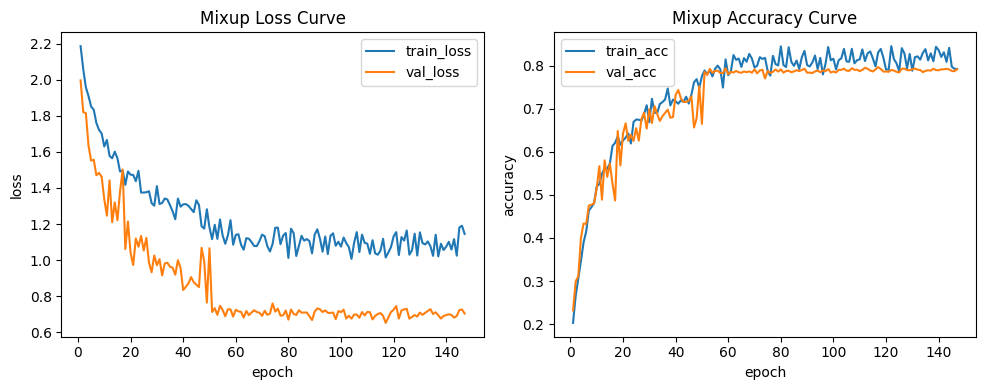

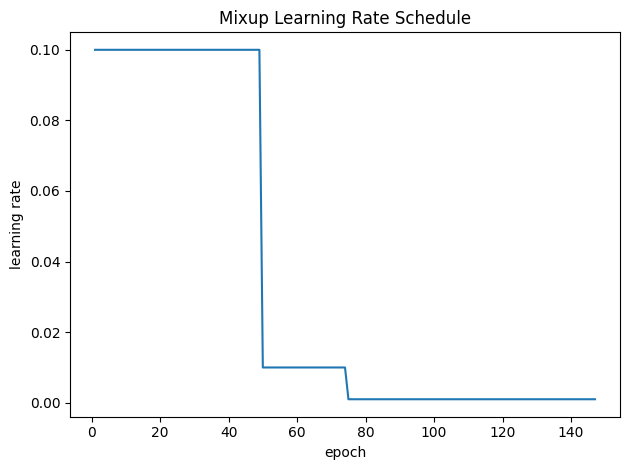


=== Model 5 Test Result ===
Accuracy: 0.797
F1 Score: 0.7971


In [26]:
# [Model 5] Balanced Mixup (Sampler + Mixup 결합)

# 1. Sampler 설정 (Model 2에서 가져옴)
from torch.utils.data import WeightedRandomSampler

targets = np.array(train_full.targets)[imbalanced_train.indices]
class_counts = [5000] + [500] * 9
class_weights_list = [1.0 / c for c in class_counts]
sample_weights = [class_weights_list[t] for t in targets]
sample_weights = torch.DoubleTensor(sample_weights)

# 500개짜리 클래스를 5000개처럼 뻥튀기해서 뽑음
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# 2. Sampler가 적용된 DataLoader (shuffle=False 필수)
# 이 로더는 매 배치마다 클래스 비율이 거의 1:1:1... 로 균형 잡혀서 나옵니다.
balanced_loader = DataLoader(imbalanced_train, batch_size=128, shuffle=False,
                             num_workers=2, sampler=sampler)

# 3. 모델 및 학습 설정
model_balanced_mixup = build_resnet20(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

# Mixup은 데이터 변형이 심하므로 학습을 길게 가져가는 게 좋지만,
# 여기서는 수렴 속도를 위해 lr 스케줄을 유지합니다.
optimizer = optim.SGD(model_balanced_mixup.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

print("\n================ Train Model 5 (Balanced Mixup) ================")

# [핵심] DataLoader는 Sampler가 적용된 것을 쓰고, 학습 함수는 Mixup을 씁니다.
early_stopping_mixup(balanced_loader, test_loader_cifar10, model_balanced_mixup, criterion, optimizer, scheduler,
                     patience=30, save_path="model_balanced_mixup.pth")

# 평가
model_balanced_mixup.load_state_dict(torch.load("model_balanced_mixup.pth"))
bm_acc, bm_f1, bm_loss = evaluate(test_loader_cifar10, model_balanced_mixup, criterion)

print("\n=== Model 5 Test Result ===")
print("Accuracy:", round(bm_acc, 4))
print("F1 Score:", round(bm_f1, 4)) # 목표: 0.80 이상

In [ ]:

================ Train Model 5 (Balanced Mixup) ================
  0%|          | 1/200 [00:03<11:08,  3.36s/it]epoch:0   train_loss=2.1863 train_acc=0.2027 val_loss=1.9967 val_acc=0.2318 val_f1=0.1742 lr=0.1
  1%|          | 2/200 [00:06<10:51,  3.29s/it]epoch:1   train_loss=2.0592 train_acc=0.2657 val_loss=1.8208 val_acc=0.2989 val_f1=0.2555 lr=0.1
  2%|▏         | 3/200 [00:09<10:49,  3.30s/it]epoch:2   train_loss=1.9583 train_acc=0.3063 val_loss=1.8150 val_acc=0.3112 val_f1=0.2665 lr=0.1
  2%|▏         | 4/200 [00:13<10:46,  3.30s/it]epoch:3   train_loss=1.9102 train_acc=0.3462 val_loss=1.6358 val_acc=0.4000 val_f1=0.3861 lr=0.1
  2%|▎         | 5/200 [00:16<10:40,  3.28s/it]epoch:4   train_loss=1.8516 train_acc=0.3896 val_loss=1.5517 val_acc=0.4335 val_f1=0.4183 lr=0.1
  3%|▎         | 6/200 [00:19<10:35,  3.28s/it]epoch:5   train_loss=1.8338 train_acc=0.4152 val_loss=1.5567 val_acc=0.4327 val_f1=0.4243 lr=0.1
  4%|▎         | 7/200 [00:23<10:34,  3.29s/it]epoch:6   train_loss=1.7605 train_acc=0.4633 val_loss=1.4709 val_acc=0.4754 val_f1=0.4356 lr=0.1
  4%|▍         | 8/200 [00:26<10:34,  3.31s/it]epoch:7   train_loss=1.7222 train_acc=0.4719 val_loss=1.4834 val_acc=0.4771 val_f1=0.4461 lr=0.1
  4%|▍         | 9/200 [00:29<10:28,  3.29s/it]epoch:8   train_loss=1.7025 train_acc=0.4806 val_loss=1.4622 val_acc=0.4806 val_f1=0.4673 lr=0.1
  5%|▌         | 10/200 [00:32<10:22,  3.28s/it]epoch:9   train_loss=1.6299 train_acc=0.5194 val_loss=1.3372 val_acc=0.5157 val_f1=0.5166 lr=0.1
  6%|▌         | 11/200 [00:36<10:29,  3.33s/it]epoch:10  train_loss=1.6664 train_acc=0.5257 val_loss=1.2465 val_acc=0.5668 val_f1=0.5553 lr=0.1
  6%|▌         | 12/200 [00:39<10:20,  3.30s/it]epoch:11  train_loss=1.5781 train_acc=0.5486 val_loss=1.4421 val_acc=0.4890 val_f1=0.4682 lr=0.1
  6%|▋         | 13/200 [00:43<10:25,  3.35s/it]epoch:12  train_loss=1.5648 train_acc=0.5623 val_loss=1.2102 val_acc=0.5803 val_f1=0.5671 lr=0.1
  7%|▋         | 14/200 [00:46<10:30,  3.39s/it]epoch:13  train_loss=1.6016 train_acc=0.5606 val_loss=1.3200 val_acc=0.5419 val_f1=0.5242 lr=0.1
  8%|▊         | 15/200 [00:49<10:14,  3.32s/it]epoch:14  train_loss=1.5645 train_acc=0.5731 val_loss=1.2215 val_acc=0.5730 val_f1=0.5537 lr=0.1
  8%|▊         | 16/200 [00:53<10:20,  3.37s/it]epoch:15  train_loss=1.4915 train_acc=0.6138 val_loss=1.3822 val_acc=0.5261 val_f1=0.4932 lr=0.1
  8%|▊         | 17/200 [00:56<10:12,  3.35s/it]epoch:16  train_loss=1.4964 train_acc=0.6211 val_loss=1.5026 val_acc=0.4870 val_f1=0.4614 lr=0.1
  9%|▉         | 18/200 [00:59<10:14,  3.38s/it]epoch:17  train_loss=1.4175 train_acc=0.6362 val_loss=1.0615 val_acc=0.6487 val_f1=0.6398 lr=0.1
 10%|▉         | 19/200 [01:03<10:01,  3.32s/it]epoch:18  train_loss=1.4916 train_acc=0.6165 val_loss=1.2144 val_acc=0.5685 val_f1=0.5602 lr=0.1
 10%|█         | 20/200 [01:06<09:51,  3.29s/it]epoch:19  train_loss=1.4736 train_acc=0.6267 val_loss=1.0401 val_acc=0.6429 val_f1=0.6423 lr=0.1
 10%|█         | 21/200 [01:10<10:12,  3.42s/it]epoch:20  train_loss=1.4724 train_acc=0.6333 val_loss=0.9728 val_acc=0.6663 val_f1=0.6688 lr=0.1
 11%|█         | 22/200 [01:13<10:09,  3.42s/it]epoch:21  train_loss=1.4377 train_acc=0.6428 val_loss=1.1204 val_acc=0.6259 val_f1=0.6148 lr=0.1
 12%|█▏        | 23/200 [01:16<09:56,  3.37s/it]epoch:22  train_loss=1.4952 train_acc=0.6195 val_loss=1.0743 val_acc=0.6398 val_f1=0.6304 lr=0.1
 12%|█▏        | 24/200 [01:20<10:00,  3.41s/it]epoch:23  train_loss=1.3748 train_acc=0.6695 val_loss=1.1345 val_acc=0.6255 val_f1=0.6200 lr=0.1
 12%|█▎        | 25/200 [01:23<09:46,  3.35s/it]epoch:24  train_loss=1.3748 train_acc=0.6753 val_loss=1.0532 val_acc=0.6552 val_f1=0.6509 lr=0.1
 13%|█▎        | 26/200 [01:26<09:44,  3.36s/it]epoch:25  train_loss=1.3765 train_acc=0.6748 val_loss=1.1232 val_acc=0.6263 val_f1=0.6157 lr=0.1
 14%|█▎        | 27/200 [01:29<09:31,  3.30s/it]epoch:26  train_loss=1.3822 train_acc=0.6724 val_loss=0.9856 val_acc=0.6766 val_f1=0.6824 lr=0.1
 14%|█▍        | 28/200 [01:33<09:31,  3.32s/it]epoch:27  train_loss=1.3159 train_acc=0.6876 val_loss=0.9332 val_acc=0.6908 val_f1=0.6963 lr=0.1
 14%|█▍        | 29/200 [01:36<09:19,  3.27s/it]epoch:28  train_loss=1.3016 train_acc=0.7084 val_loss=1.0257 val_acc=0.6543 val_f1=0.6491 lr=0.1
 15%|█▌        | 30/200 [01:39<09:27,  3.34s/it]epoch:29  train_loss=1.4101 train_acc=0.6691 val_loss=0.9720 val_acc=0.6990 val_f1=0.6969 lr=0.1
 16%|█▌        | 31/200 [01:43<09:31,  3.38s/it]epoch:30  train_loss=1.3112 train_acc=0.7235 val_loss=1.0052 val_acc=0.6671 val_f1=0.6613 lr=0.1
 16%|█▌        | 32/200 [01:46<09:29,  3.39s/it]epoch:31  train_loss=1.3171 train_acc=0.6911 val_loss=0.9152 val_acc=0.7064 val_f1=0.7088 lr=0.1
 16%|█▋        | 33/200 [01:50<09:17,  3.34s/it]epoch:32  train_loss=1.3418 train_acc=0.6901 val_loss=0.9815 val_acc=0.6880 val_f1=0.6844 lr=0.1
 17%|█▋        | 34/200 [01:53<09:07,  3.30s/it]epoch:33  train_loss=1.3362 train_acc=0.7113 val_loss=0.9856 val_acc=0.6720 val_f1=0.6824 lr=0.1
 18%|█▊        | 35/200 [01:56<09:05,  3.31s/it]epoch:34  train_loss=1.3044 train_acc=0.7158 val_loss=0.9633 val_acc=0.6828 val_f1=0.6811 lr=0.1
 18%|█▊        | 36/200 [01:59<08:56,  3.27s/it]epoch:35  train_loss=1.2702 train_acc=0.7218 val_loss=0.9581 val_acc=0.6908 val_f1=0.6829 lr=0.1
 18%|█▊        | 37/200 [02:03<08:51,  3.26s/it]epoch:36  train_loss=1.2267 train_acc=0.7475 val_loss=0.9191 val_acc=0.6980 val_f1=0.6921 lr=0.1
 19%|█▉        | 38/200 [02:06<09:01,  3.34s/it]epoch:37  train_loss=1.3416 train_acc=0.7080 val_loss=0.9998 val_acc=0.6793 val_f1=0.6686 lr=0.1
 20%|█▉        | 39/200 [02:10<09:11,  3.42s/it]epoch:38  train_loss=1.2964 train_acc=0.7215 val_loss=0.9568 val_acc=0.6809 val_f1=0.6829 lr=0.1
 20%|██        | 40/200 [02:13<09:09,  3.44s/it]epoch:39  train_loss=1.3092 train_acc=0.7177 val_loss=0.8342 val_acc=0.7324 val_f1=0.7331 lr=0.1
 20%|██        | 41/200 [02:17<09:09,  3.45s/it]epoch:40  train_loss=1.3107 train_acc=0.7119 val_loss=0.8518 val_acc=0.7438 val_f1=0.7411 lr=0.1
 21%|██        | 42/200 [02:20<08:58,  3.41s/it]epoch:41  train_loss=1.3014 train_acc=0.7198 val_loss=0.8711 val_acc=0.7247 val_f1=0.7271 lr=0.1
 22%|██▏       | 43/200 [02:23<08:45,  3.34s/it]epoch:42  train_loss=1.2839 train_acc=0.7160 val_loss=0.9062 val_acc=0.7160 val_f1=0.7139 lr=0.1
 22%|██▏       | 44/200 [02:26<08:36,  3.31s/it]epoch:43  train_loss=1.2660 train_acc=0.7283 val_loss=0.8781 val_acc=0.7163 val_f1=0.7160 lr=0.1
 22%|██▎       | 45/200 [02:30<08:32,  3.30s/it]epoch:44  train_loss=1.3320 train_acc=0.7123 val_loss=0.8639 val_acc=0.7189 val_f1=0.7137 lr=0.1
 23%|██▎       | 46/200 [02:33<08:27,  3.29s/it]epoch:45  train_loss=1.3061 train_acc=0.7331 val_loss=0.8506 val_acc=0.7289 val_f1=0.7268 lr=0.1
 24%|██▎       | 47/200 [02:36<08:31,  3.34s/it]epoch:46  train_loss=1.1875 train_acc=0.7618 val_loss=1.0682 val_acc=0.6567 val_f1=0.6410 lr=0.1
 24%|██▍       | 48/200 [02:40<08:23,  3.31s/it]epoch:47  train_loss=1.1749 train_acc=0.7691 val_loss=0.9935 val_acc=0.6784 val_f1=0.6855 lr=0.1
 24%|██▍       | 49/200 [02:43<08:15,  3.28s/it]epoch:48  train_loss=1.2821 train_acc=0.7488 val_loss=0.7644 val_acc=0.7529 val_f1=0.7521 lr=0.1
 25%|██▌       | 50/200 [02:46<08:07,  3.25s/it]epoch:49  train_loss=1.1807 train_acc=0.7759 val_loss=1.0660 val_acc=0.6652 val_f1=0.6638 lr=0.010000000000000002
 26%|██▌       | 51/200 [02:49<08:02,  3.24s/it]epoch:50  train_loss=1.1165 train_acc=0.7891 val_loss=0.7126 val_acc=0.7857 val_f1=0.7854 lr=0.010000000000000002
 26%|██▌       | 52/200 [02:53<08:02,  3.26s/it]epoch:51  train_loss=1.1961 train_acc=0.7804 val_loss=0.7336 val_acc=0.7790 val_f1=0.7782 lr=0.010000000000000002
 26%|██▋       | 53/200 [02:56<07:59,  3.26s/it]epoch:52  train_loss=1.1180 train_acc=0.7895 val_loss=0.6966 val_acc=0.7929 val_f1=0.7926 lr=0.010000000000000002
 27%|██▋       | 54/200 [02:59<07:56,  3.26s/it]epoch:53  train_loss=1.2257 train_acc=0.7754 val_loss=0.7469 val_acc=0.7838 val_f1=0.7815 lr=0.010000000000000002
 28%|██▊       | 55/200 [03:02<07:53,  3.26s/it]epoch:54  train_loss=1.1368 train_acc=0.7931 val_loss=0.7240 val_acc=0.7882 val_f1=0.7877 lr=0.010000000000000002
 28%|██▊       | 56/200 [03:06<07:58,  3.32s/it]epoch:55  train_loss=1.0907 train_acc=0.8005 val_loss=0.6888 val_acc=0.7887 val_f1=0.7885 lr=0.010000000000000002
 28%|██▊       | 57/200 [03:09<07:52,  3.31s/it]epoch:56  train_loss=1.1369 train_acc=0.7917 val_loss=0.7272 val_acc=0.7834 val_f1=0.7825 lr=0.010000000000000002
 29%|██▉       | 58/200 [03:12<07:46,  3.28s/it]epoch:57  train_loss=1.2216 train_acc=0.7495 val_loss=0.7269 val_acc=0.7832 val_f1=0.7822 lr=0.010000000000000002
 30%|██▉       | 59/200 [03:16<07:48,  3.33s/it]epoch:58  train_loss=1.0856 train_acc=0.8149 val_loss=0.6870 val_acc=0.7943 val_f1=0.7936 lr=0.010000000000000002
 30%|███       | 60/200 [03:19<07:41,  3.30s/it]epoch:59  train_loss=1.1402 train_acc=0.7783 val_loss=0.7246 val_acc=0.7806 val_f1=0.7794 lr=0.010000000000000002
 30%|███       | 61/200 [03:22<07:33,  3.27s/it]epoch:60  train_loss=1.1436 train_acc=0.7868 val_loss=0.7162 val_acc=0.7859 val_f1=0.7856 lr=0.010000000000000002
 31%|███       | 62/200 [03:26<07:36,  3.31s/it]epoch:61  train_loss=1.0856 train_acc=0.8251 val_loss=0.7132 val_acc=0.7844 val_f1=0.7839 lr=0.010000000000000002
 32%|███▏      | 63/200 [03:29<07:30,  3.29s/it]epoch:62  train_loss=1.0578 train_acc=0.8138 val_loss=0.6815 val_acc=0.7881 val_f1=0.7880 lr=0.010000000000000002
 32%|███▏      | 64/200 [03:32<07:22,  3.26s/it]epoch:63  train_loss=1.1218 train_acc=0.8168 val_loss=0.7181 val_acc=0.7850 val_f1=0.7833 lr=0.010000000000000002
 32%|███▎      | 65/200 [03:35<07:15,  3.23s/it]epoch:64  train_loss=1.1186 train_acc=0.7975 val_loss=0.6951 val_acc=0.7839 val_f1=0.7835 lr=0.010000000000000002
 33%|███▎      | 66/200 [03:39<07:22,  3.30s/it]epoch:65  train_loss=1.0999 train_acc=0.8179 val_loss=0.7098 val_acc=0.7869 val_f1=0.7865 lr=0.010000000000000002
 34%|███▎      | 67/200 [03:42<07:15,  3.28s/it]epoch:66  train_loss=1.0783 train_acc=0.8095 val_loss=0.7222 val_acc=0.7853 val_f1=0.7825 lr=0.010000000000000002
 34%|███▍      | 68/200 [03:45<07:08,  3.24s/it]epoch:67  train_loss=1.0780 train_acc=0.8277 val_loss=0.7120 val_acc=0.7871 val_f1=0.7865 lr=0.010000000000000002
 34%|███▍      | 69/200 [03:48<07:02,  3.23s/it]epoch:68  train_loss=1.1058 train_acc=0.8169 val_loss=0.7087 val_acc=0.7839 val_f1=0.7841 lr=0.010000000000000002
 35%|███▌      | 70/200 [03:51<07:00,  3.23s/it]epoch:69  train_loss=1.1416 train_acc=0.7961 val_loss=0.6909 val_acc=0.7919 val_f1=0.7917 lr=0.010000000000000002
 36%|███▌      | 71/200 [03:55<06:57,  3.24s/it]epoch:70  train_loss=1.1327 train_acc=0.8003 val_loss=0.7195 val_acc=0.7825 val_f1=0.7804 lr=0.010000000000000002
 36%|███▌      | 72/200 [03:58<06:54,  3.24s/it]epoch:71  train_loss=1.0770 train_acc=0.8201 val_loss=0.6968 val_acc=0.7893 val_f1=0.7878 lr=0.010000000000000002
 36%|███▋      | 73/200 [04:01<07:03,  3.33s/it]epoch:72  train_loss=1.0478 train_acc=0.8160 val_loss=0.7035 val_acc=0.7909 val_f1=0.7907 lr=0.010000000000000002
 37%|███▋      | 74/200 [04:05<06:54,  3.29s/it]epoch:73  train_loss=1.0899 train_acc=0.8184 val_loss=0.7600 val_acc=0.7707 val_f1=0.7690 lr=0.010000000000000002
 38%|███▊      | 75/200 [04:08<06:50,  3.28s/it]epoch:74  train_loss=1.1793 train_acc=0.7881 val_loss=0.7145 val_acc=0.7879 val_f1=0.7877 lr=0.0010000000000000002
 38%|███▊      | 76/200 [04:11<06:55,  3.35s/it]epoch:75  train_loss=1.1803 train_acc=0.7772 val_loss=0.7312 val_acc=0.7835 val_f1=0.7827 lr=0.0010000000000000002
 38%|███▊      | 77/200 [04:15<06:54,  3.37s/it]epoch:76  train_loss=1.0883 train_acc=0.8232 val_loss=0.6920 val_acc=0.7861 val_f1=0.7854 lr=0.0010000000000000002
 39%|███▉      | 78/200 [04:18<06:51,  3.37s/it]epoch:77  train_loss=1.1360 train_acc=0.8039 val_loss=0.6942 val_acc=0.7916 val_f1=0.7911 lr=0.0010000000000000002
 40%|███▉      | 79/200 [04:22<06:44,  3.34s/it]epoch:78  train_loss=1.1506 train_acc=0.8009 val_loss=0.7208 val_acc=0.7865 val_f1=0.7852 lr=0.0010000000000000002
 40%|████      | 80/200 [04:25<06:51,  3.43s/it]epoch:79  train_loss=1.0121 train_acc=0.8453 val_loss=0.6702 val_acc=0.7919 val_f1=0.7909 lr=0.0010000000000000002
 40%|████      | 81/200 [04:28<06:40,  3.37s/it]epoch:80  train_loss=1.1740 train_acc=0.8019 val_loss=0.7261 val_acc=0.7841 val_f1=0.7830 lr=0.0010000000000000002
 41%|████      | 82/200 [04:32<06:33,  3.34s/it]epoch:81  train_loss=1.1501 train_acc=0.7973 val_loss=0.7021 val_acc=0.7881 val_f1=0.7874 lr=0.0010000000000000002
 42%|████▏     | 83/200 [04:35<06:34,  3.37s/it]epoch:82  train_loss=1.0227 train_acc=0.8432 val_loss=0.6960 val_acc=0.7883 val_f1=0.7878 lr=0.0010000000000000002
 42%|████▏     | 84/200 [04:38<06:28,  3.35s/it]epoch:83  train_loss=1.0780 train_acc=0.8091 val_loss=0.7222 val_acc=0.7852 val_f1=0.7847 lr=0.0010000000000000002
 42%|████▎     | 85/200 [04:42<06:21,  3.32s/it]epoch:84  train_loss=1.1348 train_acc=0.7999 val_loss=0.7089 val_acc=0.7870 val_f1=0.7861 lr=0.0010000000000000002
 43%|████▎     | 86/200 [04:45<06:24,  3.37s/it]epoch:85  train_loss=1.1081 train_acc=0.8123 val_loss=0.7090 val_acc=0.7899 val_f1=0.7889 lr=0.0010000000000000002
 44%|████▎     | 87/200 [04:48<06:21,  3.37s/it]epoch:86  train_loss=1.1168 train_acc=0.7926 val_loss=0.7096 val_acc=0.7877 val_f1=0.7871 lr=0.0010000000000000002
 44%|████▍     | 88/200 [04:52<06:12,  3.33s/it]epoch:87  train_loss=1.1055 train_acc=0.8202 val_loss=0.6883 val_acc=0.7903 val_f1=0.7898 lr=0.0010000000000000002
 44%|████▍     | 89/200 [04:55<06:07,  3.31s/it]epoch:88  train_loss=1.0374 train_acc=0.8347 val_loss=0.6679 val_acc=0.7933 val_f1=0.7925 lr=0.0010000000000000002
 45%|████▌     | 90/200 [04:58<06:09,  3.36s/it]epoch:89  train_loss=1.1419 train_acc=0.8016 val_loss=0.7149 val_acc=0.7841 val_f1=0.7829 lr=0.0010000000000000002
 46%|████▌     | 91/200 [05:02<06:02,  3.33s/it]epoch:90  train_loss=1.1710 train_acc=0.7985 val_loss=0.7324 val_acc=0.7842 val_f1=0.7834 lr=0.0010000000000000002
 46%|████▌     | 92/200 [05:05<05:56,  3.30s/it]epoch:91  train_loss=1.1191 train_acc=0.8079 val_loss=0.7275 val_acc=0.7833 val_f1=0.7820 lr=0.0010000000000000002
 46%|████▋     | 93/200 [05:08<05:50,  3.28s/it]epoch:92  train_loss=1.0468 train_acc=0.8239 val_loss=0.7123 val_acc=0.7871 val_f1=0.7864 lr=0.0010000000000000002
 47%|████▋     | 94/200 [05:12<05:52,  3.33s/it]epoch:93  train_loss=1.1312 train_acc=0.7923 val_loss=0.7214 val_acc=0.7889 val_f1=0.7878 lr=0.0010000000000000002
 48%|████▊     | 95/200 [05:15<05:50,  3.33s/it]epoch:94  train_loss=1.0335 train_acc=0.8185 val_loss=0.7077 val_acc=0.7851 val_f1=0.7844 lr=0.0010000000000000002
 48%|████▊     | 96/200 [05:18<05:44,  3.31s/it]epoch:95  train_loss=1.1355 train_acc=0.7801 val_loss=0.7075 val_acc=0.7895 val_f1=0.7887 lr=0.0010000000000000002
 48%|████▊     | 97/200 [05:22<05:42,  3.32s/it]epoch:96  train_loss=1.1487 train_acc=0.8049 val_loss=0.7094 val_acc=0.7876 val_f1=0.7868 lr=0.0010000000000000002
 49%|████▉     | 98/200 [05:25<05:43,  3.37s/it]epoch:97  train_loss=1.0797 train_acc=0.8437 val_loss=0.6729 val_acc=0.7925 val_f1=0.7920 lr=0.0010000000000000002
 50%|████▉     | 99/200 [05:28<05:41,  3.38s/it]epoch:98  train_loss=1.1019 train_acc=0.8129 val_loss=0.7179 val_acc=0.7846 val_f1=0.7835 lr=0.0010000000000000002
 50%|█████     | 100/200 [05:32<05:32,  3.32s/it]epoch:99  train_loss=1.0749 train_acc=0.8164 val_loss=0.7116 val_acc=0.7869 val_f1=0.7865 lr=0.0010000000000000002
 50%|█████     | 101/200 [05:35<05:34,  3.38s/it]epoch:100 train_loss=1.1255 train_acc=0.7917 val_loss=0.7254 val_acc=0.7844 val_f1=0.7832 lr=0.0010000000000000002
 51%|█████     | 102/200 [05:38<05:24,  3.31s/it]epoch:101 train_loss=1.0944 train_acc=0.8132 val_loss=0.6762 val_acc=0.7907 val_f1=0.7903 lr=0.0010000000000000002
 52%|█████▏    | 103/200 [05:42<05:18,  3.28s/it]epoch:102 train_loss=1.0716 train_acc=0.8174 val_loss=0.6917 val_acc=0.7906 val_f1=0.7900 lr=0.0010000000000000002
 52%|█████▏    | 104/200 [05:45<05:25,  3.39s/it]epoch:103 train_loss=1.0068 train_acc=0.8394 val_loss=0.6756 val_acc=0.7935 val_f1=0.7931 lr=0.0010000000000000002
 52%|█████▎    | 105/200 [05:48<05:19,  3.36s/it]epoch:104 train_loss=1.0966 train_acc=0.8101 val_loss=0.6987 val_acc=0.7887 val_f1=0.7881 lr=0.0010000000000000002
 53%|█████▎    | 106/200 [05:52<05:13,  3.34s/it]epoch:105 train_loss=1.1556 train_acc=0.8095 val_loss=0.6982 val_acc=0.7882 val_f1=0.7875 lr=0.0010000000000000002
 54%|█████▎    | 107/200 [05:55<05:09,  3.32s/it]epoch:106 train_loss=1.0448 train_acc=0.8396 val_loss=0.6806 val_acc=0.7945 val_f1=0.7940 lr=0.0010000000000000002
 54%|█████▍    | 108/200 [05:58<05:02,  3.29s/it]epoch:107 train_loss=1.1413 train_acc=0.8058 val_loss=0.7120 val_acc=0.7907 val_f1=0.7895 lr=0.0010000000000000002
 55%|█████▍    | 109/200 [06:01<04:56,  3.26s/it]epoch:108 train_loss=1.0960 train_acc=0.8131 val_loss=0.6936 val_acc=0.7909 val_f1=0.7900 lr=0.0010000000000000002
 55%|█████▌    | 110/200 [06:05<04:53,  3.26s/it]epoch:109 train_loss=1.0912 train_acc=0.8151 val_loss=0.7124 val_acc=0.7876 val_f1=0.7864 lr=0.0010000000000000002
 56%|█████▌    | 111/200 [06:08<04:54,  3.31s/it]epoch:110 train_loss=1.0349 train_acc=0.8382 val_loss=0.7114 val_acc=0.7907 val_f1=0.7896 lr=0.0010000000000000002
 56%|█████▌    | 112/200 [06:11<04:47,  3.27s/it]epoch:111 train_loss=1.1106 train_acc=0.8111 val_loss=0.6713 val_acc=0.7954 val_f1=0.7948 lr=0.0010000000000000002
 56%|█████▋    | 113/200 [06:14<04:42,  3.25s/it]epoch:112 train_loss=1.0372 train_acc=0.8292 val_loss=0.6910 val_acc=0.7932 val_f1=0.7929 lr=0.0010000000000000002
 57%|█████▋    | 114/200 [06:18<04:41,  3.27s/it]epoch:113 train_loss=1.0302 train_acc=0.8335 val_loss=0.7013 val_acc=0.7890 val_f1=0.7881 lr=0.0010000000000000002
 57%|█████▊    | 115/200 [06:21<04:40,  3.30s/it]epoch:114 train_loss=1.0525 train_acc=0.8172 val_loss=0.7066 val_acc=0.7869 val_f1=0.7861 lr=0.0010000000000000002
 58%|█████▊    | 116/200 [06:24<04:34,  3.27s/it]epoch:115 train_loss=1.1184 train_acc=0.7987 val_loss=0.6913 val_acc=0.7917 val_f1=0.7907 lr=0.0010000000000000002
 58%|█████▊    | 117/200 [06:28<04:31,  3.28s/it]epoch:116 train_loss=1.0147 train_acc=0.8312 val_loss=0.6521 val_acc=0.7970 val_f1=0.7971 lr=0.0010000000000000002
 59%|█████▉    | 118/200 [06:31<04:29,  3.29s/it]epoch:117 train_loss=1.0421 train_acc=0.8392 val_loss=0.6818 val_acc=0.7927 val_f1=0.7919 lr=0.0010000000000000002
 60%|█████▉    | 119/200 [06:34<04:29,  3.33s/it]epoch:118 train_loss=1.0718 train_acc=0.8188 val_loss=0.7118 val_acc=0.7865 val_f1=0.7851 lr=0.0010000000000000002
 60%|██████    | 120/200 [06:38<04:23,  3.30s/it]epoch:119 train_loss=1.1312 train_acc=0.7917 val_loss=0.7253 val_acc=0.7870 val_f1=0.7863 lr=0.0010000000000000002
 60%|██████    | 121/200 [06:41<04:21,  3.31s/it]epoch:120 train_loss=1.1554 train_acc=0.7908 val_loss=0.7453 val_acc=0.7860 val_f1=0.7845 lr=0.0010000000000000002
 61%|██████    | 122/200 [06:45<04:25,  3.40s/it]epoch:121 train_loss=1.0281 train_acc=0.8457 val_loss=0.6763 val_acc=0.7905 val_f1=0.7905 lr=0.0010000000000000002
 62%|██████▏   | 123/200 [06:48<04:27,  3.47s/it]epoch:122 train_loss=1.1278 train_acc=0.8155 val_loss=0.7211 val_acc=0.7890 val_f1=0.7878 lr=0.0010000000000000002
 62%|██████▏   | 124/200 [06:52<04:21,  3.44s/it]epoch:123 train_loss=1.1086 train_acc=0.8058 val_loss=0.7270 val_acc=0.7860 val_f1=0.7844 lr=0.0010000000000000002
 62%|██████▎   | 125/200 [06:55<04:19,  3.46s/it]epoch:124 train_loss=1.1645 train_acc=0.7876 val_loss=0.7301 val_acc=0.7846 val_f1=0.7838 lr=0.0010000000000000002
 63%|██████▎   | 126/200 [06:58<04:12,  3.42s/it]epoch:125 train_loss=1.0303 train_acc=0.8411 val_loss=0.6756 val_acc=0.7932 val_f1=0.7925 lr=0.0010000000000000002
 64%|██████▎   | 127/200 [07:02<04:06,  3.38s/it]epoch:126 train_loss=1.0549 train_acc=0.8285 val_loss=0.6853 val_acc=0.7934 val_f1=0.7921 lr=0.0010000000000000002
 64%|██████▍   | 128/200 [07:05<04:00,  3.34s/it]epoch:127 train_loss=1.1467 train_acc=0.7939 val_loss=0.6958 val_acc=0.7900 val_f1=0.7889 lr=0.0010000000000000002
 64%|██████▍   | 129/200 [07:08<03:58,  3.35s/it]epoch:128 train_loss=1.0255 train_acc=0.8277 val_loss=0.6873 val_acc=0.7898 val_f1=0.7889 lr=0.0010000000000000002
 65%|██████▌   | 130/200 [07:12<03:51,  3.31s/it]epoch:129 train_loss=1.1542 train_acc=0.7885 val_loss=0.7094 val_acc=0.7920 val_f1=0.7907 lr=0.0010000000000000002
 66%|██████▌   | 131/200 [07:15<03:47,  3.30s/it]epoch:130 train_loss=1.0946 train_acc=0.8201 val_loss=0.6964 val_acc=0.7938 val_f1=0.7926 lr=0.0010000000000000002
 66%|██████▌   | 132/200 [07:18<03:49,  3.37s/it]epoch:131 train_loss=1.0868 train_acc=0.8220 val_loss=0.7078 val_acc=0.7911 val_f1=0.7904 lr=0.0010000000000000002
 66%|██████▋   | 133/200 [07:22<03:43,  3.33s/it]epoch:132 train_loss=1.1035 train_acc=0.8144 val_loss=0.7179 val_acc=0.7902 val_f1=0.7890 lr=0.0010000000000000002
 67%|██████▋   | 134/200 [07:25<03:37,  3.29s/it]epoch:133 train_loss=1.0773 train_acc=0.8302 val_loss=0.7282 val_acc=0.7853 val_f1=0.7845 lr=0.0010000000000000002
 68%|██████▊   | 135/200 [07:28<03:37,  3.35s/it]epoch:134 train_loss=1.0238 train_acc=0.8387 val_loss=0.7011 val_acc=0.7884 val_f1=0.7881 lr=0.0010000000000000002
 68%|██████▊   | 136/200 [07:32<03:31,  3.31s/it]epoch:135 train_loss=1.1408 train_acc=0.8126 val_loss=0.7109 val_acc=0.7896 val_f1=0.7889 lr=0.0010000000000000002
 68%|██████▊   | 137/200 [07:35<03:25,  3.26s/it]epoch:136 train_loss=1.0210 train_acc=0.8291 val_loss=0.6945 val_acc=0.7889 val_f1=0.7883 lr=0.0010000000000000002
 69%|██████▉   | 138/200 [07:38<03:25,  3.31s/it]epoch:137 train_loss=1.0910 train_acc=0.8105 val_loss=0.6759 val_acc=0.7931 val_f1=0.7932 lr=0.0010000000000000002
 70%|██████▉   | 139/200 [07:41<03:23,  3.33s/it]epoch:138 train_loss=1.0563 train_acc=0.8442 val_loss=0.6905 val_acc=0.7902 val_f1=0.7896 lr=0.0010000000000000002
 70%|███████   | 140/200 [07:45<03:19,  3.33s/it]epoch:139 train_loss=1.0746 train_acc=0.8366 val_loss=0.6954 val_acc=0.7896 val_f1=0.7887 lr=0.0010000000000000002
 70%|███████   | 141/200 [07:48<03:19,  3.38s/it]epoch:140 train_loss=1.1016 train_acc=0.8207 val_loss=0.6998 val_acc=0.7919 val_f1=0.7912 lr=0.0010000000000000002
 71%|███████   | 142/200 [07:52<03:16,  3.39s/it]epoch:141 train_loss=1.0587 train_acc=0.8315 val_loss=0.6960 val_acc=0.7918 val_f1=0.7913 lr=0.0010000000000000002
 72%|███████▏  | 143/200 [07:55<03:14,  3.41s/it]epoch:142 train_loss=1.1164 train_acc=0.8092 val_loss=0.6810 val_acc=0.7931 val_f1=0.7923 lr=0.0010000000000000002
 72%|███████▏  | 144/200 [07:59<03:12,  3.44s/it]epoch:143 train_loss=1.0248 train_acc=0.8418 val_loss=0.6902 val_acc=0.7916 val_f1=0.7910 lr=0.0010000000000000002
 72%|███████▎  | 145/200 [08:02<03:06,  3.40s/it]epoch:144 train_loss=1.1812 train_acc=0.7979 val_loss=0.7228 val_acc=0.7882 val_f1=0.7875 lr=0.0010000000000000002
 73%|███████▎  | 146/200 [08:05<03:00,  3.34s/it]epoch:145 train_loss=1.1909 train_acc=0.7932 val_loss=0.7264 val_acc=0.7874 val_f1=0.7866 lr=0.0010000000000000002
 73%|███████▎  | 146/200 [08:08<03:00,  3.35s/it]epoch:146 train_loss=1.1452 train_acc=0.7927 val_loss=0.7041 val_acc=0.7921 val_f1=0.7912 lr=0.0010000000000000002
Early stopping!

[Mixup Learning Curve] Train Loss: [2.1863275899385153, 2.0591910202126753, 1.9582504134931062, 1.910180313562092, 1.8516331702282554, 1.833838577320701, 1.7604923946982936, 1.722172550201416, 1.7024950146424143, 1.6298999370775724, 1.6664403420498497, 1.5781294413114848, 1.5647764131646407, 1.6015996599699323, 1.5645300298991955, 1.4915200885973479, 1.4963905989998265, 1.4174862489198383, 1.491593795475207, 1.4735903829273425, 1.4723828423650642, 1.4377443723176655, 1.4952088485015067, 1.3747513502020585, 1.37480453566501, 1.3765154567015798, 1.3822080679441753, 1.3158922053889224, 1.301604773722197, 1.410146158921091, 1.3111819627661454, 1.3170729127683138, 1.3418009820235404, 1.336174859950417, 1.304394500230488, 1.270159087532445, 1.2267207187853362, 1.3415956902253001, 1.2964494657014545, 1.3091920908877723, 1.310734206350226, 1.3014226469742625, 1.283872300900911, 1.2659579249432213, 1.3319886476115177, 1.3061467412647447, 1.187466499830547, 1.1749075500212218, 1.2821253355929727, 1.180691312789917, 1.1165005849537097, 1.1960893059780724, 1.117984552534003, 1.2256536323145817, 1.1367681812487151, 1.0907200986962569, 1.136945717761391, 1.2215976502769872, 1.0856180895755165, 1.1401854221946315, 1.1436209030653302, 1.085589868143985, 1.0577846537138287, 1.121771714963411, 1.1186057288521214, 1.0998961648690073, 1.0782786619788722, 1.0780329849845485, 1.1058287851559487, 1.1416037129351968, 1.1326564248737536, 1.0770458103983025, 1.0477803352506536, 1.0899421539808574, 1.1793455185137296, 1.180334066892925, 1.08829181440253, 1.1359950071636, 1.1505533074830707, 1.0120575352969923, 1.1739979607055062, 1.1500641501828244, 1.0226859023445531, 1.0780030537153544, 1.1347791403720253, 1.1081086115335164, 1.116762744200857, 1.105510941681109, 1.0374020187729283, 1.1419309809835334, 1.1710484078055934, 1.1190591206801566, 1.0467997849865964, 1.1311538084431698, 1.0335115587334884, 1.1355250732020328, 1.1486887348576595, 1.0796874151731792, 1.1019045873441193, 1.074902997242777, 1.1254928864679838, 1.0944489142518294, 1.071601838463231, 1.0067560712412784, 1.0965769437488757, 1.1555540359145717, 1.0447902437511243, 1.141275846079776, 1.0960233258197183, 1.091178696180645, 1.034934677977311, 1.1105885268763491, 1.037193313498246, 1.0302272614930805, 1.0524887030752081, 1.1183793020750348, 1.014727583232679, 1.0421193168037817, 1.0718402151810495, 1.1311971877750597, 1.155437738267999, 1.0280507444582487, 1.1278184462848462, 1.108572584854929, 1.1645338907241822, 1.0303279198094417, 1.0549281691501016, 1.146662783020421, 1.0254910622395967, 1.1542224300786068, 1.0945736382133082, 1.0868162766506797, 1.103542272605394, 1.077303242332057, 1.0237811824397036, 1.1408137113671555, 1.02104350878063, 1.0909889993667603, 1.0562709746988197, 1.0746461761876156, 1.1016390322886016, 1.0587158333125868, 1.116389641259846, 1.0247980885756642, 1.1811943445707622, 1.1909443264007569, 1.14524610019985]
[Mixup Learning Curve] Val Loss  : [1.99673625034622, 1.8207540029211888, 1.8149762621408776, 1.635803239255012, 1.55172926413862, 1.5566536595549765, 1.470936053915869, 1.483434779734551, 1.4621935267991657, 1.3371638059616089, 1.246485386468187, 1.4421247772023649, 1.2102152365672438, 1.3199762950969647, 1.2214866152292565, 1.3821735276451594, 1.502633226068714, 1.0614788479442838, 1.2144131539743157, 1.040082037448883, 0.972840459286412, 1.120431354528741, 1.0743219739274135, 1.1344503088842464, 1.053183852871762, 1.1231824868842015, 0.9856401478187947, 0.9331733267518538, 1.0257466088367413, 0.9720295305493512, 1.005230357375326, 0.9152376334878463, 0.9815292350853546, 0.9855606601208071, 0.9632573633254329, 0.9580689419673968, 0.9190867709208138, 0.9997970778730851, 0.9567571501188641, 0.8342278984528554, 0.8517988143087942, 0.8711103978036325, 0.9061675298063061, 0.8780960923508753, 0.863925917993618, 0.850642425349996, 1.0682150366940075, 0.9935206318203407, 0.7644110284274137, 1.06602633150318, 0.7126243627524074, 0.7335764863823033, 0.6965528266339363, 0.7469023828265033, 0.723987159095233, 0.68881797186936, 0.7272424909132945, 0.7269253059278561, 0.6869556564318983, 0.7246254750444919, 0.7161924657942373, 0.7132458241680001, 0.6814731993252718, 0.7181088999856876, 0.6950870522215397, 0.7098054795325557, 0.722207148618336, 0.7120047981225992, 0.7086845553373988, 0.6909383022332494, 0.7194702006593535, 0.6968405284459078, 0.703519035366517, 0.7600091642971281, 0.7145291974272909, 0.7312108180190944, 0.6920094263704517, 0.6941965486429915, 0.7208387414111367, 0.6701502339749397, 0.7260639788229254, 0.7020703833314437, 0.6959613972826849, 0.7221984395497962, 0.7089174129540408, 0.709032645708398, 0.7096044028861613, 0.6882538093796259, 0.667930377057836, 0.7148635236522819, 0.732366689398319, 0.7275259011908423, 0.7123429088652888, 0.7214232735996005, 0.7077312601518028, 0.7074918294254737, 0.7093829014633275, 0.6729097147531147, 0.71790204168875, 0.7115502538560312, 0.7254161427292642, 0.6761938963509813, 0.6916746210448349, 0.6755502963367896, 0.6986776741245125, 0.6981653654122655, 0.6805991907662983, 0.7120391281345223, 0.6936191380778446, 0.7124229465858846, 0.7113919718356072, 0.6712587223022799, 0.6909724368324762, 0.7012662555598006, 0.7066295592090751, 0.6913017883330961, 0.6521151767501349, 0.6817527949055538, 0.7117606831502311, 0.7253004229521449, 0.7452683192265185, 0.6763086481184899, 0.7211138387269611, 0.727031628165064, 0.7300800990454758, 0.6755744339544562, 0.6853032840203636, 0.6958027421673642, 0.6873349419123009, 0.709375192847433, 0.6964228270174582, 0.7078287684464757, 0.717932667158827, 0.7282489900347553, 0.7011271918876262, 0.7108511573906187, 0.6945446197745166, 0.6758963820300524, 0.6904943985275075, 0.6953698660753951, 0.6997927389567411, 0.6960359245915956, 0.6809638878212699, 0.6901785474789294, 0.7227819863753983, 0.7263574471956566, 0.7040674927868421]
[Mixup Learning Curve] Train Acc : [0.20273684210526316, 0.2656842105263158, 0.3063157894736842, 0.34621052631578947, 0.3895789473684211, 0.4151578947368421, 0.4632631578947368, 0.47189473684210526, 0.4806315789473684, 0.5193684210526316, 0.5256842105263158, 0.5486315789473685, 0.5623157894736842, 0.5606315789473684, 0.5730526315789474, 0.6137894736842106, 0.6210526315789474, 0.6362105263157894, 0.6165263157894737, 0.6267368421052631, 0.6332631578947369, 0.6428421052631579, 0.6194736842105263, 0.6694736842105263, 0.6752631578947368, 0.6748421052631579, 0.6724210526315789, 0.6875789473684211, 0.708421052631579, 0.6690526315789473, 0.7234736842105263, 0.6910526315789474, 0.6901052631578948, 0.7112631578947368, 0.7157894736842105, 0.7217894736842105, 0.7474736842105263, 0.708, 0.7214736842105263, 0.7176842105263158, 0.7118947368421052, 0.7197894736842105, 0.716, 0.7283157894736842, 0.7123157894736842, 0.7330526315789474, 0.7617894736842106, 0.7690526315789473, 0.7488421052631579, 0.7758947368421053, 0.7890526315789473, 0.7804210526315789, 0.7894736842105263, 0.7753684210526316, 0.7930526315789473, 0.8005263157894736, 0.7916842105263158, 0.7494736842105263, 0.8149473684210526, 0.7783157894736842, 0.7868421052631579, 0.8250526315789474, 0.8137894736842105, 0.8168421052631579, 0.7974736842105263, 0.8178947368421052, 0.8094736842105263, 0.8276842105263158, 0.8169473684210526, 0.7961052631578948, 0.8003157894736842, 0.8201052631578948, 0.816, 0.8184210526315789, 0.7881052631578948, 0.7771578947368422, 0.8231578947368421, 0.8038947368421052, 0.8009473684210526, 0.8452631578947368, 0.8018947368421052, 0.7972631578947369, 0.8431578947368421, 0.8090526315789474, 0.7998947368421052, 0.8123157894736842, 0.7926315789473685, 0.8202105263157895, 0.8347368421052631, 0.8015789473684211, 0.7985263157894736, 0.8078947368421052, 0.8238947368421052, 0.7923157894736842, 0.8185263157894737, 0.7801052631578947, 0.8049473684210526, 0.8436842105263158, 0.8129473684210526, 0.8164210526315789, 0.7916842105263158, 0.8131578947368421, 0.8173684210526316, 0.8393684210526315, 0.8101052631578948, 0.8094736842105263, 0.8395789473684211, 0.8057894736842105, 0.8130526315789474, 0.8150526315789474, 0.8382105263157895, 0.8110526315789474, 0.8291578947368421, 0.8334736842105264, 0.8171578947368421, 0.7987368421052632, 0.8311578947368421, 0.8391578947368421, 0.8188421052631579, 0.7916842105263158, 0.7908421052631579, 0.8456842105263158, 0.8154736842105264, 0.8057894736842105, 0.787578947368421, 0.8410526315789474, 0.8285263157894737, 0.7938947368421052, 0.8276842105263158, 0.7885263157894736, 0.8201052631578948, 0.822, 0.8144210526315789, 0.8302105263157895, 0.8387368421052631, 0.8126315789473684, 0.8290526315789474, 0.8105263157894737, 0.8442105263157895, 0.8366315789473684, 0.8207368421052632, 0.8314736842105264, 0.8091578947368421, 0.8417894736842105, 0.7978947368421052, 0.7931578947368421, 0.7927368421052632]
[Mixup Learning Curve] Val Acc   : [0.2318, 0.2989, 0.3112, 0.4, 0.4335, 0.4327, 0.4754, 0.4771, 0.4806, 0.5157, 0.5668, 0.489, 0.5803, 0.5419, 0.573, 0.5261, 0.487, 0.6487, 0.5685, 0.6429, 0.6663, 0.6259, 0.6398, 0.6255, 0.6552, 0.6263, 0.6766, 0.6908, 0.6543, 0.699, 0.6671, 0.7064, 0.688, 0.672, 0.6828, 0.6908, 0.698, 0.6793, 0.6809, 0.7324, 0.7438, 0.7247, 0.716, 0.7163, 0.7189, 0.7289, 0.6567, 0.6784, 0.7529, 0.6652, 0.7857, 0.779, 0.7929, 0.7838, 0.7882, 0.7887, 0.7834, 0.7832, 0.7943, 0.7806, 0.7859, 0.7844, 0.7881, 0.785, 0.7839, 0.7869, 0.7853, 0.7871, 0.7839, 0.7919, 0.7825, 0.7893, 0.7909, 0.7707, 0.7879, 0.7835, 0.7861, 0.7916, 0.7865, 0.7919, 0.7841, 0.7881, 0.7883, 0.7852, 0.787, 0.7899, 0.7877, 0.7903, 0.7933, 0.7841, 0.7842, 0.7833, 0.7871, 0.7889, 0.7851, 0.7895, 0.7876, 0.7925, 0.7846, 0.7869, 0.7844, 0.7907, 0.7906, 0.7935, 0.7887, 0.7882, 0.7945, 0.7907, 0.7909, 0.7876, 0.7907, 0.7954, 0.7932, 0.789, 0.7869, 0.7917, 0.797, 0.7927, 0.7865, 0.787, 0.786, 0.7905, 0.789, 0.786, 0.7846, 0.7932, 0.7934, 0.79, 0.7898, 0.792, 0.7938, 0.7911, 0.7902, 0.7853, 0.7884, 0.7896, 0.7889, 0.7931, 0.7902, 0.7896, 0.7919, 0.7918, 0.7931, 0.7916, 0.7882, 0.7874, 0.7921]




=== Model 5 Test Result ===
Accuracy: 0.797
F1 Score: 0.7971

### 모델 6

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class BalancedSoftmaxLoss(nn.Module):
    """
    Balanced Softmax Loss (ECCV 2020)
    - class_counts: 각 클래스의 샘플 개수 (길이 C)
    - 공식: p(y=c|x) = exp(z_c + log n_c) / sum_k exp(z_k + log n_k)
      => logits에 log(class_counts)를 더한 뒤 CrossEntropy
    """
    def __init__(self, class_counts, reduction='mean'):
        super().__init__()
        class_counts = np.array(class_counts, dtype=np.float32)
        # 0 방지용 epsilon 추가
        class_counts = np.maximum(class_counts, 1e-6)
        log_counts = np.log(class_counts)
        self.log_counts = torch.tensor(log_counts, dtype=torch.float32)
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        logits: (N, C)
        targets: (N,)
        """
        # logits + log(n_c)
        log_counts = self.log_counts.to(logits.device)
        logits_adj = logits + log_counts.unsqueeze(0)  # (1, C) broadcast

        loss = F.cross_entropy(logits_adj, targets, reduction=self.reduction)
        return loss


Class counts in imbalanced_train: [5000  500  500  500  500  500  500  500  500  500]

================ Train Model 6 (Balanced Softmax) ================


  0%|          | 1/200 [00:03<11:44,  3.54s/it]

epoch:0   train_loss=1.5410 train_acc=0.2849 val_loss=2.3943 val_acc=0.2635 val_f1=0.2134 lr=0.1


  1%|          | 2/200 [00:06<11:21,  3.44s/it]

epoch:1   train_loss=1.3477 train_acc=0.3542 val_loss=2.7980 val_acc=0.2542 val_f1=0.2144 lr=0.1


  2%|▏         | 3/200 [00:10<11:15,  3.43s/it]

epoch:2   train_loss=1.2767 train_acc=0.3758 val_loss=2.3363 val_acc=0.3157 val_f1=0.2911 lr=0.1


  2%|▏         | 4/200 [00:13<11:12,  3.43s/it]

epoch:3   train_loss=1.2270 train_acc=0.4054 val_loss=1.9380 val_acc=0.3782 val_f1=0.3386 lr=0.1


  2%|▎         | 5/200 [00:17<11:02,  3.40s/it]

epoch:4   train_loss=1.1271 train_acc=0.4699 val_loss=1.8695 val_acc=0.3742 val_f1=0.3472 lr=0.1


  3%|▎         | 6/200 [00:20<11:04,  3.43s/it]

epoch:5   train_loss=1.1119 train_acc=0.4873 val_loss=2.0358 val_acc=0.3603 val_f1=0.3369 lr=0.1


  4%|▎         | 7/200 [00:23<10:49,  3.37s/it]

epoch:6   train_loss=1.0675 train_acc=0.5012 val_loss=1.8576 val_acc=0.4330 val_f1=0.4165 lr=0.1


  4%|▍         | 8/200 [00:27<10:38,  3.32s/it]

epoch:7   train_loss=1.0037 train_acc=0.5397 val_loss=2.2248 val_acc=0.3709 val_f1=0.3231 lr=0.1


  4%|▍         | 9/200 [00:30<10:32,  3.31s/it]

epoch:8   train_loss=0.9542 train_acc=0.5667 val_loss=2.6586 val_acc=0.3614 val_f1=0.3231 lr=0.1


  5%|▌         | 10/200 [00:33<10:22,  3.28s/it]

epoch:9   train_loss=0.9281 train_acc=0.5800 val_loss=1.6794 val_acc=0.5127 val_f1=0.4888 lr=0.1


  6%|▌         | 11/200 [00:36<10:13,  3.25s/it]

epoch:10  train_loss=0.8620 train_acc=0.6078 val_loss=1.6021 val_acc=0.4690 val_f1=0.4343 lr=0.1


  6%|▌         | 12/200 [00:40<10:16,  3.28s/it]

epoch:11  train_loss=0.8349 train_acc=0.6277 val_loss=1.6126 val_acc=0.4919 val_f1=0.4872 lr=0.1


  6%|▋         | 13/200 [00:43<10:16,  3.30s/it]

epoch:12  train_loss=0.8069 train_acc=0.6419 val_loss=1.9324 val_acc=0.4559 val_f1=0.4164 lr=0.1


  7%|▋         | 14/200 [00:46<10:09,  3.28s/it]

epoch:13  train_loss=0.7603 train_acc=0.6598 val_loss=1.3785 val_acc=0.5781 val_f1=0.5823 lr=0.1


  8%|▊         | 15/200 [00:49<10:07,  3.28s/it]

epoch:14  train_loss=0.7387 train_acc=0.6698 val_loss=1.3730 val_acc=0.5979 val_f1=0.5837 lr=0.1


  8%|▊         | 16/200 [00:53<10:16,  3.35s/it]

epoch:15  train_loss=0.6939 train_acc=0.6967 val_loss=2.0765 val_acc=0.5065 val_f1=0.4880 lr=0.1


  8%|▊         | 17/200 [00:56<10:07,  3.32s/it]

epoch:16  train_loss=0.6848 train_acc=0.7024 val_loss=1.1734 val_acc=0.5957 val_f1=0.5766 lr=0.1


  9%|▉         | 18/200 [01:00<10:12,  3.37s/it]

epoch:17  train_loss=0.6660 train_acc=0.7114 val_loss=1.0867 val_acc=0.6061 val_f1=0.6077 lr=0.1


 10%|▉         | 19/200 [01:03<10:10,  3.37s/it]

epoch:18  train_loss=0.6398 train_acc=0.7201 val_loss=2.2151 val_acc=0.4918 val_f1=0.4553 lr=0.1


 10%|█         | 20/200 [01:06<09:59,  3.33s/it]

epoch:19  train_loss=0.6105 train_acc=0.7308 val_loss=1.1995 val_acc=0.6193 val_f1=0.6188 lr=0.1


 10%|█         | 21/200 [01:10<09:52,  3.31s/it]

epoch:20  train_loss=0.6014 train_acc=0.7427 val_loss=1.9963 val_acc=0.4950 val_f1=0.4928 lr=0.1


 11%|█         | 22/200 [01:13<09:43,  3.28s/it]

epoch:21  train_loss=0.5790 train_acc=0.7497 val_loss=1.2047 val_acc=0.6414 val_f1=0.6356 lr=0.1


 12%|█▏        | 23/200 [01:16<09:39,  3.27s/it]

epoch:22  train_loss=0.5654 train_acc=0.7592 val_loss=1.4705 val_acc=0.5598 val_f1=0.5471 lr=0.1


 12%|█▏        | 24/200 [01:19<09:31,  3.25s/it]

epoch:23  train_loss=0.5413 train_acc=0.7661 val_loss=1.3858 val_acc=0.6280 val_f1=0.6165 lr=0.1


 12%|█▎        | 25/200 [01:22<09:26,  3.24s/it]

epoch:24  train_loss=0.5166 train_acc=0.7797 val_loss=1.4724 val_acc=0.6422 val_f1=0.6402 lr=0.1


 13%|█▎        | 26/200 [01:26<09:36,  3.31s/it]

epoch:25  train_loss=0.5276 train_acc=0.7698 val_loss=1.2374 val_acc=0.6091 val_f1=0.6140 lr=0.1


 14%|█▎        | 27/200 [01:29<09:27,  3.28s/it]

epoch:26  train_loss=0.5189 train_acc=0.7818 val_loss=1.0644 val_acc=0.6764 val_f1=0.6742 lr=0.1


 14%|█▍        | 28/200 [01:32<09:21,  3.27s/it]

epoch:27  train_loss=0.4851 train_acc=0.7879 val_loss=1.3986 val_acc=0.6231 val_f1=0.6303 lr=0.1


 14%|█▍        | 29/200 [01:36<09:13,  3.24s/it]

epoch:28  train_loss=0.4787 train_acc=0.7926 val_loss=1.6452 val_acc=0.5934 val_f1=0.5807 lr=0.1


 15%|█▌        | 30/200 [01:39<09:19,  3.29s/it]

epoch:29  train_loss=0.4808 train_acc=0.7941 val_loss=1.0336 val_acc=0.6749 val_f1=0.6687 lr=0.1


 16%|█▌        | 31/200 [01:42<09:16,  3.29s/it]

epoch:30  train_loss=0.4709 train_acc=0.7981 val_loss=0.9993 val_acc=0.6886 val_f1=0.6876 lr=0.1


 16%|█▌        | 32/200 [01:46<09:22,  3.35s/it]

epoch:31  train_loss=0.4702 train_acc=0.7954 val_loss=1.2611 val_acc=0.6449 val_f1=0.6522 lr=0.1


 16%|█▋        | 33/200 [01:49<09:20,  3.35s/it]

epoch:32  train_loss=0.4479 train_acc=0.8075 val_loss=1.0841 val_acc=0.6745 val_f1=0.6679 lr=0.1


 17%|█▋        | 34/200 [01:53<09:22,  3.39s/it]

epoch:33  train_loss=0.4403 train_acc=0.8076 val_loss=1.4041 val_acc=0.6032 val_f1=0.6100 lr=0.1


 18%|█▊        | 35/200 [01:56<09:21,  3.40s/it]

epoch:34  train_loss=0.4383 train_acc=0.8137 val_loss=1.2562 val_acc=0.6698 val_f1=0.6647 lr=0.1


 18%|█▊        | 36/200 [01:59<09:07,  3.34s/it]

epoch:35  train_loss=0.4335 train_acc=0.8136 val_loss=1.2784 val_acc=0.6723 val_f1=0.6716 lr=0.1


 18%|█▊        | 37/200 [02:03<09:05,  3.34s/it]

epoch:36  train_loss=0.4474 train_acc=0.8061 val_loss=1.4841 val_acc=0.6252 val_f1=0.6257 lr=0.1


 19%|█▉        | 38/200 [02:06<09:07,  3.38s/it]

epoch:37  train_loss=0.4150 train_acc=0.8220 val_loss=1.0975 val_acc=0.6782 val_f1=0.6687 lr=0.1


 20%|█▉        | 39/200 [02:09<09:05,  3.39s/it]

epoch:38  train_loss=0.4379 train_acc=0.8114 val_loss=0.9597 val_acc=0.7045 val_f1=0.7005 lr=0.1


 20%|██        | 40/200 [02:13<09:07,  3.42s/it]

epoch:39  train_loss=0.3998 train_acc=0.8267 val_loss=1.2040 val_acc=0.6812 val_f1=0.6718 lr=0.1


 20%|██        | 41/200 [02:16<09:09,  3.45s/it]

epoch:40  train_loss=0.4056 train_acc=0.8235 val_loss=1.1530 val_acc=0.6680 val_f1=0.6629 lr=0.1


 21%|██        | 42/200 [02:20<09:07,  3.47s/it]

epoch:41  train_loss=0.3881 train_acc=0.8298 val_loss=1.0794 val_acc=0.6877 val_f1=0.6895 lr=0.1


 22%|██▏       | 43/200 [02:23<08:57,  3.42s/it]

epoch:42  train_loss=0.3830 train_acc=0.8382 val_loss=1.2800 val_acc=0.6682 val_f1=0.6608 lr=0.1


 22%|██▏       | 44/200 [02:26<08:42,  3.35s/it]

epoch:43  train_loss=0.4104 train_acc=0.8233 val_loss=1.2081 val_acc=0.6456 val_f1=0.6498 lr=0.1


 22%|██▎       | 45/200 [02:30<08:38,  3.35s/it]

epoch:44  train_loss=0.3774 train_acc=0.8367 val_loss=1.3001 val_acc=0.6365 val_f1=0.6424 lr=0.1


 23%|██▎       | 46/200 [02:33<08:27,  3.29s/it]

epoch:45  train_loss=0.3726 train_acc=0.8383 val_loss=1.1125 val_acc=0.6755 val_f1=0.6795 lr=0.1


 24%|██▎       | 47/200 [02:36<08:22,  3.29s/it]

epoch:46  train_loss=0.3821 train_acc=0.8372 val_loss=1.4355 val_acc=0.6329 val_f1=0.6309 lr=0.1


 24%|██▍       | 48/200 [02:39<08:14,  3.25s/it]

epoch:47  train_loss=0.3763 train_acc=0.8361 val_loss=1.0490 val_acc=0.6941 val_f1=0.6938 lr=0.1


 24%|██▍       | 49/200 [02:43<08:08,  3.24s/it]

epoch:48  train_loss=0.3614 train_acc=0.8449 val_loss=1.4108 val_acc=0.6567 val_f1=0.6603 lr=0.1


 25%|██▌       | 50/200 [02:46<08:22,  3.35s/it]

epoch:49  train_loss=0.3618 train_acc=0.8456 val_loss=0.9394 val_acc=0.7040 val_f1=0.7109 lr=0.1


 26%|██▌       | 51/200 [02:49<08:11,  3.30s/it]

epoch:50  train_loss=0.3713 train_acc=0.8415 val_loss=2.0897 val_acc=0.5717 val_f1=0.5718 lr=0.1


 26%|██▌       | 52/200 [02:53<08:12,  3.33s/it]

epoch:51  train_loss=0.3748 train_acc=0.8336 val_loss=0.9602 val_acc=0.7204 val_f1=0.7180 lr=0.1


 26%|██▋       | 53/200 [02:56<08:02,  3.28s/it]

epoch:52  train_loss=0.3564 train_acc=0.8481 val_loss=1.3825 val_acc=0.6852 val_f1=0.6828 lr=0.1


 27%|██▋       | 54/200 [02:59<07:55,  3.26s/it]

epoch:53  train_loss=0.3698 train_acc=0.8363 val_loss=1.0160 val_acc=0.7020 val_f1=0.7058 lr=0.1


 28%|██▊       | 55/200 [03:02<07:51,  3.25s/it]

epoch:54  train_loss=0.3219 train_acc=0.8614 val_loss=1.1198 val_acc=0.6883 val_f1=0.6804 lr=0.1


 28%|██▊       | 56/200 [03:06<07:49,  3.26s/it]

epoch:55  train_loss=0.3313 train_acc=0.8584 val_loss=1.3997 val_acc=0.6289 val_f1=0.6166 lr=0.1


 28%|██▊       | 57/200 [03:09<07:50,  3.29s/it]

epoch:56  train_loss=0.3333 train_acc=0.8528 val_loss=1.1910 val_acc=0.6760 val_f1=0.6718 lr=0.1


 29%|██▉       | 58/200 [03:12<07:46,  3.28s/it]

epoch:57  train_loss=0.3377 train_acc=0.8553 val_loss=1.4856 val_acc=0.6237 val_f1=0.6224 lr=0.1


 30%|██▉       | 59/200 [03:15<07:40,  3.27s/it]

epoch:58  train_loss=0.3506 train_acc=0.8433 val_loss=1.1856 val_acc=0.6965 val_f1=0.6844 lr=0.1


 30%|███       | 60/200 [03:19<07:40,  3.29s/it]

epoch:59  train_loss=0.3446 train_acc=0.8541 val_loss=1.0822 val_acc=0.6838 val_f1=0.6841 lr=0.1


 30%|███       | 61/200 [03:22<07:36,  3.29s/it]

epoch:60  train_loss=0.3209 train_acc=0.8594 val_loss=1.2217 val_acc=0.7016 val_f1=0.7029 lr=0.1


 31%|███       | 62/200 [03:26<07:41,  3.34s/it]

epoch:61  train_loss=0.3278 train_acc=0.8578 val_loss=1.0768 val_acc=0.6963 val_f1=0.6953 lr=0.1


 32%|███▏      | 63/200 [03:29<07:31,  3.30s/it]

epoch:62  train_loss=0.3222 train_acc=0.8583 val_loss=1.1806 val_acc=0.6892 val_f1=0.6862 lr=0.1


 32%|███▏      | 64/200 [03:32<07:38,  3.37s/it]

epoch:63  train_loss=0.3282 train_acc=0.8621 val_loss=1.2131 val_acc=0.6998 val_f1=0.6976 lr=0.1


 32%|███▎      | 65/200 [03:36<07:41,  3.42s/it]

epoch:64  train_loss=0.3183 train_acc=0.8606 val_loss=1.2899 val_acc=0.6548 val_f1=0.6399 lr=0.1


 33%|███▎      | 66/200 [03:39<07:31,  3.37s/it]

epoch:65  train_loss=0.3222 train_acc=0.8606 val_loss=1.2509 val_acc=0.6692 val_f1=0.6603 lr=0.1


 34%|███▎      | 67/200 [03:42<07:27,  3.37s/it]

epoch:66  train_loss=0.3236 train_acc=0.8605 val_loss=1.0296 val_acc=0.7011 val_f1=0.6953 lr=0.1


 34%|███▍      | 68/200 [03:46<07:32,  3.43s/it]

epoch:67  train_loss=0.3345 train_acc=0.8577 val_loss=1.2671 val_acc=0.6943 val_f1=0.6920 lr=0.1


 34%|███▍      | 69/200 [03:49<07:19,  3.35s/it]

epoch:68  train_loss=0.3446 train_acc=0.8497 val_loss=1.3138 val_acc=0.6653 val_f1=0.6760 lr=0.1


 35%|███▌      | 70/200 [03:52<07:09,  3.30s/it]

epoch:69  train_loss=0.2946 train_acc=0.8704 val_loss=1.1462 val_acc=0.6702 val_f1=0.6633 lr=0.1


 36%|███▌      | 71/200 [03:56<07:14,  3.37s/it]

epoch:70  train_loss=0.2942 train_acc=0.8737 val_loss=1.0453 val_acc=0.7220 val_f1=0.7194 lr=0.1


 36%|███▌      | 72/200 [03:59<07:09,  3.36s/it]

epoch:71  train_loss=0.3036 train_acc=0.8682 val_loss=1.3907 val_acc=0.6502 val_f1=0.6523 lr=0.1


 36%|███▋      | 73/200 [04:02<07:01,  3.32s/it]

epoch:72  train_loss=0.2944 train_acc=0.8712 val_loss=1.1905 val_acc=0.7061 val_f1=0.7092 lr=0.1


 37%|███▋      | 74/200 [04:06<06:56,  3.31s/it]

epoch:73  train_loss=0.2962 train_acc=0.8691 val_loss=1.3123 val_acc=0.6885 val_f1=0.6873 lr=0.1


 38%|███▊      | 75/200 [04:09<06:56,  3.33s/it]

epoch:74  train_loss=0.2977 train_acc=0.8675 val_loss=0.9632 val_acc=0.7313 val_f1=0.7286 lr=0.1


 38%|███▊      | 76/200 [04:13<06:58,  3.37s/it]

epoch:75  train_loss=0.3029 train_acc=0.8703 val_loss=1.4267 val_acc=0.6196 val_f1=0.6199 lr=0.1


 38%|███▊      | 77/200 [04:16<06:49,  3.33s/it]

epoch:76  train_loss=0.3082 train_acc=0.8666 val_loss=0.8791 val_acc=0.7313 val_f1=0.7344 lr=0.1


 39%|███▉      | 78/200 [04:19<06:44,  3.31s/it]

epoch:77  train_loss=0.3028 train_acc=0.8671 val_loss=1.8236 val_acc=0.6171 val_f1=0.5965 lr=0.1


 40%|███▉      | 79/200 [04:23<06:49,  3.38s/it]

epoch:78  train_loss=0.3160 train_acc=0.8687 val_loss=1.1886 val_acc=0.6772 val_f1=0.6558 lr=0.1


 40%|████      | 80/200 [04:26<06:41,  3.34s/it]

epoch:79  train_loss=0.3537 train_acc=0.8418 val_loss=1.2261 val_acc=0.7089 val_f1=0.7040 lr=0.1


 40%|████      | 81/200 [04:29<06:32,  3.30s/it]

epoch:80  train_loss=0.2927 train_acc=0.8702 val_loss=1.2282 val_acc=0.6788 val_f1=0.6748 lr=0.1


 41%|████      | 82/200 [04:32<06:28,  3.30s/it]

epoch:81  train_loss=0.2708 train_acc=0.8833 val_loss=1.1501 val_acc=0.6773 val_f1=0.6670 lr=0.1


 42%|████▏     | 83/200 [04:36<06:22,  3.27s/it]

epoch:82  train_loss=0.2960 train_acc=0.8731 val_loss=1.0324 val_acc=0.7254 val_f1=0.7208 lr=0.1


 42%|████▏     | 84/200 [04:39<06:20,  3.28s/it]

epoch:83  train_loss=0.2780 train_acc=0.8814 val_loss=1.2721 val_acc=0.7076 val_f1=0.7047 lr=0.1


 42%|████▎     | 85/200 [04:42<06:24,  3.34s/it]

epoch:84  train_loss=0.2965 train_acc=0.8694 val_loss=1.2158 val_acc=0.6973 val_f1=0.6974 lr=0.1


 43%|████▎     | 86/200 [04:46<06:19,  3.33s/it]

epoch:85  train_loss=0.2839 train_acc=0.8746 val_loss=1.1647 val_acc=0.6669 val_f1=0.6593 lr=0.1


 44%|████▎     | 87/200 [04:49<06:19,  3.36s/it]

epoch:86  train_loss=0.2813 train_acc=0.8742 val_loss=1.0613 val_acc=0.7114 val_f1=0.7153 lr=0.1


 44%|████▍     | 88/200 [04:52<06:12,  3.33s/it]

epoch:87  train_loss=0.2713 train_acc=0.8817 val_loss=1.5148 val_acc=0.6790 val_f1=0.6832 lr=0.1


 44%|████▍     | 89/200 [04:56<06:04,  3.29s/it]

epoch:88  train_loss=0.2827 train_acc=0.8756 val_loss=1.4810 val_acc=0.6472 val_f1=0.6322 lr=0.1


 45%|████▌     | 90/200 [04:59<06:04,  3.32s/it]

epoch:89  train_loss=0.2780 train_acc=0.8757 val_loss=1.8447 val_acc=0.6316 val_f1=0.6416 lr=0.1


 46%|████▌     | 91/200 [05:02<06:01,  3.31s/it]

epoch:90  train_loss=0.2863 train_acc=0.8769 val_loss=1.0167 val_acc=0.7222 val_f1=0.7178 lr=0.1


 46%|████▌     | 92/200 [05:06<05:56,  3.30s/it]

epoch:91  train_loss=0.2687 train_acc=0.8841 val_loss=1.0123 val_acc=0.7156 val_f1=0.7200 lr=0.1


 46%|████▋     | 93/200 [05:09<05:50,  3.27s/it]

epoch:92  train_loss=0.3049 train_acc=0.8681 val_loss=1.3558 val_acc=0.6613 val_f1=0.6630 lr=0.1


 47%|████▋     | 94/200 [05:12<05:48,  3.29s/it]

epoch:93  train_loss=0.2778 train_acc=0.8809 val_loss=1.4498 val_acc=0.6413 val_f1=0.6511 lr=0.1


 48%|████▊     | 95/200 [05:15<05:44,  3.28s/it]

epoch:94  train_loss=0.2845 train_acc=0.8784 val_loss=1.7235 val_acc=0.6092 val_f1=0.6025 lr=0.1


 48%|████▊     | 96/200 [05:19<05:41,  3.28s/it]

epoch:95  train_loss=0.2626 train_acc=0.8818 val_loss=1.0277 val_acc=0.7220 val_f1=0.7261 lr=0.1


 48%|████▊     | 97/200 [05:22<05:34,  3.25s/it]

epoch:96  train_loss=0.2594 train_acc=0.8825 val_loss=1.2525 val_acc=0.7103 val_f1=0.7114 lr=0.1


 49%|████▉     | 98/200 [05:25<05:30,  3.24s/it]

epoch:97  train_loss=0.2760 train_acc=0.8792 val_loss=1.0257 val_acc=0.7124 val_f1=0.7087 lr=0.1


 50%|████▉     | 99/200 [05:29<05:36,  3.33s/it]

epoch:98  train_loss=0.2591 train_acc=0.8855 val_loss=1.2608 val_acc=0.7089 val_f1=0.7049 lr=0.1


 50%|█████     | 100/200 [05:32<05:29,  3.30s/it]

epoch:99  train_loss=0.2839 train_acc=0.8784 val_loss=1.0812 val_acc=0.7000 val_f1=0.6857 lr=0.010000000000000002


 50%|█████     | 101/200 [05:35<05:22,  3.26s/it]

epoch:100 train_loss=0.1687 train_acc=0.9209 val_loss=0.7159 val_acc=0.7992 val_f1=0.7991 lr=0.010000000000000002


 51%|█████     | 102/200 [05:38<05:18,  3.25s/it]

epoch:101 train_loss=0.1153 train_acc=0.9467 val_loss=0.7184 val_acc=0.8013 val_f1=0.8001 lr=0.010000000000000002


 52%|█████▏    | 103/200 [05:41<05:15,  3.25s/it]

epoch:102 train_loss=0.1072 train_acc=0.9500 val_loss=0.7608 val_acc=0.7969 val_f1=0.7970 lr=0.010000000000000002


 52%|█████▏    | 104/200 [05:45<05:12,  3.26s/it]

epoch:103 train_loss=0.0964 train_acc=0.9564 val_loss=0.7166 val_acc=0.8047 val_f1=0.8047 lr=0.010000000000000002


 52%|█████▎    | 105/200 [05:48<05:07,  3.23s/it]

epoch:104 train_loss=0.0854 train_acc=0.9614 val_loss=0.7758 val_acc=0.8048 val_f1=0.8036 lr=0.010000000000000002


 53%|█████▎    | 106/200 [05:51<05:13,  3.34s/it]

epoch:105 train_loss=0.0783 train_acc=0.9660 val_loss=0.7548 val_acc=0.8066 val_f1=0.8057 lr=0.010000000000000002


 54%|█████▎    | 107/200 [05:55<05:07,  3.30s/it]

epoch:106 train_loss=0.0701 train_acc=0.9693 val_loss=0.7688 val_acc=0.8040 val_f1=0.8048 lr=0.010000000000000002


 54%|█████▍    | 108/200 [05:58<05:06,  3.33s/it]

epoch:107 train_loss=0.0701 train_acc=0.9697 val_loss=0.7953 val_acc=0.7993 val_f1=0.7990 lr=0.010000000000000002


 55%|█████▍    | 109/200 [06:01<05:01,  3.32s/it]

epoch:108 train_loss=0.0669 train_acc=0.9703 val_loss=0.7940 val_acc=0.8032 val_f1=0.8031 lr=0.010000000000000002


 55%|█████▌    | 110/200 [06:05<04:55,  3.28s/it]

epoch:109 train_loss=0.0598 train_acc=0.9732 val_loss=0.7912 val_acc=0.8018 val_f1=0.8017 lr=0.010000000000000002


 56%|█████▌    | 111/200 [06:08<04:50,  3.26s/it]

epoch:110 train_loss=0.0576 train_acc=0.9745 val_loss=0.8014 val_acc=0.8029 val_f1=0.8023 lr=0.010000000000000002


 56%|█████▌    | 112/200 [06:11<04:46,  3.25s/it]

epoch:111 train_loss=0.0555 train_acc=0.9759 val_loss=0.8030 val_acc=0.8015 val_f1=0.8011 lr=0.010000000000000002


 56%|█████▋    | 113/200 [06:14<04:45,  3.28s/it]

epoch:112 train_loss=0.0528 train_acc=0.9759 val_loss=0.7862 val_acc=0.8047 val_f1=0.8046 lr=0.010000000000000002


 57%|█████▋    | 114/200 [06:18<04:39,  3.25s/it]

epoch:113 train_loss=0.0549 train_acc=0.9789 val_loss=0.8213 val_acc=0.8026 val_f1=0.8020 lr=0.010000000000000002


 57%|█████▊    | 115/200 [06:21<04:34,  3.23s/it]

epoch:114 train_loss=0.0511 train_acc=0.9802 val_loss=0.7864 val_acc=0.8001 val_f1=0.7996 lr=0.010000000000000002


 58%|█████▊    | 116/200 [06:24<04:31,  3.23s/it]

epoch:115 train_loss=0.0516 train_acc=0.9782 val_loss=0.8100 val_acc=0.8028 val_f1=0.8028 lr=0.010000000000000002


 58%|█████▊    | 117/200 [06:27<04:30,  3.25s/it]

epoch:116 train_loss=0.0455 train_acc=0.9815 val_loss=0.8267 val_acc=0.8021 val_f1=0.8016 lr=0.010000000000000002


 59%|█████▉    | 118/200 [06:31<04:27,  3.26s/it]

epoch:117 train_loss=0.0410 train_acc=0.9827 val_loss=0.8536 val_acc=0.7983 val_f1=0.7981 lr=0.010000000000000002


 60%|█████▉    | 119/200 [06:34<04:22,  3.24s/it]

epoch:118 train_loss=0.0432 train_acc=0.9808 val_loss=0.8145 val_acc=0.8041 val_f1=0.8047 lr=0.010000000000000002


 60%|██████    | 120/200 [06:37<04:20,  3.25s/it]

epoch:119 train_loss=0.0387 train_acc=0.9825 val_loss=0.8351 val_acc=0.8025 val_f1=0.8024 lr=0.010000000000000002


 60%|██████    | 121/200 [06:40<04:16,  3.24s/it]

epoch:120 train_loss=0.0380 train_acc=0.9827 val_loss=0.8777 val_acc=0.7971 val_f1=0.7971 lr=0.010000000000000002


 61%|██████    | 122/200 [06:44<04:14,  3.26s/it]

epoch:121 train_loss=0.0384 train_acc=0.9846 val_loss=0.8644 val_acc=0.7991 val_f1=0.7995 lr=0.010000000000000002


 62%|██████▏   | 123/200 [06:47<04:11,  3.26s/it]

epoch:122 train_loss=0.0370 train_acc=0.9820 val_loss=0.8654 val_acc=0.7993 val_f1=0.7999 lr=0.010000000000000002


 62%|██████▏   | 124/200 [06:50<04:14,  3.35s/it]

epoch:123 train_loss=0.0353 train_acc=0.9856 val_loss=0.8613 val_acc=0.8021 val_f1=0.8022 lr=0.010000000000000002


 62%|██████▎   | 125/200 [06:54<04:12,  3.37s/it]

epoch:124 train_loss=0.0346 train_acc=0.9856 val_loss=0.8780 val_acc=0.7954 val_f1=0.7968 lr=0.010000000000000002


 63%|██████▎   | 126/200 [06:57<04:04,  3.31s/it]

epoch:125 train_loss=0.0304 train_acc=0.9868 val_loss=0.8670 val_acc=0.8003 val_f1=0.7999 lr=0.010000000000000002


 64%|██████▎   | 127/200 [07:00<03:59,  3.28s/it]

epoch:126 train_loss=0.0306 train_acc=0.9874 val_loss=0.8886 val_acc=0.8015 val_f1=0.8009 lr=0.010000000000000002


 64%|██████▍   | 128/200 [07:03<03:56,  3.29s/it]

epoch:127 train_loss=0.0303 train_acc=0.9875 val_loss=0.8996 val_acc=0.7986 val_f1=0.7980 lr=0.010000000000000002


 64%|██████▍   | 129/200 [07:07<03:54,  3.31s/it]

epoch:128 train_loss=0.0265 train_acc=0.9864 val_loss=0.8772 val_acc=0.8015 val_f1=0.8014 lr=0.010000000000000002


 65%|██████▌   | 130/200 [07:10<03:50,  3.29s/it]

epoch:129 train_loss=0.0277 train_acc=0.9877 val_loss=0.8845 val_acc=0.8035 val_f1=0.8023 lr=0.010000000000000002


 66%|██████▌   | 131/200 [07:13<03:44,  3.26s/it]

epoch:130 train_loss=0.0266 train_acc=0.9901 val_loss=0.8777 val_acc=0.8009 val_f1=0.8002 lr=0.010000000000000002


 66%|██████▌   | 132/200 [07:16<03:40,  3.24s/it]

epoch:131 train_loss=0.0263 train_acc=0.9895 val_loss=0.8334 val_acc=0.8073 val_f1=0.8066 lr=0.010000000000000002


 66%|██████▋   | 133/200 [07:20<03:38,  3.26s/it]

epoch:132 train_loss=0.0255 train_acc=0.9897 val_loss=0.8940 val_acc=0.7995 val_f1=0.7996 lr=0.010000000000000002


 67%|██████▋   | 134/200 [07:23<03:40,  3.34s/it]

epoch:133 train_loss=0.0253 train_acc=0.9892 val_loss=0.8976 val_acc=0.8012 val_f1=0.8018 lr=0.010000000000000002


 68%|██████▊   | 135/200 [07:27<03:34,  3.30s/it]

epoch:134 train_loss=0.0225 train_acc=0.9904 val_loss=0.8733 val_acc=0.8034 val_f1=0.8038 lr=0.010000000000000002


 68%|██████▊   | 136/200 [07:30<03:31,  3.31s/it]

epoch:135 train_loss=0.0227 train_acc=0.9901 val_loss=0.9460 val_acc=0.7959 val_f1=0.7973 lr=0.010000000000000002


 68%|██████▊   | 137/200 [07:33<03:29,  3.33s/it]

epoch:136 train_loss=0.0243 train_acc=0.9905 val_loss=0.8827 val_acc=0.8025 val_f1=0.8015 lr=0.010000000000000002


 69%|██████▉   | 138/200 [07:37<03:28,  3.36s/it]

epoch:137 train_loss=0.0231 train_acc=0.9904 val_loss=0.9037 val_acc=0.8009 val_f1=0.8011 lr=0.010000000000000002


 70%|██████▉   | 139/200 [07:40<03:21,  3.30s/it]

epoch:138 train_loss=0.0227 train_acc=0.9899 val_loss=0.9273 val_acc=0.7984 val_f1=0.7977 lr=0.010000000000000002


 70%|███████   | 140/200 [07:43<03:20,  3.35s/it]

epoch:139 train_loss=0.0199 train_acc=0.9927 val_loss=0.9118 val_acc=0.7983 val_f1=0.7984 lr=0.010000000000000002


 70%|███████   | 141/200 [07:47<03:17,  3.35s/it]

epoch:140 train_loss=0.0223 train_acc=0.9913 val_loss=0.9089 val_acc=0.8003 val_f1=0.8003 lr=0.010000000000000002


 71%|███████   | 142/200 [07:50<03:11,  3.30s/it]

epoch:141 train_loss=0.0256 train_acc=0.9895 val_loss=0.8938 val_acc=0.8007 val_f1=0.8008 lr=0.010000000000000002


 72%|███████▏  | 143/200 [07:53<03:08,  3.31s/it]

epoch:142 train_loss=0.0190 train_acc=0.9921 val_loss=0.9043 val_acc=0.8025 val_f1=0.8016 lr=0.010000000000000002


 72%|███████▏  | 144/200 [07:56<03:04,  3.29s/it]

epoch:143 train_loss=0.0180 train_acc=0.9939 val_loss=0.9129 val_acc=0.8016 val_f1=0.8012 lr=0.010000000000000002


 72%|███████▎  | 145/200 [08:00<03:03,  3.33s/it]

epoch:144 train_loss=0.0180 train_acc=0.9931 val_loss=0.8826 val_acc=0.8045 val_f1=0.8047 lr=0.010000000000000002


 73%|███████▎  | 146/200 [08:03<02:57,  3.28s/it]

epoch:145 train_loss=0.0200 train_acc=0.9918 val_loss=0.9517 val_acc=0.7958 val_f1=0.7955 lr=0.010000000000000002


 74%|███████▎  | 147/200 [08:06<02:53,  3.28s/it]

epoch:146 train_loss=0.0224 train_acc=0.9912 val_loss=0.9649 val_acc=0.7941 val_f1=0.7953 lr=0.010000000000000002


 74%|███████▍  | 148/200 [08:10<02:52,  3.31s/it]

epoch:147 train_loss=0.0211 train_acc=0.9899 val_loss=0.9522 val_acc=0.7986 val_f1=0.7993 lr=0.010000000000000002


 74%|███████▍  | 149/200 [08:13<02:48,  3.31s/it]

epoch:148 train_loss=0.0185 train_acc=0.9932 val_loss=0.9159 val_acc=0.7999 val_f1=0.7999 lr=0.010000000000000002


 75%|███████▌  | 150/200 [08:16<02:43,  3.27s/it]

epoch:149 train_loss=0.0182 train_acc=0.9918 val_loss=0.9450 val_acc=0.7991 val_f1=0.7984 lr=0.0010000000000000002


 76%|███████▌  | 151/200 [08:19<02:39,  3.26s/it]

epoch:150 train_loss=0.0157 train_acc=0.9938 val_loss=0.9439 val_acc=0.7982 val_f1=0.7982 lr=0.0010000000000000002


 76%|███████▌  | 152/200 [08:23<02:36,  3.25s/it]

epoch:151 train_loss=0.0161 train_acc=0.9954 val_loss=0.9327 val_acc=0.8000 val_f1=0.8005 lr=0.0010000000000000002


 76%|███████▋  | 153/200 [08:26<02:33,  3.27s/it]

epoch:152 train_loss=0.0129 train_acc=0.9960 val_loss=0.9395 val_acc=0.8003 val_f1=0.8000 lr=0.0010000000000000002


 77%|███████▋  | 154/200 [08:29<02:33,  3.35s/it]

epoch:153 train_loss=0.0156 train_acc=0.9943 val_loss=0.9194 val_acc=0.8007 val_f1=0.8001 lr=0.0010000000000000002


 78%|███████▊  | 155/200 [08:33<02:31,  3.36s/it]

epoch:154 train_loss=0.0140 train_acc=0.9953 val_loss=0.9286 val_acc=0.8011 val_f1=0.8007 lr=0.0010000000000000002


 78%|███████▊  | 156/200 [08:36<02:25,  3.30s/it]

epoch:155 train_loss=0.0142 train_acc=0.9951 val_loss=0.9073 val_acc=0.8016 val_f1=0.8021 lr=0.0010000000000000002


 78%|███████▊  | 157/200 [08:39<02:20,  3.26s/it]

epoch:156 train_loss=0.0158 train_acc=0.9948 val_loss=0.9322 val_acc=0.8018 val_f1=0.8016 lr=0.0010000000000000002


 79%|███████▉  | 158/200 [08:42<02:17,  3.27s/it]

epoch:157 train_loss=0.0141 train_acc=0.9965 val_loss=0.9314 val_acc=0.8033 val_f1=0.8033 lr=0.0010000000000000002


 80%|███████▉  | 159/200 [08:46<02:18,  3.37s/it]

epoch:158 train_loss=0.0137 train_acc=0.9952 val_loss=0.9413 val_acc=0.8008 val_f1=0.8012 lr=0.0010000000000000002


 80%|████████  | 160/200 [08:49<02:13,  3.33s/it]

epoch:159 train_loss=0.0130 train_acc=0.9957 val_loss=0.8883 val_acc=0.8057 val_f1=0.8052 lr=0.0010000000000000002


 80%|████████  | 160/200 [08:53<02:13,  3.33s/it]

epoch:160 train_loss=0.0146 train_acc=0.9946 val_loss=0.9184 val_acc=0.8023 val_f1=0.8025 lr=0.0010000000000000002
Early stopping!

[Learning Curve] Train Loss: [1.54096617380778, 1.3477145115534463, 1.2767455641428629, 1.2269927819569906, 1.127105340162913, 1.1119136850039164, 1.0675305358568827, 1.00372226079305, 0.9541960986455281, 0.9280814504623414, 0.8620252672831218, 0.8349012541770935, 0.8069445856412252, 0.7603204361597697, 0.7387411717573802, 0.6939479243755341, 0.6847829902172089, 0.6659564510981242, 0.6397646983464559, 0.6105231149991354, 0.6013878246148427, 0.5790090874830882, 0.5653925426801045, 0.5412962830066681, 0.5166382964452108, 0.5276399278640747, 0.5188677342732747, 0.4850867505868276, 0.47872644464174907, 0.48079423149426775, 0.4709416917959849, 0.4702409040927887, 0.4479072397947311, 0.44033833384513854, 0.4383319850762685, 0.4335172875722249, 0.44739097038904824, 0.4150236541032791, 0.43792652249336245, 0.39981880426406863, 0.405606702764829, 0.3881303328275680

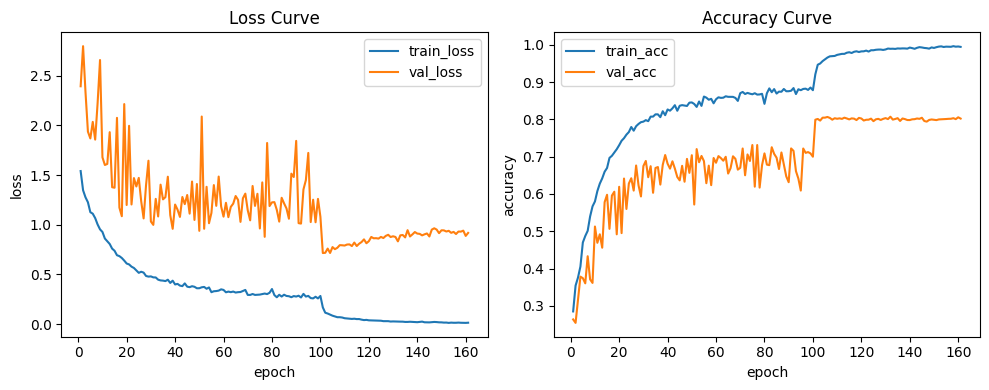

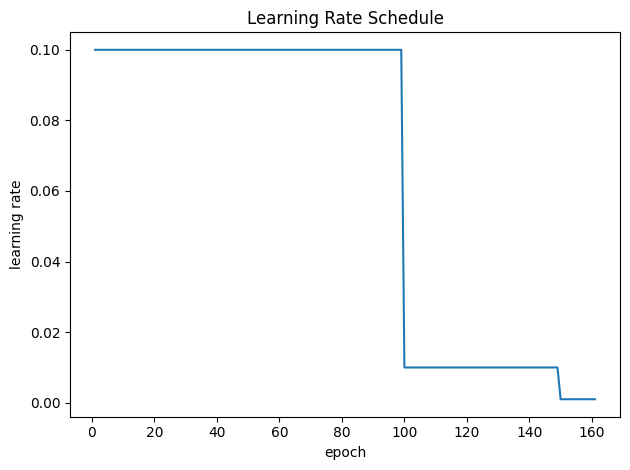


=== Model 6 (Balanced Softmax) Test Result ===
Accuracy: 0.7992
F1 Score: 0.7991
Loss    : 0.6346


In [35]:
# ============================================
# [Model 6] Balanced Softmax (SOTA 계열)
#  - 데이터: imbalanced_loader (원본 불균형 그대로)
#  - Loss: BalancedSoftmaxLoss
# ============================================

import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

num_classes = 10

# 1. imbalanced_train 기준으로 클래스별 샘플 수 계산
targets_imb = np.array(train_full.targets)[imbalanced_train.indices]
class_counts = np.bincount(targets_imb, minlength=num_classes)

print("Class counts in imbalanced_train:", class_counts)

# 2. Balanced Softmax Loss 설정
criterion_bs = BalancedSoftmaxLoss(class_counts=class_counts, reduction='mean')

# 3. 모델 / 옵티마이저 / 스케줄러
model_bs = build_resnet20(num_classes=num_classes).to(device)

optimizer_bs = optim.SGD(
    model_bs.parameters(),
    lr=0.1,            # 기본 0.1부터
    momentum=0.9,
    weight_decay=5e-4
)

# CIFAR-10-LT 논문들에서 많이 쓰는 MultiStepLR 패턴 비슷하게
scheduler_bs = MultiStepLR(
    optimizer_bs,
    milestones=[100, 150],
    gamma=0.1
)

print("\n================ Train Model 6 (Balanced Softmax) ================")

history_bs = early_stopping(
    train_loader=imbalanced_loader,          # 샘플러 X, Mixup X
    val_loader=test_loader_cifar10,
    model=model_bs,
    criterion=criterion_bs,
    optimizer=optimizer_bs,
    scheduler=scheduler_bs,
    patience=60,                             # 충분히 길게
    save_path="model_balanced_softmax.pth",
)

# 4. 평가 (평가는 일반 CE 기준으로 통일)
model_bs.load_state_dict(torch.load("model_balanced_softmax.pth"))
bs_acc, bs_f1, bs_loss = evaluate(test_loader_cifar10, model_bs, nn.CrossEntropyLoss())

print("\n=== Model 6 (Balanced Softmax) Test Result ===")
print("Accuracy:", round(bs_acc, 4))
print("F1 Score:", round(bs_f1, 4))   # 여기서 0.8 근처 노려보는 거고
print("Loss    :", round(bs_loss, 4))


result



```
Class counts in imbalanced_train: [5000  500  500  500  500  500  500  500  500  500]

================ Train Model 6 (Balanced Softmax) ================
  0%|          | 1/200 [00:03<11:44,  3.54s/it]epoch:0   train_loss=1.5410 train_acc=0.2849 val_loss=2.3943 val_acc=0.2635 val_f1=0.2134 lr=0.1
  1%|          | 2/200 [00:06<11:21,  3.44s/it]epoch:1   train_loss=1.3477 train_acc=0.3542 val_loss=2.7980 val_acc=0.2542 val_f1=0.2144 lr=0.1
  2%|▏         | 3/200 [00:10<11:15,  3.43s/it]epoch:2   train_loss=1.2767 train_acc=0.3758 val_loss=2.3363 val_acc=0.3157 val_f1=0.2911 lr=0.1
  2%|▏         | 4/200 [00:13<11:12,  3.43s/it]epoch:3   train_loss=1.2270 train_acc=0.4054 val_loss=1.9380 val_acc=0.3782 val_f1=0.3386 lr=0.1
  2%|▎         | 5/200 [00:17<11:02,  3.40s/it]epoch:4   train_loss=1.1271 train_acc=0.4699 val_loss=1.8695 val_acc=0.3742 val_f1=0.3472 lr=0.1
  3%|▎         | 6/200 [00:20<11:04,  3.43s/it]epoch:5   train_loss=1.1119 train_acc=0.4873 val_loss=2.0358 val_acc=0.3603 val_f1=0.3369 lr=0.1
  4%|▎         | 7/200 [00:23<10:49,  3.37s/it]epoch:6   train_loss=1.0675 train_acc=0.5012 val_loss=1.8576 val_acc=0.4330 val_f1=0.4165 lr=0.1
  4%|▍         | 8/200 [00:27<10:38,  3.32s/it]epoch:7   train_loss=1.0037 train_acc=0.5397 val_loss=2.2248 val_acc=0.3709 val_f1=0.3231 lr=0.1
  4%|▍         | 9/200 [00:30<10:32,  3.31s/it]epoch:8   train_loss=0.9542 train_acc=0.5667 val_loss=2.6586 val_acc=0.3614 val_f1=0.3231 lr=0.1
  5%|▌         | 10/200 [00:33<10:22,  3.28s/it]epoch:9   train_loss=0.9281 train_acc=0.5800 val_loss=1.6794 val_acc=0.5127 val_f1=0.4888 lr=0.1
  6%|▌         | 11/200 [00:36<10:13,  3.25s/it]epoch:10  train_loss=0.8620 train_acc=0.6078 val_loss=1.6021 val_acc=0.4690 val_f1=0.4343 lr=0.1
  6%|▌         | 12/200 [00:40<10:16,  3.28s/it]epoch:11  train_loss=0.8349 train_acc=0.6277 val_loss=1.6126 val_acc=0.4919 val_f1=0.4872 lr=0.1
  6%|▋         | 13/200 [00:43<10:16,  3.30s/it]epoch:12  train_loss=0.8069 train_acc=0.6419 val_loss=1.9324 val_acc=0.4559 val_f1=0.4164 lr=0.1
  7%|▋         | 14/200 [00:46<10:09,  3.28s/it]epoch:13  train_loss=0.7603 train_acc=0.6598 val_loss=1.3785 val_acc=0.5781 val_f1=0.5823 lr=0.1
  8%|▊         | 15/200 [00:49<10:07,  3.28s/it]epoch:14  train_loss=0.7387 train_acc=0.6698 val_loss=1.3730 val_acc=0.5979 val_f1=0.5837 lr=0.1
  8%|▊         | 16/200 [00:53<10:16,  3.35s/it]epoch:15  train_loss=0.6939 train_acc=0.6967 val_loss=2.0765 val_acc=0.5065 val_f1=0.4880 lr=0.1
  8%|▊         | 17/200 [00:56<10:07,  3.32s/it]epoch:16  train_loss=0.6848 train_acc=0.7024 val_loss=1.1734 val_acc=0.5957 val_f1=0.5766 lr=0.1
  9%|▉         | 18/200 [01:00<10:12,  3.37s/it]epoch:17  train_loss=0.6660 train_acc=0.7114 val_loss=1.0867 val_acc=0.6061 val_f1=0.6077 lr=0.1
 10%|▉         | 19/200 [01:03<10:10,  3.37s/it]epoch:18  train_loss=0.6398 train_acc=0.7201 val_loss=2.2151 val_acc=0.4918 val_f1=0.4553 lr=0.1
 10%|█         | 20/200 [01:06<09:59,  3.33s/it]epoch:19  train_loss=0.6105 train_acc=0.7308 val_loss=1.1995 val_acc=0.6193 val_f1=0.6188 lr=0.1
 10%|█         | 21/200 [01:10<09:52,  3.31s/it]epoch:20  train_loss=0.6014 train_acc=0.7427 val_loss=1.9963 val_acc=0.4950 val_f1=0.4928 lr=0.1
 11%|█         | 22/200 [01:13<09:43,  3.28s/it]epoch:21  train_loss=0.5790 train_acc=0.7497 val_loss=1.2047 val_acc=0.6414 val_f1=0.6356 lr=0.1
 12%|█▏        | 23/200 [01:16<09:39,  3.27s/it]epoch:22  train_loss=0.5654 train_acc=0.7592 val_loss=1.4705 val_acc=0.5598 val_f1=0.5471 lr=0.1
 12%|█▏        | 24/200 [01:19<09:31,  3.25s/it]epoch:23  train_loss=0.5413 train_acc=0.7661 val_loss=1.3858 val_acc=0.6280 val_f1=0.6165 lr=0.1
 12%|█▎        | 25/200 [01:22<09:26,  3.24s/it]epoch:24  train_loss=0.5166 train_acc=0.7797 val_loss=1.4724 val_acc=0.6422 val_f1=0.6402 lr=0.1
 13%|█▎        | 26/200 [01:26<09:36,  3.31s/it]epoch:25  train_loss=0.5276 train_acc=0.7698 val_loss=1.2374 val_acc=0.6091 val_f1=0.6140 lr=0.1
 14%|█▎        | 27/200 [01:29<09:27,  3.28s/it]epoch:26  train_loss=0.5189 train_acc=0.7818 val_loss=1.0644 val_acc=0.6764 val_f1=0.6742 lr=0.1
 14%|█▍        | 28/200 [01:32<09:21,  3.27s/it]epoch:27  train_loss=0.4851 train_acc=0.7879 val_loss=1.3986 val_acc=0.6231 val_f1=0.6303 lr=0.1
 14%|█▍        | 29/200 [01:36<09:13,  3.24s/it]epoch:28  train_loss=0.4787 train_acc=0.7926 val_loss=1.6452 val_acc=0.5934 val_f1=0.5807 lr=0.1
 15%|█▌        | 30/200 [01:39<09:19,  3.29s/it]epoch:29  train_loss=0.4808 train_acc=0.7941 val_loss=1.0336 val_acc=0.6749 val_f1=0.6687 lr=0.1
 16%|█▌        | 31/200 [01:42<09:16,  3.29s/it]epoch:30  train_loss=0.4709 train_acc=0.7981 val_loss=0.9993 val_acc=0.6886 val_f1=0.6876 lr=0.1
 16%|█▌        | 32/200 [01:46<09:22,  3.35s/it]epoch:31  train_loss=0.4702 train_acc=0.7954 val_loss=1.2611 val_acc=0.6449 val_f1=0.6522 lr=0.1
 16%|█▋        | 33/200 [01:49<09:20,  3.35s/it]epoch:32  train_loss=0.4479 train_acc=0.8075 val_loss=1.0841 val_acc=0.6745 val_f1=0.6679 lr=0.1
 17%|█▋        | 34/200 [01:53<09:22,  3.39s/it]epoch:33  train_loss=0.4403 train_acc=0.8076 val_loss=1.4041 val_acc=0.6032 val_f1=0.6100 lr=0.1
 18%|█▊        | 35/200 [01:56<09:21,  3.40s/it]epoch:34  train_loss=0.4383 train_acc=0.8137 val_loss=1.2562 val_acc=0.6698 val_f1=0.6647 lr=0.1
 18%|█▊        | 36/200 [01:59<09:07,  3.34s/it]epoch:35  train_loss=0.4335 train_acc=0.8136 val_loss=1.2784 val_acc=0.6723 val_f1=0.6716 lr=0.1
 18%|█▊        | 37/200 [02:03<09:05,  3.34s/it]epoch:36  train_loss=0.4474 train_acc=0.8061 val_loss=1.4841 val_acc=0.6252 val_f1=0.6257 lr=0.1
 19%|█▉        | 38/200 [02:06<09:07,  3.38s/it]epoch:37  train_loss=0.4150 train_acc=0.8220 val_loss=1.0975 val_acc=0.6782 val_f1=0.6687 lr=0.1
 20%|█▉        | 39/200 [02:09<09:05,  3.39s/it]epoch:38  train_loss=0.4379 train_acc=0.8114 val_loss=0.9597 val_acc=0.7045 val_f1=0.7005 lr=0.1
 20%|██        | 40/200 [02:13<09:07,  3.42s/it]epoch:39  train_loss=0.3998 train_acc=0.8267 val_loss=1.2040 val_acc=0.6812 val_f1=0.6718 lr=0.1
 20%|██        | 41/200 [02:16<09:09,  3.45s/it]epoch:40  train_loss=0.4056 train_acc=0.8235 val_loss=1.1530 val_acc=0.6680 val_f1=0.6629 lr=0.1
 21%|██        | 42/200 [02:20<09:07,  3.47s/it]epoch:41  train_loss=0.3881 train_acc=0.8298 val_loss=1.0794 val_acc=0.6877 val_f1=0.6895 lr=0.1
 22%|██▏       | 43/200 [02:23<08:57,  3.42s/it]epoch:42  train_loss=0.3830 train_acc=0.8382 val_loss=1.2800 val_acc=0.6682 val_f1=0.6608 lr=0.1
 22%|██▏       | 44/200 [02:26<08:42,  3.35s/it]epoch:43  train_loss=0.4104 train_acc=0.8233 val_loss=1.2081 val_acc=0.6456 val_f1=0.6498 lr=0.1
 22%|██▎       | 45/200 [02:30<08:38,  3.35s/it]epoch:44  train_loss=0.3774 train_acc=0.8367 val_loss=1.3001 val_acc=0.6365 val_f1=0.6424 lr=0.1
 23%|██▎       | 46/200 [02:33<08:27,  3.29s/it]epoch:45  train_loss=0.3726 train_acc=0.8383 val_loss=1.1125 val_acc=0.6755 val_f1=0.6795 lr=0.1
 24%|██▎       | 47/200 [02:36<08:22,  3.29s/it]epoch:46  train_loss=0.3821 train_acc=0.8372 val_loss=1.4355 val_acc=0.6329 val_f1=0.6309 lr=0.1
 24%|██▍       | 48/200 [02:39<08:14,  3.25s/it]epoch:47  train_loss=0.3763 train_acc=0.8361 val_loss=1.0490 val_acc=0.6941 val_f1=0.6938 lr=0.1
 24%|██▍       | 49/200 [02:43<08:08,  3.24s/it]epoch:48  train_loss=0.3614 train_acc=0.8449 val_loss=1.4108 val_acc=0.6567 val_f1=0.6603 lr=0.1
 25%|██▌       | 50/200 [02:46<08:22,  3.35s/it]epoch:49  train_loss=0.3618 train_acc=0.8456 val_loss=0.9394 val_acc=0.7040 val_f1=0.7109 lr=0.1
 26%|██▌       | 51/200 [02:49<08:11,  3.30s/it]epoch:50  train_loss=0.3713 train_acc=0.8415 val_loss=2.0897 val_acc=0.5717 val_f1=0.5718 lr=0.1
 26%|██▌       | 52/200 [02:53<08:12,  3.33s/it]epoch:51  train_loss=0.3748 train_acc=0.8336 val_loss=0.9602 val_acc=0.7204 val_f1=0.7180 lr=0.1
 26%|██▋       | 53/200 [02:56<08:02,  3.28s/it]epoch:52  train_loss=0.3564 train_acc=0.8481 val_loss=1.3825 val_acc=0.6852 val_f1=0.6828 lr=0.1
 27%|██▋       | 54/200 [02:59<07:55,  3.26s/it]epoch:53  train_loss=0.3698 train_acc=0.8363 val_loss=1.0160 val_acc=0.7020 val_f1=0.7058 lr=0.1
 28%|██▊       | 55/200 [03:02<07:51,  3.25s/it]epoch:54  train_loss=0.3219 train_acc=0.8614 val_loss=1.1198 val_acc=0.6883 val_f1=0.6804 lr=0.1
 28%|██▊       | 56/200 [03:06<07:49,  3.26s/it]epoch:55  train_loss=0.3313 train_acc=0.8584 val_loss=1.3997 val_acc=0.6289 val_f1=0.6166 lr=0.1
 28%|██▊       | 57/200 [03:09<07:50,  3.29s/it]epoch:56  train_loss=0.3333 train_acc=0.8528 val_loss=1.1910 val_acc=0.6760 val_f1=0.6718 lr=0.1
 29%|██▉       | 58/200 [03:12<07:46,  3.28s/it]epoch:57  train_loss=0.3377 train_acc=0.8553 val_loss=1.4856 val_acc=0.6237 val_f1=0.6224 lr=0.1
 30%|██▉       | 59/200 [03:15<07:40,  3.27s/it]epoch:58  train_loss=0.3506 train_acc=0.8433 val_loss=1.1856 val_acc=0.6965 val_f1=0.6844 lr=0.1
 30%|███       | 60/200 [03:19<07:40,  3.29s/it]epoch:59  train_loss=0.3446 train_acc=0.8541 val_loss=1.0822 val_acc=0.6838 val_f1=0.6841 lr=0.1
 30%|███       | 61/200 [03:22<07:36,  3.29s/it]epoch:60  train_loss=0.3209 train_acc=0.8594 val_loss=1.2217 val_acc=0.7016 val_f1=0.7029 lr=0.1
 31%|███       | 62/200 [03:26<07:41,  3.34s/it]epoch:61  train_loss=0.3278 train_acc=0.8578 val_loss=1.0768 val_acc=0.6963 val_f1=0.6953 lr=0.1
 32%|███▏      | 63/200 [03:29<07:31,  3.30s/it]epoch:62  train_loss=0.3222 train_acc=0.8583 val_loss=1.1806 val_acc=0.6892 val_f1=0.6862 lr=0.1
 32%|███▏      | 64/200 [03:32<07:38,  3.37s/it]epoch:63  train_loss=0.3282 train_acc=0.8621 val_loss=1.2131 val_acc=0.6998 val_f1=0.6976 lr=0.1
 32%|███▎      | 65/200 [03:36<07:41,  3.42s/it]epoch:64  train_loss=0.3183 train_acc=0.8606 val_loss=1.2899 val_acc=0.6548 val_f1=0.6399 lr=0.1
 33%|███▎      | 66/200 [03:39<07:31,  3.37s/it]epoch:65  train_loss=0.3222 train_acc=0.8606 val_loss=1.2509 val_acc=0.6692 val_f1=0.6603 lr=0.1
 34%|███▎      | 67/200 [03:42<07:27,  3.37s/it]epoch:66  train_loss=0.3236 train_acc=0.8605 val_loss=1.0296 val_acc=0.7011 val_f1=0.6953 lr=0.1
 34%|███▍      | 68/200 [03:46<07:32,  3.43s/it]epoch:67  train_loss=0.3345 train_acc=0.8577 val_loss=1.2671 val_acc=0.6943 val_f1=0.6920 lr=0.1
 34%|███▍      | 69/200 [03:49<07:19,  3.35s/it]epoch:68  train_loss=0.3446 train_acc=0.8497 val_loss=1.3138 val_acc=0.6653 val_f1=0.6760 lr=0.1
 35%|███▌      | 70/200 [03:52<07:09,  3.30s/it]epoch:69  train_loss=0.2946 train_acc=0.8704 val_loss=1.1462 val_acc=0.6702 val_f1=0.6633 lr=0.1
 36%|███▌      | 71/200 [03:56<07:14,  3.37s/it]epoch:70  train_loss=0.2942 train_acc=0.8737 val_loss=1.0453 val_acc=0.7220 val_f1=0.7194 lr=0.1
 36%|███▌      | 72/200 [03:59<07:09,  3.36s/it]epoch:71  train_loss=0.3036 train_acc=0.8682 val_loss=1.3907 val_acc=0.6502 val_f1=0.6523 lr=0.1
 36%|███▋      | 73/200 [04:02<07:01,  3.32s/it]epoch:72  train_loss=0.2944 train_acc=0.8712 val_loss=1.1905 val_acc=0.7061 val_f1=0.7092 lr=0.1
 37%|███▋      | 74/200 [04:06<06:56,  3.31s/it]epoch:73  train_loss=0.2962 train_acc=0.8691 val_loss=1.3123 val_acc=0.6885 val_f1=0.6873 lr=0.1
 38%|███▊      | 75/200 [04:09<06:56,  3.33s/it]epoch:74  train_loss=0.2977 train_acc=0.8675 val_loss=0.9632 val_acc=0.7313 val_f1=0.7286 lr=0.1
 38%|███▊      | 76/200 [04:13<06:58,  3.37s/it]epoch:75  train_loss=0.3029 train_acc=0.8703 val_loss=1.4267 val_acc=0.6196 val_f1=0.6199 lr=0.1
 38%|███▊      | 77/200 [04:16<06:49,  3.33s/it]epoch:76  train_loss=0.3082 train_acc=0.8666 val_loss=0.8791 val_acc=0.7313 val_f1=0.7344 lr=0.1
 39%|███▉      | 78/200 [04:19<06:44,  3.31s/it]epoch:77  train_loss=0.3028 train_acc=0.8671 val_loss=1.8236 val_acc=0.6171 val_f1=0.5965 lr=0.1
 40%|███▉      | 79/200 [04:23<06:49,  3.38s/it]epoch:78  train_loss=0.3160 train_acc=0.8687 val_loss=1.1886 val_acc=0.6772 val_f1=0.6558 lr=0.1
 40%|████      | 80/200 [04:26<06:41,  3.34s/it]epoch:79  train_loss=0.3537 train_acc=0.8418 val_loss=1.2261 val_acc=0.7089 val_f1=0.7040 lr=0.1
 40%|████      | 81/200 [04:29<06:32,  3.30s/it]epoch:80  train_loss=0.2927 train_acc=0.8702 val_loss=1.2282 val_acc=0.6788 val_f1=0.6748 lr=0.1
 41%|████      | 82/200 [04:32<06:28,  3.30s/it]epoch:81  train_loss=0.2708 train_acc=0.8833 val_loss=1.1501 val_acc=0.6773 val_f1=0.6670 lr=0.1
 42%|████▏     | 83/200 [04:36<06:22,  3.27s/it]epoch:82  train_loss=0.2960 train_acc=0.8731 val_loss=1.0324 val_acc=0.7254 val_f1=0.7208 lr=0.1
 42%|████▏     | 84/200 [04:39<06:20,  3.28s/it]epoch:83  train_loss=0.2780 train_acc=0.8814 val_loss=1.2721 val_acc=0.7076 val_f1=0.7047 lr=0.1
 42%|████▎     | 85/200 [04:42<06:24,  3.34s/it]epoch:84  train_loss=0.2965 train_acc=0.8694 val_loss=1.2158 val_acc=0.6973 val_f1=0.6974 lr=0.1
 43%|████▎     | 86/200 [04:46<06:19,  3.33s/it]epoch:85  train_loss=0.2839 train_acc=0.8746 val_loss=1.1647 val_acc=0.6669 val_f1=0.6593 lr=0.1
 44%|████▎     | 87/200 [04:49<06:19,  3.36s/it]epoch:86  train_loss=0.2813 train_acc=0.8742 val_loss=1.0613 val_acc=0.7114 val_f1=0.7153 lr=0.1
 44%|████▍     | 88/200 [04:52<06:12,  3.33s/it]epoch:87  train_loss=0.2713 train_acc=0.8817 val_loss=1.5148 val_acc=0.6790 val_f1=0.6832 lr=0.1
 44%|████▍     | 89/200 [04:56<06:04,  3.29s/it]epoch:88  train_loss=0.2827 train_acc=0.8756 val_loss=1.4810 val_acc=0.6472 val_f1=0.6322 lr=0.1
 45%|████▌     | 90/200 [04:59<06:04,  3.32s/it]epoch:89  train_loss=0.2780 train_acc=0.8757 val_loss=1.8447 val_acc=0.6316 val_f1=0.6416 lr=0.1
 46%|████▌     | 91/200 [05:02<06:01,  3.31s/it]epoch:90  train_loss=0.2863 train_acc=0.8769 val_loss=1.0167 val_acc=0.7222 val_f1=0.7178 lr=0.1
 46%|████▌     | 92/200 [05:06<05:56,  3.30s/it]epoch:91  train_loss=0.2687 train_acc=0.8841 val_loss=1.0123 val_acc=0.7156 val_f1=0.7200 lr=0.1
 46%|████▋     | 93/200 [05:09<05:50,  3.27s/it]epoch:92  train_loss=0.3049 train_acc=0.8681 val_loss=1.3558 val_acc=0.6613 val_f1=0.6630 lr=0.1
 47%|████▋     | 94/200 [05:12<05:48,  3.29s/it]epoch:93  train_loss=0.2778 train_acc=0.8809 val_loss=1.4498 val_acc=0.6413 val_f1=0.6511 lr=0.1
 48%|████▊     | 95/200 [05:15<05:44,  3.28s/it]epoch:94  train_loss=0.2845 train_acc=0.8784 val_loss=1.7235 val_acc=0.6092 val_f1=0.6025 lr=0.1
 48%|████▊     | 96/200 [05:19<05:41,  3.28s/it]epoch:95  train_loss=0.2626 train_acc=0.8818 val_loss=1.0277 val_acc=0.7220 val_f1=0.7261 lr=0.1
 48%|████▊     | 97/200 [05:22<05:34,  3.25s/it]epoch:96  train_loss=0.2594 train_acc=0.8825 val_loss=1.2525 val_acc=0.7103 val_f1=0.7114 lr=0.1
 49%|████▉     | 98/200 [05:25<05:30,  3.24s/it]epoch:97  train_loss=0.2760 train_acc=0.8792 val_loss=1.0257 val_acc=0.7124 val_f1=0.7087 lr=0.1
 50%|████▉     | 99/200 [05:29<05:36,  3.33s/it]epoch:98  train_loss=0.2591 train_acc=0.8855 val_loss=1.2608 val_acc=0.7089 val_f1=0.7049 lr=0.1
 50%|█████     | 100/200 [05:32<05:29,  3.30s/it]epoch:99  train_loss=0.2839 train_acc=0.8784 val_loss=1.0812 val_acc=0.7000 val_f1=0.6857 lr=0.010000000000000002
 50%|█████     | 101/200 [05:35<05:22,  3.26s/it]epoch:100 train_loss=0.1687 train_acc=0.9209 val_loss=0.7159 val_acc=0.7992 val_f1=0.7991 lr=0.010000000000000002
 51%|█████     | 102/200 [05:38<05:18,  3.25s/it]epoch:101 train_loss=0.1153 train_acc=0.9467 val_loss=0.7184 val_acc=0.8013 val_f1=0.8001 lr=0.010000000000000002
 52%|█████▏    | 103/200 [05:41<05:15,  3.25s/it]epoch:102 train_loss=0.1072 train_acc=0.9500 val_loss=0.7608 val_acc=0.7969 val_f1=0.7970 lr=0.010000000000000002
 52%|█████▏    | 104/200 [05:45<05:12,  3.26s/it]epoch:103 train_loss=0.0964 train_acc=0.9564 val_loss=0.7166 val_acc=0.8047 val_f1=0.8047 lr=0.010000000000000002
 52%|█████▎    | 105/200 [05:48<05:07,  3.23s/it]epoch:104 train_loss=0.0854 train_acc=0.9614 val_loss=0.7758 val_acc=0.8048 val_f1=0.8036 lr=0.010000000000000002
 53%|█████▎    | 106/200 [05:51<05:13,  3.34s/it]epoch:105 train_loss=0.0783 train_acc=0.9660 val_loss=0.7548 val_acc=0.8066 val_f1=0.8057 lr=0.010000000000000002
 54%|█████▎    | 107/200 [05:55<05:07,  3.30s/it]epoch:106 train_loss=0.0701 train_acc=0.9693 val_loss=0.7688 val_acc=0.8040 val_f1=0.8048 lr=0.010000000000000002
 54%|█████▍    | 108/200 [05:58<05:06,  3.33s/it]epoch:107 train_loss=0.0701 train_acc=0.9697 val_loss=0.7953 val_acc=0.7993 val_f1=0.7990 lr=0.010000000000000002
 55%|█████▍    | 109/200 [06:01<05:01,  3.32s/it]epoch:108 train_loss=0.0669 train_acc=0.9703 val_loss=0.7940 val_acc=0.8032 val_f1=0.8031 lr=0.010000000000000002
 55%|█████▌    | 110/200 [06:05<04:55,  3.28s/it]epoch:109 train_loss=0.0598 train_acc=0.9732 val_loss=0.7912 val_acc=0.8018 val_f1=0.8017 lr=0.010000000000000002
 56%|█████▌    | 111/200 [06:08<04:50,  3.26s/it]epoch:110 train_loss=0.0576 train_acc=0.9745 val_loss=0.8014 val_acc=0.8029 val_f1=0.8023 lr=0.010000000000000002
 56%|█████▌    | 112/200 [06:11<04:46,  3.25s/it]epoch:111 train_loss=0.0555 train_acc=0.9759 val_loss=0.8030 val_acc=0.8015 val_f1=0.8011 lr=0.010000000000000002
 56%|█████▋    | 113/200 [06:14<04:45,  3.28s/it]epoch:112 train_loss=0.0528 train_acc=0.9759 val_loss=0.7862 val_acc=0.8047 val_f1=0.8046 lr=0.010000000000000002
 57%|█████▋    | 114/200 [06:18<04:39,  3.25s/it]epoch:113 train_loss=0.0549 train_acc=0.9789 val_loss=0.8213 val_acc=0.8026 val_f1=0.8020 lr=0.010000000000000002
 57%|█████▊    | 115/200 [06:21<04:34,  3.23s/it]epoch:114 train_loss=0.0511 train_acc=0.9802 val_loss=0.7864 val_acc=0.8001 val_f1=0.7996 lr=0.010000000000000002
 58%|█████▊    | 116/200 [06:24<04:31,  3.23s/it]epoch:115 train_loss=0.0516 train_acc=0.9782 val_loss=0.8100 val_acc=0.8028 val_f1=0.8028 lr=0.010000000000000002
 58%|█████▊    | 117/200 [06:27<04:30,  3.25s/it]epoch:116 train_loss=0.0455 train_acc=0.9815 val_loss=0.8267 val_acc=0.8021 val_f1=0.8016 lr=0.010000000000000002
 59%|█████▉    | 118/200 [06:31<04:27,  3.26s/it]epoch:117 train_loss=0.0410 train_acc=0.9827 val_loss=0.8536 val_acc=0.7983 val_f1=0.7981 lr=0.010000000000000002
 60%|█████▉    | 119/200 [06:34<04:22,  3.24s/it]epoch:118 train_loss=0.0432 train_acc=0.9808 val_loss=0.8145 val_acc=0.8041 val_f1=0.8047 lr=0.010000000000000002
 60%|██████    | 120/200 [06:37<04:20,  3.25s/it]epoch:119 train_loss=0.0387 train_acc=0.9825 val_loss=0.8351 val_acc=0.8025 val_f1=0.8024 lr=0.010000000000000002
 60%|██████    | 121/200 [06:40<04:16,  3.24s/it]epoch:120 train_loss=0.0380 train_acc=0.9827 val_loss=0.8777 val_acc=0.7971 val_f1=0.7971 lr=0.010000000000000002
 61%|██████    | 122/200 [06:44<04:14,  3.26s/it]epoch:121 train_loss=0.0384 train_acc=0.9846 val_loss=0.8644 val_acc=0.7991 val_f1=0.7995 lr=0.010000000000000002
 62%|██████▏   | 123/200 [06:47<04:11,  3.26s/it]epoch:122 train_loss=0.0370 train_acc=0.9820 val_loss=0.8654 val_acc=0.7993 val_f1=0.7999 lr=0.010000000000000002
 62%|██████▏   | 124/200 [06:50<04:14,  3.35s/it]epoch:123 train_loss=0.0353 train_acc=0.9856 val_loss=0.8613 val_acc=0.8021 val_f1=0.8022 lr=0.010000000000000002
 62%|██████▎   | 125/200 [06:54<04:12,  3.37s/it]epoch:124 train_loss=0.0346 train_acc=0.9856 val_loss=0.8780 val_acc=0.7954 val_f1=0.7968 lr=0.010000000000000002
 63%|██████▎   | 126/200 [06:57<04:04,  3.31s/it]epoch:125 train_loss=0.0304 train_acc=0.9868 val_loss=0.8670 val_acc=0.8003 val_f1=0.7999 lr=0.010000000000000002
 64%|██████▎   | 127/200 [07:00<03:59,  3.28s/it]epoch:126 train_loss=0.0306 train_acc=0.9874 val_loss=0.8886 val_acc=0.8015 val_f1=0.8009 lr=0.010000000000000002
 64%|██████▍   | 128/200 [07:03<03:56,  3.29s/it]epoch:127 train_loss=0.0303 train_acc=0.9875 val_loss=0.8996 val_acc=0.7986 val_f1=0.7980 lr=0.010000000000000002
 64%|██████▍   | 129/200 [07:07<03:54,  3.31s/it]epoch:128 train_loss=0.0265 train_acc=0.9864 val_loss=0.8772 val_acc=0.8015 val_f1=0.8014 lr=0.010000000000000002
 65%|██████▌   | 130/200 [07:10<03:50,  3.29s/it]epoch:129 train_loss=0.0277 train_acc=0.9877 val_loss=0.8845 val_acc=0.8035 val_f1=0.8023 lr=0.010000000000000002
 66%|██████▌   | 131/200 [07:13<03:44,  3.26s/it]epoch:130 train_loss=0.0266 train_acc=0.9901 val_loss=0.8777 val_acc=0.8009 val_f1=0.8002 lr=0.010000000000000002
 66%|██████▌   | 132/200 [07:16<03:40,  3.24s/it]epoch:131 train_loss=0.0263 train_acc=0.9895 val_loss=0.8334 val_acc=0.8073 val_f1=0.8066 lr=0.010000000000000002
 66%|██████▋   | 133/200 [07:20<03:38,  3.26s/it]epoch:132 train_loss=0.0255 train_acc=0.9897 val_loss=0.8940 val_acc=0.7995 val_f1=0.7996 lr=0.010000000000000002
 67%|██████▋   | 134/200 [07:23<03:40,  3.34s/it]epoch:133 train_loss=0.0253 train_acc=0.9892 val_loss=0.8976 val_acc=0.8012 val_f1=0.8018 lr=0.010000000000000002
 68%|██████▊   | 135/200 [07:27<03:34,  3.30s/it]epoch:134 train_loss=0.0225 train_acc=0.9904 val_loss=0.8733 val_acc=0.8034 val_f1=0.8038 lr=0.010000000000000002
 68%|██████▊   | 136/200 [07:30<03:31,  3.31s/it]epoch:135 train_loss=0.0227 train_acc=0.9901 val_loss=0.9460 val_acc=0.7959 val_f1=0.7973 lr=0.010000000000000002
 68%|██████▊   | 137/200 [07:33<03:29,  3.33s/it]epoch:136 train_loss=0.0243 train_acc=0.9905 val_loss=0.8827 val_acc=0.8025 val_f1=0.8015 lr=0.010000000000000002
 69%|██████▉   | 138/200 [07:37<03:28,  3.36s/it]epoch:137 train_loss=0.0231 train_acc=0.9904 val_loss=0.9037 val_acc=0.8009 val_f1=0.8011 lr=0.010000000000000002
 70%|██████▉   | 139/200 [07:40<03:21,  3.30s/it]epoch:138 train_loss=0.0227 train_acc=0.9899 val_loss=0.9273 val_acc=0.7984 val_f1=0.7977 lr=0.010000000000000002
 70%|███████   | 140/200 [07:43<03:20,  3.35s/it]epoch:139 train_loss=0.0199 train_acc=0.9927 val_loss=0.9118 val_acc=0.7983 val_f1=0.7984 lr=0.010000000000000002
 70%|███████   | 141/200 [07:47<03:17,  3.35s/it]epoch:140 train_loss=0.0223 train_acc=0.9913 val_loss=0.9089 val_acc=0.8003 val_f1=0.8003 lr=0.010000000000000002
 71%|███████   | 142/200 [07:50<03:11,  3.30s/it]epoch:141 train_loss=0.0256 train_acc=0.9895 val_loss=0.8938 val_acc=0.8007 val_f1=0.8008 lr=0.010000000000000002
 72%|███████▏  | 143/200 [07:53<03:08,  3.31s/it]epoch:142 train_loss=0.0190 train_acc=0.9921 val_loss=0.9043 val_acc=0.8025 val_f1=0.8016 lr=0.010000000000000002
 72%|███████▏  | 144/200 [07:56<03:04,  3.29s/it]epoch:143 train_loss=0.0180 train_acc=0.9939 val_loss=0.9129 val_acc=0.8016 val_f1=0.8012 lr=0.010000000000000002
 72%|███████▎  | 145/200 [08:00<03:03,  3.33s/it]epoch:144 train_loss=0.0180 train_acc=0.9931 val_loss=0.8826 val_acc=0.8045 val_f1=0.8047 lr=0.010000000000000002
 73%|███████▎  | 146/200 [08:03<02:57,  3.28s/it]epoch:145 train_loss=0.0200 train_acc=0.9918 val_loss=0.9517 val_acc=0.7958 val_f1=0.7955 lr=0.010000000000000002
 74%|███████▎  | 147/200 [08:06<02:53,  3.28s/it]epoch:146 train_loss=0.0224 train_acc=0.9912 val_loss=0.9649 val_acc=0.7941 val_f1=0.7953 lr=0.010000000000000002
 74%|███████▍  | 148/200 [08:10<02:52,  3.31s/it]epoch:147 train_loss=0.0211 train_acc=0.9899 val_loss=0.9522 val_acc=0.7986 val_f1=0.7993 lr=0.010000000000000002
 74%|███████▍  | 149/200 [08:13<02:48,  3.31s/it]epoch:148 train_loss=0.0185 train_acc=0.9932 val_loss=0.9159 val_acc=0.7999 val_f1=0.7999 lr=0.010000000000000002
 75%|███████▌  | 150/200 [08:16<02:43,  3.27s/it]epoch:149 train_loss=0.0182 train_acc=0.9918 val_loss=0.9450 val_acc=0.7991 val_f1=0.7984 lr=0.0010000000000000002
 76%|███████▌  | 151/200 [08:19<02:39,  3.26s/it]epoch:150 train_loss=0.0157 train_acc=0.9938 val_loss=0.9439 val_acc=0.7982 val_f1=0.7982 lr=0.0010000000000000002
 76%|███████▌  | 152/200 [08:23<02:36,  3.25s/it]epoch:151 train_loss=0.0161 train_acc=0.9954 val_loss=0.9327 val_acc=0.8000 val_f1=0.8005 lr=0.0010000000000000002
 76%|███████▋  | 153/200 [08:26<02:33,  3.27s/it]epoch:152 train_loss=0.0129 train_acc=0.9960 val_loss=0.9395 val_acc=0.8003 val_f1=0.8000 lr=0.0010000000000000002
 77%|███████▋  | 154/200 [08:29<02:33,  3.35s/it]epoch:153 train_loss=0.0156 train_acc=0.9943 val_loss=0.9194 val_acc=0.8007 val_f1=0.8001 lr=0.0010000000000000002
 78%|███████▊  | 155/200 [08:33<02:31,  3.36s/it]epoch:154 train_loss=0.0140 train_acc=0.9953 val_loss=0.9286 val_acc=0.8011 val_f1=0.8007 lr=0.0010000000000000002
 78%|███████▊  | 156/200 [08:36<02:25,  3.30s/it]epoch:155 train_loss=0.0142 train_acc=0.9951 val_loss=0.9073 val_acc=0.8016 val_f1=0.8021 lr=0.0010000000000000002
 78%|███████▊  | 157/200 [08:39<02:20,  3.26s/it]epoch:156 train_loss=0.0158 train_acc=0.9948 val_loss=0.9322 val_acc=0.8018 val_f1=0.8016 lr=0.0010000000000000002
 79%|███████▉  | 158/200 [08:42<02:17,  3.27s/it]epoch:157 train_loss=0.0141 train_acc=0.9965 val_loss=0.9314 val_acc=0.8033 val_f1=0.8033 lr=0.0010000000000000002
 80%|███████▉  | 159/200 [08:46<02:18,  3.37s/it]epoch:158 train_loss=0.0137 train_acc=0.9952 val_loss=0.9413 val_acc=0.8008 val_f1=0.8012 lr=0.0010000000000000002
 80%|████████  | 160/200 [08:49<02:13,  3.33s/it]epoch:159 train_loss=0.0130 train_acc=0.9957 val_loss=0.8883 val_acc=0.8057 val_f1=0.8052 lr=0.0010000000000000002
 80%|████████  | 160/200 [08:53<02:13,  3.33s/it]epoch:160 train_loss=0.0146 train_acc=0.9946 val_loss=0.9184 val_acc=0.8023 val_f1=0.8025 lr=0.0010000000000000002
Early stopping!

[Learning Curve] Train Loss: [1.54096617380778, 1.3477145115534463, 1.2767455641428629, 1.2269927819569906, 1.127105340162913, 1.1119136850039164, 1.0675305358568827, 1.00372226079305, 0.9541960986455281, 0.9280814504623414, 0.8620252672831218, 0.8349012541770935, 0.8069445856412252, 0.7603204361597697, 0.7387411717573802, 0.6939479243755341, 0.6847829902172089, 0.6659564510981242, 0.6397646983464559, 0.6105231149991354, 0.6013878246148427, 0.5790090874830882, 0.5653925426801045, 0.5412962830066681, 0.5166382964452108, 0.5276399278640747, 0.5188677342732747, 0.4850867505868276, 0.47872644464174907, 0.48079423149426775, 0.4709416917959849, 0.4702409040927887, 0.4479072397947311, 0.44033833384513854, 0.4383319850762685, 0.4335172875722249, 0.44739097038904824, 0.4150236541032791, 0.43792652249336245, 0.39981880426406863, 0.405606702764829, 0.38813033282756804, 0.3830224953095118, 0.4104411329825719, 0.3774275416135788, 0.3726499766111374, 0.3820638147989909, 0.37629779875278474, 0.361437829931577, 0.3618090623617172, 0.3712641316652298, 0.3747536168495814, 0.35642436921596526, 0.3697823796669642, 0.3218746495246887, 0.3313466437657674, 0.33326068878173826, 0.33769652803738914, 0.3506246429681778, 0.344606725970904, 0.3209319857756297, 0.32779887636502586, 0.3222043283780416, 0.32818288246790567, 0.3182812037070592, 0.3221908265352249, 0.32364368438720703, 0.33447487394014996, 0.34457848230997723, 0.2946330950657527, 0.29424785256385805, 0.3035543449719747, 0.29442135055859886, 0.2961545040210088, 0.29774707396825156, 0.3029284383853277, 0.30815936108430225, 0.30278316915035247, 0.3159961481889089, 0.35373852094014485, 0.29266005049149196, 0.2707875722646713, 0.2959598966439565, 0.2780450439453125, 0.29650504966576896, 0.2838732276360194, 0.28128738164901734, 0.2712671260039012, 0.28274131298065186, 0.27798803130785626, 0.28634892761707303, 0.2686563445130984, 0.3049421370029449, 0.2778367433945338, 0.28450797498226166, 0.26260397613048553, 0.2594227222601573, 0.2760280015071233, 0.2590756638844808, 0.28390657862027485, 0.16872644593318303, 0.11532012775540351, 0.1071718064447244, 0.09639535044630368, 0.08537718022863071, 0.07827967035273711, 0.07007090546190739, 0.07010509957869848, 0.06693809442222118, 0.059804878483215966, 0.05756153479218483, 0.05548987517754237, 0.052793214470148085, 0.05492211639881134, 0.051104982743660606, 0.05163543976843357, 0.04553458387653033, 0.04104331770290931, 0.04322566049794356, 0.03872405504186948, 0.03800643612941106, 0.03835215353717407, 0.03698106544713179, 0.035307089984416964, 0.03463676236569881, 0.03043516933917999, 0.030631482265889645, 0.030323447038729984, 0.0265086368098855, 0.027695218659937383, 0.02659239625558257, 0.026332004852592947, 0.02549326395615935, 0.02525771859412392, 0.022525991095850864, 0.02266026269023617, 0.024317929844061534, 0.023093400473395982, 0.02266561151171724, 0.019922417129079502, 0.022290165405720472, 0.025631994598855574, 0.01901906347523133, 0.01798201948404312, 0.01797525364595155, 0.019995836336165668, 0.02236987403904398, 0.021064446326345205, 0.018517191546658675, 0.018168954563637575, 0.015731239169836046, 0.016130945005764563, 0.012926361691206693, 0.015578205625837048, 0.014043769960602125, 0.014155060580621163, 0.015816448302939535, 0.014128121078635255, 0.013673520181328058, 0.013005674111967286, 0.014591067712754011]
[Learning Curve] Val Loss  : [2.3943490680259996, 2.7979780918435204, 2.3362988459913034, 1.9379551259777215, 1.8694740307481983, 2.0357983368861525, 1.8576187710218792, 2.2248083926454374, 2.658580435982233, 1.6793657058401952, 1.6020648630359504, 1.6126002043108396, 1.9323525609849375, 1.3784900360469576, 1.372966152203234, 2.076480538030214, 1.1733540168291405, 1.086702720273899, 2.2151058867007873, 1.1995060873937002, 1.9963140487670898, 1.2047265036196648, 1.470522190951094, 1.385806445834003, 1.4723790974556645, 1.2373802216747138, 1.0643845645687249, 1.398568029645123, 1.6451551008828078, 1.0335949712161776, 0.999319050885454, 1.2611201118819322, 1.0840794949591914, 1.4041110473343088, 1.2562270903889137, 1.2783529728273801, 1.4840967051590546, 1.0975010734570176, 0.959692921065077, 1.2039778074131737, 1.1530444954015031, 1.0794436524185953, 1.2799904580357708, 1.2080877453466006, 1.3001104178307932, 1.112455067755301, 1.435514414612251, 1.0489702692514733, 1.4108016822911515, 0.9394236946407752, 2.089733132833167, 0.9601590105249912, 1.3825145145005817, 1.0160156971291652, 1.1198235018343865, 1.3997345574294464, 1.1910363760175584, 1.4855702685404428, 1.1856047933614706, 1.0821592890763585, 1.2216863270047345, 1.0768069353284715, 1.1805906386315068, 1.2130799218069148, 1.2898687478862232, 1.250947883611993, 1.0295959552632103, 1.2671450557588022, 1.3137983808034583, 1.1462240030493918, 1.0452645383303678, 1.390693326539631, 1.1904840605168403, 1.3122711309903785, 0.9632210165639467, 1.4266774375227433, 0.8791485594797738, 1.8235733403435237, 1.1886244114441207, 1.226062303102469, 1.2282187802882134, 1.1500855390029618, 1.03236038473588, 1.2720956425123577, 1.2157796991022327, 1.1646665221528163, 1.0613060359713398, 1.514842412139796, 1.4810377268851558, 1.8446954073785227, 1.0167029741444165, 1.0122885704040527, 1.3558064518095572, 1.4497533085979992, 1.7235386703587785, 1.0277049043510533, 1.2525188432464116, 1.0256510806989065, 1.2608167348028738, 1.0812144256845306, 0.7158960598179057, 0.718378778499893, 0.7607521343080303, 0.7165622914893718, 0.7757538892800295, 0.7548348051083239, 0.7687945222552819, 0.7953472031822687, 0.7939535824558402, 0.7912467721896835, 0.8013860473904428, 0.8030238268496115, 0.7861938978297801, 0.8212870955467224, 0.7864424790008159, 0.809981531734708, 0.8266647107239011, 0.8536033645460878, 0.8144592397575137, 0.8350541455836236, 0.8776504699187943, 0.8643627261059194, 0.8654401788983164, 0.8613235377058198, 0.8780296610880501, 0.8669579991056949, 0.8885821386983123, 0.8995501972451995, 0.8771730982050111, 0.8845479375199427, 0.8776863390886331, 0.8333928517148464, 0.8940224398540545, 0.8976022725618338, 0.8732665241519108, 0.9459652806384654, 0.8826658306997034, 0.903746855787084, 0.9273157398911971, 0.9118295583543898, 0.9088541016548495, 0.8937513368039192, 0.9042937261394307, 0.9128901283197766, 0.8826423951342136, 0.9517208379280718, 0.9649213782594174, 0.9521978505050079, 0.9159432785420478, 0.9450022529197645, 0.9439373725577246, 0.9327003672907624, 0.9395432151571105, 0.9193941977205156, 0.9286398012426835, 0.9072939836526219, 0.9322155736669709, 0.9314163459252708, 0.9412565736830989, 0.8882906859434103, 0.9184270255927798]
[Learning Curve] Train Acc : [0.2849473684210526, 0.3542105263157895, 0.3757894736842105, 0.4053684210526316, 0.46989473684210525, 0.48726315789473684, 0.5011578947368421, 0.5396842105263158, 0.5667368421052632, 0.58, 0.6077894736842105, 0.6276842105263158, 0.6418947368421053, 0.6597894736842105, 0.6697894736842105, 0.6967368421052632, 0.702421052631579, 0.7113684210526315, 0.7201052631578947, 0.7308421052631578, 0.7427368421052631, 0.7496842105263158, 0.7591578947368421, 0.7661052631578947, 0.7796842105263158, 0.7697894736842106, 0.7817894736842105, 0.7878947368421053, 0.7926315789473685, 0.7941052631578948, 0.7981052631578948, 0.7953684210526316, 0.8074736842105263, 0.8075789473684211, 0.8136842105263158, 0.8135789473684211, 0.8061052631578948, 0.822, 0.8113684210526316, 0.8267368421052631, 0.8234736842105264, 0.8297894736842105, 0.8382105263157895, 0.8232631578947368, 0.8367368421052631, 0.8383157894736842, 0.8371578947368421, 0.8361052631578947, 0.8449473684210527, 0.8455789473684211, 0.8414736842105263, 0.8335789473684211, 0.8481052631578947, 0.8363157894736842, 0.8613684210526316, 0.858421052631579, 0.8528421052631578, 0.8552631578947368, 0.8432631578947368, 0.8541052631578947, 0.8593684210526316, 0.8577894736842105, 0.8583157894736843, 0.8621052631578947, 0.8606315789473684, 0.8606315789473684, 0.8605263157894737, 0.8576842105263158, 0.8496842105263158, 0.870421052631579, 0.8736842105263158, 0.8682105263157894, 0.8711578947368421, 0.8690526315789474, 0.8674736842105263, 0.8703157894736843, 0.8666315789473684, 0.8670526315789474, 0.8687368421052631, 0.8417894736842105, 0.8702105263157894, 0.8832631578947369, 0.8730526315789474, 0.8813684210526316, 0.8693684210526316, 0.8746315789473684, 0.8742105263157894, 0.8816842105263157, 0.875578947368421, 0.8756842105263158, 0.8769473684210526, 0.8841052631578947, 0.8681052631578947, 0.8809473684210526, 0.878421052631579, 0.8817894736842106, 0.8825263157894737, 0.8791578947368421, 0.8854736842105263, 0.878421052631579, 0.9209473684210526, 0.9467368421052632, 0.95, 0.956421052631579, 0.9613684210526315, 0.966, 0.9692631578947368, 0.9696842105263158, 0.9703157894736842, 0.9731578947368421, 0.9745263157894737, 0.9758947368421053, 0.9758947368421053, 0.9789473684210527, 0.9802105263157894, 0.9782105263157894, 0.9814736842105263, 0.9827368421052631, 0.9808421052631578, 0.9825263157894737, 0.9827368421052631, 0.9846315789473684, 0.982, 0.985578947368421, 0.985578947368421, 0.9868421052631579, 0.9873684210526316, 0.9874736842105263, 0.986421052631579, 0.9876842105263158, 0.9901052631578947, 0.9894736842105263, 0.9896842105263158, 0.9891578947368421, 0.990421052631579, 0.9901052631578947, 0.9905263157894737, 0.990421052631579, 0.9898947368421053, 0.9927368421052631, 0.9912631578947368, 0.9894736842105263, 0.9921052631578947, 0.9938947368421053, 0.9930526315789474, 0.9917894736842106, 0.9911578947368421, 0.9898947368421053, 0.9931578947368421, 0.9917894736842106, 0.9937894736842106, 0.9953684210526316, 0.996, 0.9943157894736843, 0.9952631578947368, 0.9950526315789474, 0.9948421052631579, 0.9965263157894737, 0.9951578947368421, 0.9956842105263158, 0.9946315789473684]
[Learning Curve] Val Acc   : [0.2635, 0.2542, 0.3157, 0.3782, 0.3742, 0.3603, 0.433, 0.3709, 0.3614, 0.5127, 0.469, 0.4919, 0.4559, 0.5781, 0.5979, 0.5065, 0.5957, 0.6061, 0.4918, 0.6193, 0.495, 0.6414, 0.5598, 0.628, 0.6422, 0.6091, 0.6764, 0.6231, 0.5934, 0.6749, 0.6886, 0.6449, 0.6745, 0.6032, 0.6698, 0.6723, 0.6252, 0.6782, 0.7045, 0.6812, 0.668, 0.6877, 0.6682, 0.6456, 0.6365, 0.6755, 0.6329, 0.6941, 0.6567, 0.704, 0.5717, 0.7204, 0.6852, 0.702, 0.6883, 0.6289, 0.676, 0.6237, 0.6965, 0.6838, 0.7016, 0.6963, 0.6892, 0.6998, 0.6548, 0.6692, 0.7011, 0.6943, 0.6653, 0.6702, 0.722, 0.6502, 0.7061, 0.6885, 0.7313, 0.6196, 0.7313, 0.6171, 0.6772, 0.7089, 0.6788, 0.6773, 0.7254, 0.7076, 0.6973, 0.6669, 0.7114, 0.679, 0.6472, 0.6316, 0.7222, 0.7156, 0.6613, 0.6413, 0.6092, 0.722, 0.7103, 0.7124, 0.7089, 0.7, 0.7992, 0.8013, 0.7969, 0.8047, 0.8048, 0.8066, 0.804, 0.7993, 0.8032, 0.8018, 0.8029, 0.8015, 0.8047, 0.8026, 0.8001, 0.8028, 0.8021, 0.7983, 0.8041, 0.8025, 0.7971, 0.7991, 0.7993, 0.8021, 0.7954, 0.8003, 0.8015, 0.7986, 0.8015, 0.8035, 0.8009, 0.8073, 0.7995, 0.8012, 0.8034, 0.7959, 0.8025, 0.8009, 0.7984, 0.7983, 0.8003, 0.8007, 0.8025, 0.8016, 0.8045, 0.7958, 0.7941, 0.7986, 0.7999, 0.7991, 0.7982, 0.8, 0.8003, 0.8007, 0.8011, 0.8016, 0.8018, 0.8033, 0.8008, 0.8057, 0.8023]




=== Model 6 (Balanced Softmax) Test Result ===
Accuracy: 0.7992
F1 Score: 0.7991
Loss    : 0.6346
```

